In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1.dev0


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

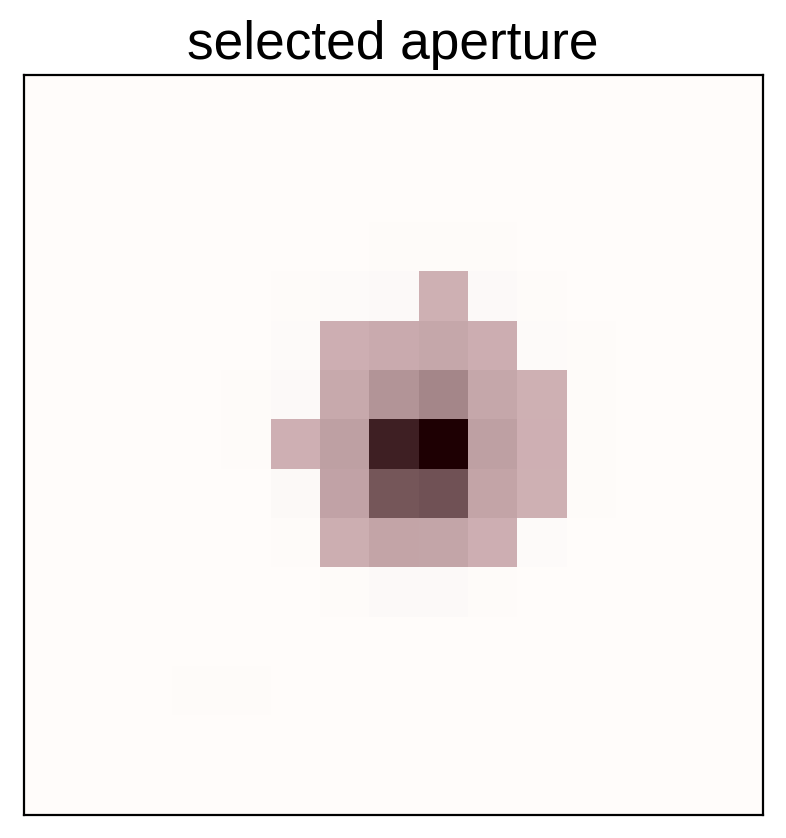

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

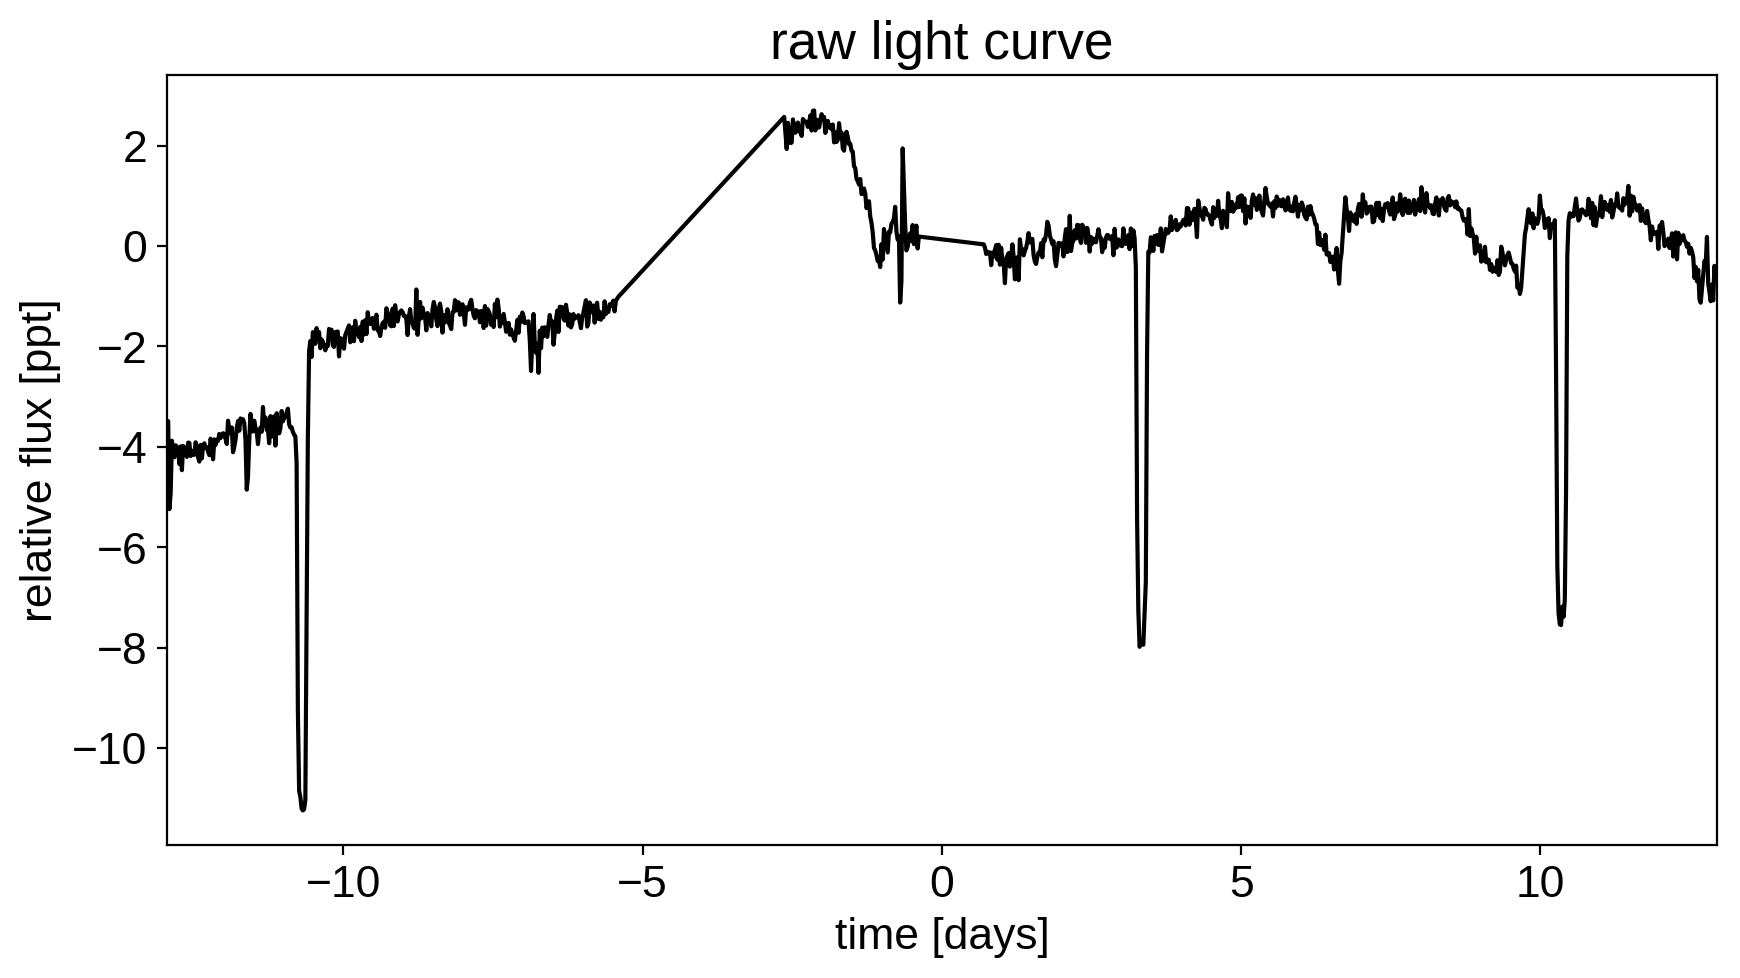

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

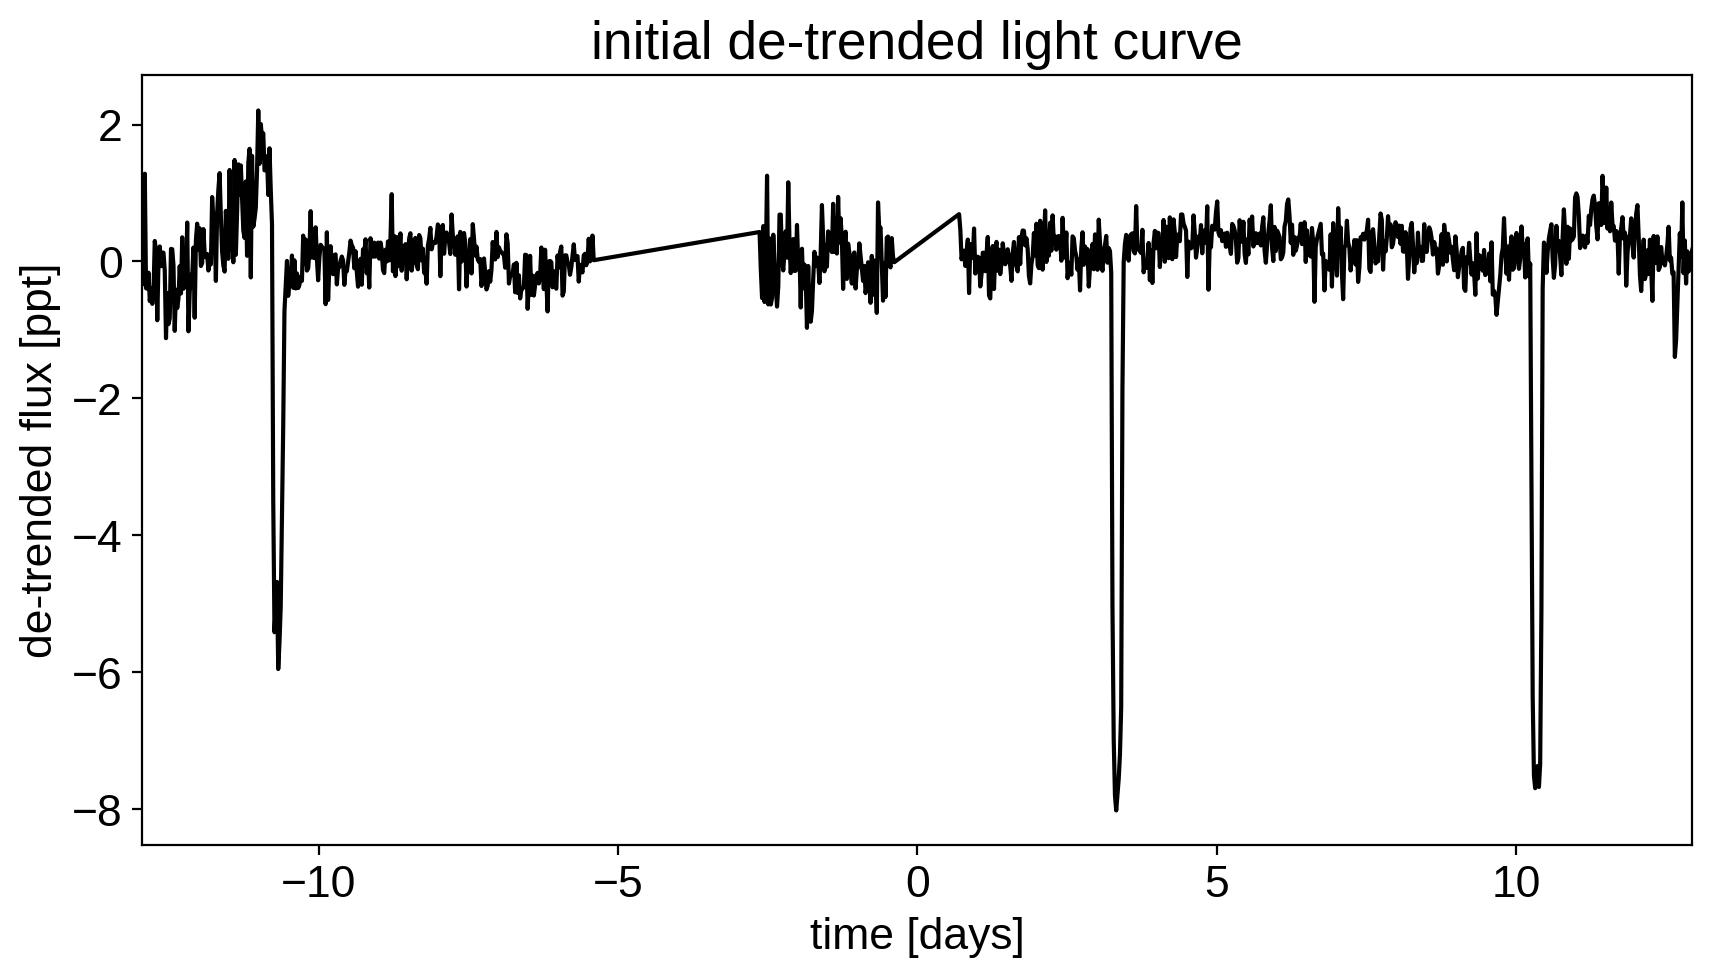

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

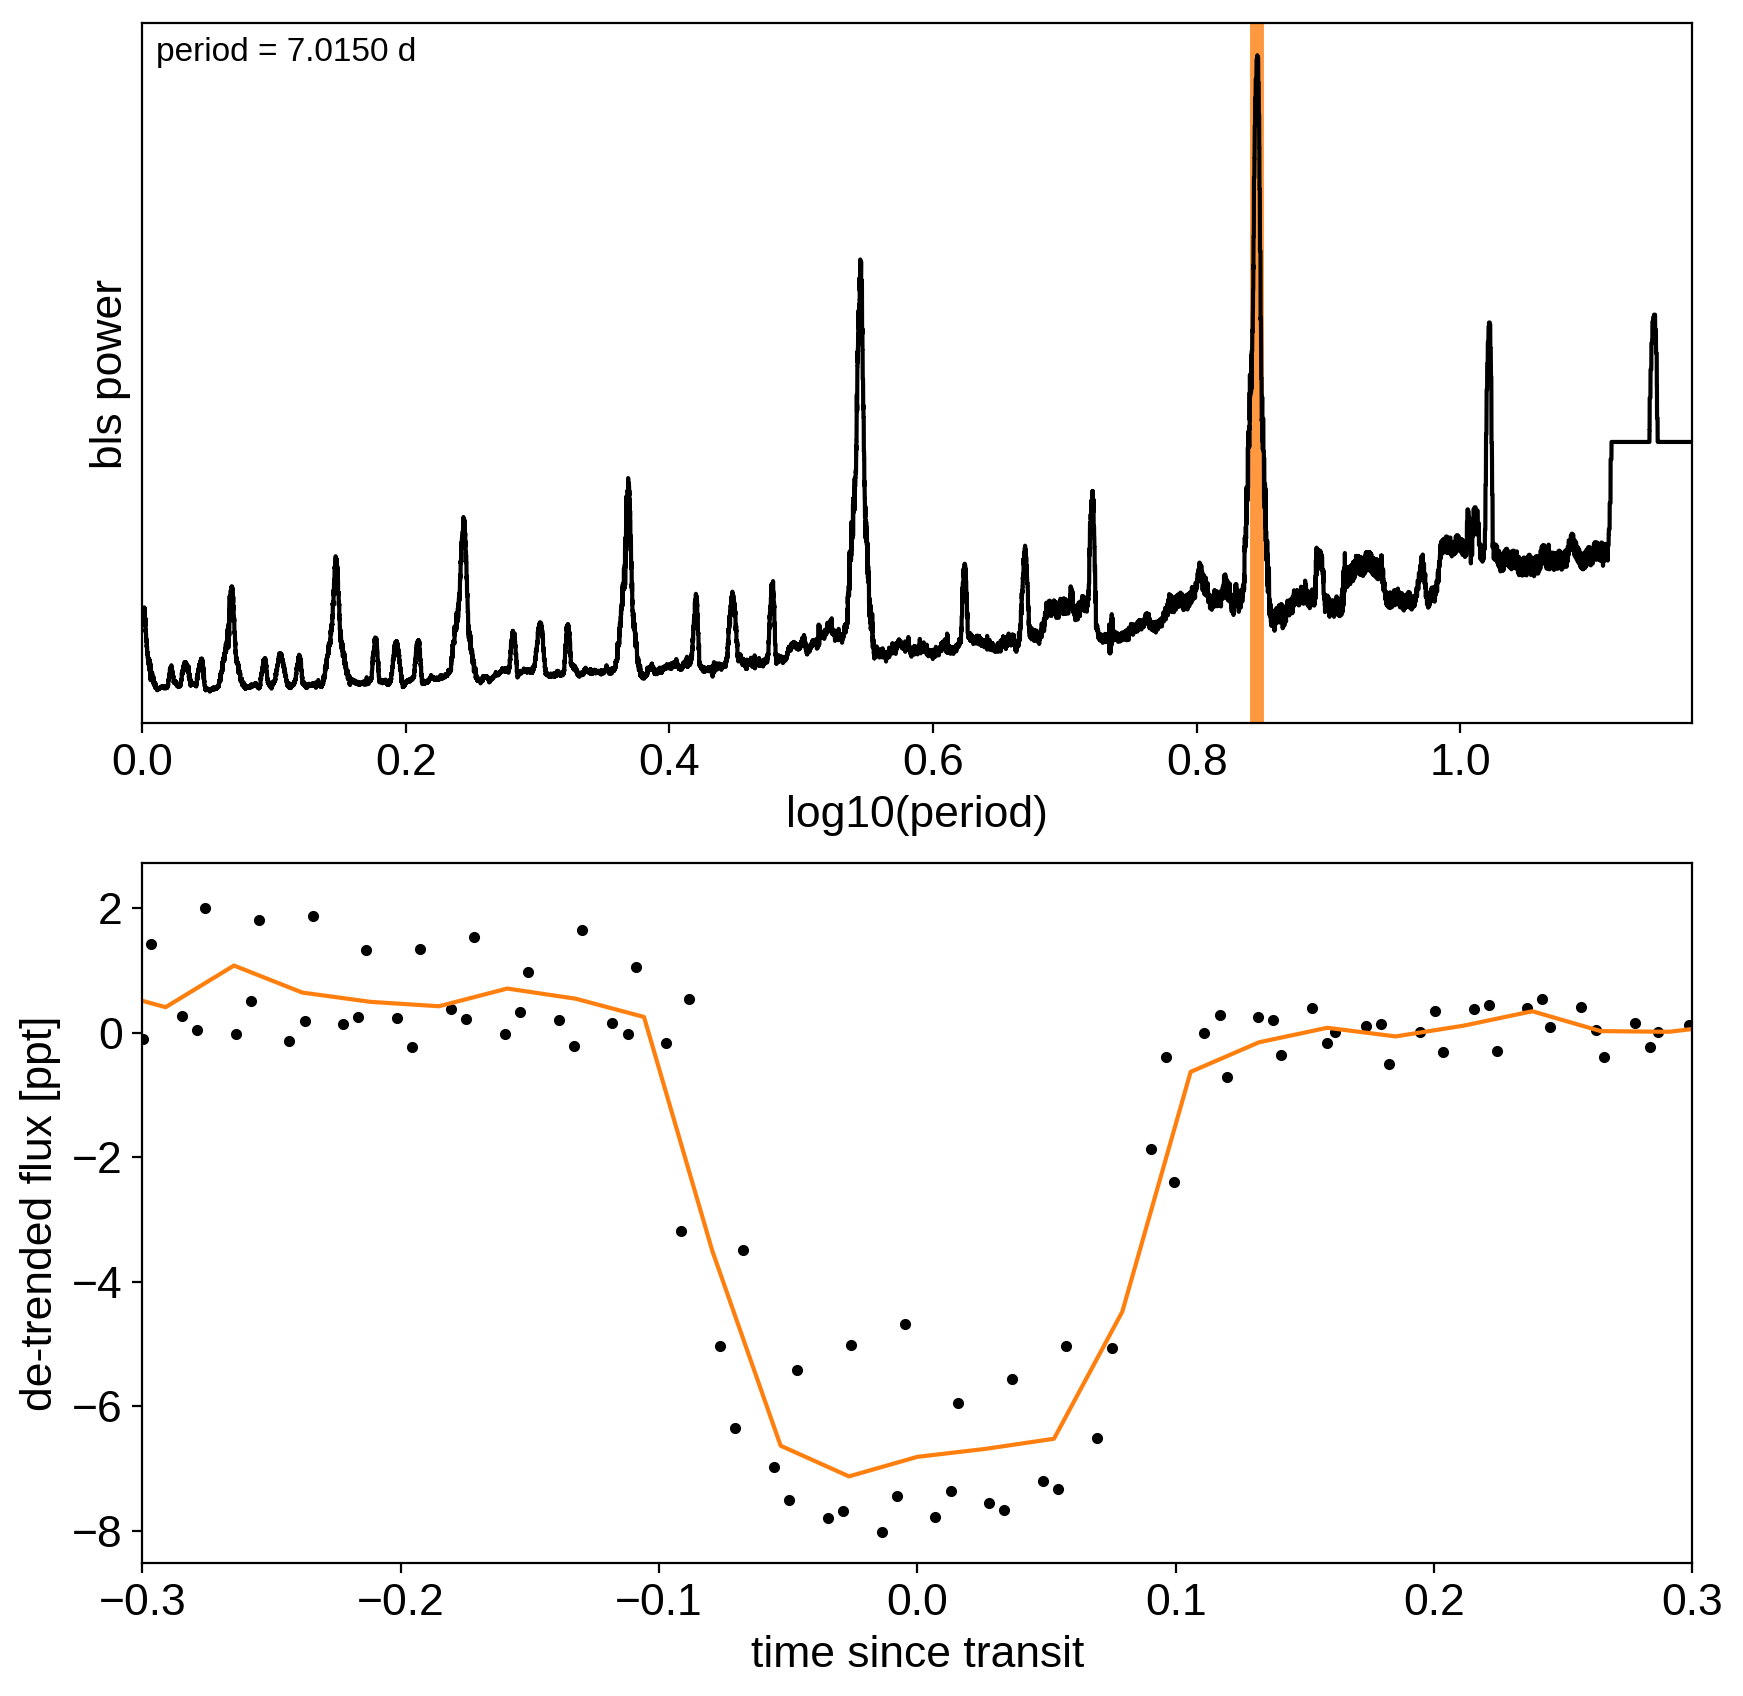

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

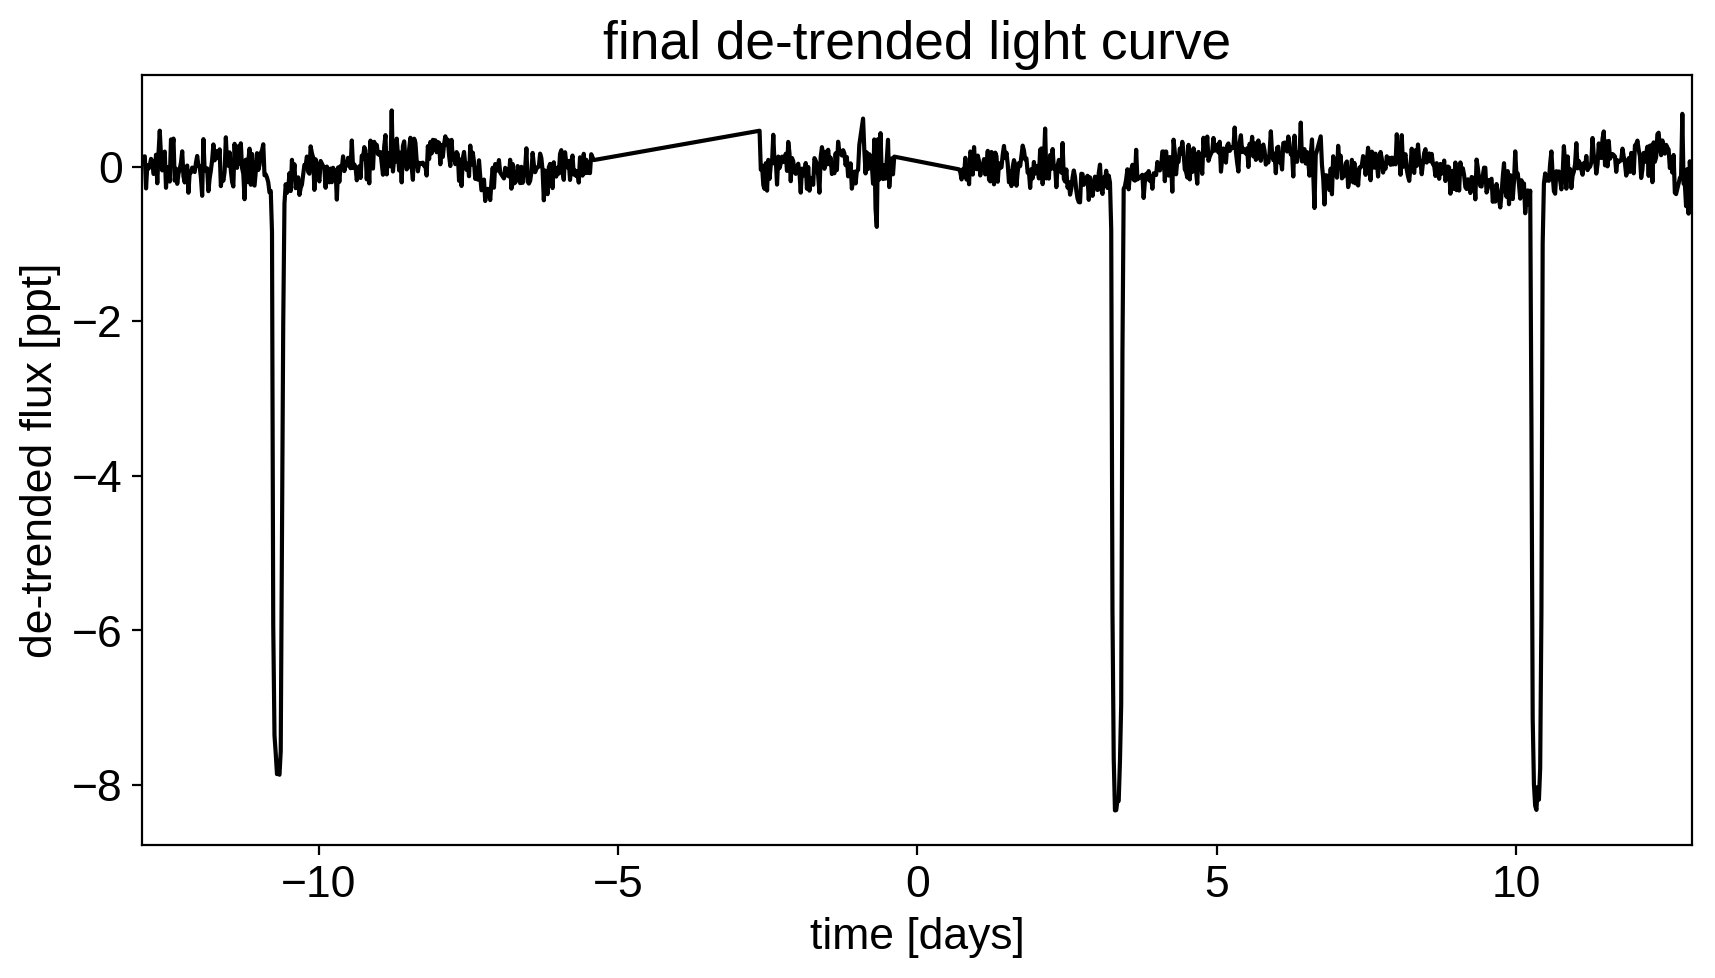

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1181.8355629633472 -> -1165.2287368771365


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1165.2287368771365 -> 83.75777489523406


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 83.75777489523406 -> 118.92458572614912


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 118.92458572614866 -> 344.380543508554


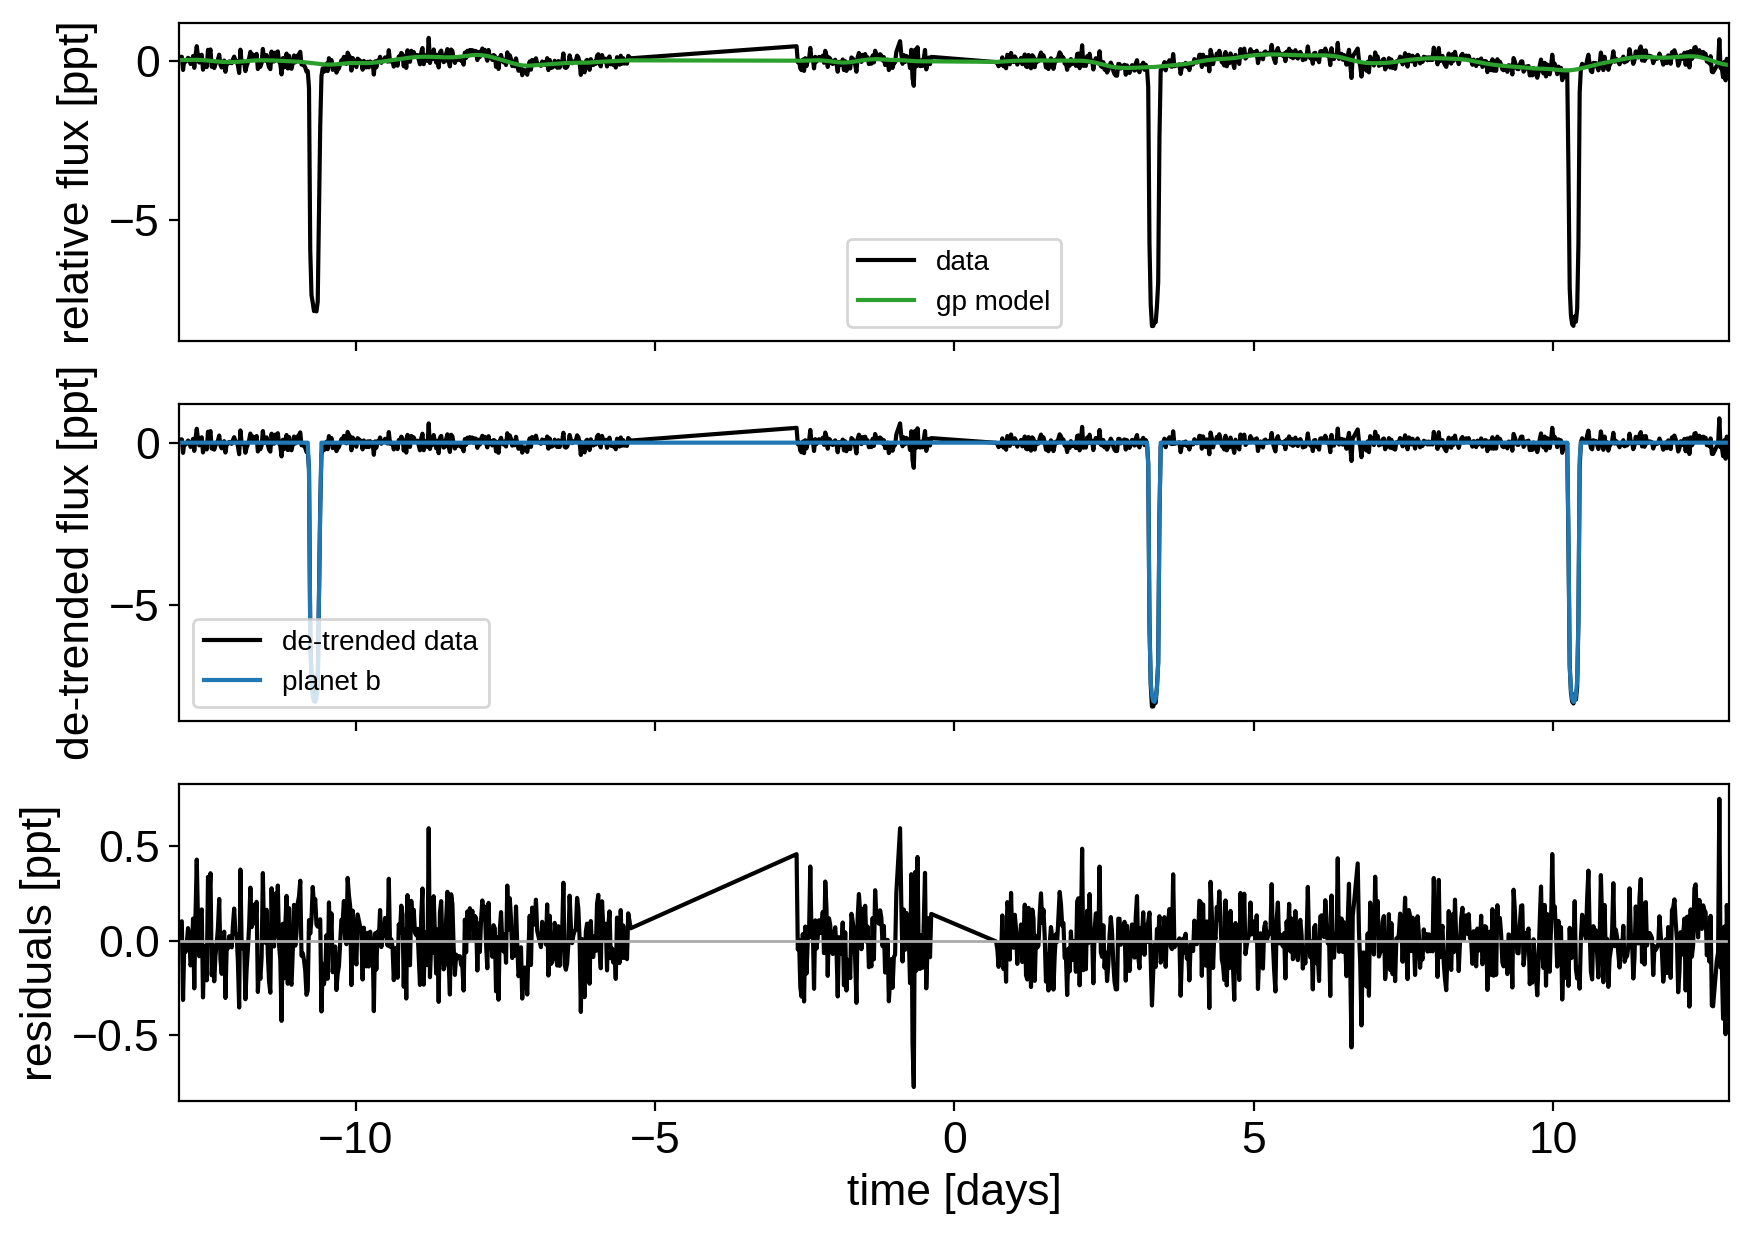

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

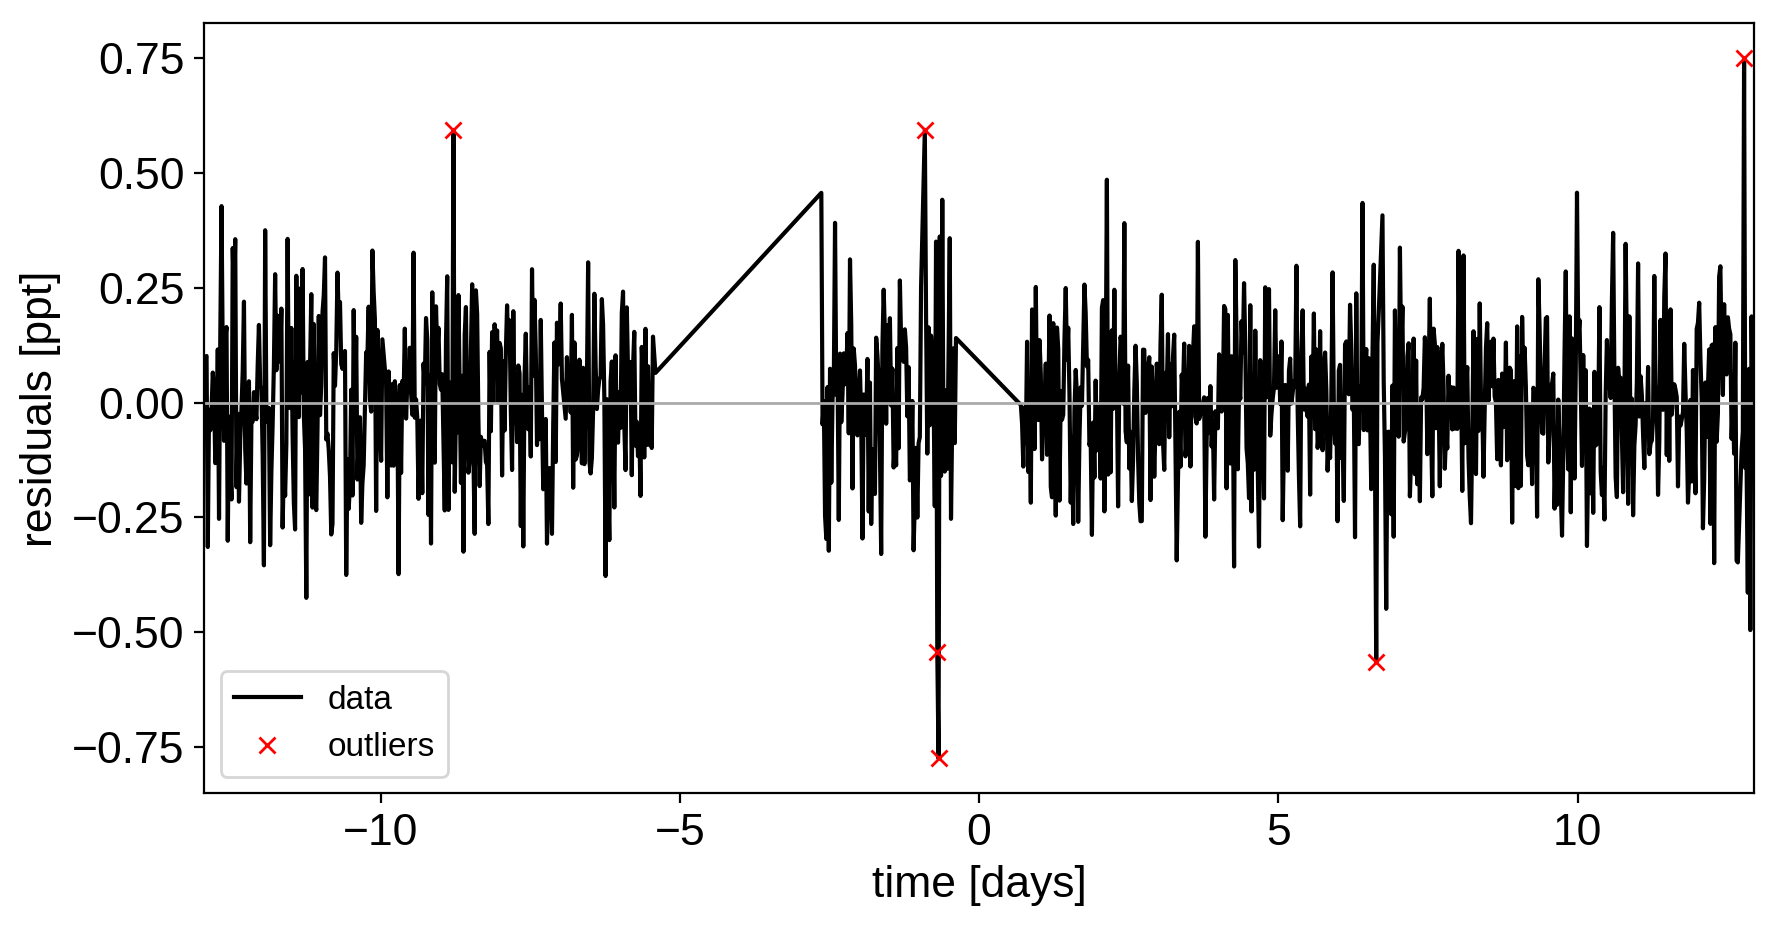

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 386.7826018983334 -> 386.7826018995779


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 386.78260189957814 -> 389.6638028023183


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 389.6638028023183 -> 389.68441488545835


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 389.68441488545835 -> 389.6948927325031


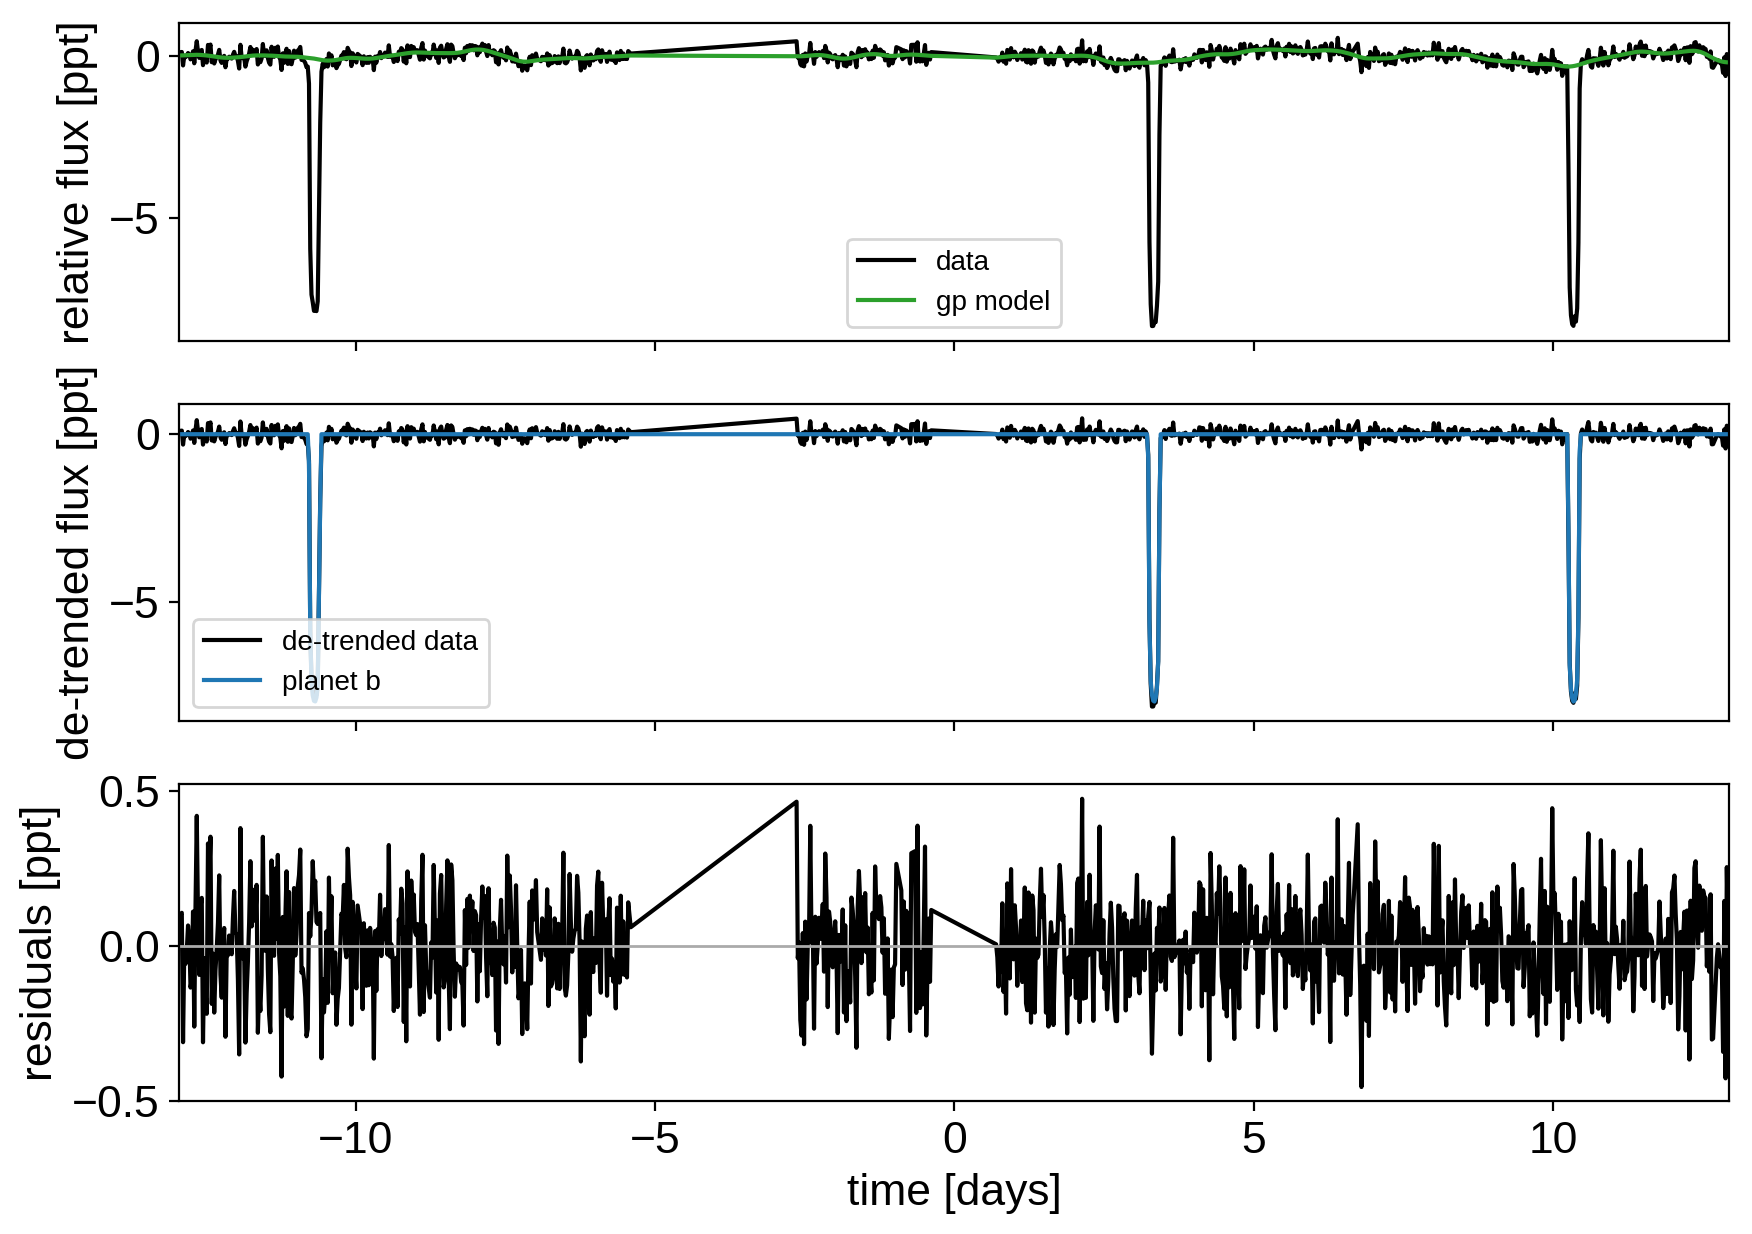

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:00<00:07, 164.86draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:38, 31.03draws/s] 

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:49, 23.80draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<00:57, 20.46draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:01<01:03, 18.63draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:01<01:06, 17.54draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<01:09, 16.84draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:02<01:10, 16.39draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:01, 18.77draws/s]

Sampling 4 chains:   4%|▍         | 52/1208 [00:02<01:10, 16.51draws/s]

Sampling 4 chains:   4%|▍         | 54/1208 [00:02<01:19, 14.45draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:02<01:10, 16.21draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:02<01:11, 16.02draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:03<01:14, 15.32draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:03<01:12, 15.90draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:03<01:03, 17.91draws/s]

Sampling 4 chains:   6%|▌         | 69/1208 [00:03<01:03, 18.04draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:03<01:11, 15.81draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:03<01:10, 16.17draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:03<01:06, 17.12draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:04<01:04, 17.59draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:04<01:12, 15.51draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:04<01:15, 14.90draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:04<01:08, 16.48draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:04<01:14, 15.11draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:04<01:08, 16.20draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:04<01:14, 15.05draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:05<01:09, 16.04draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:05<01:14, 14.87draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:05<01:03, 17.43draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:05<01:12, 15.27draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:05<01:16, 14.39draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:05<01:06, 16.52draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:06<01:15, 14.54draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:06<01:18, 13.91draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:06<01:06, 16.38draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:06<01:11, 15.31draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:06<01:03, 17.18draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:06<01:09, 15.53draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:06<01:05, 16.53draws/s]

Sampling 4 chains:  11%|█         | 127/1208 [00:07<01:11, 15.08draws/s]

Sampling 4 chains:  11%|█         | 129/1208 [00:07<01:07, 16.10draws/s]

Sampling 4 chains:  11%|█         | 131/1208 [00:07<01:11, 15.01draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:07<01:07, 15.99draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:07<01:13, 14.68draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:07<01:09, 15.33draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:07<01:11, 14.92draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:07<01:08, 15.48draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:08<01:10, 15.07draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:08<01:10, 15.06draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:08<01:09, 15.20draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:08<01:11, 14.79draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:08<01:08, 15.48draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:08<01:14, 14.11draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:09<01:15, 13.88draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:09<01:10, 14.79draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:09<01:12, 14.41draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:09<01:08, 15.34draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:09<01:11, 14.66draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:09<01:06, 15.57draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:09<01:10, 14.81draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:09<01:05, 15.78draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:10<01:10, 14.69draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:10<01:02, 16.58draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:10<01:19, 12.95draws/s]

Sampling 4 chains:  15%|█▍        | 180/1208 [00:10<01:12, 14.12draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [00:10<01:09, 14.68draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:10<01:02, 16.26draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:10<01:03, 16.11draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [00:11<01:04, 15.73draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [00:11<01:04, 15.80draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [00:11<01:05, 15.49draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [00:11<01:05, 15.57draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [00:11<01:05, 15.36draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:11<01:04, 15.56draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:11<01:05, 15.30draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:12<01:04, 15.59draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:12<01:06, 15.08draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [00:12<01:03, 15.68draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:12<01:06, 14.93draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [00:12<01:03, 15.63draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [00:12<01:06, 14.98draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [00:12<01:05, 15.17draws/s]

Sampling 4 chains:  18%|█▊        | 217/1208 [00:12<01:05, 15.05draws/s]

Sampling 4 chains:  18%|█▊        | 219/1208 [00:13<01:04, 15.39draws/s]

Sampling 4 chains:  18%|█▊        | 221/1208 [00:13<01:05, 15.09draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:13<01:03, 15.55draws/s]

Sampling 4 chains:  19%|█▊        | 225/1208 [00:13<01:05, 15.04draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [00:13<01:02, 15.63draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [00:13<01:07, 14.60draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [00:13<01:01, 15.86draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:14<01:08, 14.28draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [00:14<01:10, 13.83draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [00:14<01:00, 16.11draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [00:14<01:10, 13.70draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:14<01:09, 13.89draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [00:14<00:59, 16.24draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [00:15<01:11, 13.45draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:15<01:09, 13.77draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [00:15<00:58, 16.35draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [00:15<01:10, 13.50draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:15<01:09, 13.62draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:15<01:03, 14.89draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:16<01:06, 14.23draws/s]

Sampling 4 chains:  22%|██▏       | 266/1208 [00:16<01:00, 15.46draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:16<01:04, 14.54draws/s]

Sampling 4 chains:  22%|██▏       | 270/1208 [00:16<00:59, 15.79draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [00:16<01:03, 14.67draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [00:16<00:59, 15.81draws/s]

Sampling 4 chains:  23%|██▎       | 277/1208 [00:16<01:02, 14.97draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [00:17<01:00, 15.38draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [00:17<01:00, 15.20draws/s]

Sampling 4 chains:  23%|██▎       | 283/1208 [00:17<01:01, 15.03draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [00:17<00:59, 15.44draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [00:17<01:03, 14.60draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [00:17<00:58, 15.73draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [00:17<01:03, 14.34draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:18<00:58, 15.71draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:18<01:03, 14.35draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [00:18<01:05, 13.98draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:18<00:56, 16.07draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:18<01:02, 14.43draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [00:18<01:06, 13.60draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:19<01:04, 13.92draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [00:19<01:02, 14.28draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:19<01:01, 14.52draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [00:20<00:59, 14.80draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [00:20<00:59, 14.86draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [00:20<00:58, 15.06draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [00:20<00:57, 15.21draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [00:21<00:56, 15.32draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [00:21<00:56, 15.39draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:21<00:49, 17.56draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [00:21<00:58, 14.73draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:21<00:58, 14.55draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:21<00:53, 15.96draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:22<00:58, 14.62draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:22<00:54, 15.61draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:22<00:57, 14.77draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:22<00:55, 15.30draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:22<00:56, 14.97draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:22<00:56, 15.02draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [00:22<00:55, 15.18draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [00:23<00:56, 14.75draws/s]

Sampling 4 chains:  31%|███       | 373/1208 [00:23<00:49, 16.94draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [00:23<00:53, 15.44draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [00:23<00:50, 16.42draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [00:23<00:56, 14.75draws/s]

Sampling 4 chains:  32%|███▏      | 382/1208 [00:23<00:49, 16.63draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [00:23<00:53, 15.30draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [00:23<00:50, 16.31draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [00:24<00:54, 15.01draws/s]

Sampling 4 chains:  32%|███▏      | 390/1208 [00:24<00:50, 16.20draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [00:24<00:56, 14.51draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:24<00:58, 13.90draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [00:24<00:49, 16.32draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [00:24<00:58, 13.79draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:25<00:57, 13.99draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [00:25<00:49, 16.30draws/s]

Sampling 4 chains:  34%|███▍      | 408/1208 [00:25<01:01, 13.08draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:25<00:56, 14.03draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [00:25<00:48, 16.26draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [00:26<01:02, 12.61draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:26<00:56, 14.07draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:26<00:53, 14.61draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:26<00:53, 14.59draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:26<00:51, 15.11draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:26<00:52, 15.00draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:26<00:50, 15.37draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:26<00:51, 15.22draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:27<00:50, 15.49draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:27<00:50, 15.34draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:27<00:49, 15.49draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:27<00:49, 15.43draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:27<00:49, 15.48draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:27<00:49, 15.48draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:27<00:49, 15.47draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:28<00:48, 15.54draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:28<00:49, 15.45draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:28<00:48, 15.58draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:28<00:48, 15.43draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:28<00:48, 15.62draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:28<00:48, 15.40draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:28<00:48, 15.58draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:28<00:48, 15.39draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:29<00:48, 15.42draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:29<00:47, 15.48draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:29<00:48, 15.43draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [00:29<00:47, 15.44draws/s]

Sampling 4 chains:  39%|███▉      | 471/1208 [00:29<00:47, 15.45draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:29<00:48, 15.31draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [00:29<00:47, 15.51draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [00:29<00:47, 15.27draws/s]

Sampling 4 chains:  40%|███▉      | 479/1208 [00:30<00:47, 15.46draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:30<00:47, 15.28draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [00:30<00:46, 15.55draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [00:30<00:47, 15.26draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:30<00:46, 15.61draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [00:30<00:47, 15.25draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:30<00:45, 15.65draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [00:30<00:46, 15.24draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:31<00:45, 15.70draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [00:31<00:46, 15.21draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:31<00:45, 15.74draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:31<00:46, 15.17draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [00:31<00:44, 15.77draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [00:31<00:46, 15.13draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:31<00:44, 15.81draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:32<00:47, 14.78draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:32<00:43, 15.95draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:32<00:48, 14.44draws/s]

Sampling 4 chains:  43%|████▎     | 516/1208 [00:32<00:50, 13.82draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:32<00:42, 16.26draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:32<00:49, 13.82draws/s]

Sampling 4 chains:  43%|████▎     | 524/1208 [00:33<00:49, 13.85draws/s]

Sampling 4 chains:  44%|████▎     | 528/1208 [00:33<00:39, 17.12draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:33<00:43, 15.74draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:33<00:50, 13.49draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [00:33<00:47, 14.01draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [00:34<00:46, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [00:34<00:45, 14.68draws/s]

Sampling 4 chains:  45%|████▌     | 548/1208 [00:34<00:38, 17.23draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [00:34<00:46, 14.09draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [00:34<00:46, 14.07draws/s]

Sampling 4 chains:  46%|████▌     | 556/1208 [00:35<00:40, 16.03draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [00:35<00:45, 14.20draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [00:35<00:46, 14.03draws/s]

Sampling 4 chains:  47%|████▋     | 564/1208 [00:35<00:41, 15.54draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [00:35<00:43, 14.84draws/s]

Sampling 4 chains:  47%|████▋     | 568/1208 [00:35<00:41, 15.27draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [00:35<00:42, 15.15draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [00:36<00:42, 15.00draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [00:36<00:41, 15.45draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [00:36<00:42, 14.72draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:36<00:39, 15.77draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [00:36<00:43, 14.44draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:36<00:39, 15.99draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:36<00:44, 13.89draws/s]

Sampling 4 chains:  49%|████▊     | 588/1208 [00:37<00:44, 13.94draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:37<00:38, 16.21draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:37<00:44, 13.91draws/s]

Sampling 4 chains:  49%|████▉     | 596/1208 [00:37<00:46, 13.21draws/s]

Sampling 4 chains:  50%|████▉     | 600/1208 [00:38<00:44, 13.67draws/s]

Sampling 4 chains:  50%|█████     | 604/1208 [00:38<00:42, 14.14draws/s]

Sampling 4 chains:  50%|█████     | 608/1208 [00:38<00:41, 14.50draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [00:38<00:40, 14.81draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [00:39<00:39, 15.02draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [00:39<00:38, 15.18draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [00:39<00:38, 15.29draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [00:39<00:35, 16.35draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [00:40<00:35, 16.12draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:40<00:31, 18.31draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [00:40<00:36, 15.61draws/s]

Sampling 4 chains:  53%|█████▎    | 641/1208 [00:40<00:38, 14.72draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:40<00:34, 16.25draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:40<00:36, 15.31draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [00:41<00:35, 15.58draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [00:41<00:36, 15.24draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:41<00:36, 15.17draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:41<00:36, 15.35draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:41<00:37, 14.86draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:41<00:35, 15.54draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:41<00:37, 14.57draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [00:41<00:37, 14.72draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [00:42<00:37, 14.66draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [00:42<00:35, 15.13draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [00:42<00:37, 14.59draws/s]

Sampling 4 chains:  55%|█████▌    | 670/1208 [00:42<00:34, 15.47draws/s]

Sampling 4 chains:  56%|█████▌    | 672/1208 [00:42<00:37, 14.43draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [00:42<00:31, 17.07draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:42<00:35, 15.01draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:43<00:33, 15.88draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:43<00:36, 14.61draws/s]

Sampling 4 chains:  57%|█████▋    | 684/1208 [00:43<00:37, 13.92draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:43<00:32, 16.11draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:43<00:36, 14.04draws/s]

Sampling 4 chains:  57%|█████▋    | 692/1208 [00:43<00:36, 14.11draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [00:44<00:33, 15.49draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:44<00:37, 13.65draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [00:44<00:35, 14.50draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [00:44<00:32, 15.64draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [00:44<00:37, 13.42draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [00:44<00:33, 14.71draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [00:45<00:32, 15.11draws/s]

Sampling 4 chains:  59%|█████▉    | 712/1208 [00:45<00:32, 15.10draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [00:45<00:33, 14.89draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [00:45<00:31, 15.46draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [00:45<00:33, 14.64draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [00:45<00:30, 15.81draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [00:45<00:33, 14.38draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [00:46<00:32, 14.69draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [00:46<00:31, 15.15draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [00:46<00:31, 15.03draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [00:46<00:31, 15.30draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:46<00:31, 15.22draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [00:46<00:30, 15.36draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [00:46<00:30, 15.35draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:47<00:31, 14.81draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [00:47<00:29, 15.61draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:47<00:30, 15.03draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [00:47<00:29, 15.71draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:47<00:30, 15.09draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [00:47<00:29, 15.77draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [00:47<00:30, 14.74draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [00:47<00:28, 15.93draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [00:48<00:31, 14.43draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [00:48<00:32, 14.04draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [00:48<00:28, 15.96draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [00:48<00:31, 13.97draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [00:48<00:31, 13.95draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [00:48<00:27, 16.19draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [00:49<00:33, 13.19draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [00:49<00:30, 14.06draws/s]

Sampling 4 chains:  64%|██████▍   | 777/1208 [00:49<00:26, 16.23draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [00:49<00:33, 12.93draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:49<00:30, 14.12draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [00:49<00:28, 14.81draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [00:50<00:28, 14.75draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:50<00:28, 14.80draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [00:50<00:36, 11.37draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [00:50<00:56,  7.40draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [00:51<00:47,  8.75draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [00:51<00:57,  7.13draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:51<01:00,  6.76draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:52<01:02,  6.52draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [00:52<00:56,  7.20draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:52<00:55,  7.25draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:52<01:01,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [00:52<01:04,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:53<00:58,  6.84draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [00:53<00:55,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [00:53<01:07,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [00:54<01:39,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:54<01:23,  4.77draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:54<01:10,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [00:54<01:37,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [00:55<01:55,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [00:55<01:33,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:55<01:24,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:55<01:45,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:56<01:56,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:56<01:33,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:56<01:30,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:56<01:46,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [00:57<01:53,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:57<01:30,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:57<01:34,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [00:57<01:46,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [00:58<01:49,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [00:58<01:40,  3.78draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [00:58<01:49,  3.47draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [00:59<01:46,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [00:59<01:40,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:00<01:46,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:00<01:40,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:00<01:39,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:01<01:42,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:01<01:34,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:01<01:37,  3.77draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:02<01:38,  3.72draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:02<01:28,  4.14draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [01:02<01:35,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:03<01:34,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:03<01:22,  4.39draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:04<01:34,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:04<01:31,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:04<01:16,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [01:05<01:32,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:05<01:27,  4.07draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:05<01:07,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [01:06<02:04,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:06<01:48,  3.25draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [01:07<01:45,  3.29draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:07<01:32,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [01:08<01:35,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [01:08<01:23,  4.10draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [01:09<01:29,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:09<01:14,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [01:10<01:23,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:10<01:02,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:11<01:31,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:12<01:37,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:12<01:11,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:13<01:34,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:13<01:12,  4.44draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:14<01:32,  3.44draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:14<01:18,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:15<01:35,  3.30draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:15<01:16,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:16<01:31,  3.42draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:17<01:15,  4.09draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:17<01:28,  3.50draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:18<01:15,  4.07draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [01:18<01:25,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:19<01:14,  4.04draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:19<01:22,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:20<01:14,  4.01draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:20<01:20,  3.68draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:21<01:13,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [01:21<00:56,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:21<01:29,  3.25draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:22<01:30,  3.19draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [01:22<01:11,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:23<01:34,  3.04draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:23<01:33,  3.06draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [01:23<01:15,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:24<01:32,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [01:24<01:31,  3.10draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:24<01:13,  3.81draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [01:24<01:06,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:25<01:21,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [01:25<01:22,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:25<01:10,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [01:25<01:05,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:26<01:16,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:26<01:17,  3.53draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:26<01:10,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [01:26<01:07,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:27<01:12,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:27<01:13,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:27<01:10,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [01:27<01:08,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:28<01:09,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:28<01:10,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:28<01:10,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:29<01:10,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:29<01:06,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:29<01:07,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:29<01:11,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:30<01:12,  3.61draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:30<01:03,  4.08draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:30<01:04,  4.02draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:30<01:11,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:31<01:13,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:31<01:00,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:31<01:01,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:31<01:11,  3.53draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:32<01:15,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:32<01:03,  3.94draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:32<01:16,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:33<01:19,  3.11draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [01:33<01:04,  3.84draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:34<01:19,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:34<01:21,  3.00draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [01:34<01:03,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:35<01:21,  2.96draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:35<01:19,  3.02draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [01:35<01:02,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:36<01:22,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:36<01:17,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:36<01:03,  3.72draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:37<01:06,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:37<01:04,  3.59draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:37<00:57,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:38<01:01,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:38<00:58,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [01:38<00:52,  4.36draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:39<00:58,  3.86draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [01:39<00:54,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [01:39<00:48,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [01:39<00:41,  5.31draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:40<01:07,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [01:40<00:58,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [01:40<00:50,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [01:40<00:46,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:41<01:09,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:41<00:57,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [01:41<00:49,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [01:42<00:49,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [01:42<01:08,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:42<00:55,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [01:42<00:46,  4.51draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [01:43<00:51,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:43<01:08,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [01:43<00:53,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [01:44<00:59,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:44<01:12,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [01:44<00:55,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [01:45<01:03,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:45<01:13,  2.73draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [01:45<00:54,  3.65draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [01:46<01:06,  2.98draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [01:46<01:12,  2.72draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [01:46<00:53,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [01:47<01:08,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [01:47<01:10,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [01:48<01:01,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [01:48<01:03,  2.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [01:49<00:57,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [01:49<00:56,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [01:50<00:53,  3.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [01:50<00:51,  3.54draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [01:51<00:49,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:51<00:45,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [01:52<00:46,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [01:52<00:40,  4.27draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [01:53<00:31,  5.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [01:53<01:03,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [01:54<00:46,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [01:54<00:39,  4.27draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [01:55<01:08,  2.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [01:55<00:50,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [01:56<01:16,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [01:56<00:56,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [01:57<00:57,  2.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [01:57<00:45,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [01:58<00:49,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [01:58<00:40,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [01:59<00:44,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [01:59<00:38,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:00<00:41,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [02:00<00:36,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [02:01<00:38,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:01<00:35,  3.90draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:01<00:28,  4.76draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [02:02<00:40,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:02<00:37,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [02:02<00:30,  4.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:03<00:38,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [02:03<00:36,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [02:03<00:30,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:04<00:35,  3.60draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:04<00:35,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [02:04<00:30,  4.16draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:05<00:32,  3.81draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:05<00:33,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [02:06<00:29,  4.11draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:06<00:29,  4.06draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:06<00:24,  4.88draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [02:06<00:35,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [02:07<00:31,  3.69draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:07<00:28,  4.04draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:07<00:24,  4.79draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [02:07<00:35,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:08<00:32,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [02:08<00:27,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:08<00:23,  4.86draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [02:09<00:35,  3.15draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:09<00:32,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:09<00:25,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [02:10<00:37,  2.86draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:10<00:34,  3.09draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:10<00:26,  3.99draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:11<00:37,  2.73draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:11<00:33,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:11<00:25,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:12<00:37,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:12<00:31,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:12<00:24,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:13<00:36,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:13<00:30,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:13<00:25,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:14<00:27,  3.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:14<00:22,  4.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:14<00:20,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:15<00:23,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:15<00:19,  4.47draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [02:15<00:18,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:16<00:21,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:16<00:17,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:16<00:17,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:16<00:15,  5.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:17<00:23,  3.30draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:17<00:19,  4.09draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:17<00:18,  4.24draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:18<00:18,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:18<00:22,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:18<00:18,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:18<00:17,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:19<00:17,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:19<00:21,  3.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:19<00:18,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [02:20<00:17,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:20<00:21,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:20<00:17,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [02:21<00:17,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:21<00:20,  3.13draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [02:21<00:15,  3.92draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:21<00:14,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:22<00:15,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [02:22<00:19,  3.08draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:22<00:15,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:23<00:15,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [02:23<00:19,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:23<00:14,  3.61draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:24<00:15,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:24<00:18,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:25<00:13,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:25<00:14,  3.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:25<00:17,  2.65draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:26<00:12,  3.51draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:26<00:13,  3.34draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:26<00:16,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:27<00:12,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:27<00:10,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:27<00:13,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:28<00:10,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:28<00:08,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:28<00:08,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:29<00:11,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [02:29<00:09,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [02:29<00:08,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:29<00:07,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [02:30<00:10,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [02:30<00:07,  3.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [02:30<00:07,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:30<00:05,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [02:31<00:08,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [02:31<00:07,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [02:32<00:06,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [02:32<00:05,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [02:33<00:05,  3.56draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [02:33<00:04,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [02:34<00:04,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [02:34<00:03,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:34<00:02,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [02:35<00:03,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [02:35<00:03,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [02:35<00:02,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:36<00:03,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [02:36<00:02,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [02:37<00:03,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:38<00:02,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:38<00:02,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [02:39<00:01,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:39<00:01,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:40<00:00,  1.42draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:41<00:00,  1.24draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 69.41draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 33.40draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 24.49draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:18, 20.64draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:18, 20.08draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:18, 19.84draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:19, 18.27draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:16, 21.74draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:02<00:19, 18.51draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:02<00:21, 16.04draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:02<00:22, 15.76draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:02<00:17, 19.22draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:03<00:20, 16.74draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:03<00:21, 16.00draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:03<00:20, 16.62draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:03<00:21, 15.29draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:03<00:21, 15.65draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:03<00:21, 15.18draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:03<00:17, 18.14draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:04<00:17, 18.41draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:04<00:19, 16.05draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:04<00:21, 14.58draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:04<00:18, 17.18draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:04<00:20, 15.23draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:05<00:18, 16.27draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:05<00:19, 15.70draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:05<00:19, 15.37draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:05<00:16, 17.35draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:06<00:17, 16.44draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:06<00:16, 16.85draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:06<00:15, 17.94draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:06<00:15, 18.04draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:07<00:15, 16.93draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:07<00:15, 16.47draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:07<00:13, 18.57draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:08<00:13, 18.70draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:08<00:14, 17.58draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:08<00:12, 19.80draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:08<00:12, 18.62draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:08<00:12, 18.99draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:08<00:14, 16.28draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:08<00:13, 16.81draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:09<00:13, 17.05draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:09<00:13, 17.31draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:09<00:12, 18.61draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:09<00:11, 18.70draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:09<00:11, 18.68draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:09<00:11, 18.46draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:09<00:11, 19.29draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:10<00:13, 16.23draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:10<00:12, 16.98draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:10<00:13, 15.58draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:10<00:11, 17.83draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:10<00:12, 16.21draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:10<00:12, 16.48draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:10<00:12, 15.69draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:11<00:12, 15.87draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:11<00:11, 17.34draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:11<00:11, 16.58draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:11<00:11, 16.21draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:11<00:10, 17.67draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:11<00:09, 19.06draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:11<00:10, 17.15draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:11<00:10, 17.26draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:12<00:11, 15.86draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:12<00:10, 16.56draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:12<00:11, 15.18draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:12<00:11, 15.43draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:12<00:11, 15.09draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:12<00:11, 14.77draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:12<00:11, 15.12draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:13<00:11, 14.59draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:13<00:10, 15.29draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:13<00:11, 14.42draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:13<00:10, 15.44draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:13<00:11, 13.80draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:13<00:10, 14.87draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:13<00:09, 15.56draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:14<00:10, 15.03draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:14<00:09, 15.14draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:14<00:09, 15.28draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:14<00:09, 14.65draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:14<00:09, 15.62draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:14<00:08, 16.17draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:14<00:07, 18.47draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:15<00:09, 14.49draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:15<00:08, 15.02draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:15<00:07, 16.81draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:15<00:09, 13.16draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:15<00:08, 15.23draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:15<00:07, 15.87draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:15<00:07, 15.09draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:16<00:07, 15.33draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:16<00:06, 16.89draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:16<00:06, 17.39draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:16<00:06, 15.78draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:16<00:06, 16.45draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:16<00:06, 15.30draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:16<00:05, 17.57draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:17<00:06, 15.80draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:17<00:05, 16.51draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:17<00:06, 15.30draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:17<00:05, 16.04draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:17<00:06, 14.83draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:17<00:05, 17.30draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:17<00:05, 15.51draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:17<00:05, 16.35draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:18<00:05, 15.45draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:18<00:04, 17.52draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:18<00:04, 15.80draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:18<00:04, 16.52draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:18<00:05, 14.80draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:18<00:04, 14.75draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:19<00:04, 14.70draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:19<00:04, 14.73draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:19<00:03, 14.95draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:19<00:03, 16.04draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:20<00:02, 16.91draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:20<00:02, 16.45draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:20<00:02, 16.15draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:20<00:02, 18.03draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:20<00:02, 16.84draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:21<00:01, 17.47draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:21<00:02, 15.84draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:21<00:01, 18.07draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:21<00:01, 16.11draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:21<00:01, 16.55draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:21<00:01, 15.21draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:22<00:01, 11.84draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:22<00:01, 13.10draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:22<00:01, 11.94draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:22<00:01, 12.73draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:22<00:00, 14.69draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:22<00:00, 14.25draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:22<00:00, 15.04draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:23<00:00, 12.43draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:23<00:00,  7.22draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:24<00:00,  6.19draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:24<00:00,  3.19draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<01:03, 12.64draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:00<00:53, 14.93draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:43, 18.20draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<00:49, 15.96draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:47, 16.75draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:00<00:46, 17.21draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:49, 15.93draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:01<00:54, 14.42draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:46, 16.68draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:01<00:51, 15.12draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<00:48, 16.14draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:01<00:53, 14.44draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:02<00:55, 14.06draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:45, 16.83draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<00:51, 14.78draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:47, 15.98draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:02<00:45, 16.65draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:02<00:45, 16.86draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:02<00:41, 18.31draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:03<00:40, 18.77draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:03<00:46, 16.26draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:03<00:45, 16.63draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:48, 15.51draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:03<00:47, 15.67draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:03<00:48, 15.31draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:03<00:45, 16.22draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:03<00:44, 16.56draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:04<00:39, 18.58draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:04<00:42, 17.43draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:04<00:41, 17.48draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:04<00:36, 19.79draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:04<00:33, 21.56draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:04<00:39, 18.46draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:05<00:45, 15.70draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:05<00:45, 15.56draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:05<00:46, 15.45draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:05<00:46, 15.26draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:06<00:43, 16.16draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:06<00:40, 17.21draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:06<00:39, 17.43draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:06<00:44, 15.52draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:06<00:41, 16.57draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:06<00:46, 14.93draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:07<00:40, 16.97draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:07<00:45, 14.95draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:07<00:39, 17.36draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:07<00:47, 14.24draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:07<00:48, 13.85draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:07<00:41, 16.08draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:08<00:47, 14.06draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:39, 16.71draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:08<00:41, 15.90draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:08<00:50, 13.03draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:08<00:43, 15.04draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:08<00:44, 14.90draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:08<00:44, 14.60draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:09<00:44, 14.65draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:09<00:42, 15.18draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:09<00:36, 17.55draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:09<00:46, 13.96draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:09<00:46, 13.92draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:09<00:38, 16.54draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:10<00:47, 13.41draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:10<00:46, 13.57draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:10<00:45, 13.97draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:10<00:37, 16.62draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:11<00:44, 14.09draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:11<00:40, 15.15draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:11<00:40, 15.21draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:11<00:39, 15.62draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:11<00:38, 16.00draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:11<00:39, 15.29draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:11<00:40, 15.20draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:12<00:33, 17.93draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:12<00:36, 16.71draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:12<00:38, 15.55draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:12<00:37, 16.02draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:12<00:40, 14.63draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:12<00:37, 15.83draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:12<00:37, 15.88draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:13<00:33, 17.60draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:13<00:41, 14.15draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:13<00:36, 15.94draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:13<00:38, 15.18draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:13<00:34, 16.99draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:13<00:39, 14.68draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:14<00:35, 16.00draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:14<00:34, 16.47draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:14<00:37, 15.25draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:14<00:35, 15.83draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:14<00:37, 14.94draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:37, 15.19draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:14<00:37, 14.94draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:14<00:36, 15.20draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:15<00:35, 15.82draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:15<00:29, 18.60draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:15<00:30, 18.00draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:15<00:41, 13.21draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:15<00:34, 15.53draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:15<00:30, 17.88draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:16<00:31, 16.95draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:16<00:31, 17.13draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:16<00:35, 15.18draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:16<00:33, 15.88draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:16<00:29, 17.85draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:16<00:30, 17.39draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:17<00:32, 16.15draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:17<00:32, 15.96draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:17<00:33, 15.49draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:17<00:32, 15.71draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:17<00:28, 17.70draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:17<00:27, 18.62draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:17<00:28, 17.92draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:17<00:30, 16.68draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:18<00:30, 16.48draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:18<00:31, 15.82draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:18<00:32, 15.36draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:18<00:27, 17.97draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:18<00:28, 16.99draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:19<00:32, 14.99draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:19<00:28, 16.93draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:19<00:28, 17.06draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:19<00:31, 15.14draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:19<00:27, 17.13draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:19<00:24, 19.03draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:20<00:25, 18.20draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:20<00:27, 17.15draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:20<00:26, 17.87draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:20<00:23, 19.19draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:20<00:23, 19.29draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:20<00:24, 18.57draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:20<00:21, 20.80draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:21<00:24, 18.24draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:21<00:28, 15.50draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:21<00:26, 16.98draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:21<00:27, 16.35draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:21<00:26, 16.34draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:21<00:25, 16.93draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:21<00:26, 16.39draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:22<00:25, 17.19draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:22<00:27, 15.49draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:22<00:23, 17.88draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:22<00:30, 13.81draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:22<00:28, 14.99draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:22<00:26, 16.00draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:22<00:23, 17.49draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:23<00:26, 15.66draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:23<00:25, 16.36draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:23<00:23, 17.25draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:23<00:26, 15.67draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:23<00:24, 16.32draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:23<00:23, 17.11draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:24<00:25, 15.84draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:24<00:24, 16.18draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:24<00:25, 15.40draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:24<00:23, 16.95draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:24<00:22, 17.46draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:24<00:23, 16.16draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:24<00:21, 17.68draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:25<00:22, 16.91draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:25<00:23, 16.16draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:25<00:23, 16.02draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:25<00:24, 15.56draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:25<00:23, 15.64draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:25<00:24, 15.26draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:25<00:21, 17.31draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:26<00:22, 16.04draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:26<00:20, 17.83draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:26<00:19, 18.77draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:26<00:20, 17.44draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:26<00:19, 18.73draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:26<00:21, 16.56draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:26<00:18, 18.66draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:27<00:21, 16.39draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:27<00:22, 15.21draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:27<00:19, 17.19draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:27<00:20, 17.01draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:27<00:19, 17.26draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:27<00:19, 17.33draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:27<00:21, 15.45draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:28<00:17, 18.59draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:28<00:20, 15.71draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:28<00:20, 15.51draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:28<00:20, 15.42draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:29<00:17, 17.46draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:29<00:17, 17.44draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:29<00:19, 16.05draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:29<00:18, 16.17draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:29<00:19, 15.52draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:29<00:19, 15.27draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:29<00:19, 15.43draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:30<00:20, 14.37draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:30<00:20, 14.58draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:30<00:19, 14.67draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:30<00:16, 17.33draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:30<00:17, 16.37draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:31<00:17, 16.17draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:31<00:17, 15.81draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:31<00:15, 17.35draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:31<00:14, 18.68draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:31<00:14, 18.52draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:31<00:14, 18.75draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:31<00:14, 17.81draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:32<00:15, 16.64draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:32<00:12, 20.05draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:32<00:13, 19.12draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:32<00:14, 17.89draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:32<00:12, 20.00draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:32<00:13, 17.92draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:33<00:13, 17.65draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:33<00:13, 18.07draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:33<00:12, 18.54draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:33<00:11, 20.04draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:33<00:12, 18.27draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:34<00:14, 15.76draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:34<00:11, 19.04draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:34<00:11, 18.79draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:34<00:10, 20.66draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:34<00:11, 18.83draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:34<00:12, 16.79draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:34<00:12, 16.30draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:35<00:11, 18.56draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:35<00:12, 16.72draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:35<00:13, 14.99draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:35<00:11, 16.79draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:35<00:09, 20.08draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:36<00:11, 16.51draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:36<00:09, 19.77draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:36<00:10, 17.25draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:36<00:10, 16.40draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:36<00:10, 16.48draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:37<00:10, 15.97draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:37<00:10, 16.66draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:37<00:09, 17.08draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:37<00:08, 19.01draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:37<00:08, 18.09draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:38<00:09, 16.58draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:38<00:08, 18.46draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:38<00:10, 14.09draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:38<00:09, 14.75draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:38<00:09, 15.82draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:38<00:09, 14.68draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:38<00:09, 15.29draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:39<00:09, 14.89draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:39<00:08, 15.09draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:39<00:08, 15.08draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:39<00:08, 15.19draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:39<00:08, 15.20draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:39<00:07, 16.00draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:39<00:07, 16.66draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:40<00:07, 16.94draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:40<00:07, 15.72draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:40<00:07, 15.71draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:40<00:06, 17.23draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:40<00:05, 19.36draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:40<00:05, 18.29draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:40<00:06, 16.02draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:41<00:06, 16.96draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:41<00:06, 15.33draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:41<00:06, 16.37draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:41<00:06, 15.02draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:41<00:05, 16.14draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:41<00:05, 17.85draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:41<00:05, 16.32draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:41<00:05, 16.66draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:42<00:04, 17.25draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:42<00:04, 17.55draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:42<00:04, 16.78draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:42<00:04, 17.92draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:42<00:04, 17.38draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:42<00:03, 20.33draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:43<00:03, 18.61draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:43<00:03, 18.34draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:43<00:02, 21.70draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:43<00:03, 18.25draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:43<00:02, 20.18draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:43<00:02, 18.17draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:44<00:03, 15.71draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:44<00:02, 16.33draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:44<00:02, 18.77draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:44<00:02, 16.88draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:44<00:02, 17.44draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:45<00:01, 16.44draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:45<00:01, 14.26draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:45<00:01, 14.35draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:45<00:01, 14.40draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:46<00:01, 11.18draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:46<00:01, 11.23draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:46<00:00, 13.23draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:46<00:00, 10.79draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:46<00:00, 11.79draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:47<00:00, 10.08draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:47<00:00,  8.85draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:48<00:00,  5.15draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:48<00:00,  4.61draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:49<00:00,  2.90draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:28, 55.51draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<00:52, 30.64draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:00<01:07, 23.54draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<01:18, 20.25draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<01:25, 18.46draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:01<01:16, 20.66draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:01<01:31, 17.26draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:01<01:27, 17.93draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:01<01:41, 15.44draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:01<01:32, 16.99draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:02<01:52, 13.96draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:02<01:46, 14.66draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:02<01:35, 16.31draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:02<01:30, 17.26draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:02<01:22, 18.90draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:02<01:25, 18.21draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:03<01:25, 18.14draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:03<01:23, 18.61draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:03<01:39, 15.57draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:03<01:34, 16.38draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:03<01:36, 16.00draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:03<01:22, 18.65draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:04<01:26, 17.74draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:04<01:36, 15.89draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:04<01:22, 18.44draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:04<01:39, 15.33draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:04<01:32, 16.41draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:05<01:31, 16.62draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:05<01:34, 16.00draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:05<01:27, 17.28draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:05<01:18, 19.32draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:05<01:30, 16.55draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:06<01:43, 14.50draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:06<01:27, 17.19draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:06<01:33, 16.03draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:06<01:49, 13.64draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:06<01:34, 15.81draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:06<01:37, 15.20draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:06<01:32, 16.05draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:07<01:35, 15.54draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:07<01:27, 16.98draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:07<01:16, 19.34draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:07<01:19, 18.62draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:07<01:31, 16.14draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:07<01:26, 16.90draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:07<01:21, 17.99draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:08<01:24, 17.35draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:08<01:25, 17.12draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:08<01:19, 18.25draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:08<01:17, 18.80draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:08<01:20, 17.95draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:08<01:12, 20.11draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:09<01:19, 18.15draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:09<01:25, 16.81draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:09<01:26, 16.60draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:09<01:33, 15.44draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:09<01:29, 16.02draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:09<01:39, 14.43draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:09<01:34, 15.19draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:10<01:42, 13.97draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:10<01:30, 15.78draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:10<01:33, 15.20draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:10<01:31, 15.59draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:10<01:37, 14.51draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:10<01:22, 17.23draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:11<01:30, 15.58draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:11<01:28, 15.91draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:11<01:39, 14.19draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:11<01:31, 15.34draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:11<01:28, 15.88draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:11<01:35, 14.64draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:11<01:29, 15.69draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:11<01:26, 16.21draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:12<01:30, 15.42draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:12<01:22, 17.01draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:12<01:25, 16.28draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:12<01:28, 15.64draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:12<01:23, 16.65draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:12<01:32, 14.91draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:13<01:26, 15.97draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:13<01:17, 17.87draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:13<01:40, 13.68draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:13<01:27, 15.70draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:13<01:32, 14.86draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:13<01:28, 15.55draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:13<01:31, 14.91draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:14<01:20, 16.95draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:14<01:25, 15.97draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:14<01:16, 17.73draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:14<01:22, 16.39draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:14<01:16, 17.81draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:14<01:20, 16.89draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:15<01:20, 16.68draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:15<01:19, 16.82draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:15<01:15, 17.77draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:15<01:06, 20.02draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:15<01:16, 17.45draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:15<01:07, 19.56draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:16<01:17, 17.22draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:16<01:37, 13.63draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:16<01:34, 14.01draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:16<01:26, 15.31draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:17<01:24, 15.62draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:17<01:20, 16.39draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:17<01:09, 18.94draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:17<01:11, 18.28draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:17<01:32, 14.11draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:17<01:23, 15.53draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:17<01:15, 17.15draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:18<01:10, 18.42draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:18<01:08, 18.73draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:18<01:14, 17.27draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:18<01:17, 16.70draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:18<01:16, 16.89draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:18<01:23, 15.43draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:18<01:19, 16.12draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:19<01:25, 14.96draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:19<01:13, 17.28draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:19<01:28, 14.38draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:19<01:20, 15.82draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:19<01:14, 16.99draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:19<01:16, 16.60draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:20<01:06, 18.87draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:20<01:11, 17.72draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:20<01:02, 20.03draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:20<01:04, 19.29draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:20<01:14, 16.70draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:20<01:10, 17.58draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:21<01:17, 16.06draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:21<01:19, 15.55draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:21<01:22, 15.08draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:21<01:14, 16.63draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:21<01:16, 16.19draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:21<01:20, 15.35draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:21<01:18, 15.62draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [00:22<01:23, 14.72draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:22<01:19, 15.40draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:22<01:24, 14.50draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:22<01:19, 15.33draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:22<01:20, 15.21draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:22<01:18, 15.45draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:22<01:13, 16.55draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:23<01:10, 17.09draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:23<01:13, 16.38draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:23<01:07, 17.97draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:23<01:16, 15.76draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:23<01:11, 16.80draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:23<01:18, 15.32draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:23<01:13, 16.22draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:23<01:11, 16.63draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:24<01:06, 17.90draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:24<01:11, 16.68draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:24<01:14, 16.03draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:24<01:15, 15.68draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:24<01:18, 15.19draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:24<01:17, 15.25draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:24<01:10, 16.64draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:25<01:14, 15.81draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:25<01:14, 15.81draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:25<01:19, 14.85draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:25<01:14, 15.74draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:25<01:21, 14.40draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:25<01:14, 15.61draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:25<01:22, 14.14draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:26<01:17, 14.92draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:26<01:09, 16.59draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:26<01:14, 15.60draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:26<01:07, 17.08draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:26<01:16, 15.03draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [00:26<01:18, 14.61draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:27<01:11, 15.99draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:27<01:19, 14.42draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:27<01:20, 14.09draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:27<01:12, 15.67draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [00:27<01:13, 15.44draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:27<01:06, 17.03draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:28<01:14, 15.21draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:28<01:09, 16.25draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:28<01:15, 14.85draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:28<01:10, 15.88draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:28<01:09, 16.12draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:28<01:16, 14.65draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:29<01:11, 15.56draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:29<01:12, 15.25draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:29<01:03, 17.43draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:29<01:04, 17.05draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:29<01:09, 15.96draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:29<01:02, 17.57draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:30<01:07, 16.27draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:30<01:08, 16.08draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:30<01:10, 15.62draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:30<01:10, 15.48draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [00:30<01:10, 15.38draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [00:30<01:11, 15.18draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [00:30<01:10, 15.31draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [00:30<01:11, 15.24draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:31<01:03, 16.89draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:31<01:03, 17.09draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [00:31<01:01, 17.56draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:31<00:56, 19.08draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:31<00:53, 19.87draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:31<00:57, 18.65draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:31<01:07, 15.75draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:32<00:59, 17.88draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [00:32<01:11, 14.81draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:32<01:14, 14.15draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:32<01:05, 16.13draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:32<01:08, 15.39draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:32<01:08, 15.36draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:33<01:09, 15.08draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:33<01:09, 14.99draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:33<01:09, 14.97draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:33<01:10, 14.73draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:33<01:09, 14.99draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:33<01:11, 14.57draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:33<01:08, 15.08draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:34<01:01, 16.71draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:34<00:57, 17.81draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:34<00:53, 19.32draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:34<00:58, 17.60draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:34<01:00, 16.76draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:34<00:52, 19.19draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:35<01:00, 16.87draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [00:35<01:11, 14.09draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:35<00:59, 16.87draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:35<01:02, 16.01draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [00:35<01:09, 14.37draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:36<01:04, 15.41draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:36<00:55, 17.82draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:36<00:55, 17.77draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:36<01:00, 16.30draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:36<00:56, 17.32draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:36<00:54, 17.97draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:37<01:02, 15.66draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:37<00:59, 16.35draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:37<01:03, 15.30draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [00:37<00:54, 17.83draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:37<01:04, 14.99draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:37<01:05, 14.66draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [00:38<00:59, 16.11draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:38<01:06, 14.54draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [00:38<01:00, 15.80draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [00:38<00:59, 16.09draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:38<01:03, 15.11draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:38<01:00, 15.73draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:38<01:04, 14.75draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [00:39<01:00, 15.60draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:39<01:06, 14.14draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [00:39<00:58, 16.07draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:39<01:12, 12.94draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [00:39<01:10, 13.36draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:40<01:07, 13.80draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [00:40<00:56, 16.38draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [00:40<01:01, 15.10draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [00:40<00:57, 16.16draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:40<01:02, 14.71draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [00:40<00:58, 15.86draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [00:40<00:59, 15.59draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [00:41<00:57, 16.01draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [00:41<00:55, 16.54draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:41<01:01, 14.96draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [00:41<00:56, 16.17draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:41<01:01, 14.71draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:41<01:01, 14.81draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:42<01:00, 14.85draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [00:42<00:51, 17.30draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:42<00:50, 17.84draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [00:42<00:48, 18.38draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:42<00:48, 18.38draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:42<00:40, 21.65draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:43<00:44, 19.84draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [00:43<00:45, 19.32draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:43<00:48, 18.05draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [00:43<00:57, 15.33draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [00:43<00:57, 15.26draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [00:44<00:56, 15.22draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [00:44<00:46, 18.68draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [00:44<00:55, 15.60draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [00:44<01:02, 13.78draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [00:44<01:00, 14.17draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [00:45<00:51, 16.56draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [00:45<01:01, 13.73draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:45<00:59, 14.12draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [00:45<00:58, 14.38draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:46<00:57, 14.58draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [00:46<00:48, 17.25draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [00:46<00:56, 14.61draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:46<00:51, 16.12draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [00:46<00:53, 15.46draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:46<00:52, 15.59draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [00:46<00:49, 16.54draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [00:47<00:51, 15.96draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [00:47<00:55, 14.60draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [00:47<00:48, 16.87draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:47<00:53, 15.19draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [00:47<00:49, 16.27draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:47<00:43, 18.46draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [00:48<00:46, 17.24draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [00:48<00:43, 18.40draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [00:48<00:46, 17.04draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:48<00:45, 17.42draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:48<00:53, 14.72draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:48<01:01, 12.83draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [00:49<00:51, 15.22draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:49<00:56, 13.81draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [00:49<00:54, 14.24draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [00:49<00:48, 15.97draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [00:49<00:49, 15.79draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [00:49<00:49, 15.50draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [00:49<00:47, 16.25draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:50<00:51, 14.97draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [00:50<00:51, 14.97draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [00:50<01:00, 12.57draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [00:50<00:50, 14.93draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [00:50<00:52, 14.33draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [00:50<00:49, 15.14draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [00:51<00:51, 14.55draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [00:51<00:44, 16.71draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [00:51<00:47, 15.62draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [00:51<00:47, 15.89draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [00:51<00:48, 15.23draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [00:51<00:47, 15.50draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [00:51<00:55, 13.47draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [00:52<01:02, 11.91draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [00:52<01:02, 11.71draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:52<01:03, 11.57draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [00:52<00:58, 12.55draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:52<01:02, 11.74draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:53<01:01, 11.80draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:53<00:55, 13.07draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [00:53<00:46, 15.65draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:53<01:01, 11.63draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [00:53<01:00, 11.94draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:53<00:54, 13.12draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [00:54<00:54, 13.16draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [00:54<00:50, 13.97draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [00:54<00:52, 13.57draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [00:54<00:57, 12.39draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:54<01:00, 11.62draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [00:54<00:56, 12.44draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [00:55<00:53, 13.08draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [00:55<00:44, 15.83draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [00:55<00:44, 15.52draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [00:55<00:43, 16.00draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [00:55<00:37, 18.10draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:56<00:59, 11.53draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [00:56<01:01, 11.09draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [00:56<01:07, 10.04draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [00:56<01:14,  9.10draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:57<01:08,  9.77draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [00:57<01:06, 10.03draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [00:57<01:04, 10.36draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [00:57<00:57, 11.59draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [00:58<00:57, 11.56draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [00:58<01:04, 10.20draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [00:58<00:54, 12.12draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [00:58<01:00, 10.88draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [00:58<00:59, 11.00draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [00:58<00:49, 13.09draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [00:59<01:00, 10.70draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [00:59<01:03, 10.15draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [00:59<01:02, 10.34draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [00:59<00:51, 12.42draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [00:59<00:52, 12.13draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:00<00:51, 12.44draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:00<00:44, 14.30draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:00<00:43, 14.50draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:00<00:54, 11.48draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:00<00:50, 12.36draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:01<00:44, 14.07draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:01<00:43, 14.18draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [01:01<00:42, 14.57draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:01<00:42, 14.68draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [01:01<00:41, 14.76draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:01<00:43, 14.23draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [01:01<00:37, 16.48draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:02<00:40, 15.03draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:02<00:38, 15.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:02<00:41, 14.42draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:02<00:37, 16.10draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:02<00:37, 15.84draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [01:02<00:38, 15.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [01:02<00:38, 15.54draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [01:03<00:39, 15.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [01:03<00:35, 16.60draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:03<00:46, 12.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:03<00:45, 12.90draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [01:03<00:43, 13.36draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [01:03<00:45, 12.75draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [01:04<00:51, 11.24draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:04<00:47, 12.21draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [01:04<00:49, 11.57draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [01:04<00:53, 10.80draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [01:04<00:47, 12.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [01:05<00:51, 11.01draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [01:05<00:47, 11.99draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [01:05<00:42, 13.20draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [01:05<00:49, 11.48draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [01:05<00:45, 12.37draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:06<00:42, 13.09draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:06<00:34, 15.79draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:06<00:39, 14.06draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:06<00:40, 13.58draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:06<00:36, 14.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [01:06<00:37, 14.47draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:07<00:34, 15.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:07<00:29, 17.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [01:07<00:33, 15.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [01:07<00:31, 16.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [01:07<00:31, 16.97draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [01:07<00:42, 12.26draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [01:08<00:41, 12.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:08<00:38, 13.62draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:08<00:34, 15.06draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:08<00:33, 15.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [01:08<00:30, 16.72draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:08<00:30, 16.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:08<00:41, 12.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:09<00:40, 12.53draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [01:09<00:41, 12.33draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:09<00:46, 10.95draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:09<00:42, 11.79draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [01:09<00:43, 11.53draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [01:10<00:41, 12.13draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:10<00:36, 13.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:10<00:33, 14.78draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [01:10<00:38, 12.66draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [01:10<00:39, 12.49draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [01:10<00:32, 14.86draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:10<00:35, 13.51draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [01:11<00:34, 13.99draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [01:11<00:33, 14.21draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:11<00:32, 14.66draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:11<00:32, 14.54draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:11<00:39, 12.12draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [01:11<00:35, 13.43draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [01:12<00:34, 13.77draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [01:12<00:33, 14.11draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [01:12<00:31, 14.81draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [01:12<00:28, 16.41draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [01:12<00:28, 15.95draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [01:12<00:31, 14.34draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [01:13<00:31, 14.41draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [01:13<00:26, 17.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:13<00:27, 15.97draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:13<00:27, 15.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [01:13<00:29, 15.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:13<00:28, 15.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:13<00:28, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:14<00:31, 13.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:14<00:33, 12.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:14<00:31, 13.42draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [01:15<00:32, 12.90draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [01:15<00:27, 15.26draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [01:15<00:31, 13.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:15<00:30, 13.67draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [01:15<00:26, 15.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [01:15<00:30, 13.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:16<00:31, 13.13draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [01:16<00:26, 15.43draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [01:16<00:28, 14.27draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [01:16<00:26, 15.25draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [01:16<00:26, 15.03draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:16<00:23, 16.57draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [01:16<00:24, 16.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [01:17<00:27, 14.48draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [01:17<00:27, 14.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [01:17<00:27, 13.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [01:17<00:30, 12.67draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [01:17<00:28, 13.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [01:17<00:28, 13.58draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:17<00:26, 14.56draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:18<00:32, 11.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [01:18<00:28, 12.96draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [01:18<00:26, 14.33draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [01:18<00:25, 14.58draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:18<00:25, 14.49draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:18<00:24, 15.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [01:19<00:26, 13.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:19<00:25, 14.21draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [01:19<00:24, 14.73draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [01:19<00:22, 15.83draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:19<00:23, 14.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:19<00:22, 15.55draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [01:19<00:23, 14.76draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [01:20<00:22, 15.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [01:20<00:23, 14.69draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [01:20<00:22, 15.47draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [01:20<00:21, 15.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [01:20<00:18, 18.20draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [01:20<00:21, 16.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [01:20<00:18, 18.48draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [01:21<00:20, 16.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:21<00:21, 15.21draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [01:21<00:21, 15.23draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:21<00:21, 15.23draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [01:21<00:19, 16.12draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [01:22<00:18, 16.94draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [01:22<00:21, 14.43draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [01:22<00:19, 16.03draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [01:22<00:19, 15.96draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [01:22<00:20, 15.16draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:22<00:19, 15.63draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [01:23<00:19, 15.41draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:23<00:21, 13.85draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [01:23<00:22, 12.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [01:23<00:18, 15.72draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [01:24<00:24, 11.92draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:24<00:24, 11.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [01:24<00:26, 10.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [01:24<00:22, 12.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [01:24<00:23, 12.08draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [01:24<00:19, 14.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [01:24<00:18, 14.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [01:25<00:20, 13.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [01:25<00:21, 12.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [01:25<00:19, 13.73draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:25<00:19, 13.26draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [01:25<00:19, 13.61draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:26<00:17, 14.98draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:26<00:18, 13.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [01:26<00:21, 11.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [01:26<00:18, 13.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [01:26<00:19, 12.95draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:27<00:18, 13.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [01:27<00:16, 14.74draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [01:27<00:16, 14.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [01:27<00:15, 15.73draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [01:27<00:15, 15.36draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [01:27<00:14, 16.43draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [01:27<00:14, 16.47draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [01:27<00:15, 14.77draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [01:28<00:14, 15.78draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [01:28<00:14, 15.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [01:28<00:20, 11.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:28<00:18, 12.39draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [01:28<00:17, 12.67draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [01:28<00:20, 10.73draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:29<00:19, 11.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [01:29<00:16, 12.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [01:29<00:16, 12.69draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [01:29<00:15, 14.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [01:29<00:15, 13.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [01:29<00:12, 15.98draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [01:30<00:13, 15.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [01:30<00:17, 11.81draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [01:30<00:14, 13.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [01:30<00:14, 13.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [01:30<00:15, 12.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [01:30<00:14, 13.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [01:31<00:13, 13.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [01:31<00:13, 14.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [01:31<00:12, 14.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [01:31<00:13, 13.23draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [01:31<00:12, 13.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [01:31<00:13, 13.50draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [01:32<00:14, 11.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [01:32<00:12, 13.39draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [01:32<00:11, 14.65draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [01:32<00:12, 13.44draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [01:32<00:11, 14.69draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [01:32<00:11, 14.83draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [01:33<00:11, 14.72draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [01:33<00:10, 14.70draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:33<00:10, 14.96draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [01:33<00:10, 14.58draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [01:33<00:10, 15.11draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [01:33<00:10, 14.82draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [01:33<00:09, 15.19draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [01:33<00:09, 14.95draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [01:34<00:09, 15.20draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [01:34<00:09, 15.02draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [01:34<00:09, 15.20draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [01:34<00:08, 16.05draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [01:34<00:08, 16.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [01:34<00:08, 16.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [01:34<00:08, 15.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [01:34<00:07, 16.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [01:35<00:07, 17.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [01:35<00:07, 16.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [01:35<00:07, 16.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [01:35<00:07, 15.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [01:35<00:07, 15.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [01:35<00:08, 13.94draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [01:36<00:09, 12.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [01:36<00:07, 14.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [01:36<00:08, 12.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [01:36<00:08, 13.13draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [01:36<00:06, 15.29draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [01:36<00:07, 14.71draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [01:36<00:06, 15.46draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [01:37<00:07, 12.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [01:37<00:06, 14.71draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [01:37<00:06, 14.81draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [01:37<00:05, 16.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [01:37<00:06, 14.42draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [01:37<00:05, 16.06draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [01:38<00:05, 15.43draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [01:38<00:05, 15.13draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [01:38<00:06, 13.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [01:38<00:06, 12.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [01:38<00:05, 12.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [01:38<00:05, 13.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [01:39<00:04, 15.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [01:39<00:04, 15.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [01:39<00:03, 16.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [01:39<00:04, 13.35draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:39<00:04, 13.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [01:40<00:04, 12.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:40<00:04, 12.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [01:40<00:04, 10.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [01:40<00:05,  9.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [01:41<00:04, 10.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [01:41<00:06,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [01:41<00:05,  8.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [01:42<00:06,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [01:42<00:05,  6.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [01:42<00:04,  7.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [01:42<00:03,  9.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [01:43<00:04,  8.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [01:43<00:04,  7.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [01:43<00:03,  7.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [01:43<00:03,  8.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:43<00:03,  9.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [01:43<00:02,  9.83draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:43<00:02, 10.57draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [01:44<00:01, 11.50draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [01:44<00:01, 10.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [01:44<00:01,  9.91draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [01:44<00:01,  8.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:45<00:02,  6.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:45<00:01,  6.80draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:45<00:01,  8.13draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [01:45<00:01,  7.70draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:45<00:01,  7.87draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [01:46<00:01,  5.92draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:46<00:00,  6.29draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [01:46<00:00,  6.66draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:46<00:00,  6.89draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [01:46<00:00,  5.55draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [01:46<00:00,  6.02draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:47<00:00, 15.03draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<00:48, 65.93draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<01:51, 28.67draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<02:06, 25.21draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<02:45, 19.34draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:00<02:45, 19.32draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:00<03:10, 16.72draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<03:04, 17.32draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:01<03:25, 15.47draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:01<03:14, 16.37draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:01<03:30, 15.14draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:01<03:18, 16.03draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<03:21, 15.74draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:01<03:45, 14.10draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:01<03:09, 16.76draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:02<03:14, 16.27draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:02<03:07, 16.84draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:02<03:00, 17.47draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:02<02:58, 17.72draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:02<03:11, 16.51draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:03<02:47, 18.81draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:03<03:06, 16.83draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:03<03:07, 16.76draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:03<02:52, 18.21draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:03<03:08, 16.63draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:03<02:47, 18.73draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:04<03:04, 16.97draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:04<03:49, 13.61draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:04<03:15, 16.01draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:04<03:17, 15.80draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:04<02:49, 18.38draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:05<03:15, 15.94draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:05<03:19, 15.62draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:05<03:22, 15.36draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:05<02:56, 17.65draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:05<03:31, 14.68draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:06<03:41, 14.01draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:06<03:15, 15.83draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:06<03:34, 14.42draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:06<03:27, 14.88draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:06<03:32, 14.57draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:06<03:20, 15.43draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:06<03:34, 14.40draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:07<03:22, 15.28draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:07<03:34, 14.38draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:07<03:20, 15.38draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:07<03:10, 16.15draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:07<03:25, 14.95draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:07<03:15, 15.75draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:07<03:28, 14.77draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:07<03:17, 15.58draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:08<03:31, 14.55draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:08<03:19, 15.38draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:08<03:01, 16.94draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:08<03:08, 16.26draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:08<03:25, 14.90draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:08<03:02, 16.78draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:09<03:09, 16.09draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:09<03:12, 15.86draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:09<03:15, 15.55draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:09<02:43, 18.59draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:09<03:01, 16.78draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:10<03:35, 14.09draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:10<03:09, 15.99draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:10<03:25, 14.75draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:10<03:23, 14.92draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:10<03:25, 14.76draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:10<03:29, 14.44draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:10<03:22, 14.95draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:11<03:27, 14.57draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:11<03:21, 15.03draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:11<03:05, 16.30draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:11<03:10, 15.84draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:11<03:29, 14.39draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:11<03:26, 14.58draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:12<03:05, 16.21draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:12<03:09, 15.84draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:12<03:18, 15.09draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:12<03:19, 15.04draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:12<02:41, 18.49draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:13<03:05, 16.10draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:13<03:17, 15.11draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:13<02:54, 17.10draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:13<03:26, 14.43draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:13<03:10, 15.67draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:13<03:27, 14.35draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:14<03:15, 15.18draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:14<03:26, 14.40draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:14<03:13, 15.36draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:14<03:25, 14.42draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:14<03:11, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:14<03:05, 16.01draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:14<03:03, 16.11draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:15<03:12, 15.37draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:15<02:51, 17.29draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:15<03:04, 15.97draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:15<02:45, 17.80draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:15<03:01, 16.22draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:15<02:59, 16.43draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:15<03:10, 15.46draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:15<03:05, 15.84draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:16<03:14, 15.11draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:16<03:08, 15.58draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:16<03:17, 14.86draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:16<03:09, 15.48draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:16<03:12, 15.25draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:16<03:11, 15.31draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:16<03:24, 14.31draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:17<03:21, 14.54draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:17<02:53, 16.88draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:17<02:52, 16.88draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:17<02:31, 19.22draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:17<02:37, 18.54draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:18<02:53, 16.77draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:18<02:54, 16.69draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:18<03:06, 15.60draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:18<03:04, 15.78draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:18<03:06, 15.53draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:18<02:49, 17.11draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:18<03:02, 15.86draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:18<02:58, 16.20draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:19<03:10, 15.16draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:19<03:03, 15.78draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:19<03:14, 14.82draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:19<03:04, 15.62draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:19<03:17, 14.64draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:19<02:49, 17.03draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:19<03:12, 14.99draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:20<02:53, 16.58draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:20<03:29, 13.73draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:20<03:11, 15.01draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:20<02:45, 17.29draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:20<03:14, 14.74draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:20<03:08, 15.23draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:20<02:56, 16.25draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:21<02:53, 16.49draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:21<03:05, 15.38draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [00:21<03:00, 15.80draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:21<03:09, 15.04draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:21<03:03, 15.57draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:21<03:18, 14.34draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:22<03:15, 14.53draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:22<03:12, 14.73draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:22<03:10, 14.92draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:22<02:49, 16.66draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:22<02:47, 16.86draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [00:23<03:01, 15.56draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:23<02:55, 16.13draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:23<02:58, 15.79draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:23<03:07, 15.05draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:23<02:49, 16.61draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:23<02:55, 16.09draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:24<03:15, 14.40draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:24<03:00, 15.54draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:24<02:37, 17.79draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:24<03:15, 14.32draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:24<02:53, 16.12draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:24<02:56, 15.82draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:25<02:40, 17.41draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:25<02:47, 16.71draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:25<03:01, 15.40draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:25<02:36, 17.87draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [00:25<03:01, 15.37draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:25<03:18, 13.99draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:26<02:46, 16.65draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:26<03:10, 14.61draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [00:26<03:25, 13.51draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:26<02:52, 16.09draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:26<03:34, 12.94draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:26<03:06, 14.83draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:27<03:06, 14.83draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:27<03:05, 14.90draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:27<02:47, 16.52draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:27<02:51, 16.11draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [00:27<02:41, 17.01draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:27<02:59, 15.37draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [00:27<02:47, 16.41draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:28<03:05, 14.79draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:28<02:44, 16.65draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [00:28<03:01, 15.15draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [00:28<02:51, 16.01draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:28<02:59, 15.25draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [00:28<03:06, 14.64draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [00:28<02:42, 16.79draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [00:29<03:00, 15.14draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [00:29<02:48, 16.20draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [00:29<03:05, 14.69draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:29<03:17, 13.79draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [00:29<02:49, 16.01draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [00:29<03:07, 14.50draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:30<03:19, 13.65draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [00:30<02:50, 15.94draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:30<03:08, 14.39draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [00:30<03:19, 13.61draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [00:30<02:49, 15.96draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [00:30<02:52, 15.68draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [00:31<02:41, 16.71draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:31<02:57, 15.22draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:31<02:47, 16.12draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:31<02:43, 16.50draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [00:31<02:55, 15.32draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [00:31<02:48, 15.98draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [00:31<03:00, 14.86draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [00:31<02:50, 15.72draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:32<03:03, 14.61draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [00:32<02:50, 15.71draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:32<02:52, 15.50draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [00:32<02:45, 16.17draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:32<02:49, 15.79draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [00:32<02:49, 15.76draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [00:32<02:55, 15.23draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [00:33<02:50, 15.66draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:33<02:28, 17.95draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:33<02:15, 19.65draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:33<02:10, 20.34draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [00:33<02:39, 16.68draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:33<02:44, 16.13draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [00:33<02:19, 18.96draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:34<02:38, 16.71draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:34<02:55, 15.12draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [00:34<02:29, 17.66draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:34<02:33, 17.22draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:34<02:41, 16.29draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:35<02:29, 17.66draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [00:35<02:43, 16.06draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:35<02:39, 16.52draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:35<02:51, 15.31draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [00:35<02:43, 16.05draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:35<02:45, 15.88draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:35<02:48, 15.52draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:35<02:49, 15.47draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:36<02:51, 15.27draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [00:36<02:52, 15.21draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [00:36<02:52, 15.18draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [00:36<02:52, 15.18draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [00:36<02:50, 15.27draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [00:36<02:39, 16.35draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:36<02:42, 16.04draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [00:37<02:44, 15.78draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [00:37<02:23, 18.12draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [00:37<02:41, 16.07draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [00:37<02:45, 15.67draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:37<02:34, 16.77draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [00:37<02:40, 16.17draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [00:38<02:31, 17.01draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:38<02:13, 19.32draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [00:38<02:30, 17.13draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:38<02:28, 17.31draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [00:38<02:43, 15.78draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [00:38<02:37, 16.34draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:39<02:51, 14.96draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [00:39<02:40, 15.98draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [00:39<02:54, 14.68draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [00:39<02:41, 15.85draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:39<02:43, 15.62draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [00:39<02:40, 15.97draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [00:39<02:37, 16.22draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:39<02:40, 15.86draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [00:40<02:34, 16.54draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [00:40<02:26, 17.37draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [00:40<02:45, 15.44draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [00:40<02:34, 16.46draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [00:40<02:50, 14.93draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [00:40<02:37, 16.14draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:40<02:23, 17.72draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [00:41<02:33, 16.55draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [00:41<02:33, 16.51draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [00:41<02:42, 15.57draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:41<02:36, 16.15draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [00:41<02:47, 15.11draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [00:41<02:37, 16.01draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [00:41<02:50, 14.83draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [00:41<02:37, 16.06draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:42<02:52, 14.64draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [00:42<02:33, 16.37draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [00:42<02:51, 14.65draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [00:42<02:48, 14.94draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [00:42<02:43, 15.37draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [00:42<02:43, 15.33draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:42<02:39, 15.72draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [00:43<02:41, 15.52draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:43<02:31, 16.47draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [00:43<02:25, 17.14draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [00:43<02:35, 15.99draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [00:43<02:10, 19.08draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [00:44<02:32, 16.29draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:44<02:36, 15.91draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [00:44<02:38, 15.68draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [00:44<02:15, 18.33draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:44<02:12, 18.68draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [00:44<01:57, 20.96draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:45<01:59, 20.59draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [00:45<02:23, 17.19draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [00:45<02:39, 15.37draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [00:45<02:16, 18.03draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [00:45<02:23, 17.12draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:46<02:33, 15.94draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:46<02:31, 16.14draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [00:46<02:47, 14.56draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [00:46<02:33, 15.90draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [00:46<02:36, 15.61draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [00:46<02:36, 15.56draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:47<02:39, 15.27draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [00:47<02:37, 15.47draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [00:47<02:41, 15.05draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [00:47<02:36, 15.50draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [00:47<02:42, 14.93draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [00:47<03:25, 11.82draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [00:47<02:54, 13.92draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [00:48<02:57, 13.67draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:48<02:43, 14.79draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:48<02:50, 14.19draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [00:48<02:43, 14.79draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [00:48<03:14, 12.39draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:48<03:01, 13.28draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [00:48<02:35, 15.48draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [00:49<02:41, 14.86draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [00:49<02:21, 17.01draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [00:49<02:32, 15.78draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:49<02:27, 16.22draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [00:49<02:21, 16.94draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [00:49<02:17, 17.40draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [00:49<02:25, 16.44draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [00:50<02:20, 16.98draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:50<02:52, 13.82draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [00:50<03:17, 12.09draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [00:50<02:55, 13.57draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [00:50<02:42, 14.67draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [00:50<02:40, 14.78draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [00:51<02:56, 13.48draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [00:51<03:38, 10.86draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [00:51<03:21, 11.77draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:51<03:53, 10.16draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [00:51<03:07, 12.59draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [00:52<03:34, 11.05draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [00:52<03:34, 11.03draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [00:52<02:57, 13.32draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [00:52<03:27, 11.34draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [00:52<03:24, 11.53draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [00:52<03:08, 12.50draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [00:53<03:34, 10.96draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [00:53<03:06, 12.59draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [00:53<03:00, 12.98draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [00:53<03:30, 11.16draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [00:53<03:15, 11.98draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [00:54<03:11, 12.21draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:54<03:36, 10.79draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [00:54<04:01,  9.68draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:54<03:19, 11.72draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [00:54<03:10, 12.21draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [00:54<03:11, 12.19draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [00:55<02:49, 13.74draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [00:55<02:45, 14.07draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [00:55<03:15, 11.89draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [00:55<03:08, 12.29draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [00:55<02:49, 13.65draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [00:55<03:01, 12.78draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [00:56<03:02, 12.69draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [00:56<03:10, 12.14draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [00:56<03:43, 10.35draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [00:56<03:25, 11.25draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [00:56<02:46, 13.87draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [00:56<02:41, 14.27draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [00:57<02:33, 14.97draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [00:57<02:36, 14.73draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [00:57<02:31, 15.12draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [00:57<02:34, 14.86draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:57<02:16, 16.79draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [00:57<02:46, 13.72draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [00:57<02:34, 14.76draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [00:58<02:32, 14.94draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [00:58<02:32, 14.98draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:58<02:17, 16.60draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [00:58<02:25, 15.64draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [00:58<02:42, 14.03draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [00:58<02:39, 14.27draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [00:59<03:03, 12.39draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [00:59<03:10, 11.94draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [00:59<02:59, 12.61draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [00:59<02:35, 14.52draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [00:59<02:34, 14.66draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [01:00<03:59,  9.42draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [01:00<03:35, 10.47draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [01:00<03:33, 10.56draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [01:00<03:19, 11.29draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [01:00<02:58, 12.59draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [01:00<03:03, 12.24draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [01:01<02:37, 14.24draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [01:01<03:06, 12.02draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [01:01<03:39, 10.23draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [01:01<03:17, 11.32draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [01:02<03:17, 11.33draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [01:02<03:02, 12.24draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [01:02<03:06, 11.94draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [01:02<02:54, 12.73draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [01:03<03:29, 10.59draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [01:03<02:50, 12.98draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [01:03<03:02, 12.13draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [01:03<02:51, 12.88draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [01:03<02:35, 14.24draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [01:04<03:16, 11.23draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [01:04<02:52, 12.81draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:04<02:53, 12.68draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:04<02:35, 14.15draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:04<02:54, 12.58draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [01:04<02:25, 15.06draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [01:04<02:55, 12.53draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [01:05<02:58, 12.30draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:05<02:33, 14.29draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:05<02:41, 13.55draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:05<02:59, 12.19draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [01:05<02:39, 13.71draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [01:06<03:16, 11.07draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [01:06<03:08, 11.57draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [01:06<02:46, 13.07draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [01:06<02:56, 12.32draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:06<02:47, 13.00draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [01:06<02:30, 14.39draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [01:06<02:35, 13.97draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [01:07<02:45, 13.07draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:07<02:38, 13.63draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [01:07<02:35, 13.84draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [01:07<02:24, 14.90draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [01:07<02:50, 12.64draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [01:08<02:29, 14.36draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [01:08<02:37, 13.64draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [01:08<03:02, 11.79draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [01:08<02:35, 13.77draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [01:08<02:31, 14.16draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [01:08<02:35, 13.77draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [01:09<02:31, 14.07draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [01:09<03:02, 11.70draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [01:09<03:04, 11.57draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [01:09<02:29, 14.20draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:09<02:36, 13.57draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [01:09<02:22, 14.94draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [01:10<02:21, 14.98draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [01:10<02:00, 17.64draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:10<01:55, 18.26draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [01:10<01:52, 18.82draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:10<02:14, 15.67draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:10<02:19, 15.13draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [01:11<02:16, 15.48draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:11<02:46, 12.63draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [01:11<02:35, 13.51draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:11<02:25, 14.41draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [01:11<02:50, 12.27draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:12<02:41, 13.00draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [01:12<03:09, 11.01draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [01:12<02:33, 13.59draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [01:12<02:52, 12.12draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [01:12<02:54, 11.95draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [01:12<02:23, 14.46draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [01:13<02:28, 13.98draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [01:13<02:48, 12.31draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [01:13<02:33, 13.47draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [01:13<02:30, 13.80draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:13<02:12, 15.64draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [01:13<02:14, 15.39draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:14<02:06, 16.29draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [01:14<01:51, 18.54draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [01:14<02:10, 15.77draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:14<02:20, 14.58draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:14<02:13, 15.35draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [01:14<02:43, 12.54draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:15<02:52, 11.87draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [01:15<02:34, 13.22draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:15<02:35, 13.17draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [01:15<02:22, 14.30draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [01:15<02:45, 12.31draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [01:15<02:36, 12.99draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [01:16<02:25, 13.95draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [01:16<02:43, 12.47draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [01:16<02:36, 12.94draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [01:16<02:22, 14.21draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [01:16<02:27, 13.75draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [01:16<02:15, 14.90draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [01:16<02:19, 14.49draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:17<02:01, 16.66draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [01:17<02:10, 15.49draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [01:17<02:05, 16.07draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [01:17<02:14, 14.98draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:17<02:06, 15.85draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [01:17<02:16, 14.73draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [01:17<02:07, 15.74draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [01:18<02:22, 14.09draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [01:18<02:15, 14.78draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [01:18<02:17, 14.58draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [01:18<02:13, 14.97draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [01:18<02:42, 12.33draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [01:18<02:42, 12.31draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [01:18<02:23, 13.88draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:19<02:59, 11.12draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:19<02:53, 11.45draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [01:19<02:31, 13.12draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [01:19<02:32, 13.00draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:19<03:08, 10.51draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [01:20<03:57,  8.33draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [01:20<03:37,  9.11draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [01:20<03:41,  8.94draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [01:20<03:10, 10.37draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [01:21<03:50,  8.57draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [01:21<03:39,  8.97draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [01:21<03:00, 10.91draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:21<02:58, 11.01draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [01:21<03:10, 10.32draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [01:22<03:31,  9.28draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [01:22<03:28,  9.39draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [01:22<03:13, 10.08draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [01:22<03:20,  9.74draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [01:23<03:06, 10.44draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [01:23<03:28,  9.35draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [01:23<03:04, 10.56draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [01:23<02:47, 11.61draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [01:24<02:35, 12.47draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [01:24<02:19, 13.88draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [01:24<02:22, 13.56draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:24<02:11, 14.64draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:24<02:14, 14.30draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [01:24<02:08, 14.96draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [01:25<02:10, 14.79draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [01:25<02:07, 15.04draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [01:25<02:26, 13.07draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [01:25<02:21, 13.58draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [01:25<02:10, 14.73draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [01:25<02:00, 15.91draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:25<02:21, 13.49draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [01:26<02:10, 14.62draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [01:26<02:34, 12.36draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [01:26<03:03, 10.37draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:26<02:53, 10.98draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [01:26<02:32, 12.50draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [01:27<02:42, 11.71draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:27<02:36, 12.13draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [01:27<02:19, 13.56draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:27<02:34, 12.26draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [01:27<02:25, 12.95draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [01:27<02:00, 15.60draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [01:28<02:20, 13.40draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [01:28<02:51, 10.98draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [01:28<02:36, 11.97draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [01:28<02:26, 12.77draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [01:28<02:28, 12.59draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [01:29<02:25, 12.86draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [01:29<02:30, 12.40draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [01:29<02:13, 13.93draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [01:29<02:32, 12.18draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [01:29<02:11, 14.12draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [01:30<02:09, 14.38draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:30<02:07, 14.57draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [01:30<01:58, 15.60draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [01:30<01:50, 16.70draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [01:30<02:02, 15.03draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [01:30<02:38, 11.62draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [01:30<02:19, 13.18draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [01:31<02:22, 12.93draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [01:31<02:08, 14.34draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [01:31<02:00, 15.28draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [01:31<01:47, 16.99draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [01:31<02:28, 12.35draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [01:32<02:39, 11.50draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [01:32<02:15, 13.53draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [01:32<03:03,  9.95draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [01:32<02:46, 10.93draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [01:32<02:30, 12.14draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [01:32<02:13, 13.67draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [01:32<02:08, 14.16draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [01:33<02:41, 11.24draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [01:33<02:30, 12.03draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [01:33<02:19, 13.02draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [01:33<02:02, 14.73draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [01:34<03:09,  9.51draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [01:34<02:52, 10.47draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [01:34<02:53, 10.39draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [01:34<03:08,  9.55draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [01:34<02:59, 10.00draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [01:35<03:00,  9.92draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [01:35<02:32, 11.72draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [01:35<02:18, 12.94draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [01:35<02:28, 12.06draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [01:35<02:20, 12.68draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [01:35<02:11, 13.58draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [01:35<02:10, 13.69draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [01:36<02:05, 14.17draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [01:36<02:06, 14.05draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [01:36<01:59, 14.80draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [01:36<02:01, 14.54draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [01:36<01:57, 15.10draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [01:36<01:59, 14.75draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [01:36<01:55, 15.24draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [01:37<01:58, 14.90draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [01:37<01:55, 15.28draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [01:37<01:43, 16.92draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [01:37<01:47, 16.32draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [01:37<01:38, 17.83draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [01:37<01:41, 17.27draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [01:37<01:39, 17.55draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [01:37<01:36, 18.13draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [01:38<01:50, 15.85draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [01:38<02:02, 14.17draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [01:38<02:14, 12.99draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [01:38<02:17, 12.62draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [01:38<02:22, 12.18draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [01:39<02:48, 10.28draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [01:39<02:29, 11.61draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [01:39<02:29, 11.54draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [01:39<02:30, 11.49draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [01:39<02:15, 12.76draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [01:40<02:07, 13.46draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [01:40<02:04, 13.82draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [01:40<01:59, 14.42draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [01:40<02:00, 14.27draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [01:40<01:54, 15.00draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [01:40<02:19, 12.29draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [01:41<02:09, 13.24draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [01:41<02:57,  9.62draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [01:41<02:36, 10.88draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [01:41<02:30, 11.32draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [01:41<02:30, 11.32draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [01:42<02:34, 11.01draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [01:42<02:14, 12.65draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [01:42<02:01, 13.98draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [01:42<02:56,  9.58draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [01:42<02:28, 11.35draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [01:43<02:41, 10.42draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [01:43<02:19, 12.09draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [01:43<02:17, 12.21draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [01:43<02:36, 10.75draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [01:43<02:22, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [01:43<02:19, 12.04draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [01:44<02:18, 12.09draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [01:44<02:48,  9.94draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [01:44<02:45, 10.09draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [01:44<02:26, 11.38draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [01:44<02:40, 10.41draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [01:45<02:36, 10.63draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [01:45<02:19, 11.89draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [01:45<02:43, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [01:45<02:51,  9.68draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [01:45<02:29, 11.11draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [01:45<02:20, 11.75draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [01:46<02:20, 11.78draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [01:46<02:10, 12.61draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [01:46<02:03, 13.35draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [01:46<01:59, 13.76draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [01:46<02:21, 11.65draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [01:46<02:06, 12.93draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [01:47<02:06, 12.98draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [01:47<02:07, 12.83draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [01:47<02:13, 12.23draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [01:47<01:56, 14.01draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [01:47<02:52,  9.43draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [01:48<02:25, 11.17draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [01:48<02:15, 11.99draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [01:48<02:33, 10.60draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [01:48<02:23, 11.26draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [01:48<02:11, 12.33draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [01:48<02:05, 12.91draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [01:49<01:58, 13.64draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [01:49<02:25, 11.09draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [01:49<02:17, 11.74draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [01:49<02:02, 13.10draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [01:49<02:03, 13.02draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [01:49<01:51, 14.36draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [01:49<01:49, 14.61draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [01:50<01:52, 14.21draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [01:50<01:46, 14.99draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [01:50<01:42, 15.52draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [01:50<01:35, 16.71draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [01:50<01:38, 16.15draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [01:50<01:37, 16.33draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [01:51<01:49, 14.52draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [01:51<01:42, 15.45draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [01:51<02:48,  9.38draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [01:51<02:27, 10.73draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [01:51<02:30, 10.46draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [01:52<03:03,  8.60draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [01:52<03:10,  8.25draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [01:52<03:08,  8.35draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [01:52<03:22,  7.76draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [01:53<03:49,  6.83draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [01:53<03:09,  8.29draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [01:53<03:33,  7.32draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [01:53<03:50,  6.78draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [01:53<03:24,  7.65draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [01:54<03:02,  8.53draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [01:54<03:26,  7.57draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [01:54<02:47,  9.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [01:54<02:38,  9.81draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [01:54<02:30, 10.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [01:54<02:09, 11.97draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [01:55<02:06, 12.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [01:55<02:00, 12.80draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [01:55<01:52, 13.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [01:55<02:15, 11.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [01:55<01:56, 13.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [01:55<01:49, 14.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [01:56<01:49, 14.05draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [01:56<01:44, 14.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [01:56<01:45, 14.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [01:56<01:43, 14.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [01:56<02:11, 11.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [01:56<01:55, 13.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [01:57<02:45,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [01:57<02:15, 11.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [01:57<02:04, 12.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [01:57<02:37,  9.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [01:57<02:15, 11.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [01:57<01:59, 12.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [01:58<02:20, 10.70draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [01:58<02:00, 12.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [01:58<01:50, 13.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [01:58<01:46, 14.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [01:58<01:52, 13.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [01:59<01:52, 13.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [01:59<01:35, 15.62draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [01:59<01:54, 12.98draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [01:59<02:04, 11.92draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [01:59<01:43, 14.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [01:59<01:50, 13.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:00<01:42, 14.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:00<01:34, 15.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [02:00<01:26, 17.03draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [02:00<01:18, 18.66draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [02:00<01:34, 15.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [02:00<01:21, 18.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [02:00<01:26, 16.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [02:01<01:48, 13.41draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [02:01<01:57, 12.41draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [02:01<01:46, 13.68draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [02:01<01:54, 12.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [02:01<02:12, 11.01draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [02:02<02:11, 11.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [02:02<02:10, 11.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [02:02<01:59, 12.07draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [02:02<02:20, 10.24draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [02:03<02:06, 11.37draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [02:03<02:06, 11.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [02:03<01:56, 12.33draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [02:04<02:00, 11.83draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [02:04<01:58, 11.98draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [02:04<01:45, 13.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [02:04<01:35, 14.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [02:04<01:37, 14.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [02:04<01:38, 14.40draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [02:05<01:27, 16.15draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [02:05<01:39, 14.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [02:05<01:25, 16.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [02:05<01:31, 15.31draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [02:05<01:20, 17.42draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [02:05<01:45, 13.21draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [02:06<01:54, 12.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [02:06<01:41, 13.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [02:06<02:00, 11.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [02:06<01:59, 11.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [02:06<01:44, 13.31draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [02:06<02:08, 10.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [02:07<02:25,  9.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [02:07<02:15, 10.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [02:07<01:58, 11.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [02:07<01:50, 12.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [02:07<01:33, 14.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [02:07<01:37, 14.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [02:08<01:30, 15.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [02:08<01:33, 14.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [02:08<01:58, 11.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [02:08<01:58, 11.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [02:08<01:49, 12.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [02:09<01:27, 15.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [02:09<01:24, 16.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [02:09<01:51, 12.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [02:09<01:50, 12.25draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [02:10<01:52, 12.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [02:10<01:35, 14.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [02:10<01:41, 13.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [02:10<01:37, 13.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [02:10<01:35, 14.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [02:10<01:19, 16.71draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [02:10<01:22, 16.22draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [02:11<01:38, 13.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [02:11<01:34, 14.04draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [02:11<01:32, 14.36draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [02:11<01:31, 14.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [02:11<01:29, 14.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [02:11<01:20, 16.28draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [02:11<01:21, 16.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [02:12<01:49, 11.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [02:12<01:34, 13.84draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [02:12<01:38, 13.30draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [02:12<01:38, 13.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [02:12<01:27, 14.96draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [02:12<01:29, 14.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [02:13<01:25, 15.17draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [02:13<01:39, 12.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [02:13<01:45, 12.31draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [02:13<01:32, 13.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [02:13<01:29, 14.44draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [02:13<01:29, 14.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [02:14<01:25, 14.96draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [02:14<01:28, 14.54draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [02:14<01:24, 15.24draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [02:14<01:27, 14.57draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [02:14<01:22, 15.42draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [02:14<01:23, 15.32draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [02:14<01:21, 15.55draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [02:14<01:24, 15.09draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [02:15<01:28, 14.37draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [02:15<01:22, 15.31draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [02:15<01:27, 14.53draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [02:15<01:21, 15.45draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [02:15<01:26, 14.59draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [02:15<01:21, 15.52draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [02:15<01:25, 14.67draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [02:16<01:20, 15.50draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [02:16<01:21, 15.38draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [02:16<01:13, 17.01draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [02:16<01:16, 16.41draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [02:16<01:05, 19.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [02:16<01:09, 17.88draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [02:16<01:31, 13.61draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [02:17<01:33, 13.25draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [02:17<01:29, 13.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [02:17<01:19, 15.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [02:17<01:15, 16.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [02:17<01:20, 15.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [02:18<01:16, 15.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [02:18<01:20, 15.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [02:18<01:18, 15.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [02:18<01:20, 15.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [02:18<01:43, 11.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [02:18<01:30, 13.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:19<01:31, 13.16draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [02:19<01:14, 16.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [02:19<01:23, 14.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [02:19<01:25, 14.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [02:19<01:19, 15.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [02:19<01:23, 14.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [02:20<01:45, 11.29draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [02:20<01:33, 12.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [02:20<01:26, 13.80draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [02:20<01:27, 13.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [02:20<01:20, 14.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [02:20<01:19, 14.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [02:21<01:46, 11.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [02:21<01:40, 11.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:21<01:30, 12.91draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [02:21<01:29, 13.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [02:21<01:25, 13.62draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [02:21<01:39, 11.70draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [02:22<01:40, 11.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [02:22<01:36, 12.02draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [02:22<01:46, 10.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [02:22<01:37, 11.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [02:23<01:32, 12.49draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [02:23<01:47, 10.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [02:23<01:35, 12.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [02:23<01:29, 12.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [02:24<01:23, 13.68draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [02:24<01:38, 11.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [02:24<01:41, 11.22draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [02:24<01:27, 12.89draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [02:24<01:19, 14.23draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [02:25<01:39, 11.37draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [02:25<01:27, 12.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [02:25<01:21, 13.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [02:25<01:36, 11.65draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [02:25<01:26, 12.87draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [02:25<01:22, 13.47draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [02:26<01:35, 11.72draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [02:26<01:25, 12.96draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [02:26<01:22, 13.52draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [02:26<01:30, 12.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [02:26<01:13, 14.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [02:27<01:25, 12.83draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [02:27<01:17, 14.17draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [02:27<01:18, 13.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [02:27<01:15, 14.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [02:27<01:20, 13.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [02:27<01:24, 12.93draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [02:28<01:27, 12.41draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [02:28<01:13, 14.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [02:28<01:09, 15.50draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [02:28<01:22, 13.14draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [02:28<01:28, 12.15draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [02:28<01:16, 14.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [02:29<01:24, 12.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [02:29<01:41, 10.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [02:29<01:44, 10.26draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [02:29<01:55,  9.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [02:29<01:41, 10.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [02:30<01:35, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [02:30<01:45, 10.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [02:30<01:34, 11.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [02:30<01:30, 11.70draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [02:30<01:42, 10.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [02:30<01:21, 12.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [02:31<01:20, 12.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [02:31<01:34, 11.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [02:31<01:37, 10.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [02:31<01:39, 10.52draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [02:31<01:41, 10.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [02:32<01:44,  9.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [02:32<01:24, 12.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [02:32<02:03,  8.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [02:32<01:38, 10.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [02:32<01:32, 11.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [02:33<01:21, 12.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [02:33<01:23, 12.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [02:33<01:33, 10.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [02:33<01:15, 13.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [02:33<01:15, 13.52draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [02:33<01:18, 13.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [02:34<01:14, 13.55draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [02:34<01:12, 13.95draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [02:34<01:10, 14.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [02:34<00:58, 17.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [02:35<01:02, 16.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [02:35<01:00, 16.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [02:35<01:05, 15.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [02:35<01:01, 16.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [02:35<01:14, 13.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [02:35<01:22, 11.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [02:36<01:26, 11.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [02:36<01:13, 13.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [02:36<01:21, 12.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [02:36<01:15, 12.92draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [02:36<01:05, 14.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [02:36<01:05, 14.89draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [02:36<01:07, 14.42draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [02:37<01:13, 13.20draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [02:37<01:10, 13.70draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [02:37<01:02, 15.43draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [02:37<01:02, 15.41draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [02:37<01:20, 11.86draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [02:38<01:14, 12.75draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [02:38<01:29, 10.67draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [02:38<01:20, 11.76draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [02:38<01:20, 11.68draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [02:39<01:14, 12.59draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [02:39<01:01, 15.15draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [02:39<01:16, 12.16draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [02:39<01:15, 12.41draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [02:40<01:22, 11.21draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [02:40<01:12, 12.82draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [02:40<01:08, 13.42draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [02:40<01:13, 12.49draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [02:40<01:18, 11.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [02:41<01:07, 13.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [02:41<01:04, 14.07draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [02:41<01:04, 14.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [02:41<01:08, 13.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [02:41<01:05, 13.80draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [02:41<00:59, 15.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [02:41<00:56, 15.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [02:42<00:53, 16.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [02:42<00:55, 16.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [02:42<00:50, 17.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [02:42<00:54, 16.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [02:42<01:12, 12.24draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [02:42<01:21, 10.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [02:43<01:14, 11.93draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [02:43<01:09, 12.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [02:43<01:05, 13.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [02:43<00:55, 15.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [02:43<00:53, 16.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [02:44<00:56, 15.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [02:44<00:54, 15.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [02:44<00:57, 15.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [02:44<00:55, 15.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [02:44<01:02, 13.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [02:44<01:11, 11.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [02:45<01:05, 13.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [02:45<01:03, 13.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [02:45<01:06, 12.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [02:45<01:05, 13.01draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [02:45<00:55, 15.30draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [02:45<01:06, 12.70draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [02:46<01:11, 11.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [02:46<00:59, 14.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [02:46<01:06, 12.60draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [02:46<00:59, 14.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [02:46<00:57, 14.42draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [02:46<00:53, 15.60draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [02:46<00:57, 14.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [02:47<01:01, 13.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [02:47<01:09, 11.80draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [02:47<00:59, 13.76draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [02:47<01:03, 12.84draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [02:47<01:00, 13.46draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [02:47<01:04, 12.63draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [02:48<00:59, 13.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [02:48<00:55, 14.74draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [02:48<00:57, 14.17draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [02:48<00:52, 15.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [02:48<00:56, 14.33draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [02:48<00:47, 16.97draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [02:48<00:52, 15.34draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [02:49<00:46, 17.01draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [02:49<00:44, 17.73draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [02:49<00:44, 17.72draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [02:49<00:49, 16.06draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [02:49<00:48, 16.32draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [02:49<00:43, 17.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [02:49<00:39, 19.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [02:50<00:36, 21.34draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [02:50<00:43, 17.79draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [02:50<00:51, 14.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [02:50<00:44, 17.24draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [02:50<00:51, 14.90draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [02:50<00:46, 16.59draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [02:51<00:40, 18.55draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [02:51<00:42, 17.68draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [02:51<00:55, 13.60draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [02:51<00:52, 14.48draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [02:51<00:55, 13.41draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [02:52<00:56, 13.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [02:52<00:53, 14.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [02:52<00:54, 13.53draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [02:52<00:54, 13.52draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [02:52<00:52, 13.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [02:52<00:46, 15.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [02:52<00:47, 15.58draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [02:53<00:45, 16.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [02:53<00:45, 16.13draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [02:53<00:46, 15.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [02:53<00:41, 17.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [02:53<00:43, 16.50draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [02:53<00:49, 14.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [02:54<00:48, 14.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [02:54<00:51, 13.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [02:54<00:49, 14.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [02:54<00:49, 14.18draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [02:55<00:43, 15.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [02:55<00:41, 16.91draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [02:55<00:41, 16.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [02:55<00:43, 16.01draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [02:55<00:43, 15.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [02:55<00:51, 13.34draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [02:55<00:48, 14.10draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [02:56<00:43, 15.60draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [02:56<00:47, 14.33draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [02:56<00:47, 14.32draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [02:56<00:50, 13.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [02:56<00:46, 14.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [02:57<00:48, 13.80draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [02:57<00:44, 15.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [02:57<00:47, 14.18draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [02:57<00:43, 15.40draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [02:57<00:49, 13.37draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [02:57<00:48, 13.74draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [02:58<00:46, 14.10draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [02:58<00:41, 15.58draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [02:58<00:38, 16.91draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [02:58<00:38, 16.72draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [02:58<00:40, 15.96draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [02:58<00:40, 15.99draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [02:58<00:41, 15.56draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [02:59<00:40, 15.65draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [02:59<00:41, 15.42draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [02:59<00:38, 16.50draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [02:59<00:41, 15.10draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [02:59<00:39, 16.00draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [02:59<00:41, 15.06draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [02:59<00:42, 14.72draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [03:00<00:49, 12.54draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [03:00<00:43, 14.46draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [03:00<00:47, 13.15draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [03:00<00:42, 14.56draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [03:00<00:42, 14.67draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [03:00<00:39, 15.66draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [03:00<00:39, 15.51draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [03:01<00:35, 17.14draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [03:01<00:39, 15.35draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [03:01<00:36, 16.39draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [03:01<00:40, 14.79draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [03:01<00:34, 17.23draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [03:01<00:35, 16.67draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [03:01<00:36, 16.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [03:02<00:34, 17.14draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [03:02<00:33, 17.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [03:02<00:37, 15.67draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [03:02<00:39, 14.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [03:02<00:41, 14.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [03:02<00:38, 15.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [03:02<00:39, 14.49draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [03:03<00:37, 15.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [03:03<00:37, 15.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [03:03<00:33, 17.24draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [03:03<00:29, 19.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [03:03<00:29, 19.13draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [03:03<00:27, 20.09draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [03:04<00:32, 17.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [03:04<00:35, 15.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [03:04<00:33, 16.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [03:04<00:34, 16.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [03:04<00:33, 16.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [03:04<00:32, 16.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [03:04<00:35, 15.54draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [03:04<00:33, 16.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [03:05<00:35, 15.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [03:05<00:34, 15.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [03:05<00:34, 15.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [03:05<00:40, 13.17draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [03:05<00:38, 13.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [03:05<00:37, 14.26draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [03:06<00:37, 13.95draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [03:06<00:35, 14.83draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [03:06<00:36, 14.35draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [03:06<00:40, 12.96draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [03:06<00:43, 12.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [03:06<00:37, 13.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [03:07<00:40, 12.63draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [03:07<00:39, 13.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [03:07<00:33, 15.41draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [03:07<00:38, 13.18draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [03:07<00:42, 11.84draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [03:07<00:38, 13.04draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [03:08<00:38, 13.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [03:08<00:35, 14.20draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [03:08<00:35, 13.97draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [03:08<00:44, 11.25draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [03:08<00:40, 12.16draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [03:08<00:39, 12.44draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [03:09<00:35, 13.66draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [03:09<00:35, 13.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [03:09<00:33, 14.51draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [03:09<00:42, 11.40draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [03:09<00:38, 12.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [03:10<00:36, 12.97draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [03:10<00:33, 14.11draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [03:10<00:30, 15.47draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [03:10<00:34, 13.43draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [03:10<00:34, 13.28draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [03:11<00:31, 14.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [03:11<00:39, 11.50draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [03:11<00:35, 12.96draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [03:11<00:31, 14.33draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [03:11<00:34, 13.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [03:11<00:34, 12.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [03:12<00:31, 14.19draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [03:12<00:32, 13.78draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [03:12<00:29, 14.85draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [03:12<00:31, 14.22draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [03:12<00:31, 13.96draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [03:12<00:36, 11.88draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [03:13<00:34, 12.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [03:13<00:34, 12.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [03:13<00:31, 13.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [03:13<00:38, 11.25draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [03:13<00:37, 11.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [03:13<00:31, 13.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [03:14<00:38, 10.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [03:14<00:43,  9.58draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [03:14<00:40, 10.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [03:14<00:34, 11.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [03:14<00:33, 12.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [03:14<00:30, 13.53draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [03:15<00:36, 11.17draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [03:15<00:30, 13.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [03:15<00:30, 13.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [03:15<00:31, 12.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [03:15<00:34, 11.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [03:16<00:35, 11.28draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [03:16<00:32, 12.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [03:16<00:29, 13.38draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [03:16<00:29, 13.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [03:16<00:35, 10.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [03:16<00:31, 12.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [03:17<00:27, 13.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [03:17<00:34, 11.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [03:17<00:29, 12.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [03:17<00:36, 10.41draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [03:18<00:39,  9.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [03:18<00:42,  8.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [03:18<00:38,  9.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [03:18<00:41,  8.87draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [03:18<00:34, 10.64draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [03:18<00:33, 10.85draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [03:19<00:37,  9.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [03:19<00:32, 10.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [03:19<00:37,  9.44draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [03:20<00:35, 10.12draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [03:20<00:38,  9.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [03:20<00:30, 11.58draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [03:20<00:34,  9.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [03:20<00:33, 10.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [03:21<00:36,  9.30draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [03:21<00:34, 10.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [03:21<00:29, 11.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [03:21<00:29, 11.53draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [03:21<00:32, 10.27draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [03:21<00:28, 11.85draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [03:22<00:28, 11.73draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [03:22<00:31, 10.34draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [03:22<00:35,  9.32draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [03:22<00:31, 10.24draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [03:23<00:26, 12.29draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [03:23<00:25, 12.24draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [03:23<00:30, 10.32draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [03:23<00:27, 11.23draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [03:24<00:34,  9.10draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [03:24<00:30, 10.21draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [03:24<00:27, 11.33draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [03:24<00:28, 10.54draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [03:24<00:27, 10.81draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [03:25<00:33,  8.85draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [03:25<00:29, 10.04draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [03:25<00:25, 11.45draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [03:25<00:28, 10.33draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [03:25<00:26, 10.80draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [03:25<00:23, 12.16draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [03:26<00:23, 12.27draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [03:26<00:22, 12.53draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [03:26<00:21, 13.26draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [03:26<00:25, 10.99draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [03:26<00:23, 11.72draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [03:26<00:21, 12.77draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [03:27<00:22, 12.20draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [03:27<00:21, 12.55draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [03:27<00:19, 13.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [03:27<00:21, 12.56draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [03:27<00:20, 12.80draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [03:28<00:18, 14.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [03:28<00:18, 13.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [03:28<00:17, 14.43draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [03:28<00:19, 13.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:28<00:19, 13.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [03:28<00:16, 15.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [03:29<00:17, 13.88draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [03:29<00:20, 11.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [03:29<00:17, 13.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [03:29<00:20, 11.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [03:29<00:20, 11.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [03:30<00:18, 12.64draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [03:30<00:17, 13.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [03:30<00:18, 12.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [03:30<00:15, 14.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [03:30<00:15, 14.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [03:30<00:15, 14.58draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [03:31<00:15, 14.05draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [03:31<00:18, 11.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [03:31<00:17, 12.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [03:31<00:16, 12.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [03:31<00:15, 13.81draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [03:31<00:16, 12.80draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [03:32<00:17, 11.71draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [03:32<00:16, 12.35draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [03:32<00:16, 12.11draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [03:32<00:18, 11.07draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:32<00:14, 13.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [03:32<00:13, 14.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [03:33<00:16, 11.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [03:33<00:15, 12.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [03:33<00:14, 12.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [03:33<00:12, 14.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [03:34<00:12, 14.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [03:34<00:13, 12.74draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [03:34<00:16, 10.63draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [03:34<00:13, 13.22draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [03:34<00:14, 12.07draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [03:34<00:14, 11.50draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [03:35<00:12, 13.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [03:35<00:13, 12.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [03:35<00:13, 12.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [03:35<00:10, 14.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [03:35<00:10, 14.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [03:36<00:10, 14.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [03:36<00:10, 14.41draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [03:36<00:12, 12.30draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [03:36<00:14, 10.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [03:36<00:15,  9.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [03:37<00:21,  6.58draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [03:37<00:17,  8.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [03:37<00:17,  7.79draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [03:37<00:17,  7.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [03:38<00:15,  8.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [03:38<00:13,  9.51draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [03:38<00:17,  7.64draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [03:38<00:17,  7.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [03:38<00:17,  7.50draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [03:39<00:27,  4.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [03:39<00:24,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [03:39<00:31,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [03:40<00:28,  4.46draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [03:40<00:23,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [03:40<00:20,  5.84draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [03:40<00:19,  6.27draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [03:40<00:22,  5.25draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [03:41<00:20,  5.79draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:41<00:18,  6.23draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [03:41<00:17,  6.58draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [03:41<00:15,  7.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:41<00:15,  6.95draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [03:42<00:19,  5.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:42<00:17,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [03:42<00:16,  6.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:42<00:20,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [03:42<00:18,  5.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [03:42<00:16,  6.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [03:43<00:16,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [03:43<00:14,  7.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [03:43<00:18,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [03:43<00:17,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:44<00:17,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [03:44<00:17,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [03:44<00:17,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [03:44<00:19,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [03:45<00:16,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [03:45<00:15,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [03:45<00:13,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [03:45<00:16,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [03:46<00:14,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [03:46<00:13,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [03:46<00:12,  6.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [03:46<00:12,  6.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [03:46<00:15,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [03:46<00:14,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [03:46<00:12,  6.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [03:47<00:15,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [03:47<00:13,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:47<00:12,  6.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [03:47<00:10,  6.86draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [03:47<00:09,  7.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [03:48<00:10,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [03:48<00:08,  8.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [03:48<00:08,  8.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:48<00:11,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [03:49<00:13,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [03:49<00:11,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:49<00:10,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [03:49<00:11,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:50<00:10,  5.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [03:50<00:13,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:50<00:12,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:50<00:10,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [03:51<00:09,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:51<00:10,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [03:51<00:09,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [03:51<00:08,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:52<00:07,  6.65draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [03:52<00:07,  6.54draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:52<00:06,  7.02draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [03:52<00:06,  7.08draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:52<00:06,  7.13draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:53<00:05,  7.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:53<00:05,  7.33draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:53<00:05,  7.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [03:53<00:05,  6.33draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:54<00:06,  5.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:54<00:07,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [03:54<00:07,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [03:54<00:07,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [03:55<00:07,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [03:55<00:07,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:55<00:07,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [03:56<00:07,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:56<00:07,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [03:56<00:09,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:57<00:08,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [03:57<00:07,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:57<00:06,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [03:57<00:06,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:58<00:06,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [03:58<00:07,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:59<00:06,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [03:59<00:05,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:59<00:05,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [03:59<00:04,  3.36draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [04:00<00:04,  3.43draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [04:00<00:04,  3.49draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [04:00<00:03,  3.54draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [04:00<00:03,  3.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [04:01<00:02,  4.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [04:01<00:02,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [04:01<00:01,  4.64draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [04:01<00:01,  5.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [04:01<00:01,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [04:02<00:01,  5.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [04:02<00:01,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [04:02<00:00,  4.27draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [04:02<00:00,  3.96draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [04:03<00:00,  3.86draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [04:03<00:00,  4.49draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [04:03<00:00,  4.17draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<01:48, 62.44draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<03:57, 28.63draws/s]

Sampling 4 chains:   0%|          | 13/6808 [00:00<04:34, 24.73draws/s]

Sampling 4 chains:   0%|          | 15/6808 [00:00<05:53, 19.22draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<05:54, 19.14draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:00<06:48, 16.61draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:00<06:32, 17.30draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<07:25, 15.25draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<07:00, 16.12draws/s]

Sampling 4 chains:   0%|          | 27/6808 [00:01<07:44, 14.59draws/s]

Sampling 4 chains:   0%|          | 30/6808 [00:01<07:59, 14.13draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:01<07:05, 15.94draws/s]

Sampling 4 chains:   1%|          | 35/6808 [00:01<07:54, 14.27draws/s]

Sampling 4 chains:   1%|          | 38/6808 [00:02<07:02, 16.04draws/s]

Sampling 4 chains:   1%|          | 40/6808 [00:02<07:34, 14.90draws/s]

Sampling 4 chains:   1%|          | 42/6808 [00:02<07:10, 15.71draws/s]

Sampling 4 chains:   1%|          | 45/6808 [00:02<06:46, 16.65draws/s]

Sampling 4 chains:   1%|          | 47/6808 [00:02<07:28, 15.07draws/s]

Sampling 4 chains:   1%|          | 49/6808 [00:02<07:00, 16.08draws/s]

Sampling 4 chains:   1%|          | 51/6808 [00:02<06:43, 16.75draws/s]

Sampling 4 chains:   1%|          | 53/6808 [00:02<07:00, 16.05draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:03<07:35, 14.81draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:03<06:38, 16.94draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:03<07:33, 14.87draws/s]

Sampling 4 chains:   1%|          | 67/6808 [00:03<06:14, 18.02draws/s]

Sampling 4 chains:   1%|          | 70/6808 [00:03<06:46, 16.59draws/s]

Sampling 4 chains:   1%|          | 72/6808 [00:04<07:48, 14.37draws/s]

Sampling 4 chains:   1%|          | 77/6808 [00:04<07:15, 15.47draws/s]

Sampling 4 chains:   1%|          | 81/6808 [00:04<07:17, 15.38draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:04<07:17, 15.38draws/s]

Sampling 4 chains:   1%|▏         | 87/6808 [00:04<06:49, 16.41draws/s]

Sampling 4 chains:   1%|▏         | 89/6808 [00:05<07:27, 15.01draws/s]

Sampling 4 chains:   1%|▏         | 91/6808 [00:05<06:54, 16.19draws/s]

Sampling 4 chains:   1%|▏         | 93/6808 [00:05<07:30, 14.90draws/s]

Sampling 4 chains:   1%|▏         | 95/6808 [00:05<07:08, 15.65draws/s]

Sampling 4 chains:   1%|▏         | 97/6808 [00:05<07:30, 14.89draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:05<07:15, 15.40draws/s]

Sampling 4 chains:   2%|▏         | 103/6808 [00:05<06:15, 17.85draws/s]

Sampling 4 chains:   2%|▏         | 105/6808 [00:06<06:32, 17.08draws/s]

Sampling 4 chains:   2%|▏         | 108/6808 [00:06<06:05, 18.31draws/s]

Sampling 4 chains:   2%|▏         | 110/6808 [00:06<06:39, 16.76draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:06<06:36, 16.89draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:06<07:09, 15.60draws/s]

Sampling 4 chains:   2%|▏         | 116/6808 [00:06<06:53, 16.17draws/s]

Sampling 4 chains:   2%|▏         | 118/6808 [00:06<07:24, 15.07draws/s]

Sampling 4 chains:   2%|▏         | 120/6808 [00:06<06:57, 16.03draws/s]

Sampling 4 chains:   2%|▏         | 122/6808 [00:07<07:33, 14.73draws/s]

Sampling 4 chains:   2%|▏         | 125/6808 [00:07<06:48, 16.35draws/s]

Sampling 4 chains:   2%|▏         | 127/6808 [00:07<06:54, 16.13draws/s]

Sampling 4 chains:   2%|▏         | 131/6808 [00:07<06:45, 16.48draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:07<05:49, 19.11draws/s]

Sampling 4 chains:   2%|▏         | 138/6808 [00:07<06:25, 17.29draws/s]

Sampling 4 chains:   2%|▏         | 141/6808 [00:08<06:16, 17.73draws/s]

Sampling 4 chains:   2%|▏         | 143/6808 [00:08<06:24, 17.34draws/s]

Sampling 4 chains:   2%|▏         | 145/6808 [00:08<06:57, 15.96draws/s]

Sampling 4 chains:   2%|▏         | 147/6808 [00:08<06:53, 16.13draws/s]

Sampling 4 chains:   2%|▏         | 149/6808 [00:08<07:13, 15.38draws/s]

Sampling 4 chains:   2%|▏         | 151/6808 [00:08<06:44, 16.46draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:08<07:25, 14.92draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:09<06:56, 15.96draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:09<06:11, 17.89draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:09<06:07, 18.11draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:09<05:53, 18.80draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:09<06:14, 17.74draws/s]

Sampling 4 chains:   2%|▏         | 168/6808 [00:09<06:44, 16.42draws/s]

Sampling 4 chains:   2%|▏         | 170/6808 [00:09<06:46, 16.32draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:09<06:53, 16.04draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:10<06:21, 17.37draws/s]

Sampling 4 chains:   3%|▎         | 177/6808 [00:10<06:41, 16.51draws/s]

Sampling 4 chains:   3%|▎         | 180/6808 [00:10<06:13, 17.72draws/s]

Sampling 4 chains:   3%|▎         | 182/6808 [00:10<06:25, 17.20draws/s]

Sampling 4 chains:   3%|▎         | 184/6808 [00:10<06:51, 16.11draws/s]

Sampling 4 chains:   3%|▎         | 186/6808 [00:10<06:46, 16.30draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:10<07:10, 15.38draws/s]

Sampling 4 chains:   3%|▎         | 190/6808 [00:11<06:54, 15.97draws/s]

Sampling 4 chains:   3%|▎         | 192/6808 [00:11<07:22, 14.97draws/s]

Sampling 4 chains:   3%|▎         | 194/6808 [00:11<06:59, 15.78draws/s]

Sampling 4 chains:   3%|▎         | 196/6808 [00:11<07:31, 14.65draws/s]

Sampling 4 chains:   3%|▎         | 198/6808 [00:11<06:59, 15.74draws/s]

Sampling 4 chains:   3%|▎         | 202/6808 [00:11<07:02, 15.62draws/s]

Sampling 4 chains:   3%|▎         | 206/6808 [00:12<07:05, 15.52draws/s]

Sampling 4 chains:   3%|▎         | 210/6808 [00:12<06:07, 17.94draws/s]

Sampling 4 chains:   3%|▎         | 213/6808 [00:12<05:36, 19.62draws/s]

Sampling 4 chains:   3%|▎         | 216/6808 [00:12<05:59, 18.32draws/s]

Sampling 4 chains:   3%|▎         | 219/6808 [00:12<05:40, 19.38draws/s]

Sampling 4 chains:   3%|▎         | 222/6808 [00:12<05:50, 18.80draws/s]

Sampling 4 chains:   3%|▎         | 224/6808 [00:12<06:44, 16.27draws/s]

Sampling 4 chains:   3%|▎         | 226/6808 [00:13<06:25, 17.08draws/s]

Sampling 4 chains:   3%|▎         | 228/6808 [00:13<07:03, 15.53draws/s]

Sampling 4 chains:   3%|▎         | 230/6808 [00:13<06:47, 16.15draws/s]

Sampling 4 chains:   3%|▎         | 232/6808 [00:13<07:10, 15.27draws/s]

Sampling 4 chains:   3%|▎         | 234/6808 [00:13<06:56, 15.78draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:13<07:26, 14.71draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:13<06:36, 16.58draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:14<07:21, 14.86draws/s]

Sampling 4 chains:   4%|▎         | 246/6808 [00:14<07:03, 15.49draws/s]

Sampling 4 chains:   4%|▎         | 250/6808 [00:14<07:07, 15.35draws/s]

Sampling 4 chains:   4%|▎         | 254/6808 [00:14<06:05, 17.95draws/s]

Sampling 4 chains:   4%|▍         | 257/6808 [00:14<06:24, 17.03draws/s]

Sampling 4 chains:   4%|▍         | 260/6808 [00:15<06:46, 16.12draws/s]

Sampling 4 chains:   4%|▍         | 263/6808 [00:15<06:08, 17.78draws/s]

Sampling 4 chains:   4%|▍         | 265/6808 [00:15<06:38, 16.43draws/s]

Sampling 4 chains:   4%|▍         | 268/6808 [00:15<05:58, 18.22draws/s]

Sampling 4 chains:   4%|▍         | 270/6808 [00:15<06:30, 16.73draws/s]

Sampling 4 chains:   4%|▍         | 273/6808 [00:15<05:54, 18.45draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:16<06:26, 16.90draws/s]

Sampling 4 chains:   4%|▍         | 277/6808 [00:16<06:31, 16.69draws/s]

Sampling 4 chains:   4%|▍         | 280/6808 [00:16<06:39, 16.32draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:16<06:21, 17.10draws/s]

Sampling 4 chains:   4%|▍         | 287/6808 [00:16<06:01, 18.02draws/s]

Sampling 4 chains:   4%|▍         | 289/6808 [00:16<06:56, 15.65draws/s]

Sampling 4 chains:   4%|▍         | 293/6808 [00:17<06:58, 15.58draws/s]

Sampling 4 chains:   4%|▍         | 296/6808 [00:17<06:00, 18.06draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:17<06:46, 16.02draws/s]

Sampling 4 chains:   4%|▍         | 300/6808 [00:17<06:24, 16.94draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:17<06:39, 16.28draws/s]

Sampling 4 chains:   4%|▍         | 305/6808 [00:17<06:10, 17.57draws/s]

Sampling 4 chains:   5%|▍         | 307/6808 [00:17<06:45, 16.04draws/s]

Sampling 4 chains:   5%|▍         | 309/6808 [00:18<06:34, 16.47draws/s]

Sampling 4 chains:   5%|▍         | 311/6808 [00:18<06:52, 15.76draws/s]

Sampling 4 chains:   5%|▍         | 314/6808 [00:18<06:12, 17.44draws/s]

Sampling 4 chains:   5%|▍         | 316/6808 [00:18<06:36, 16.37draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:18<06:40, 16.19draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:18<06:49, 15.84draws/s]

Sampling 4 chains:   5%|▍         | 323/6808 [00:18<06:15, 17.27draws/s]

Sampling 4 chains:   5%|▍         | 325/6808 [00:18<06:26, 16.76draws/s]

Sampling 4 chains:   5%|▍         | 327/6808 [00:19<06:45, 16.00draws/s]

Sampling 4 chains:   5%|▍         | 329/6808 [00:19<06:47, 15.92draws/s]

Sampling 4 chains:   5%|▍         | 331/6808 [00:19<07:00, 15.40draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:19<06:56, 15.55draws/s]

Sampling 4 chains:   5%|▍         | 335/6808 [00:19<06:37, 16.27draws/s]

Sampling 4 chains:   5%|▍         | 337/6808 [00:19<06:31, 16.54draws/s]

Sampling 4 chains:   5%|▍         | 340/6808 [00:19<06:31, 16.52draws/s]

Sampling 4 chains:   5%|▌         | 344/6808 [00:20<05:50, 18.45draws/s]

Sampling 4 chains:   5%|▌         | 346/6808 [00:20<07:05, 15.20draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:20<06:10, 17.45draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:20<06:17, 17.12draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:20<06:32, 16.45draws/s]

Sampling 4 chains:   5%|▌         | 356/6808 [00:20<06:29, 16.56draws/s]

Sampling 4 chains:   5%|▌         | 358/6808 [00:20<06:57, 15.46draws/s]

Sampling 4 chains:   5%|▌         | 360/6808 [00:21<06:43, 15.99draws/s]

Sampling 4 chains:   5%|▌         | 362/6808 [00:21<07:07, 15.09draws/s]

Sampling 4 chains:   5%|▌         | 364/6808 [00:21<06:49, 15.72draws/s]

Sampling 4 chains:   5%|▌         | 366/6808 [00:21<07:12, 14.89draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:21<06:51, 15.65draws/s]

Sampling 4 chains:   5%|▌         | 370/6808 [00:21<07:15, 14.77draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:21<06:50, 15.67draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:21<06:11, 17.31draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:22<06:45, 15.85draws/s]

Sampling 4 chains:   6%|▌         | 382/6808 [00:22<06:51, 15.60draws/s]

Sampling 4 chains:   6%|▌         | 386/6808 [00:22<06:56, 15.43draws/s]

Sampling 4 chains:   6%|▌         | 390/6808 [00:22<06:58, 15.33draws/s]

Sampling 4 chains:   6%|▌         | 394/6808 [00:23<07:00, 15.27draws/s]

Sampling 4 chains:   6%|▌         | 398/6808 [00:23<07:01, 15.23draws/s]

Sampling 4 chains:   6%|▌         | 402/6808 [00:23<07:01, 15.19draws/s]

Sampling 4 chains:   6%|▌         | 406/6808 [00:24<07:04, 15.10draws/s]

Sampling 4 chains:   6%|▌         | 410/6808 [00:24<07:03, 15.10draws/s]

Sampling 4 chains:   6%|▌         | 413/6808 [00:24<06:01, 17.70draws/s]

Sampling 4 chains:   6%|▌         | 415/6808 [00:24<06:47, 15.69draws/s]

Sampling 4 chains:   6%|▌         | 418/6808 [00:24<05:52, 18.13draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:24<06:51, 15.52draws/s]

Sampling 4 chains:   6%|▌         | 424/6808 [00:25<06:31, 16.30draws/s]

Sampling 4 chains:   6%|▋         | 426/6808 [00:25<06:14, 17.04draws/s]

Sampling 4 chains:   6%|▋         | 429/6808 [00:25<06:07, 17.37draws/s]

Sampling 4 chains:   6%|▋         | 431/6808 [00:25<06:01, 17.65draws/s]

Sampling 4 chains:   6%|▋         | 433/6808 [00:25<06:14, 17.02draws/s]

Sampling 4 chains:   6%|▋         | 435/6808 [00:25<06:35, 16.11draws/s]

Sampling 4 chains:   6%|▋         | 437/6808 [00:25<06:38, 16.00draws/s]

Sampling 4 chains:   6%|▋         | 439/6808 [00:25<06:52, 15.43draws/s]

Sampling 4 chains:   6%|▋         | 441/6808 [00:26<06:50, 15.52draws/s]

Sampling 4 chains:   7%|▋         | 443/6808 [00:26<06:55, 15.34draws/s]

Sampling 4 chains:   7%|▋         | 446/6808 [00:26<06:19, 16.77draws/s]

Sampling 4 chains:   7%|▋         | 449/6808 [00:26<05:46, 18.33draws/s]

Sampling 4 chains:   7%|▋         | 451/6808 [00:26<06:16, 16.90draws/s]

Sampling 4 chains:   7%|▋         | 453/6808 [00:26<06:23, 16.57draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:26<06:40, 15.85draws/s]

Sampling 4 chains:   7%|▋         | 457/6808 [00:27<06:38, 15.96draws/s]

Sampling 4 chains:   7%|▋         | 459/6808 [00:27<06:52, 15.41draws/s]

Sampling 4 chains:   7%|▋         | 461/6808 [00:27<06:47, 15.57draws/s]

Sampling 4 chains:   7%|▋         | 463/6808 [00:27<06:56, 15.23draws/s]

Sampling 4 chains:   7%|▋         | 465/6808 [00:27<06:49, 15.47draws/s]

Sampling 4 chains:   7%|▋         | 467/6808 [00:27<06:58, 15.15draws/s]

Sampling 4 chains:   7%|▋         | 470/6808 [00:27<06:10, 17.10draws/s]

Sampling 4 chains:   7%|▋         | 472/6808 [00:27<06:41, 15.78draws/s]

Sampling 4 chains:   7%|▋         | 474/6808 [00:28<06:26, 16.39draws/s]

Sampling 4 chains:   7%|▋         | 476/6808 [00:28<06:58, 15.12draws/s]

Sampling 4 chains:   7%|▋         | 478/6808 [00:28<06:32, 16.13draws/s]

Sampling 4 chains:   7%|▋         | 480/6808 [00:28<07:13, 14.59draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:28<07:41, 13.71draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:28<06:28, 16.26draws/s]

Sampling 4 chains:   7%|▋         | 488/6808 [00:29<07:25, 14.17draws/s]

Sampling 4 chains:   7%|▋         | 491/6808 [00:29<06:20, 16.60draws/s]

Sampling 4 chains:   7%|▋         | 493/6808 [00:29<06:58, 15.10draws/s]

Sampling 4 chains:   7%|▋         | 495/6808 [00:29<06:31, 16.11draws/s]

Sampling 4 chains:   7%|▋         | 497/6808 [00:29<07:07, 14.76draws/s]

Sampling 4 chains:   7%|▋         | 499/6808 [00:29<06:35, 15.94draws/s]

Sampling 4 chains:   7%|▋         | 501/6808 [00:29<07:12, 14.58draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:30<07:48, 13.46draws/s]

Sampling 4 chains:   7%|▋         | 507/6808 [00:30<06:31, 16.09draws/s]

Sampling 4 chains:   7%|▋         | 509/6808 [00:30<07:14, 14.48draws/s]

Sampling 4 chains:   8%|▊         | 512/6808 [00:30<07:46, 13.49draws/s]

Sampling 4 chains:   8%|▊         | 515/6808 [00:30<06:30, 16.12draws/s]

Sampling 4 chains:   8%|▊         | 517/6808 [00:30<07:15, 14.46draws/s]

Sampling 4 chains:   8%|▊         | 520/6808 [00:31<06:45, 15.50draws/s]

Sampling 4 chains:   8%|▊         | 522/6808 [00:31<07:10, 14.60draws/s]

Sampling 4 chains:   8%|▊         | 524/6808 [00:31<06:44, 15.52draws/s]

Sampling 4 chains:   8%|▊         | 526/6808 [00:31<07:05, 14.76draws/s]

Sampling 4 chains:   8%|▊         | 528/6808 [00:31<06:45, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 530/6808 [00:31<07:01, 14.88draws/s]

Sampling 4 chains:   8%|▊         | 532/6808 [00:31<06:47, 15.41draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:32<06:57, 15.01draws/s]

Sampling 4 chains:   8%|▊         | 536/6808 [00:32<06:41, 15.62draws/s]

Sampling 4 chains:   8%|▊         | 538/6808 [00:32<06:56, 15.05draws/s]

Sampling 4 chains:   8%|▊         | 540/6808 [00:32<06:46, 15.43draws/s]

Sampling 4 chains:   8%|▊         | 543/6808 [00:32<06:48, 15.33draws/s]

Sampling 4 chains:   8%|▊         | 548/6808 [00:32<06:25, 16.23draws/s]

Sampling 4 chains:   8%|▊         | 552/6808 [00:33<06:07, 17.04draws/s]

Sampling 4 chains:   8%|▊         | 556/6808 [00:33<05:20, 19.51draws/s]

Sampling 4 chains:   8%|▊         | 559/6808 [00:33<06:04, 17.15draws/s]

Sampling 4 chains:   8%|▊         | 561/6808 [00:33<07:35, 13.70draws/s]

Sampling 4 chains:   8%|▊         | 565/6808 [00:33<07:20, 14.17draws/s]

Sampling 4 chains:   8%|▊         | 569/6808 [00:34<07:10, 14.50draws/s]

Sampling 4 chains:   8%|▊         | 572/6808 [00:34<06:04, 17.12draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:34<06:42, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:34<05:49, 17.83draws/s]

Sampling 4 chains:   9%|▊         | 580/6808 [00:34<06:22, 16.30draws/s]

Sampling 4 chains:   9%|▊         | 582/6808 [00:34<07:25, 13.96draws/s]

Sampling 4 chains:   9%|▊         | 585/6808 [00:35<06:25, 16.12draws/s]

Sampling 4 chains:   9%|▊         | 587/6808 [00:35<06:42, 15.46draws/s]

Sampling 4 chains:   9%|▊         | 589/6808 [00:35<06:37, 15.66draws/s]

Sampling 4 chains:   9%|▊         | 591/6808 [00:35<06:46, 15.29draws/s]

Sampling 4 chains:   9%|▊         | 594/6808 [00:35<06:03, 17.08draws/s]

Sampling 4 chains:   9%|▉         | 596/6808 [00:35<07:30, 13.79draws/s]

Sampling 4 chains:   9%|▉         | 599/6808 [00:35<07:10, 14.44draws/s]

Sampling 4 chains:   9%|▉         | 602/6808 [00:36<06:24, 16.15draws/s]

Sampling 4 chains:   9%|▉         | 604/6808 [00:36<06:26, 16.06draws/s]

Sampling 4 chains:   9%|▉         | 606/6808 [00:36<06:39, 15.52draws/s]

Sampling 4 chains:   9%|▉         | 608/6808 [00:36<06:32, 15.78draws/s]

Sampling 4 chains:   9%|▉         | 610/6808 [00:36<06:48, 15.19draws/s]

Sampling 4 chains:   9%|▉         | 612/6808 [00:36<06:34, 15.70draws/s]

Sampling 4 chains:   9%|▉         | 614/6808 [00:36<06:53, 14.98draws/s]

Sampling 4 chains:   9%|▉         | 617/6808 [00:37<06:01, 17.10draws/s]

Sampling 4 chains:   9%|▉         | 619/6808 [00:37<07:41, 13.40draws/s]

Sampling 4 chains:   9%|▉         | 622/6808 [00:37<07:23, 13.96draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:37<06:13, 16.53draws/s]

Sampling 4 chains:   9%|▉         | 627/6808 [00:37<08:00, 12.87draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:37<07:38, 13.46draws/s]

Sampling 4 chains:   9%|▉         | 634/6808 [00:38<07:23, 13.92draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:38<07:13, 14.25draws/s]

Sampling 4 chains:   9%|▉         | 642/6808 [00:38<07:05, 14.48draws/s]

Sampling 4 chains:   9%|▉         | 646/6808 [00:39<07:00, 14.66draws/s]

Sampling 4 chains:  10%|▉         | 650/6808 [00:39<06:56, 14.77draws/s]

Sampling 4 chains:  10%|▉         | 654/6808 [00:39<06:55, 14.83draws/s]

Sampling 4 chains:  10%|▉         | 658/6808 [00:39<06:53, 14.87draws/s]

Sampling 4 chains:  10%|▉         | 662/6808 [00:39<05:51, 17.50draws/s]

Sampling 4 chains:  10%|▉         | 664/6808 [00:40<06:58, 14.67draws/s]

Sampling 4 chains:  10%|▉         | 667/6808 [00:40<06:07, 16.72draws/s]

Sampling 4 chains:  10%|▉         | 669/6808 [00:40<06:37, 15.44draws/s]

Sampling 4 chains:  10%|▉         | 671/6808 [00:40<06:17, 16.25draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:40<06:23, 15.98draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:40<06:02, 16.92draws/s]

Sampling 4 chains:  10%|▉         | 677/6808 [00:40<06:39, 15.33draws/s]

Sampling 4 chains:  10%|▉         | 679/6808 [00:41<06:17, 16.23draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:41<06:46, 15.05draws/s]

Sampling 4 chains:  10%|█         | 683/6808 [00:41<06:25, 15.89draws/s]

Sampling 4 chains:  10%|█         | 685/6808 [00:41<06:49, 14.94draws/s]

Sampling 4 chains:  10%|█         | 688/6808 [00:41<06:22, 16.00draws/s]

Sampling 4 chains:  10%|█         | 690/6808 [00:41<06:25, 15.88draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:41<06:33, 15.52draws/s]

Sampling 4 chains:  10%|█         | 694/6808 [00:42<06:34, 15.50draws/s]

Sampling 4 chains:  10%|█         | 696/6808 [00:42<06:39, 15.32draws/s]

Sampling 4 chains:  10%|█         | 698/6808 [00:42<06:12, 16.41draws/s]

Sampling 4 chains:  10%|█         | 700/6808 [00:42<06:49, 14.90draws/s]

Sampling 4 chains:  10%|█         | 703/6808 [00:42<06:07, 16.61draws/s]

Sampling 4 chains:  10%|█         | 705/6808 [00:42<06:39, 15.29draws/s]

Sampling 4 chains:  10%|█         | 707/6808 [00:42<06:19, 16.07draws/s]

Sampling 4 chains:  10%|█         | 710/6808 [00:42<05:46, 17.59draws/s]

Sampling 4 chains:  10%|█         | 713/6808 [00:43<05:34, 18.23draws/s]

Sampling 4 chains:  11%|█         | 716/6808 [00:43<05:03, 20.08draws/s]

Sampling 4 chains:  11%|█         | 719/6808 [00:43<05:46, 17.57draws/s]

Sampling 4 chains:  11%|█         | 721/6808 [00:43<07:02, 14.42draws/s]

Sampling 4 chains:  11%|█         | 724/6808 [00:43<06:02, 16.77draws/s]

Sampling 4 chains:  11%|█         | 726/6808 [00:43<06:35, 15.36draws/s]

Sampling 4 chains:  11%|█         | 729/6808 [00:44<05:51, 17.29draws/s]

Sampling 4 chains:  11%|█         | 731/6808 [00:44<06:17, 16.09draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [00:44<06:09, 16.44draws/s]

Sampling 4 chains:  11%|█         | 735/6808 [00:44<06:36, 15.32draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [00:44<06:16, 16.11draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [00:44<06:15, 16.14draws/s]

Sampling 4 chains:  11%|█         | 743/6808 [00:44<06:22, 15.85draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [00:45<06:27, 15.64draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [00:45<05:53, 17.12draws/s]

Sampling 4 chains:  11%|█         | 754/6808 [00:45<05:25, 18.61draws/s]

Sampling 4 chains:  11%|█         | 756/6808 [00:45<05:54, 17.09draws/s]

Sampling 4 chains:  11%|█         | 759/6808 [00:45<05:23, 18.68draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:45<06:52, 14.66draws/s]

Sampling 4 chains:  11%|█         | 765/6808 [00:46<06:46, 14.86draws/s]

Sampling 4 chains:  11%|█▏        | 769/6808 [00:46<06:42, 15.01draws/s]

Sampling 4 chains:  11%|█▏        | 773/6808 [00:46<06:39, 15.11draws/s]

Sampling 4 chains:  11%|█▏        | 777/6808 [00:47<06:36, 15.20draws/s]

Sampling 4 chains:  11%|█▏        | 781/6808 [00:47<06:20, 15.83draws/s]

Sampling 4 chains:  12%|█▏        | 783/6808 [00:47<06:10, 16.26draws/s]

Sampling 4 chains:  12%|█▏        | 785/6808 [00:47<06:30, 15.44draws/s]

Sampling 4 chains:  12%|█▏        | 787/6808 [00:47<06:21, 15.79draws/s]

Sampling 4 chains:  12%|█▏        | 789/6808 [00:47<06:33, 15.29draws/s]

Sampling 4 chains:  12%|█▏        | 791/6808 [00:47<06:27, 15.53draws/s]

Sampling 4 chains:  12%|█▏        | 793/6808 [00:48<06:33, 15.28draws/s]

Sampling 4 chains:  12%|█▏        | 795/6808 [00:48<06:31, 15.37draws/s]

Sampling 4 chains:  12%|█▏        | 797/6808 [00:48<06:31, 15.35draws/s]

Sampling 4 chains:  12%|█▏        | 799/6808 [00:48<06:34, 15.25draws/s]

Sampling 4 chains:  12%|█▏        | 801/6808 [00:48<06:29, 15.41draws/s]

Sampling 4 chains:  12%|█▏        | 803/6808 [00:48<06:37, 15.11draws/s]

Sampling 4 chains:  12%|█▏        | 805/6808 [00:48<07:48, 12.81draws/s]

Sampling 4 chains:  12%|█▏        | 808/6808 [00:49<06:39, 15.04draws/s]

Sampling 4 chains:  12%|█▏        | 810/6808 [00:49<06:51, 14.59draws/s]

Sampling 4 chains:  12%|█▏        | 812/6808 [00:49<07:22, 13.55draws/s]

Sampling 4 chains:  12%|█▏        | 814/6808 [00:49<08:17, 12.05draws/s]

Sampling 4 chains:  12%|█▏        | 817/6808 [00:49<07:29, 13.33draws/s]

Sampling 4 chains:  12%|█▏        | 819/6808 [00:49<07:54, 12.61draws/s]

Sampling 4 chains:  12%|█▏        | 822/6808 [00:50<07:20, 13.60draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [00:50<06:53, 14.46draws/s]

Sampling 4 chains:  12%|█▏        | 827/6808 [00:50<08:39, 11.51draws/s]

Sampling 4 chains:  12%|█▏        | 830/6808 [00:50<07:52, 12.66draws/s]

Sampling 4 chains:  12%|█▏        | 832/6808 [00:50<08:11, 12.15draws/s]

Sampling 4 chains:  12%|█▏        | 835/6808 [00:51<07:19, 13.59draws/s]

Sampling 4 chains:  12%|█▏        | 837/6808 [00:51<06:42, 14.85draws/s]

Sampling 4 chains:  12%|█▏        | 839/6808 [00:51<07:25, 13.41draws/s]

Sampling 4 chains:  12%|█▏        | 841/6808 [00:51<08:40, 11.46draws/s]

Sampling 4 chains:  12%|█▏        | 843/6808 [00:51<07:44, 12.83draws/s]

Sampling 4 chains:  12%|█▏        | 845/6808 [00:51<07:39, 12.97draws/s]

Sampling 4 chains:  12%|█▏        | 847/6808 [00:52<08:22, 11.85draws/s]

Sampling 4 chains:  12%|█▏        | 849/6808 [00:52<08:28, 11.72draws/s]

Sampling 4 chains:  12%|█▎        | 851/6808 [00:52<08:05, 12.26draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [00:52<07:27, 13.32draws/s]

Sampling 4 chains:  13%|█▎        | 856/6808 [00:52<06:37, 14.96draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [00:52<06:32, 15.14draws/s]

Sampling 4 chains:  13%|█▎        | 860/6808 [00:52<08:33, 11.58draws/s]

Sampling 4 chains:  13%|█▎        | 862/6808 [00:53<07:52, 12.59draws/s]

Sampling 4 chains:  13%|█▎        | 865/6808 [00:53<08:05, 12.24draws/s]

Sampling 4 chains:  13%|█▎        | 867/6808 [00:53<09:08, 10.83draws/s]

Sampling 4 chains:  13%|█▎        | 871/6808 [00:53<07:23, 13.40draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [00:53<07:28, 13.24draws/s]

Sampling 4 chains:  13%|█▎        | 875/6808 [00:54<07:32, 13.11draws/s]

Sampling 4 chains:  13%|█▎        | 877/6808 [00:54<08:02, 12.29draws/s]

Sampling 4 chains:  13%|█▎        | 880/6808 [00:54<07:25, 13.32draws/s]

Sampling 4 chains:  13%|█▎        | 882/6808 [00:54<06:55, 14.26draws/s]

Sampling 4 chains:  13%|█▎        | 884/6808 [00:54<08:17, 11.91draws/s]

Sampling 4 chains:  13%|█▎        | 887/6808 [00:54<07:30, 13.14draws/s]

Sampling 4 chains:  13%|█▎        | 889/6808 [00:55<09:07, 10.82draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [00:55<08:12, 12.00draws/s]

Sampling 4 chains:  13%|█▎        | 893/6808 [00:55<07:46, 12.67draws/s]

Sampling 4 chains:  13%|█▎        | 895/6808 [00:55<09:18, 10.58draws/s]

Sampling 4 chains:  13%|█▎        | 897/6808 [00:55<08:24, 11.71draws/s]

Sampling 4 chains:  13%|█▎        | 900/6808 [00:55<06:59, 14.07draws/s]

Sampling 4 chains:  13%|█▎        | 902/6808 [00:56<06:48, 14.44draws/s]

Sampling 4 chains:  13%|█▎        | 904/6808 [00:56<08:36, 11.43draws/s]

Sampling 4 chains:  13%|█▎        | 907/6808 [00:56<07:57, 12.37draws/s]

Sampling 4 chains:  13%|█▎        | 909/6808 [00:56<07:54, 12.42draws/s]

Sampling 4 chains:  13%|█▎        | 911/6808 [00:56<08:26, 11.63draws/s]

Sampling 4 chains:  13%|█▎        | 913/6808 [00:57<07:43, 12.71draws/s]

Sampling 4 chains:  13%|█▎        | 915/6808 [00:57<09:53,  9.93draws/s]

Sampling 4 chains:  13%|█▎        | 917/6808 [00:57<09:29, 10.34draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [00:57<09:15, 10.59draws/s]

Sampling 4 chains:  14%|█▎        | 923/6808 [00:57<08:19, 11.79draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [00:58<08:07, 12.06draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [00:58<07:37, 12.86draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [00:58<06:48, 14.38draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [00:58<07:06, 13.77draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [00:58<08:33, 11.44draws/s]

Sampling 4 chains:  14%|█▎        | 936/6808 [00:58<07:12, 13.57draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [00:59<07:03, 13.85draws/s]

Sampling 4 chains:  14%|█▍        | 940/6808 [00:59<07:04, 13.84draws/s]

Sampling 4 chains:  14%|█▍        | 942/6808 [00:59<08:01, 12.18draws/s]

Sampling 4 chains:  14%|█▍        | 946/6808 [00:59<07:33, 12.92draws/s]

Sampling 4 chains:  14%|█▍        | 949/6808 [00:59<06:57, 14.04draws/s]

Sampling 4 chains:  14%|█▍        | 951/6808 [01:00<10:15,  9.51draws/s]

Sampling 4 chains:  14%|█▍        | 953/6808 [01:00<09:34, 10.19draws/s]

Sampling 4 chains:  14%|█▍        | 955/6808 [01:00<08:40, 11.24draws/s]

Sampling 4 chains:  14%|█▍        | 957/6808 [01:00<07:33, 12.91draws/s]

Sampling 4 chains:  14%|█▍        | 959/6808 [01:00<07:37, 12.78draws/s]

Sampling 4 chains:  14%|█▍        | 961/6808 [01:00<06:53, 14.12draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [01:01<07:03, 13.79draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [01:01<06:56, 14.04draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [01:01<06:55, 14.07draws/s]

Sampling 4 chains:  14%|█▍        | 969/6808 [01:01<06:37, 14.70draws/s]

Sampling 4 chains:  14%|█▍        | 971/6808 [01:01<08:18, 11.72draws/s]

Sampling 4 chains:  14%|█▍        | 973/6808 [01:01<08:04, 12.05draws/s]

Sampling 4 chains:  14%|█▍        | 975/6808 [01:01<07:25, 13.11draws/s]

Sampling 4 chains:  14%|█▍        | 977/6808 [01:02<08:57, 10.85draws/s]

Sampling 4 chains:  14%|█▍        | 979/6808 [01:02<08:12, 11.84draws/s]

Sampling 4 chains:  14%|█▍        | 982/6808 [01:02<07:02, 13.79draws/s]

Sampling 4 chains:  14%|█▍        | 984/6808 [01:02<08:48, 11.01draws/s]

Sampling 4 chains:  14%|█▍        | 986/6808 [01:02<08:00, 12.11draws/s]

Sampling 4 chains:  15%|█▍        | 988/6808 [01:02<07:39, 12.67draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [01:03<07:07, 13.61draws/s]

Sampling 4 chains:  15%|█▍        | 992/6808 [01:03<07:05, 13.68draws/s]

Sampling 4 chains:  15%|█▍        | 994/6808 [01:03<06:41, 14.50draws/s]

Sampling 4 chains:  15%|█▍        | 996/6808 [01:03<06:48, 14.22draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:03<06:28, 14.97draws/s]

Sampling 4 chains:  15%|█▍        | 1000/6808 [01:03<07:51, 12.31draws/s]

Sampling 4 chains:  15%|█▍        | 1003/6808 [01:04<08:21, 11.57draws/s]

Sampling 4 chains:  15%|█▍        | 1005/6808 [01:04<07:47, 12.42draws/s]

Sampling 4 chains:  15%|█▍        | 1008/6808 [01:04<06:56, 13.93draws/s]

Sampling 4 chains:  15%|█▍        | 1010/6808 [01:04<06:29, 14.89draws/s]

Sampling 4 chains:  15%|█▍        | 1012/6808 [01:04<08:20, 11.58draws/s]

Sampling 4 chains:  15%|█▍        | 1015/6808 [01:04<07:09, 13.50draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [01:05<06:17, 15.35draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [01:05<06:33, 14.70draws/s]

Sampling 4 chains:  15%|█▌        | 1022/6808 [01:05<06:15, 15.42draws/s]

Sampling 4 chains:  15%|█▌        | 1024/6808 [01:05<06:32, 14.72draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:05<06:15, 15.41draws/s]

Sampling 4 chains:  15%|█▌        | 1028/6808 [01:05<06:32, 14.72draws/s]

Sampling 4 chains:  15%|█▌        | 1031/6808 [01:05<05:41, 16.93draws/s]

Sampling 4 chains:  15%|█▌        | 1033/6808 [01:06<06:43, 14.31draws/s]

Sampling 4 chains:  15%|█▌        | 1036/6808 [01:06<05:56, 16.21draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [01:06<06:05, 15.77draws/s]

Sampling 4 chains:  15%|█▌        | 1040/6808 [01:06<06:10, 15.55draws/s]

Sampling 4 chains:  15%|█▌        | 1042/6808 [01:06<06:11, 15.53draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:06<07:24, 12.96draws/s]

Sampling 4 chains:  15%|█▌        | 1047/6808 [01:07<07:01, 13.65draws/s]

Sampling 4 chains:  15%|█▌        | 1050/6808 [01:07<06:04, 15.82draws/s]

Sampling 4 chains:  15%|█▌        | 1052/6808 [01:07<06:27, 14.86draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6808 [01:07<06:24, 14.95draws/s]

Sampling 4 chains:  16%|█▌        | 1056/6808 [01:07<06:21, 15.09draws/s]

Sampling 4 chains:  16%|█▌        | 1059/6808 [01:07<06:46, 14.14draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:07<06:57, 13.76draws/s]

Sampling 4 chains:  16%|█▌        | 1063/6808 [01:08<06:49, 14.04draws/s]

Sampling 4 chains:  16%|█▌        | 1065/6808 [01:08<06:36, 14.48draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:08<06:37, 14.44draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:08<06:26, 14.86draws/s]

Sampling 4 chains:  16%|█▌        | 1071/6808 [01:08<06:32, 14.60draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:08<06:19, 15.11draws/s]

Sampling 4 chains:  16%|█▌        | 1075/6808 [01:08<06:31, 14.65draws/s]

Sampling 4 chains:  16%|█▌        | 1078/6808 [01:09<05:41, 16.78draws/s]

Sampling 4 chains:  16%|█▌        | 1080/6808 [01:09<06:27, 14.78draws/s]

Sampling 4 chains:  16%|█▌        | 1083/6808 [01:09<06:48, 14.00draws/s]

Sampling 4 chains:  16%|█▌        | 1086/6808 [01:09<05:51, 16.27draws/s]

Sampling 4 chains:  16%|█▌        | 1088/6808 [01:09<07:08, 13.34draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:09<06:52, 13.87draws/s]

Sampling 4 chains:  16%|█▌        | 1093/6808 [01:10<06:33, 14.54draws/s]

Sampling 4 chains:  16%|█▌        | 1095/6808 [01:10<06:50, 13.91draws/s]

Sampling 4 chains:  16%|█▌        | 1097/6808 [01:10<06:18, 15.10draws/s]

Sampling 4 chains:  16%|█▌        | 1099/6808 [01:10<06:42, 14.19draws/s]

Sampling 4 chains:  16%|█▌        | 1101/6808 [01:10<06:08, 15.47draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:10<05:51, 16.22draws/s]

Sampling 4 chains:  16%|█▋        | 1107/6808 [01:10<05:21, 17.71draws/s]

Sampling 4 chains:  16%|█▋        | 1109/6808 [01:11<06:08, 15.46draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:11<06:02, 15.72draws/s]

Sampling 4 chains:  16%|█▋        | 1113/6808 [01:11<07:07, 13.33draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:11<06:50, 13.86draws/s]

Sampling 4 chains:  16%|█▋        | 1118/6808 [01:11<06:41, 14.18draws/s]

Sampling 4 chains:  16%|█▋        | 1120/6808 [01:11<07:33, 12.54draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:12<07:02, 13.44draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:12<08:36, 11.00draws/s]

Sampling 4 chains:  17%|█▋        | 1128/6808 [01:12<08:30, 11.13draws/s]

Sampling 4 chains:  17%|█▋        | 1130/6808 [01:12<08:12, 11.53draws/s]

Sampling 4 chains:  17%|█▋        | 1132/6808 [01:12<07:11, 13.14draws/s]

Sampling 4 chains:  17%|█▋        | 1134/6808 [01:13<07:32, 12.55draws/s]

Sampling 4 chains:  17%|█▋        | 1136/6808 [01:13<08:50, 10.70draws/s]

Sampling 4 chains:  17%|█▋        | 1139/6808 [01:13<07:55, 11.93draws/s]

Sampling 4 chains:  17%|█▋        | 1141/6808 [01:13<07:56, 11.88draws/s]

Sampling 4 chains:  17%|█▋        | 1143/6808 [01:13<09:16, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 1145/6808 [01:14<09:20, 10.11draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:14<09:57,  9.48draws/s]

Sampling 4 chains:  17%|█▋        | 1149/6808 [01:14<09:26,  9.99draws/s]

Sampling 4 chains:  17%|█▋        | 1151/6808 [01:14<08:59, 10.49draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:14<08:55, 10.56draws/s]

Sampling 4 chains:  17%|█▋        | 1156/6808 [01:15<09:00, 10.46draws/s]

Sampling 4 chains:  17%|█▋        | 1158/6808 [01:15<10:03,  9.37draws/s]

Sampling 4 chains:  17%|█▋        | 1160/6808 [01:15<10:46,  8.74draws/s]

Sampling 4 chains:  17%|█▋        | 1162/6808 [01:15<09:23, 10.02draws/s]

Sampling 4 chains:  17%|█▋        | 1164/6808 [01:15<08:28, 11.10draws/s]

Sampling 4 chains:  17%|█▋        | 1166/6808 [01:16<09:08, 10.28draws/s]

Sampling 4 chains:  17%|█▋        | 1168/6808 [01:16<08:41, 10.81draws/s]

Sampling 4 chains:  17%|█▋        | 1170/6808 [01:16<08:04, 11.65draws/s]

Sampling 4 chains:  17%|█▋        | 1172/6808 [01:16<09:23, 10.01draws/s]

Sampling 4 chains:  17%|█▋        | 1174/6808 [01:17<13:17,  7.07draws/s]

Sampling 4 chains:  17%|█▋        | 1176/6808 [01:17<11:44,  8.00draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:17<11:30,  8.16draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:17<11:17,  8.31draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:17<09:35,  9.78draws/s]

Sampling 4 chains:  17%|█▋        | 1184/6808 [01:18<08:54, 10.51draws/s]

Sampling 4 chains:  17%|█▋        | 1186/6808 [01:18<09:59,  9.38draws/s]

Sampling 4 chains:  17%|█▋        | 1188/6808 [01:18<09:27,  9.90draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:18<11:04,  8.45draws/s]

Sampling 4 chains:  18%|█▊        | 1192/6808 [01:19<09:41,  9.66draws/s]

Sampling 4 chains:  18%|█▊        | 1194/6808 [01:19<09:12, 10.16draws/s]

Sampling 4 chains:  18%|█▊        | 1196/6808 [01:19<10:11,  9.17draws/s]

Sampling 4 chains:  18%|█▊        | 1198/6808 [01:19<09:09, 10.21draws/s]

Sampling 4 chains:  18%|█▊        | 1200/6808 [01:19<09:17, 10.06draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:19<07:42, 12.11draws/s]

Sampling 4 chains:  18%|█▊        | 1205/6808 [01:20<09:07, 10.23draws/s]

Sampling 4 chains:  18%|█▊        | 1207/6808 [01:20<08:53, 10.50draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:20<09:16, 10.05draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:20<10:12,  9.13draws/s]

Sampling 4 chains:  18%|█▊        | 1213/6808 [01:21<10:51,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:21<08:50, 10.55draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:21<08:53, 10.47draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:21<09:19,  9.99draws/s]

Sampling 4 chains:  18%|█▊        | 1222/6808 [01:21<10:49,  8.60draws/s]

Sampling 4 chains:  18%|█▊        | 1224/6808 [01:22<09:29,  9.80draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:22<08:25, 11.05draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:22<07:50, 11.87draws/s]

Sampling 4 chains:  18%|█▊        | 1230/6808 [01:22<10:07,  9.18draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:22<09:52,  9.41draws/s]

Sampling 4 chains:  18%|█▊        | 1234/6808 [01:23<11:24,  8.14draws/s]

Sampling 4 chains:  18%|█▊        | 1237/6808 [01:23<09:17,  9.99draws/s]

Sampling 4 chains:  18%|█▊        | 1239/6808 [01:23<09:07, 10.17draws/s]

Sampling 4 chains:  18%|█▊        | 1241/6808 [01:23<10:13,  9.07draws/s]

Sampling 4 chains:  18%|█▊        | 1244/6808 [01:24<08:48, 10.53draws/s]

Sampling 4 chains:  18%|█▊        | 1247/6808 [01:24<08:35, 10.79draws/s]

Sampling 4 chains:  18%|█▊        | 1249/6808 [01:24<07:25, 12.48draws/s]

Sampling 4 chains:  18%|█▊        | 1251/6808 [01:24<07:25, 12.47draws/s]

Sampling 4 chains:  18%|█▊        | 1253/6808 [01:24<06:39, 13.90draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [01:24<08:10, 11.31draws/s]

Sampling 4 chains:  18%|█▊        | 1259/6808 [01:25<06:38, 13.92draws/s]

Sampling 4 chains:  19%|█▊        | 1261/6808 [01:25<06:50, 13.52draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:25<08:16, 11.17draws/s]

Sampling 4 chains:  19%|█▊        | 1266/6808 [01:25<06:53, 13.41draws/s]

Sampling 4 chains:  19%|█▊        | 1268/6808 [01:25<08:28, 10.90draws/s]

Sampling 4 chains:  19%|█▊        | 1270/6808 [01:25<08:01, 11.49draws/s]

Sampling 4 chains:  19%|█▊        | 1272/6808 [01:26<07:11, 12.82draws/s]

Sampling 4 chains:  19%|█▊        | 1274/6808 [01:26<07:04, 13.02draws/s]

Sampling 4 chains:  19%|█▊        | 1276/6808 [01:26<08:34, 10.75draws/s]

Sampling 4 chains:  19%|█▉        | 1279/6808 [01:26<07:07, 12.94draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [01:26<07:55, 11.63draws/s]

Sampling 4 chains:  19%|█▉        | 1283/6808 [01:27<08:10, 11.26draws/s]

Sampling 4 chains:  19%|█▉        | 1287/6808 [01:27<07:36, 12.10draws/s]

Sampling 4 chains:  19%|█▉        | 1290/6808 [01:27<07:36, 12.09draws/s]

Sampling 4 chains:  19%|█▉        | 1293/6808 [01:27<06:15, 14.69draws/s]

Sampling 4 chains:  19%|█▉        | 1295/6808 [01:27<06:54, 13.30draws/s]

Sampling 4 chains:  19%|█▉        | 1298/6808 [01:28<07:00, 13.12draws/s]

Sampling 4 chains:  19%|█▉        | 1301/6808 [01:28<05:54, 15.52draws/s]

Sampling 4 chains:  19%|█▉        | 1303/6808 [01:28<06:41, 13.70draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [01:28<07:46, 11.81draws/s]

Sampling 4 chains:  19%|█▉        | 1308/6808 [01:28<06:29, 14.11draws/s]

Sampling 4 chains:  19%|█▉        | 1310/6808 [01:28<07:09, 12.79draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [01:29<05:52, 15.59draws/s]

Sampling 4 chains:  19%|█▉        | 1317/6808 [01:29<06:05, 15.02draws/s]

Sampling 4 chains:  19%|█▉        | 1319/6808 [01:29<06:51, 13.33draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [01:29<05:58, 15.32draws/s]

Sampling 4 chains:  19%|█▉        | 1324/6808 [01:29<06:57, 13.15draws/s]

Sampling 4 chains:  19%|█▉        | 1326/6808 [01:29<07:42, 11.86draws/s]

Sampling 4 chains:  20%|█▉        | 1329/6808 [01:30<06:31, 14.01draws/s]

Sampling 4 chains:  20%|█▉        | 1331/6808 [01:30<07:25, 12.28draws/s]

Sampling 4 chains:  20%|█▉        | 1334/6808 [01:30<06:12, 14.70draws/s]

Sampling 4 chains:  20%|█▉        | 1336/6808 [01:30<06:30, 14.00draws/s]

Sampling 4 chains:  20%|█▉        | 1338/6808 [01:30<05:56, 15.33draws/s]

Sampling 4 chains:  20%|█▉        | 1340/6808 [01:30<06:23, 14.25draws/s]

Sampling 4 chains:  20%|█▉        | 1343/6808 [01:31<06:31, 13.97draws/s]

Sampling 4 chains:  20%|█▉        | 1345/6808 [01:31<06:20, 14.36draws/s]

Sampling 4 chains:  20%|█▉        | 1347/6808 [01:31<06:53, 13.21draws/s]

Sampling 4 chains:  20%|█▉        | 1350/6808 [01:31<06:43, 13.52draws/s]

Sampling 4 chains:  20%|█▉        | 1353/6808 [01:31<05:53, 15.45draws/s]

Sampling 4 chains:  20%|█▉        | 1355/6808 [01:31<06:45, 13.43draws/s]

Sampling 4 chains:  20%|█▉        | 1357/6808 [01:32<08:20, 10.90draws/s]

Sampling 4 chains:  20%|█▉        | 1361/6808 [01:32<07:00, 12.97draws/s]

Sampling 4 chains:  20%|██        | 1364/6808 [01:32<06:17, 14.43draws/s]

Sampling 4 chains:  20%|██        | 1366/6808 [01:32<07:13, 12.54draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [01:32<07:22, 12.28draws/s]

Sampling 4 chains:  20%|██        | 1371/6808 [01:33<07:35, 11.94draws/s]

Sampling 4 chains:  20%|██        | 1374/6808 [01:33<07:41, 11.78draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [01:33<07:50, 11.55draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:33<08:48, 10.28draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:34<07:41, 11.76draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:34<08:59, 10.06draws/s]

Sampling 4 chains:  20%|██        | 1385/6808 [01:34<08:05, 11.17draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [01:34<08:03, 11.21draws/s]

Sampling 4 chains:  20%|██        | 1390/6808 [01:34<07:29, 12.04draws/s]

Sampling 4 chains:  20%|██        | 1392/6808 [01:34<07:00, 12.87draws/s]

Sampling 4 chains:  20%|██        | 1394/6808 [01:35<06:40, 13.51draws/s]

Sampling 4 chains:  21%|██        | 1396/6808 [01:35<06:25, 14.03draws/s]

Sampling 4 chains:  21%|██        | 1398/6808 [01:35<08:00, 11.26draws/s]

Sampling 4 chains:  21%|██        | 1400/6808 [01:35<07:30, 11.99draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:35<06:52, 13.12draws/s]

Sampling 4 chains:  21%|██        | 1405/6808 [01:35<05:58, 15.07draws/s]

Sampling 4 chains:  21%|██        | 1407/6808 [01:36<07:09, 12.58draws/s]

Sampling 4 chains:  21%|██        | 1409/6808 [01:36<07:35, 11.86draws/s]

Sampling 4 chains:  21%|██        | 1411/6808 [01:36<06:49, 13.18draws/s]

Sampling 4 chains:  21%|██        | 1413/6808 [01:36<08:58, 10.02draws/s]

Sampling 4 chains:  21%|██        | 1415/6808 [01:36<08:50, 10.16draws/s]

Sampling 4 chains:  21%|██        | 1419/6808 [01:37<07:59, 11.24draws/s]

Sampling 4 chains:  21%|██        | 1422/6808 [01:37<08:00, 11.22draws/s]

Sampling 4 chains:  21%|██        | 1426/6808 [01:37<07:23, 12.13draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [01:37<06:57, 12.87draws/s]

Sampling 4 chains:  21%|██        | 1433/6808 [01:38<07:12, 12.44draws/s]

Sampling 4 chains:  21%|██        | 1438/6808 [01:38<06:08, 14.58draws/s]

Sampling 4 chains:  21%|██        | 1440/6808 [01:38<05:41, 15.74draws/s]

Sampling 4 chains:  21%|██        | 1443/6808 [01:38<05:21, 16.70draws/s]

Sampling 4 chains:  21%|██        | 1445/6808 [01:38<05:12, 17.15draws/s]

Sampling 4 chains:  21%|██▏       | 1447/6808 [01:38<05:45, 15.52draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:39<05:27, 16.38draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [01:39<05:42, 15.64draws/s]

Sampling 4 chains:  21%|██▏       | 1455/6808 [01:39<06:20, 14.06draws/s]

Sampling 4 chains:  21%|██▏       | 1458/6808 [01:39<05:33, 16.02draws/s]

Sampling 4 chains:  21%|██▏       | 1460/6808 [01:39<05:43, 15.56draws/s]

Sampling 4 chains:  21%|██▏       | 1462/6808 [01:40<06:30, 13.70draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:40<06:17, 14.15draws/s]

Sampling 4 chains:  22%|██▏       | 1467/6808 [01:40<06:16, 14.20draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [01:40<05:33, 15.99draws/s]

Sampling 4 chains:  22%|██▏       | 1472/6808 [01:40<06:26, 13.79draws/s]

Sampling 4 chains:  22%|██▏       | 1475/6808 [01:40<06:50, 12.98draws/s]

Sampling 4 chains:  22%|██▏       | 1479/6808 [01:41<05:40, 15.66draws/s]

Sampling 4 chains:  22%|██▏       | 1481/6808 [01:41<06:33, 13.53draws/s]

Sampling 4 chains:  22%|██▏       | 1484/6808 [01:41<06:24, 13.86draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [01:41<05:38, 15.72draws/s]

Sampling 4 chains:  22%|██▏       | 1490/6808 [01:41<05:08, 17.26draws/s]

Sampling 4 chains:  22%|██▏       | 1492/6808 [01:41<05:19, 16.65draws/s]

Sampling 4 chains:  22%|██▏       | 1495/6808 [01:41<04:55, 18.00draws/s]

Sampling 4 chains:  22%|██▏       | 1497/6808 [01:42<05:46, 15.33draws/s]

Sampling 4 chains:  22%|██▏       | 1499/6808 [01:42<06:17, 14.07draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:42<06:02, 14.65draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [01:42<05:53, 15.02draws/s]

Sampling 4 chains:  22%|██▏       | 1506/6808 [01:42<07:01, 12.59draws/s]

Sampling 4 chains:  22%|██▏       | 1509/6808 [01:43<06:32, 13.50draws/s]

Sampling 4 chains:  22%|██▏       | 1511/6808 [01:43<08:04, 10.92draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [01:43<07:17, 12.10draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [01:43<06:58, 12.64draws/s]

Sampling 4 chains:  22%|██▏       | 1517/6808 [01:43<06:29, 13.59draws/s]

Sampling 4 chains:  22%|██▏       | 1519/6808 [01:43<06:26, 13.69draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [01:43<06:15, 14.09draws/s]

Sampling 4 chains:  22%|██▏       | 1523/6808 [01:44<07:16, 12.12draws/s]

Sampling 4 chains:  22%|██▏       | 1525/6808 [01:44<07:30, 11.73draws/s]

Sampling 4 chains:  22%|██▏       | 1527/6808 [01:44<06:46, 13.00draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [01:44<06:45, 13.03draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [01:44<06:12, 14.18draws/s]

Sampling 4 chains:  23%|██▎       | 1533/6808 [01:44<06:24, 13.73draws/s]

Sampling 4 chains:  23%|██▎       | 1535/6808 [01:45<05:55, 14.84draws/s]

Sampling 4 chains:  23%|██▎       | 1537/6808 [01:45<06:13, 14.11draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [01:45<05:46, 15.20draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [01:45<06:08, 14.28draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [01:45<05:41, 15.42draws/s]

Sampling 4 chains:  23%|██▎       | 1545/6808 [01:45<07:05, 12.37draws/s]

Sampling 4 chains:  23%|██▎       | 1548/6808 [01:45<06:38, 13.19draws/s]

Sampling 4 chains:  23%|██▎       | 1551/6808 [01:46<05:33, 15.77draws/s]

Sampling 4 chains:  23%|██▎       | 1553/6808 [01:46<06:58, 12.56draws/s]

Sampling 4 chains:  23%|██▎       | 1556/6808 [01:46<06:34, 13.32draws/s]

Sampling 4 chains:  23%|██▎       | 1558/6808 [01:46<08:05, 10.82draws/s]

Sampling 4 chains:  23%|██▎       | 1561/6808 [01:46<07:12, 12.13draws/s]

Sampling 4 chains:  23%|██▎       | 1563/6808 [01:47<07:02, 12.41draws/s]

Sampling 4 chains:  23%|██▎       | 1565/6808 [01:47<07:36, 11.49draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [01:47<06:11, 14.10draws/s]

Sampling 4 chains:  23%|██▎       | 1570/6808 [01:47<06:04, 14.37draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [01:47<07:02, 12.39draws/s]

Sampling 4 chains:  23%|██▎       | 1575/6808 [01:47<06:14, 13.96draws/s]

Sampling 4 chains:  23%|██▎       | 1577/6808 [01:48<06:34, 13.26draws/s]

Sampling 4 chains:  23%|██▎       | 1579/6808 [01:48<08:04, 10.78draws/s]

Sampling 4 chains:  23%|██▎       | 1582/6808 [01:48<07:18, 11.91draws/s]

Sampling 4 chains:  23%|██▎       | 1584/6808 [01:48<06:39, 13.08draws/s]

Sampling 4 chains:  23%|██▎       | 1586/6808 [01:48<08:08, 10.70draws/s]

Sampling 4 chains:  23%|██▎       | 1588/6808 [01:49<07:27, 11.67draws/s]

Sampling 4 chains:  23%|██▎       | 1590/6808 [01:49<06:56, 12.53draws/s]

Sampling 4 chains:  23%|██▎       | 1592/6808 [01:49<06:31, 13.34draws/s]

Sampling 4 chains:  23%|██▎       | 1594/6808 [01:49<06:23, 13.61draws/s]

Sampling 4 chains:  23%|██▎       | 1596/6808 [01:49<06:02, 14.38draws/s]

Sampling 4 chains:  23%|██▎       | 1598/6808 [01:49<06:08, 14.15draws/s]

Sampling 4 chains:  24%|██▎       | 1600/6808 [01:49<05:46, 15.02draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:49<06:02, 14.36draws/s]

Sampling 4 chains:  24%|██▎       | 1604/6808 [01:50<06:55, 12.54draws/s]

Sampling 4 chains:  24%|██▎       | 1607/6808 [01:50<06:13, 13.94draws/s]

Sampling 4 chains:  24%|██▎       | 1609/6808 [01:50<06:32, 13.23draws/s]

Sampling 4 chains:  24%|██▎       | 1611/6808 [01:50<07:10, 12.07draws/s]

Sampling 4 chains:  24%|██▎       | 1614/6808 [01:50<07:18, 11.84draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:51<06:23, 13.55draws/s]

Sampling 4 chains:  24%|██▍       | 1619/6808 [01:51<05:59, 14.42draws/s]

Sampling 4 chains:  24%|██▍       | 1621/6808 [01:51<07:36, 11.36draws/s]

Sampling 4 chains:  24%|██▍       | 1623/6808 [01:51<07:03, 12.24draws/s]

Sampling 4 chains:  24%|██▍       | 1626/6808 [01:51<07:12, 11.98draws/s]

Sampling 4 chains:  24%|██▍       | 1629/6808 [01:52<06:11, 13.94draws/s]

Sampling 4 chains:  24%|██▍       | 1631/6808 [01:52<06:06, 14.13draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [01:52<07:28, 11.53draws/s]

Sampling 4 chains:  24%|██▍       | 1635/6808 [01:52<07:07, 12.11draws/s]

Sampling 4 chains:  24%|██▍       | 1638/6808 [01:52<06:12, 13.87draws/s]

Sampling 4 chains:  24%|██▍       | 1640/6808 [01:52<07:19, 11.77draws/s]

Sampling 4 chains:  24%|██▍       | 1642/6808 [01:53<07:07, 12.07draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [01:53<07:08, 12.05draws/s]

Sampling 4 chains:  24%|██▍       | 1649/6808 [01:53<06:58, 12.33draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [01:53<06:26, 13.35draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [01:53<06:48, 12.61draws/s]

Sampling 4 chains:  24%|██▍       | 1656/6808 [01:54<07:03, 12.18draws/s]

Sampling 4 chains:  24%|██▍       | 1658/6808 [01:54<07:57, 10.80draws/s]

Sampling 4 chains:  24%|██▍       | 1661/6808 [01:54<06:28, 13.23draws/s]

Sampling 4 chains:  24%|██▍       | 1663/6808 [01:54<06:57, 12.31draws/s]

Sampling 4 chains:  24%|██▍       | 1666/6808 [01:55<06:54, 12.40draws/s]

Sampling 4 chains:  25%|██▍       | 1669/6808 [01:55<05:45, 14.89draws/s]

Sampling 4 chains:  25%|██▍       | 1671/6808 [01:55<07:26, 11.50draws/s]

Sampling 4 chains:  25%|██▍       | 1673/6808 [01:55<07:56, 10.78draws/s]

Sampling 4 chains:  25%|██▍       | 1675/6808 [01:55<08:16, 10.33draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [01:55<07:09, 11.95draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [01:56<06:42, 12.74draws/s]

Sampling 4 chains:  25%|██▍       | 1681/6808 [01:56<08:06, 10.53draws/s]

Sampling 4 chains:  25%|██▍       | 1685/6808 [01:56<07:22, 11.59draws/s]

Sampling 4 chains:  25%|██▍       | 1689/6808 [01:56<06:50, 12.46draws/s]

Sampling 4 chains:  25%|██▍       | 1693/6808 [01:57<06:29, 13.15draws/s]

Sampling 4 chains:  25%|██▍       | 1696/6808 [01:57<07:00, 12.14draws/s]

Sampling 4 chains:  25%|██▍       | 1699/6808 [01:57<06:11, 13.76draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [01:57<05:56, 14.31draws/s]

Sampling 4 chains:  25%|██▌       | 1703/6808 [01:57<07:26, 11.44draws/s]

Sampling 4 chains:  25%|██▌       | 1705/6808 [01:58<06:51, 12.39draws/s]

Sampling 4 chains:  25%|██▌       | 1707/6808 [01:58<06:07, 13.87draws/s]

Sampling 4 chains:  25%|██▌       | 1709/6808 [01:58<06:16, 13.53draws/s]

Sampling 4 chains:  25%|██▌       | 1711/6808 [01:58<07:43, 11.01draws/s]

Sampling 4 chains:  25%|██▌       | 1713/6808 [01:58<06:49, 12.44draws/s]

Sampling 4 chains:  25%|██▌       | 1715/6808 [01:58<07:04, 11.99draws/s]

Sampling 4 chains:  25%|██▌       | 1717/6808 [01:59<07:53, 10.76draws/s]

Sampling 4 chains:  25%|██▌       | 1720/6808 [01:59<06:31, 12.99draws/s]

Sampling 4 chains:  25%|██▌       | 1722/6808 [01:59<05:58, 14.19draws/s]

Sampling 4 chains:  25%|██▌       | 1725/6808 [01:59<06:40, 12.71draws/s]

Sampling 4 chains:  25%|██▌       | 1727/6808 [01:59<06:18, 13.44draws/s]

Sampling 4 chains:  25%|██▌       | 1729/6808 [01:59<06:05, 13.89draws/s]

Sampling 4 chains:  25%|██▌       | 1731/6808 [02:00<05:58, 14.17draws/s]

Sampling 4 chains:  25%|██▌       | 1733/6808 [02:00<06:29, 13.04draws/s]

Sampling 4 chains:  25%|██▌       | 1735/6808 [02:00<06:55, 12.21draws/s]

Sampling 4 chains:  26%|██▌       | 1738/6808 [02:00<07:06, 11.89draws/s]

Sampling 4 chains:  26%|██▌       | 1741/6808 [02:00<06:16, 13.44draws/s]

Sampling 4 chains:  26%|██▌       | 1743/6808 [02:00<05:50, 14.44draws/s]

Sampling 4 chains:  26%|██▌       | 1745/6808 [02:01<07:28, 11.28draws/s]

Sampling 4 chains:  26%|██▌       | 1747/6808 [02:01<07:04, 11.93draws/s]

Sampling 4 chains:  26%|██▌       | 1749/6808 [02:01<06:28, 13.01draws/s]

Sampling 4 chains:  26%|██▌       | 1751/6808 [02:01<07:37, 11.06draws/s]

Sampling 4 chains:  26%|██▌       | 1754/6808 [02:01<06:39, 12.65draws/s]

Sampling 4 chains:  26%|██▌       | 1756/6808 [02:02<08:03, 10.45draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [02:02<07:23, 11.37draws/s]

Sampling 4 chains:  26%|██▌       | 1761/6808 [02:02<08:33,  9.82draws/s]

Sampling 4 chains:  26%|██▌       | 1763/6808 [02:02<07:43, 10.88draws/s]

Sampling 4 chains:  26%|██▌       | 1765/6808 [02:02<07:44, 10.85draws/s]

Sampling 4 chains:  26%|██▌       | 1767/6808 [02:03<08:45,  9.59draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [02:03<08:47,  9.56draws/s]

Sampling 4 chains:  26%|██▌       | 1772/6808 [02:03<07:09, 11.73draws/s]

Sampling 4 chains:  26%|██▌       | 1774/6808 [02:03<07:30, 11.17draws/s]

Sampling 4 chains:  26%|██▌       | 1776/6808 [02:03<08:24,  9.98draws/s]

Sampling 4 chains:  26%|██▌       | 1778/6808 [02:04<08:46,  9.55draws/s]

Sampling 4 chains:  26%|██▌       | 1781/6808 [02:04<08:22, 10.01draws/s]

Sampling 4 chains:  26%|██▌       | 1785/6808 [02:04<07:06, 11.78draws/s]

Sampling 4 chains:  26%|██▌       | 1787/6808 [02:04<08:19, 10.04draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [02:05<07:30, 11.14draws/s]

Sampling 4 chains:  26%|██▋       | 1791/6808 [02:05<06:41, 12.49draws/s]

Sampling 4 chains:  26%|██▋       | 1793/6808 [02:05<06:35, 12.68draws/s]

Sampling 4 chains:  26%|██▋       | 1795/6808 [02:05<06:01, 13.85draws/s]

Sampling 4 chains:  26%|██▋       | 1797/6808 [02:05<05:33, 15.03draws/s]

Sampling 4 chains:  26%|██▋       | 1800/6808 [02:05<05:12, 16.01draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [02:05<04:59, 16.72draws/s]

Sampling 4 chains:  26%|██▋       | 1804/6808 [02:05<05:28, 15.25draws/s]

Sampling 4 chains:  27%|██▋       | 1806/6808 [02:06<05:09, 16.14draws/s]

Sampling 4 chains:  27%|██▋       | 1808/6808 [02:06<05:16, 15.78draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [02:06<05:54, 14.10draws/s]

Sampling 4 chains:  27%|██▋       | 1814/6808 [02:06<05:42, 14.57draws/s]

Sampling 4 chains:  27%|██▋       | 1816/6808 [02:06<05:17, 15.72draws/s]

Sampling 4 chains:  27%|██▋       | 1818/6808 [02:06<04:59, 16.67draws/s]

Sampling 4 chains:  27%|██▋       | 1820/6808 [02:07<06:46, 12.27draws/s]

Sampling 4 chains:  27%|██▋       | 1823/6808 [02:07<06:09, 13.50draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [02:07<05:39, 14.69draws/s]

Sampling 4 chains:  27%|██▋       | 1828/6808 [02:07<05:15, 15.80draws/s]

Sampling 4 chains:  27%|██▋       | 1830/6808 [02:07<06:29, 12.78draws/s]

Sampling 4 chains:  27%|██▋       | 1832/6808 [02:07<06:07, 13.54draws/s]

Sampling 4 chains:  27%|██▋       | 1834/6808 [02:08<05:58, 13.86draws/s]

Sampling 4 chains:  27%|██▋       | 1836/6808 [02:08<05:45, 14.37draws/s]

Sampling 4 chains:  27%|██▋       | 1838/6808 [02:08<05:42, 14.53draws/s]

Sampling 4 chains:  27%|██▋       | 1840/6808 [02:08<05:35, 14.80draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [02:08<05:32, 14.92draws/s]

Sampling 4 chains:  27%|██▋       | 1844/6808 [02:08<06:11, 13.38draws/s]

Sampling 4 chains:  27%|██▋       | 1847/6808 [02:09<06:03, 13.65draws/s]

Sampling 4 chains:  27%|██▋       | 1849/6808 [02:09<05:48, 14.22draws/s]

Sampling 4 chains:  27%|██▋       | 1851/6808 [02:09<05:22, 15.35draws/s]

Sampling 4 chains:  27%|██▋       | 1853/6808 [02:09<05:40, 14.54draws/s]

Sampling 4 chains:  27%|██▋       | 1855/6808 [02:09<06:28, 12.76draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [02:09<08:23,  9.84draws/s]

Sampling 4 chains:  27%|██▋       | 1859/6808 [02:10<07:25, 11.11draws/s]

Sampling 4 chains:  27%|██▋       | 1861/6808 [02:10<08:28,  9.72draws/s]

Sampling 4 chains:  27%|██▋       | 1863/6808 [02:10<07:43, 10.68draws/s]

Sampling 4 chains:  27%|██▋       | 1865/6808 [02:10<08:29,  9.70draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [02:10<09:09,  9.00draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [02:11<08:09, 10.08draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [02:11<07:10, 11.47draws/s]

Sampling 4 chains:  28%|██▊       | 1873/6808 [02:11<06:49, 12.05draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [02:11<05:42, 14.39draws/s]

Sampling 4 chains:  28%|██▊       | 1878/6808 [02:11<07:00, 11.72draws/s]

Sampling 4 chains:  28%|██▊       | 1880/6808 [02:11<07:01, 11.69draws/s]

Sampling 4 chains:  28%|██▊       | 1883/6808 [02:12<06:12, 13.20draws/s]

Sampling 4 chains:  28%|██▊       | 1885/6808 [02:12<06:31, 12.57draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [02:12<06:10, 13.28draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:12<06:17, 13.01draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [02:12<06:26, 12.73draws/s]

Sampling 4 chains:  28%|██▊       | 1894/6808 [02:12<07:01, 11.65draws/s]

Sampling 4 chains:  28%|██▊       | 1897/6808 [02:13<06:15, 13.09draws/s]

Sampling 4 chains:  28%|██▊       | 1899/6808 [02:13<06:16, 13.04draws/s]

Sampling 4 chains:  28%|██▊       | 1901/6808 [02:13<05:59, 13.65draws/s]

Sampling 4 chains:  28%|██▊       | 1903/6808 [02:13<05:47, 14.13draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [02:13<05:33, 14.70draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [02:13<05:34, 14.63draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [02:13<05:30, 14.80draws/s]

Sampling 4 chains:  28%|██▊       | 1911/6808 [02:14<05:28, 14.93draws/s]

Sampling 4 chains:  28%|██▊       | 1914/6808 [02:14<04:53, 16.68draws/s]

Sampling 4 chains:  28%|██▊       | 1916/6808 [02:14<04:40, 17.46draws/s]

Sampling 4 chains:  28%|██▊       | 1918/6808 [02:14<05:12, 15.64draws/s]

Sampling 4 chains:  28%|██▊       | 1921/6808 [02:14<04:29, 18.10draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [02:14<05:16, 15.42draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [02:14<05:53, 13.82draws/s]

Sampling 4 chains:  28%|██▊       | 1929/6808 [02:15<04:58, 16.36draws/s]

Sampling 4 chains:  28%|██▊       | 1931/6808 [02:15<06:25, 12.66draws/s]

Sampling 4 chains:  28%|██▊       | 1933/6808 [02:15<06:47, 11.95draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [02:15<05:34, 14.57draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [02:15<06:00, 13.51draws/s]

Sampling 4 chains:  29%|██▊       | 1942/6808 [02:16<06:21, 12.76draws/s]

Sampling 4 chains:  29%|██▊       | 1946/6808 [02:16<05:15, 15.43draws/s]

Sampling 4 chains:  29%|██▊       | 1948/6808 [02:16<06:53, 11.76draws/s]

Sampling 4 chains:  29%|██▊       | 1950/6808 [02:16<07:35, 10.67draws/s]

Sampling 4 chains:  29%|██▊       | 1953/6808 [02:16<06:41, 12.08draws/s]

Sampling 4 chains:  29%|██▊       | 1956/6808 [02:17<05:30, 14.67draws/s]

Sampling 4 chains:  29%|██▉       | 1958/6808 [02:17<06:01, 13.42draws/s]

Sampling 4 chains:  29%|██▉       | 1960/6808 [02:17<05:39, 14.28draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [02:17<06:37, 12.21draws/s]

Sampling 4 chains:  29%|██▉       | 1965/6808 [02:17<06:06, 13.22draws/s]

Sampling 4 chains:  29%|██▉       | 1967/6808 [02:17<05:50, 13.80draws/s]

Sampling 4 chains:  29%|██▉       | 1969/6808 [02:18<06:41, 12.06draws/s]

Sampling 4 chains:  29%|██▉       | 1971/6808 [02:18<08:16,  9.74draws/s]

Sampling 4 chains:  29%|██▉       | 1973/6808 [02:18<07:28, 10.77draws/s]

Sampling 4 chains:  29%|██▉       | 1975/6808 [02:18<07:01, 11.48draws/s]

Sampling 4 chains:  29%|██▉       | 1977/6808 [02:18<06:31, 12.34draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [02:18<05:57, 13.51draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [02:19<05:58, 13.46draws/s]

Sampling 4 chains:  29%|██▉       | 1983/6808 [02:19<07:02, 11.41draws/s]

Sampling 4 chains:  29%|██▉       | 1985/6808 [02:19<06:42, 11.97draws/s]

Sampling 4 chains:  29%|██▉       | 1987/6808 [02:19<06:27, 12.43draws/s]

Sampling 4 chains:  29%|██▉       | 1989/6808 [02:19<07:16, 11.05draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [02:19<06:40, 12.03draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [02:20<06:14, 12.86draws/s]

Sampling 4 chains:  29%|██▉       | 1995/6808 [02:20<05:39, 14.16draws/s]

Sampling 4 chains:  29%|██▉       | 1997/6808 [02:20<05:47, 13.84draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [02:20<07:47, 10.30draws/s]

Sampling 4 chains:  29%|██▉       | 2001/6808 [02:20<08:00, 10.01draws/s]

Sampling 4 chains:  29%|██▉       | 2003/6808 [02:21<08:45,  9.14draws/s]

Sampling 4 chains:  29%|██▉       | 2006/6808 [02:21<07:03, 11.33draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [02:21<09:50,  8.12draws/s]

Sampling 4 chains:  30%|██▉       | 2011/6808 [02:21<08:40,  9.22draws/s]

Sampling 4 chains:  30%|██▉       | 2013/6808 [02:22<09:12,  8.67draws/s]

Sampling 4 chains:  30%|██▉       | 2015/6808 [02:22<08:23,  9.52draws/s]

Sampling 4 chains:  30%|██▉       | 2017/6808 [02:22<08:18,  9.61draws/s]

Sampling 4 chains:  30%|██▉       | 2019/6808 [02:22<09:00,  8.87draws/s]

Sampling 4 chains:  30%|██▉       | 2022/6808 [02:23<08:24,  9.48draws/s]

Sampling 4 chains:  30%|██▉       | 2024/6808 [02:23<09:02,  8.82draws/s]

Sampling 4 chains:  30%|██▉       | 2028/6808 [02:23<07:56, 10.04draws/s]

Sampling 4 chains:  30%|██▉       | 2030/6808 [02:23<08:45,  9.10draws/s]

Sampling 4 chains:  30%|██▉       | 2032/6808 [02:23<08:23,  9.49draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [02:24<08:58,  8.86draws/s]

Sampling 4 chains:  30%|██▉       | 2037/6808 [02:24<07:15, 10.96draws/s]

Sampling 4 chains:  30%|██▉       | 2039/6808 [02:24<07:38, 10.40draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [02:24<07:21, 10.79draws/s]

Sampling 4 chains:  30%|███       | 2044/6808 [02:25<07:16, 10.90draws/s]

Sampling 4 chains:  30%|███       | 2047/6808 [02:25<06:41, 11.87draws/s]

Sampling 4 chains:  30%|███       | 2049/6808 [02:25<06:32, 12.12draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:25<05:54, 13.43draws/s]

Sampling 4 chains:  30%|███       | 2053/6808 [02:25<07:19, 10.83draws/s]

Sampling 4 chains:  30%|███       | 2055/6808 [02:25<06:53, 11.49draws/s]

Sampling 4 chains:  30%|███       | 2057/6808 [02:26<06:12, 12.75draws/s]

Sampling 4 chains:  30%|███       | 2059/6808 [02:26<08:01,  9.87draws/s]

Sampling 4 chains:  30%|███       | 2061/6808 [02:26<06:50, 11.57draws/s]

Sampling 4 chains:  30%|███       | 2063/6808 [02:26<06:38, 11.92draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [02:26<09:02,  8.74draws/s]

Sampling 4 chains:  30%|███       | 2068/6808 [02:27<07:29, 10.55draws/s]

Sampling 4 chains:  30%|███       | 2070/6808 [02:27<06:42, 11.76draws/s]

Sampling 4 chains:  30%|███       | 2072/6808 [02:27<06:16, 12.59draws/s]

Sampling 4 chains:  30%|███       | 2075/6808 [02:27<06:11, 12.75draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [02:27<05:22, 14.65draws/s]

Sampling 4 chains:  31%|███       | 2080/6808 [02:27<05:47, 13.61draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [02:28<06:03, 12.99draws/s]

Sampling 4 chains:  31%|███       | 2084/6808 [02:28<08:11,  9.62draws/s]

Sampling 4 chains:  31%|███       | 2086/6808 [02:28<07:11, 10.94draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [02:28<08:10,  9.61draws/s]

Sampling 4 chains:  31%|███       | 2090/6808 [02:28<07:46, 10.12draws/s]

Sampling 4 chains:  31%|███       | 2092/6808 [02:29<07:15, 10.83draws/s]

Sampling 4 chains:  31%|███       | 2094/6808 [02:29<08:48,  8.92draws/s]

Sampling 4 chains:  31%|███       | 2096/6808 [02:29<07:58,  9.84draws/s]

Sampling 4 chains:  31%|███       | 2098/6808 [02:29<07:38, 10.27draws/s]

Sampling 4 chains:  31%|███       | 2100/6808 [02:30<07:58,  9.84draws/s]

Sampling 4 chains:  31%|███       | 2102/6808 [02:30<08:15,  9.50draws/s]

Sampling 4 chains:  31%|███       | 2105/6808 [02:30<08:10,  9.60draws/s]

Sampling 4 chains:  31%|███       | 2107/6808 [02:30<07:47, 10.06draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [02:30<06:58, 11.23draws/s]

Sampling 4 chains:  31%|███       | 2111/6808 [02:31<07:59,  9.79draws/s]

Sampling 4 chains:  31%|███       | 2113/6808 [02:31<07:07, 10.99draws/s]

Sampling 4 chains:  31%|███       | 2115/6808 [02:31<06:35, 11.86draws/s]

Sampling 4 chains:  31%|███       | 2117/6808 [02:31<06:32, 11.96draws/s]

Sampling 4 chains:  31%|███       | 2119/6808 [02:31<07:12, 10.83draws/s]

Sampling 4 chains:  31%|███       | 2122/6808 [02:31<06:13, 12.55draws/s]

Sampling 4 chains:  31%|███       | 2124/6808 [02:32<08:13,  9.48draws/s]

Sampling 4 chains:  31%|███       | 2127/6808 [02:32<07:12, 10.82draws/s]

Sampling 4 chains:  31%|███▏      | 2129/6808 [02:32<07:07, 10.94draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [02:32<06:56, 11.22draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [02:32<06:12, 12.55draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [02:33<06:36, 11.79draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:33<07:03, 11.03draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [02:33<06:20, 12.28draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:33<06:51, 11.33draws/s]

Sampling 4 chains:  32%|███▏      | 2145/6808 [02:33<06:04, 12.79draws/s]

Sampling 4 chains:  32%|███▏      | 2148/6808 [02:33<05:03, 15.35draws/s]

Sampling 4 chains:  32%|███▏      | 2150/6808 [02:34<05:06, 15.22draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [02:34<05:32, 13.98draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [02:34<05:41, 13.63draws/s]

Sampling 4 chains:  32%|███▏      | 2157/6808 [02:34<04:47, 16.15draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [02:34<06:05, 12.71draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [02:34<05:48, 13.33draws/s]

Sampling 4 chains:  32%|███▏      | 2164/6808 [02:35<05:05, 15.20draws/s]

Sampling 4 chains:  32%|███▏      | 2166/6808 [02:35<06:11, 12.50draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [02:35<06:00, 12.87draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [02:35<06:24, 12.05draws/s]

Sampling 4 chains:  32%|███▏      | 2176/6808 [02:35<05:38, 13.67draws/s]

Sampling 4 chains:  32%|███▏      | 2179/6808 [02:36<04:56, 15.62draws/s]

Sampling 4 chains:  32%|███▏      | 2181/6808 [02:36<05:28, 14.09draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [02:36<04:50, 15.90draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [02:36<05:37, 13.68draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:36<05:53, 13.06draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [02:36<06:00, 12.80draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:37<06:37, 11.60draws/s]

Sampling 4 chains:  32%|███▏      | 2194/6808 [02:37<06:02, 12.73draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6808 [02:37<05:50, 13.17draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [02:37<05:32, 13.88draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [02:37<05:25, 14.17draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [02:37<05:18, 14.44draws/s]

Sampling 4 chains:  32%|███▏      | 2204/6808 [02:37<05:55, 12.96draws/s]

Sampling 4 chains:  32%|███▏      | 2206/6808 [02:38<05:24, 14.17draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [02:38<05:33, 13.80draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [02:38<06:08, 12.47draws/s]

Sampling 4 chains:  32%|███▏      | 2212/6808 [02:38<05:47, 13.22draws/s]

Sampling 4 chains:  33%|███▎      | 2216/6808 [02:38<05:12, 14.70draws/s]

Sampling 4 chains:  33%|███▎      | 2218/6808 [02:38<04:59, 15.34draws/s]

Sampling 4 chains:  33%|███▎      | 2220/6808 [02:39<05:11, 14.74draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:39<04:31, 16.86draws/s]

Sampling 4 chains:  33%|███▎      | 2225/6808 [02:39<05:02, 15.15draws/s]

Sampling 4 chains:  33%|███▎      | 2227/6808 [02:39<04:42, 16.21draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [02:39<04:57, 15.41draws/s]

Sampling 4 chains:  33%|███▎      | 2231/6808 [02:39<04:51, 15.72draws/s]

Sampling 4 chains:  33%|███▎      | 2233/6808 [02:39<05:29, 13.87draws/s]

Sampling 4 chains:  33%|███▎      | 2235/6808 [02:39<05:08, 14.82draws/s]

Sampling 4 chains:  33%|███▎      | 2237/6808 [02:40<05:16, 14.46draws/s]

Sampling 4 chains:  33%|███▎      | 2239/6808 [02:40<05:03, 15.07draws/s]

Sampling 4 chains:  33%|███▎      | 2241/6808 [02:40<06:13, 12.24draws/s]

Sampling 4 chains:  33%|███▎      | 2244/6808 [02:40<05:23, 14.13draws/s]

Sampling 4 chains:  33%|███▎      | 2246/6808 [02:40<05:14, 14.52draws/s]

Sampling 4 chains:  33%|███▎      | 2248/6808 [02:40<05:12, 14.60draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [02:41<04:38, 16.38draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [02:41<05:02, 15.08draws/s]

Sampling 4 chains:  33%|███▎      | 2255/6808 [02:41<04:45, 15.95draws/s]

Sampling 4 chains:  33%|███▎      | 2257/6808 [02:41<04:51, 15.59draws/s]

Sampling 4 chains:  33%|███▎      | 2260/6808 [02:41<04:24, 17.21draws/s]

Sampling 4 chains:  33%|███▎      | 2262/6808 [02:41<04:36, 16.43draws/s]

Sampling 4 chains:  33%|███▎      | 2265/6808 [02:41<04:14, 17.88draws/s]

Sampling 4 chains:  33%|███▎      | 2267/6808 [02:41<04:53, 15.47draws/s]

Sampling 4 chains:  33%|███▎      | 2269/6808 [02:42<05:56, 12.75draws/s]

Sampling 4 chains:  33%|███▎      | 2272/6808 [02:42<05:13, 14.48draws/s]

Sampling 4 chains:  33%|███▎      | 2274/6808 [02:42<05:02, 14.98draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [02:42<05:08, 14.70draws/s]

Sampling 4 chains:  33%|███▎      | 2278/6808 [02:42<04:58, 15.19draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [02:42<05:02, 14.97draws/s]

Sampling 4 chains:  34%|███▎      | 2282/6808 [02:43<05:07, 14.73draws/s]

Sampling 4 chains:  34%|███▎      | 2284/6808 [02:43<04:55, 15.33draws/s]

Sampling 4 chains:  34%|███▎      | 2287/6808 [02:43<04:51, 15.48draws/s]

Sampling 4 chains:  34%|███▎      | 2289/6808 [02:43<04:44, 15.91draws/s]

Sampling 4 chains:  34%|███▎      | 2291/6808 [02:43<04:59, 15.08draws/s]

Sampling 4 chains:  34%|███▎      | 2293/6808 [02:43<05:42, 13.19draws/s]

Sampling 4 chains:  34%|███▎      | 2295/6808 [02:43<05:47, 12.99draws/s]

Sampling 4 chains:  34%|███▍      | 2298/6808 [02:44<04:49, 15.59draws/s]

Sampling 4 chains:  34%|███▍      | 2300/6808 [02:44<05:16, 14.24draws/s]

Sampling 4 chains:  34%|███▍      | 2303/6808 [02:44<04:59, 15.06draws/s]

Sampling 4 chains:  34%|███▍      | 2306/6808 [02:44<04:29, 16.71draws/s]

Sampling 4 chains:  34%|███▍      | 2308/6808 [02:44<05:38, 13.29draws/s]

Sampling 4 chains:  34%|███▍      | 2311/6808 [02:44<05:16, 14.21draws/s]

Sampling 4 chains:  34%|███▍      | 2314/6808 [02:45<04:41, 15.97draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [02:45<05:33, 13.47draws/s]

Sampling 4 chains:  34%|███▍      | 2319/6808 [02:45<05:50, 12.81draws/s]

Sampling 4 chains:  34%|███▍      | 2322/6808 [02:45<06:01, 12.43draws/s]

Sampling 4 chains:  34%|███▍      | 2325/6808 [02:46<06:08, 12.16draws/s]

Sampling 4 chains:  34%|███▍      | 2328/6808 [02:46<05:04, 14.73draws/s]

Sampling 4 chains:  34%|███▍      | 2330/6808 [02:46<05:17, 14.11draws/s]

Sampling 4 chains:  34%|███▍      | 2332/6808 [02:46<05:25, 13.77draws/s]

Sampling 4 chains:  34%|███▍      | 2334/6808 [02:46<05:39, 13.19draws/s]

Sampling 4 chains:  34%|███▍      | 2337/6808 [02:46<04:57, 15.04draws/s]

Sampling 4 chains:  34%|███▍      | 2339/6808 [02:46<06:02, 12.33draws/s]

Sampling 4 chains:  34%|███▍      | 2342/6808 [02:47<05:45, 12.91draws/s]

Sampling 4 chains:  34%|███▍      | 2345/6808 [02:47<05:06, 14.55draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6808 [02:47<06:01, 12.34draws/s]

Sampling 4 chains:  35%|███▍      | 2349/6808 [02:47<07:10, 10.35draws/s]

Sampling 4 chains:  35%|███▍      | 2351/6808 [02:47<06:44, 11.02draws/s]

Sampling 4 chains:  35%|███▍      | 2353/6808 [02:48<07:25, 10.00draws/s]

Sampling 4 chains:  35%|███▍      | 2355/6808 [02:48<06:53, 10.78draws/s]

Sampling 4 chains:  35%|███▍      | 2357/6808 [02:48<06:17, 11.80draws/s]

Sampling 4 chains:  35%|███▍      | 2359/6808 [02:48<08:11,  9.05draws/s]

Sampling 4 chains:  35%|███▍      | 2362/6808 [02:49<07:06, 10.42draws/s]

Sampling 4 chains:  35%|███▍      | 2364/6808 [02:49<06:18, 11.75draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [02:49<08:54,  8.31draws/s]

Sampling 4 chains:  35%|███▍      | 2368/6808 [02:49<07:28,  9.91draws/s]

Sampling 4 chains:  35%|███▍      | 2370/6808 [02:49<08:19,  8.88draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [02:50<08:18,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [02:50<07:46,  9.51draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:50<07:19, 10.09draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:50<06:39, 11.09draws/s]

Sampling 4 chains:  35%|███▍      | 2381/6808 [02:50<07:06, 10.37draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [02:51<06:55, 10.64draws/s]

Sampling 4 chains:  35%|███▌      | 2387/6808 [02:51<06:03, 12.16draws/s]

Sampling 4 chains:  35%|███▌      | 2389/6808 [02:51<05:21, 13.74draws/s]

Sampling 4 chains:  35%|███▌      | 2391/6808 [02:51<06:40, 11.02draws/s]

Sampling 4 chains:  35%|███▌      | 2393/6808 [02:51<06:26, 11.43draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [02:52<05:17, 13.92draws/s]

Sampling 4 chains:  35%|███▌      | 2398/6808 [02:52<05:53, 12.47draws/s]

Sampling 4 chains:  35%|███▌      | 2400/6808 [02:52<06:35, 11.14draws/s]

Sampling 4 chains:  35%|███▌      | 2404/6808 [02:52<06:12, 11.81draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [02:52<06:04, 12.08draws/s]

Sampling 4 chains:  35%|███▌      | 2411/6808 [02:53<05:52, 12.47draws/s]

Sampling 4 chains:  35%|███▌      | 2414/6808 [02:53<05:47, 12.64draws/s]

Sampling 4 chains:  36%|███▌      | 2418/6808 [02:53<05:42, 12.81draws/s]

Sampling 4 chains:  36%|███▌      | 2421/6808 [02:53<05:05, 14.34draws/s]

Sampling 4 chains:  36%|███▌      | 2423/6808 [02:54<04:50, 15.08draws/s]

Sampling 4 chains:  36%|███▌      | 2425/6808 [02:54<06:19, 11.56draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [02:54<05:57, 12.27draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [02:54<05:05, 14.33draws/s]

Sampling 4 chains:  36%|███▌      | 2432/6808 [02:54<05:08, 14.20draws/s]

Sampling 4 chains:  36%|███▌      | 2434/6808 [02:54<04:56, 14.78draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [02:54<05:01, 14.50draws/s]

Sampling 4 chains:  36%|███▌      | 2438/6808 [02:55<04:51, 14.98draws/s]

Sampling 4 chains:  36%|███▌      | 2440/6808 [02:55<04:57, 14.71draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [02:55<06:08, 11.86draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [02:55<05:52, 12.37draws/s]

Sampling 4 chains:  36%|███▌      | 2446/6808 [02:55<05:38, 12.87draws/s]

Sampling 4 chains:  36%|███▌      | 2448/6808 [02:55<05:18, 13.70draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [02:56<07:45,  9.37draws/s]

Sampling 4 chains:  36%|███▌      | 2453/6808 [02:56<06:35, 11.00draws/s]

Sampling 4 chains:  36%|███▌      | 2455/6808 [02:56<06:42, 10.80draws/s]

Sampling 4 chains:  36%|███▌      | 2457/6808 [02:56<06:30, 11.15draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6808 [02:56<05:29, 13.19draws/s]

Sampling 4 chains:  36%|███▌      | 2462/6808 [02:57<05:14, 13.80draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6808 [02:57<04:52, 14.85draws/s]

Sampling 4 chains:  36%|███▌      | 2466/6808 [02:57<05:37, 12.86draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [02:57<04:59, 14.48draws/s]

Sampling 4 chains:  36%|███▋      | 2473/6808 [02:57<04:21, 16.59draws/s]

Sampling 4 chains:  36%|███▋      | 2475/6808 [02:57<04:41, 15.40draws/s]

Sampling 4 chains:  36%|███▋      | 2477/6808 [02:57<04:29, 16.06draws/s]

Sampling 4 chains:  36%|███▋      | 2480/6808 [02:58<04:14, 17.02draws/s]

Sampling 4 chains:  36%|███▋      | 2482/6808 [02:58<04:50, 14.88draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [02:58<04:32, 15.87draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [02:58<04:20, 16.58draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [02:58<05:45, 12.50draws/s]

Sampling 4 chains:  37%|███▋      | 2491/6808 [02:58<05:10, 13.91draws/s]

Sampling 4 chains:  37%|███▋      | 2493/6808 [02:59<05:17, 13.60draws/s]

Sampling 4 chains:  37%|███▋      | 2495/6808 [02:59<04:55, 14.61draws/s]

Sampling 4 chains:  37%|███▋      | 2497/6808 [02:59<04:53, 14.68draws/s]

Sampling 4 chains:  37%|███▋      | 2500/6808 [02:59<04:23, 16.37draws/s]

Sampling 4 chains:  37%|███▋      | 2502/6808 [02:59<04:50, 14.84draws/s]

Sampling 4 chains:  37%|███▋      | 2504/6808 [02:59<04:32, 15.78draws/s]

Sampling 4 chains:  37%|███▋      | 2506/6808 [02:59<04:34, 15.69draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [02:59<04:27, 16.09draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [03:00<04:44, 15.12draws/s]

Sampling 4 chains:  37%|███▋      | 2512/6808 [03:00<04:30, 15.87draws/s]

Sampling 4 chains:  37%|███▋      | 2514/6808 [03:00<04:34, 15.65draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [03:00<04:44, 15.11draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [03:00<04:43, 15.10draws/s]

Sampling 4 chains:  37%|███▋      | 2525/6808 [03:01<04:43, 15.10draws/s]

Sampling 4 chains:  37%|███▋      | 2529/6808 [03:01<04:07, 17.29draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [03:01<04:19, 16.51draws/s]

Sampling 4 chains:  37%|███▋      | 2534/6808 [03:01<04:45, 14.97draws/s]

Sampling 4 chains:  37%|███▋      | 2537/6808 [03:01<05:13, 13.62draws/s]

Sampling 4 chains:  37%|███▋      | 2541/6808 [03:02<04:22, 16.28draws/s]

Sampling 4 chains:  37%|███▋      | 2543/6808 [03:02<05:23, 13.20draws/s]

Sampling 4 chains:  37%|███▋      | 2546/6808 [03:02<04:42, 15.09draws/s]

Sampling 4 chains:  37%|███▋      | 2549/6808 [03:02<04:34, 15.50draws/s]

Sampling 4 chains:  37%|███▋      | 2551/6808 [03:02<04:46, 14.88draws/s]

Sampling 4 chains:  38%|███▊      | 2553/6808 [03:02<04:36, 15.39draws/s]

Sampling 4 chains:  38%|███▊      | 2555/6808 [03:02<04:42, 15.06draws/s]

Sampling 4 chains:  38%|███▊      | 2557/6808 [03:03<04:38, 15.27draws/s]

Sampling 4 chains:  38%|███▊      | 2560/6808 [03:03<04:18, 16.45draws/s]

Sampling 4 chains:  38%|███▊      | 2562/6808 [03:03<04:15, 16.64draws/s]

Sampling 4 chains:  38%|███▊      | 2564/6808 [03:03<04:43, 14.97draws/s]

Sampling 4 chains:  38%|███▊      | 2566/6808 [03:03<04:32, 15.54draws/s]

Sampling 4 chains:  38%|███▊      | 2568/6808 [03:03<05:49, 12.13draws/s]

Sampling 4 chains:  38%|███▊      | 2570/6808 [03:04<05:49, 12.13draws/s]

Sampling 4 chains:  38%|███▊      | 2572/6808 [03:04<05:08, 13.71draws/s]

Sampling 4 chains:  38%|███▊      | 2574/6808 [03:04<06:11, 11.40draws/s]

Sampling 4 chains:  38%|███▊      | 2577/6808 [03:04<05:38, 12.50draws/s]

Sampling 4 chains:  38%|███▊      | 2579/6808 [03:04<05:02, 14.00draws/s]

Sampling 4 chains:  38%|███▊      | 2581/6808 [03:04<05:14, 13.46draws/s]

Sampling 4 chains:  38%|███▊      | 2583/6808 [03:04<04:45, 14.82draws/s]

Sampling 4 chains:  38%|███▊      | 2585/6808 [03:05<04:23, 16.01draws/s]

Sampling 4 chains:  38%|███▊      | 2587/6808 [03:05<05:00, 14.03draws/s]

Sampling 4 chains:  38%|███▊      | 2589/6808 [03:05<04:59, 14.08draws/s]

Sampling 4 chains:  38%|███▊      | 2591/6808 [03:05<04:49, 14.59draws/s]

Sampling 4 chains:  38%|███▊      | 2593/6808 [03:05<04:49, 14.54draws/s]

Sampling 4 chains:  38%|███▊      | 2595/6808 [03:05<05:25, 12.94draws/s]

Sampling 4 chains:  38%|███▊      | 2597/6808 [03:06<05:44, 12.21draws/s]

Sampling 4 chains:  38%|███▊      | 2600/6808 [03:06<05:05, 13.78draws/s]

Sampling 4 chains:  38%|███▊      | 2602/6808 [03:06<04:48, 14.59draws/s]

Sampling 4 chains:  38%|███▊      | 2604/6808 [03:06<06:08, 11.41draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [03:06<05:20, 13.12draws/s]

Sampling 4 chains:  38%|███▊      | 2609/6808 [03:06<04:59, 14.03draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [03:06<05:02, 13.87draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [03:07<04:46, 14.62draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [03:07<05:09, 13.55draws/s]

Sampling 4 chains:  38%|███▊      | 2619/6808 [03:07<05:27, 12.78draws/s]

Sampling 4 chains:  39%|███▊      | 2623/6808 [03:07<05:06, 13.64draws/s]

Sampling 4 chains:  39%|███▊      | 2627/6808 [03:08<04:32, 15.36draws/s]

Sampling 4 chains:  39%|███▊      | 2630/6808 [03:08<03:55, 17.72draws/s]

Sampling 4 chains:  39%|███▊      | 2632/6808 [03:08<05:22, 12.93draws/s]

Sampling 4 chains:  39%|███▊      | 2634/6808 [03:08<05:35, 12.45draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [03:08<04:38, 14.98draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [03:08<05:28, 12.71draws/s]

Sampling 4 chains:  39%|███▉      | 2641/6808 [03:09<06:31, 10.66draws/s]

Sampling 4 chains:  39%|███▉      | 2644/6808 [03:09<05:27, 12.71draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [03:09<05:37, 12.31draws/s]

Sampling 4 chains:  39%|███▉      | 2648/6808 [03:09<05:56, 11.67draws/s]

Sampling 4 chains:  39%|███▉      | 2651/6808 [03:09<05:14, 13.22draws/s]

Sampling 4 chains:  39%|███▉      | 2653/6808 [03:10<06:22, 10.85draws/s]

Sampling 4 chains:  39%|███▉      | 2655/6808 [03:10<06:19, 10.94draws/s]

Sampling 4 chains:  39%|███▉      | 2659/6808 [03:10<05:47, 11.95draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [03:10<05:24, 12.76draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [03:10<04:47, 14.40draws/s]

Sampling 4 chains:  39%|███▉      | 2668/6808 [03:11<04:33, 15.11draws/s]

Sampling 4 chains:  39%|███▉      | 2672/6808 [03:11<04:33, 15.12draws/s]

Sampling 4 chains:  39%|███▉      | 2676/6808 [03:11<04:34, 15.06draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [03:11<03:53, 17.71draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [03:11<04:13, 16.28draws/s]

Sampling 4 chains:  39%|███▉      | 2685/6808 [03:12<04:40, 14.68draws/s]

Sampling 4 chains:  39%|███▉      | 2688/6808 [03:12<05:05, 13.50draws/s]

Sampling 4 chains:  40%|███▉      | 2691/6808 [03:12<05:23, 12.72draws/s]

Sampling 4 chains:  40%|███▉      | 2695/6808 [03:12<05:07, 13.36draws/s]

Sampling 4 chains:  40%|███▉      | 2699/6808 [03:13<04:56, 13.87draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [03:13<05:28, 12.51draws/s]

Sampling 4 chains:  40%|███▉      | 2704/6808 [03:13<06:12, 11.02draws/s]

Sampling 4 chains:  40%|███▉      | 2708/6808 [03:13<05:14, 13.05draws/s]

Sampling 4 chains:  40%|███▉      | 2710/6808 [03:14<04:56, 13.81draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [03:14<04:50, 14.10draws/s]

Sampling 4 chains:  40%|███▉      | 2714/6808 [03:14<04:43, 14.43draws/s]

Sampling 4 chains:  40%|███▉      | 2716/6808 [03:14<04:37, 14.73draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [03:14<04:34, 14.93draws/s]

Sampling 4 chains:  40%|███▉      | 2722/6808 [03:14<04:08, 16.45draws/s]

Sampling 4 chains:  40%|████      | 2726/6808 [03:14<03:33, 19.12draws/s]

Sampling 4 chains:  40%|████      | 2729/6808 [03:15<04:15, 15.97draws/s]

Sampling 4 chains:  40%|████      | 2731/6808 [03:15<05:20, 12.74draws/s]

Sampling 4 chains:  40%|████      | 2734/6808 [03:15<05:12, 13.04draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [03:15<05:25, 12.52draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [03:16<04:48, 14.09draws/s]

Sampling 4 chains:  40%|████      | 2743/6808 [03:16<04:37, 14.63draws/s]

Sampling 4 chains:  40%|████      | 2745/6808 [03:16<05:17, 12.80draws/s]

Sampling 4 chains:  40%|████      | 2748/6808 [03:16<04:35, 14.72draws/s]

Sampling 4 chains:  40%|████      | 2750/6808 [03:16<05:11, 13.03draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [03:16<04:30, 15.00draws/s]

Sampling 4 chains:  40%|████      | 2755/6808 [03:17<05:13, 12.91draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [03:17<05:40, 11.89draws/s]

Sampling 4 chains:  41%|████      | 2760/6808 [03:17<04:47, 14.07draws/s]

Sampling 4 chains:  41%|████      | 2762/6808 [03:17<04:27, 15.12draws/s]

Sampling 4 chains:  41%|████      | 2764/6808 [03:17<04:41, 14.39draws/s]

Sampling 4 chains:  41%|████      | 2766/6808 [03:17<04:23, 15.32draws/s]

Sampling 4 chains:  41%|████      | 2768/6808 [03:17<04:49, 13.98draws/s]

Sampling 4 chains:  41%|████      | 2770/6808 [03:18<04:43, 14.26draws/s]

Sampling 4 chains:  41%|████      | 2773/6808 [03:18<04:02, 16.65draws/s]

Sampling 4 chains:  41%|████      | 2775/6808 [03:18<04:25, 15.20draws/s]

Sampling 4 chains:  41%|████      | 2777/6808 [03:18<04:08, 16.21draws/s]

Sampling 4 chains:  41%|████      | 2779/6808 [03:18<04:32, 14.76draws/s]

Sampling 4 chains:  41%|████      | 2782/6808 [03:18<04:42, 14.25draws/s]

Sampling 4 chains:  41%|████      | 2785/6808 [03:18<04:09, 16.11draws/s]

Sampling 4 chains:  41%|████      | 2787/6808 [03:19<04:12, 15.94draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [03:19<03:48, 17.57draws/s]

Sampling 4 chains:  41%|████      | 2792/6808 [03:19<03:58, 16.85draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [03:19<03:45, 17.76draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [03:19<04:13, 15.81draws/s]

Sampling 4 chains:  41%|████      | 2800/6808 [03:19<03:40, 18.17draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [03:19<03:40, 18.13draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [03:20<04:37, 14.41draws/s]

Sampling 4 chains:  41%|████      | 2808/6808 [03:20<04:18, 15.48draws/s]

Sampling 4 chains:  41%|████▏     | 2810/6808 [03:20<04:34, 14.58draws/s]

Sampling 4 chains:  41%|████▏     | 2812/6808 [03:20<04:16, 15.59draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [03:20<04:34, 14.53draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [03:20<04:14, 15.67draws/s]

Sampling 4 chains:  41%|████▏     | 2819/6808 [03:20<04:05, 16.23draws/s]

Sampling 4 chains:  41%|████▏     | 2822/6808 [03:21<04:06, 16.18draws/s]

Sampling 4 chains:  41%|████▏     | 2825/6808 [03:21<04:00, 16.55draws/s]

Sampling 4 chains:  42%|████▏     | 2827/6808 [03:21<04:07, 16.06draws/s]

Sampling 4 chains:  42%|████▏     | 2829/6808 [03:21<04:11, 15.82draws/s]

Sampling 4 chains:  42%|████▏     | 2831/6808 [03:21<04:15, 15.57draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [03:21<04:16, 15.47draws/s]

Sampling 4 chains:  42%|████▏     | 2835/6808 [03:21<04:19, 15.33draws/s]

Sampling 4 chains:  42%|████▏     | 2837/6808 [03:22<04:19, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 2839/6808 [03:22<05:38, 11.71draws/s]

Sampling 4 chains:  42%|████▏     | 2842/6808 [03:22<04:51, 13.59draws/s]

Sampling 4 chains:  42%|████▏     | 2844/6808 [03:22<05:08, 12.85draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [03:22<05:43, 11.54draws/s]

Sampling 4 chains:  42%|████▏     | 2849/6808 [03:23<04:56, 13.34draws/s]

Sampling 4 chains:  42%|████▏     | 2851/6808 [03:23<06:06, 10.81draws/s]

Sampling 4 chains:  42%|████▏     | 2853/6808 [03:23<05:26, 12.13draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [03:23<05:15, 12.51draws/s]

Sampling 4 chains:  42%|████▏     | 2857/6808 [03:23<04:49, 13.64draws/s]

Sampling 4 chains:  42%|████▏     | 2859/6808 [03:23<05:56, 11.09draws/s]

Sampling 4 chains:  42%|████▏     | 2861/6808 [03:24<05:41, 11.56draws/s]

Sampling 4 chains:  42%|████▏     | 2863/6808 [03:24<05:07, 12.84draws/s]

Sampling 4 chains:  42%|████▏     | 2865/6808 [03:24<05:03, 13.00draws/s]

Sampling 4 chains:  42%|████▏     | 2867/6808 [03:24<04:40, 14.03draws/s]

Sampling 4 chains:  42%|████▏     | 2869/6808 [03:24<05:51, 11.20draws/s]

Sampling 4 chains:  42%|████▏     | 2872/6808 [03:24<05:05, 12.87draws/s]

Sampling 4 chains:  42%|████▏     | 2874/6808 [03:24<04:42, 13.92draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [03:25<04:45, 13.75draws/s]

Sampling 4 chains:  42%|████▏     | 2878/6808 [03:25<04:28, 14.62draws/s]

Sampling 4 chains:  42%|████▏     | 2880/6808 [03:25<05:44, 11.40draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6808 [03:25<05:19, 12.28draws/s]

Sampling 4 chains:  42%|████▏     | 2884/6808 [03:25<06:17, 10.39draws/s]

Sampling 4 chains:  42%|████▏     | 2888/6808 [03:26<05:05, 12.85draws/s]

Sampling 4 chains:  42%|████▏     | 2890/6808 [03:26<05:00, 13.06draws/s]

Sampling 4 chains:  42%|████▏     | 2892/6808 [03:26<04:38, 14.05draws/s]

Sampling 4 chains:  43%|████▎     | 2894/6808 [03:26<04:43, 13.82draws/s]

Sampling 4 chains:  43%|████▎     | 2896/6808 [03:26<04:55, 13.24draws/s]

Sampling 4 chains:  43%|████▎     | 2898/6808 [03:26<04:26, 14.68draws/s]

Sampling 4 chains:  43%|████▎     | 2900/6808 [03:26<04:07, 15.77draws/s]

Sampling 4 chains:  43%|████▎     | 2902/6808 [03:26<04:16, 15.25draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [03:27<04:09, 15.62draws/s]

Sampling 4 chains:  43%|████▎     | 2906/6808 [03:27<04:32, 14.34draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [03:27<04:45, 13.64draws/s]

Sampling 4 chains:  43%|████▎     | 2911/6808 [03:27<04:28, 14.52draws/s]

Sampling 4 chains:  43%|████▎     | 2913/6808 [03:27<04:46, 13.59draws/s]

Sampling 4 chains:  43%|████▎     | 2915/6808 [03:28<05:44, 11.29draws/s]

Sampling 4 chains:  43%|████▎     | 2917/6808 [03:28<05:06, 12.68draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [03:28<05:13, 12.39draws/s]

Sampling 4 chains:  43%|████▎     | 2921/6808 [03:28<04:57, 13.08draws/s]

Sampling 4 chains:  43%|████▎     | 2923/6808 [03:28<05:41, 11.37draws/s]

Sampling 4 chains:  43%|████▎     | 2925/6808 [03:28<05:29, 11.77draws/s]

Sampling 4 chains:  43%|████▎     | 2927/6808 [03:28<04:53, 13.20draws/s]

Sampling 4 chains:  43%|████▎     | 2929/6808 [03:29<04:57, 13.03draws/s]

Sampling 4 chains:  43%|████▎     | 2931/6808 [03:29<04:30, 14.35draws/s]

Sampling 4 chains:  43%|████▎     | 2933/6808 [03:29<04:50, 13.33draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [03:29<05:00, 12.89draws/s]

Sampling 4 chains:  43%|████▎     | 2940/6808 [03:29<03:59, 16.13draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [03:30<04:29, 14.32draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [03:30<05:17, 12.16draws/s]

Sampling 4 chains:  43%|████▎     | 2948/6808 [03:30<05:07, 12.56draws/s]

Sampling 4 chains:  43%|████▎     | 2952/6808 [03:30<04:32, 14.14draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [03:30<04:05, 15.69draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [03:31<04:56, 13.00draws/s]

Sampling 4 chains:  43%|████▎     | 2960/6808 [03:31<04:33, 14.06draws/s]

Sampling 4 chains:  44%|████▎     | 2962/6808 [03:31<04:31, 14.17draws/s]

Sampling 4 chains:  44%|████▎     | 2964/6808 [03:31<05:10, 12.38draws/s]

Sampling 4 chains:  44%|████▎     | 2967/6808 [03:31<04:39, 13.74draws/s]

Sampling 4 chains:  44%|████▎     | 2969/6808 [03:31<04:45, 13.42draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [03:31<04:19, 14.81draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [03:32<04:44, 13.48draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [03:32<04:24, 14.49draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [03:32<04:32, 14.05draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [03:32<05:47, 11.02draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [03:32<05:04, 12.55draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [03:32<05:03, 12.62draws/s]

Sampling 4 chains:  44%|████▍     | 2985/6808 [03:33<04:34, 13.92draws/s]

Sampling 4 chains:  44%|████▍     | 2987/6808 [03:33<04:41, 13.56draws/s]

Sampling 4 chains:  44%|████▍     | 2990/6808 [03:33<04:07, 15.40draws/s]

Sampling 4 chains:  44%|████▍     | 2992/6808 [03:33<05:02, 12.60draws/s]

Sampling 4 chains:  44%|████▍     | 2995/6808 [03:33<04:22, 14.52draws/s]

Sampling 4 chains:  44%|████▍     | 2997/6808 [03:33<04:19, 14.67draws/s]

Sampling 4 chains:  44%|████▍     | 2999/6808 [03:34<04:57, 12.79draws/s]

Sampling 4 chains:  44%|████▍     | 3002/6808 [03:34<05:07, 12.37draws/s]

Sampling 4 chains:  44%|████▍     | 3004/6808 [03:34<04:36, 13.78draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [03:34<05:18, 11.93draws/s]

Sampling 4 chains:  44%|████▍     | 3008/6808 [03:34<05:32, 11.43draws/s]

Sampling 4 chains:  44%|████▍     | 3010/6808 [03:35<06:20,  9.99draws/s]

Sampling 4 chains:  44%|████▍     | 3012/6808 [03:35<05:36, 11.27draws/s]

Sampling 4 chains:  44%|████▍     | 3014/6808 [03:35<05:57, 10.63draws/s]

Sampling 4 chains:  44%|████▍     | 3016/6808 [03:35<05:25, 11.66draws/s]

Sampling 4 chains:  44%|████▍     | 3018/6808 [03:35<05:22, 11.76draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [03:35<04:40, 13.52draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [03:36<05:17, 11.91draws/s]

Sampling 4 chains:  44%|████▍     | 3026/6808 [03:36<04:47, 13.16draws/s]

Sampling 4 chains:  44%|████▍     | 3029/6808 [03:36<04:17, 14.69draws/s]

Sampling 4 chains:  45%|████▍     | 3031/6808 [03:36<04:55, 12.76draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [03:36<04:42, 13.38draws/s]

Sampling 4 chains:  45%|████▍     | 3036/6808 [03:36<04:56, 12.71draws/s]

Sampling 4 chains:  45%|████▍     | 3038/6808 [03:37<05:15, 11.97draws/s]

Sampling 4 chains:  45%|████▍     | 3040/6808 [03:37<04:41, 13.37draws/s]

Sampling 4 chains:  45%|████▍     | 3043/6808 [03:37<04:15, 14.72draws/s]

Sampling 4 chains:  45%|████▍     | 3045/6808 [03:37<04:55, 12.74draws/s]

Sampling 4 chains:  45%|████▍     | 3047/6808 [03:37<04:41, 13.36draws/s]

Sampling 4 chains:  45%|████▍     | 3051/6808 [03:37<04:00, 15.61draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [03:38<04:19, 14.49draws/s]

Sampling 4 chains:  45%|████▍     | 3056/6808 [03:38<03:54, 16.01draws/s]

Sampling 4 chains:  45%|████▍     | 3058/6808 [03:38<03:53, 16.04draws/s]

Sampling 4 chains:  45%|████▍     | 3060/6808 [03:38<05:08, 12.16draws/s]

Sampling 4 chains:  45%|████▍     | 3062/6808 [03:38<05:01, 12.42draws/s]

Sampling 4 chains:  45%|████▌     | 3064/6808 [03:38<04:31, 13.79draws/s]

Sampling 4 chains:  45%|████▌     | 3066/6808 [03:39<04:40, 13.35draws/s]

Sampling 4 chains:  45%|████▌     | 3068/6808 [03:39<04:12, 14.79draws/s]

Sampling 4 chains:  45%|████▌     | 3070/6808 [03:39<04:30, 13.82draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [03:39<03:50, 16.21draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [03:39<04:09, 14.99draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [03:39<03:54, 15.91draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [03:39<04:13, 14.70draws/s]

Sampling 4 chains:  45%|████▌     | 3082/6808 [03:40<04:16, 14.52draws/s]

Sampling 4 chains:  45%|████▌     | 3084/6808 [03:40<03:56, 15.73draws/s]

Sampling 4 chains:  45%|████▌     | 3086/6808 [03:40<04:14, 14.65draws/s]

Sampling 4 chains:  45%|████▌     | 3088/6808 [03:40<03:57, 15.70draws/s]

Sampling 4 chains:  45%|████▌     | 3090/6808 [03:40<04:12, 14.70draws/s]

Sampling 4 chains:  45%|████▌     | 3092/6808 [03:40<04:10, 14.86draws/s]

Sampling 4 chains:  45%|████▌     | 3094/6808 [03:40<04:08, 14.97draws/s]

Sampling 4 chains:  45%|████▌     | 3096/6808 [03:40<03:54, 15.86draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [03:41<03:57, 15.62draws/s]

Sampling 4 chains:  46%|████▌     | 3102/6808 [03:41<03:22, 18.29draws/s]

Sampling 4 chains:  46%|████▌     | 3105/6808 [03:41<03:46, 16.33draws/s]

Sampling 4 chains:  46%|████▌     | 3108/6808 [03:41<03:45, 16.40draws/s]

Sampling 4 chains:  46%|████▌     | 3112/6808 [03:41<03:13, 19.07draws/s]

Sampling 4 chains:  46%|████▌     | 3115/6808 [03:41<03:37, 16.98draws/s]

Sampling 4 chains:  46%|████▌     | 3118/6808 [03:42<03:55, 15.70draws/s]

Sampling 4 chains:  46%|████▌     | 3121/6808 [03:42<03:33, 17.27draws/s]

Sampling 4 chains:  46%|████▌     | 3123/6808 [03:42<04:08, 14.84draws/s]

Sampling 4 chains:  46%|████▌     | 3127/6808 [03:42<04:07, 14.86draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [03:43<04:31, 13.53draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [03:43<03:46, 16.19draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [03:43<04:37, 13.22draws/s]

Sampling 4 chains:  46%|████▌     | 3138/6808 [03:43<04:54, 12.48draws/s]

Sampling 4 chains:  46%|████▌     | 3141/6808 [03:43<05:04, 12.03draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [03:43<04:45, 12.83draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [03:44<04:03, 15.07draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6808 [03:44<04:09, 14.66draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [03:44<03:58, 15.36draws/s]

Sampling 4 chains:  46%|████▋     | 3153/6808 [03:44<04:11, 14.54draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [03:44<04:04, 14.94draws/s]

Sampling 4 chains:  46%|████▋     | 3157/6808 [03:44<04:04, 14.95draws/s]

Sampling 4 chains:  46%|████▋     | 3160/6808 [03:45<03:41, 16.44draws/s]

Sampling 4 chains:  46%|████▋     | 3162/6808 [03:45<03:50, 15.79draws/s]

Sampling 4 chains:  46%|████▋     | 3165/6808 [03:45<04:15, 14.27draws/s]

Sampling 4 chains:  47%|████▋     | 3169/6808 [03:45<03:35, 16.91draws/s]

Sampling 4 chains:  47%|████▋     | 3171/6808 [03:45<04:23, 13.78draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [03:45<04:11, 14.45draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [03:46<03:34, 16.90draws/s]

Sampling 4 chains:  47%|████▋     | 3180/6808 [03:46<03:34, 16.93draws/s]

Sampling 4 chains:  47%|████▋     | 3183/6808 [03:46<03:24, 17.76draws/s]

Sampling 4 chains:  47%|████▋     | 3185/6808 [03:46<04:14, 14.21draws/s]

Sampling 4 chains:  47%|████▋     | 3187/6808 [03:46<04:27, 13.52draws/s]

Sampling 4 chains:  47%|████▋     | 3190/6808 [03:46<04:05, 14.74draws/s]

Sampling 4 chains:  47%|████▋     | 3192/6808 [03:47<04:41, 12.84draws/s]

Sampling 4 chains:  47%|████▋     | 3194/6808 [03:47<05:04, 11.86draws/s]

Sampling 4 chains:  47%|████▋     | 3197/6808 [03:47<05:08, 11.69draws/s]

Sampling 4 chains:  47%|████▋     | 3200/6808 [03:47<04:23, 13.67draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [03:47<04:16, 14.04draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [03:48<04:11, 14.30draws/s]

Sampling 4 chains:  47%|████▋     | 3207/6808 [03:48<04:02, 14.83draws/s]

Sampling 4 chains:  47%|████▋     | 3209/6808 [03:48<04:42, 12.72draws/s]

Sampling 4 chains:  47%|████▋     | 3212/6808 [03:48<04:53, 12.25draws/s]

Sampling 4 chains:  47%|████▋     | 3214/6808 [03:48<04:37, 12.96draws/s]

Sampling 4 chains:  47%|████▋     | 3216/6808 [03:48<04:50, 12.37draws/s]

Sampling 4 chains:  47%|████▋     | 3219/6808 [03:49<04:09, 14.40draws/s]

Sampling 4 chains:  47%|████▋     | 3221/6808 [03:49<04:05, 14.59draws/s]

Sampling 4 chains:  47%|████▋     | 3223/6808 [03:49<04:00, 14.92draws/s]

Sampling 4 chains:  47%|████▋     | 3225/6808 [03:49<04:17, 13.94draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [03:49<04:47, 12.46draws/s]

Sampling 4 chains:  47%|████▋     | 3231/6808 [03:49<04:32, 13.14draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [03:50<04:45, 12.52draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [03:50<04:33, 13.03draws/s]

Sampling 4 chains:  48%|████▊     | 3240/6808 [03:50<05:27, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 3244/6808 [03:50<04:25, 13.43draws/s]

Sampling 4 chains:  48%|████▊     | 3246/6808 [03:50<04:16, 13.91draws/s]

Sampling 4 chains:  48%|████▊     | 3249/6808 [03:51<03:44, 15.84draws/s]

Sampling 4 chains:  48%|████▊     | 3251/6808 [03:51<04:32, 13.05draws/s]

Sampling 4 chains:  48%|████▊     | 3253/6808 [03:51<04:51, 12.21draws/s]

Sampling 4 chains:  48%|████▊     | 3255/6808 [03:51<04:25, 13.38draws/s]

Sampling 4 chains:  48%|████▊     | 3257/6808 [03:51<04:15, 13.92draws/s]

Sampling 4 chains:  48%|████▊     | 3260/6808 [03:51<03:33, 16.58draws/s]

Sampling 4 chains:  48%|████▊     | 3262/6808 [03:52<04:09, 14.22draws/s]

Sampling 4 chains:  48%|████▊     | 3264/6808 [03:52<03:49, 15.46draws/s]

Sampling 4 chains:  48%|████▊     | 3266/6808 [03:52<04:06, 14.34draws/s]

Sampling 4 chains:  48%|████▊     | 3270/6808 [03:52<03:47, 15.53draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [03:52<04:14, 13.90draws/s]

Sampling 4 chains:  48%|████▊     | 3277/6808 [03:52<03:32, 16.58draws/s]

Sampling 4 chains:  48%|████▊     | 3279/6808 [03:53<03:43, 15.76draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [03:53<04:08, 14.19draws/s]

Sampling 4 chains:  48%|████▊     | 3285/6808 [03:53<03:38, 16.12draws/s]

Sampling 4 chains:  48%|████▊     | 3287/6808 [03:53<04:14, 13.81draws/s]

Sampling 4 chains:  48%|████▊     | 3290/6808 [03:53<04:31, 12.95draws/s]

Sampling 4 chains:  48%|████▊     | 3294/6808 [03:54<04:20, 13.50draws/s]

Sampling 4 chains:  48%|████▊     | 3296/6808 [03:54<05:22, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 3299/6808 [03:54<05:19, 11.00draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [03:54<05:15, 11.12draws/s]

Sampling 4 chains:  49%|████▊     | 3306/6808 [03:55<04:50, 12.06draws/s]

Sampling 4 chains:  49%|████▊     | 3309/6808 [03:55<04:56, 11.81draws/s]

Sampling 4 chains:  49%|████▊     | 3313/6808 [03:55<04:36, 12.63draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [03:56<04:22, 13.29draws/s]

Sampling 4 chains:  49%|████▉     | 3321/6808 [03:56<04:13, 13.77draws/s]

Sampling 4 chains:  49%|████▉     | 3325/6808 [03:56<03:41, 15.71draws/s]

Sampling 4 chains:  49%|████▉     | 3327/6808 [03:56<03:29, 16.64draws/s]

Sampling 4 chains:  49%|████▉     | 3329/6808 [03:56<03:48, 15.22draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [03:56<03:36, 16.04draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [03:56<03:13, 17.99draws/s]

Sampling 4 chains:  49%|████▉     | 3336/6808 [03:57<03:38, 15.90draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [03:57<03:26, 16.80draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [03:57<03:42, 15.59draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [03:57<03:15, 17.76draws/s]

Sampling 4 chains:  49%|████▉     | 3345/6808 [03:57<03:35, 16.04draws/s]

Sampling 4 chains:  49%|████▉     | 3347/6808 [03:57<03:28, 16.59draws/s]

Sampling 4 chains:  49%|████▉     | 3349/6808 [03:57<03:47, 15.21draws/s]

Sampling 4 chains:  49%|████▉     | 3351/6808 [03:58<03:34, 16.09draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [03:58<03:10, 18.15draws/s]

Sampling 4 chains:  49%|████▉     | 3356/6808 [03:58<03:45, 15.28draws/s]

Sampling 4 chains:  49%|████▉     | 3358/6808 [03:58<03:33, 16.14draws/s]

Sampling 4 chains:  49%|████▉     | 3360/6808 [03:58<04:16, 13.45draws/s]

Sampling 4 chains:  49%|████▉     | 3363/6808 [03:58<03:45, 15.30draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [03:58<04:03, 14.13draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6808 [03:59<03:56, 14.54draws/s]

Sampling 4 chains:  50%|████▉     | 3371/6808 [03:59<03:45, 15.27draws/s]

Sampling 4 chains:  50%|████▉     | 3373/6808 [03:59<04:01, 14.20draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [03:59<03:41, 15.51draws/s]

Sampling 4 chains:  50%|████▉     | 3377/6808 [03:59<03:57, 14.43draws/s]

Sampling 4 chains:  50%|████▉     | 3379/6808 [03:59<03:40, 15.56draws/s]

Sampling 4 chains:  50%|████▉     | 3381/6808 [03:59<03:52, 14.71draws/s]

Sampling 4 chains:  50%|████▉     | 3383/6808 [04:00<03:40, 15.52draws/s]

Sampling 4 chains:  50%|████▉     | 3385/6808 [04:00<03:49, 14.94draws/s]

Sampling 4 chains:  50%|████▉     | 3387/6808 [04:00<03:46, 15.09draws/s]

Sampling 4 chains:  50%|████▉     | 3389/6808 [04:00<03:41, 15.41draws/s]

Sampling 4 chains:  50%|████▉     | 3391/6808 [04:00<03:44, 15.19draws/s]

Sampling 4 chains:  50%|████▉     | 3393/6808 [04:00<04:32, 12.52draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [04:01<04:37, 12.29draws/s]

Sampling 4 chains:  50%|████▉     | 3398/6808 [04:01<03:56, 14.42draws/s]

Sampling 4 chains:  50%|████▉     | 3400/6808 [04:01<04:49, 11.79draws/s]

Sampling 4 chains:  50%|████▉     | 3402/6808 [04:01<04:59, 11.36draws/s]

Sampling 4 chains:  50%|█████     | 3405/6808 [04:01<05:05, 11.15draws/s]

Sampling 4 chains:  50%|█████     | 3407/6808 [04:01<04:34, 12.39draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [04:02<05:00, 11.30draws/s]

Sampling 4 chains:  50%|█████     | 3411/6808 [04:02<04:38, 12.18draws/s]

Sampling 4 chains:  50%|█████     | 3414/6808 [04:02<04:00, 14.12draws/s]

Sampling 4 chains:  50%|█████     | 3416/6808 [04:02<04:16, 13.23draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [04:02<04:10, 13.55draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [04:03<04:47, 11.77draws/s]

Sampling 4 chains:  50%|█████     | 3423/6808 [04:03<04:06, 13.73draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [04:03<04:20, 13.00draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [04:03<04:01, 14.00draws/s]

Sampling 4 chains:  50%|█████     | 3429/6808 [04:03<03:53, 14.50draws/s]

Sampling 4 chains:  50%|█████     | 3431/6808 [04:03<03:53, 14.45draws/s]

Sampling 4 chains:  50%|█████     | 3433/6808 [04:03<03:43, 15.07draws/s]

Sampling 4 chains:  50%|█████     | 3435/6808 [04:03<03:50, 14.61draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [04:04<03:54, 14.38draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [04:04<04:39, 12.07draws/s]

Sampling 4 chains:  51%|█████     | 3442/6808 [04:04<04:09, 13.50draws/s]

Sampling 4 chains:  51%|█████     | 3444/6808 [04:04<03:49, 14.64draws/s]

Sampling 4 chains:  51%|█████     | 3446/6808 [04:04<04:00, 14.00draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [04:04<03:56, 14.23draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [04:05<03:51, 14.49draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [04:05<04:55, 11.34draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [04:05<04:33, 12.27draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [04:05<04:18, 12.95draws/s]

Sampling 4 chains:  51%|█████     | 3458/6808 [04:05<05:14, 10.65draws/s]

Sampling 4 chains:  51%|█████     | 3460/6808 [04:05<04:43, 11.79draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [04:06<04:28, 12.46draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [04:06<04:10, 13.35draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [04:06<04:06, 13.54draws/s]

Sampling 4 chains:  51%|█████     | 3468/6808 [04:06<03:53, 14.31draws/s]

Sampling 4 chains:  51%|█████     | 3470/6808 [04:06<03:55, 14.16draws/s]

Sampling 4 chains:  51%|█████     | 3472/6808 [04:06<03:44, 14.86draws/s]

Sampling 4 chains:  51%|█████     | 3475/6808 [04:06<03:25, 16.21draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [04:07<03:22, 16.42draws/s]

Sampling 4 chains:  51%|█████     | 3479/6808 [04:07<04:31, 12.25draws/s]

Sampling 4 chains:  51%|█████     | 3481/6808 [04:07<04:26, 12.49draws/s]

Sampling 4 chains:  51%|█████     | 3483/6808 [04:07<04:06, 13.50draws/s]

Sampling 4 chains:  51%|█████     | 3485/6808 [04:07<04:04, 13.58draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [04:07<05:03, 10.93draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [04:08<04:33, 12.15draws/s]

Sampling 4 chains:  51%|█████▏    | 3491/6808 [04:08<04:23, 12.60draws/s]

Sampling 4 chains:  51%|█████▏    | 3493/6808 [04:08<04:04, 13.57draws/s]

Sampling 4 chains:  51%|█████▏    | 3495/6808 [04:08<04:02, 13.65draws/s]

Sampling 4 chains:  51%|█████▏    | 3497/6808 [04:08<03:49, 14.43draws/s]

Sampling 4 chains:  51%|█████▏    | 3499/6808 [04:08<03:52, 14.21draws/s]

Sampling 4 chains:  51%|█████▏    | 3501/6808 [04:08<03:41, 14.95draws/s]

Sampling 4 chains:  51%|█████▏    | 3503/6808 [04:09<03:49, 14.41draws/s]

Sampling 4 chains:  51%|█████▏    | 3505/6808 [04:09<03:36, 15.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3507/6808 [04:09<04:07, 13.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3510/6808 [04:09<04:09, 13.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [04:09<03:47, 14.49draws/s]

Sampling 4 chains:  52%|█████▏    | 3514/6808 [04:09<04:08, 13.26draws/s]

Sampling 4 chains:  52%|█████▏    | 3517/6808 [04:09<03:31, 15.56draws/s]

Sampling 4 chains:  52%|█████▏    | 3519/6808 [04:10<04:20, 12.63draws/s]

Sampling 4 chains:  52%|█████▏    | 3521/6808 [04:10<04:12, 13.03draws/s]

Sampling 4 chains:  52%|█████▏    | 3523/6808 [04:10<03:57, 13.86draws/s]

Sampling 4 chains:  52%|█████▏    | 3525/6808 [04:10<03:57, 13.85draws/s]

Sampling 4 chains:  52%|█████▏    | 3527/6808 [04:10<03:44, 14.61draws/s]

Sampling 4 chains:  52%|█████▏    | 3529/6808 [04:10<04:02, 13.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3532/6808 [04:11<03:56, 13.84draws/s]

Sampling 4 chains:  52%|█████▏    | 3535/6808 [04:11<03:34, 15.25draws/s]

Sampling 4 chains:  52%|█████▏    | 3537/6808 [04:11<03:52, 14.06draws/s]

Sampling 4 chains:  52%|█████▏    | 3541/6808 [04:11<03:33, 15.29draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [04:11<03:19, 16.35draws/s]

Sampling 4 chains:  52%|█████▏    | 3546/6808 [04:11<03:54, 13.90draws/s]

Sampling 4 chains:  52%|█████▏    | 3548/6808 [04:12<04:12, 12.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3551/6808 [04:12<03:47, 14.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [04:12<03:43, 14.57draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [04:12<03:19, 16.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3558/6808 [04:12<03:34, 15.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3560/6808 [04:12<03:24, 15.92draws/s]

Sampling 4 chains:  52%|█████▏    | 3562/6808 [04:12<03:37, 14.94draws/s]

Sampling 4 chains:  52%|█████▏    | 3564/6808 [04:13<03:25, 15.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3566/6808 [04:13<03:38, 14.85draws/s]

Sampling 4 chains:  52%|█████▏    | 3568/6808 [04:13<03:25, 15.79draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6808 [04:13<03:38, 14.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3572/6808 [04:13<03:26, 15.69draws/s]

Sampling 4 chains:  52%|█████▏    | 3574/6808 [04:13<03:37, 14.84draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [04:13<03:27, 15.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3578/6808 [04:14<03:36, 14.93draws/s]

Sampling 4 chains:  53%|█████▎    | 3580/6808 [04:14<03:27, 15.52draws/s]

Sampling 4 chains:  53%|█████▎    | 3582/6808 [04:14<03:29, 15.41draws/s]

Sampling 4 chains:  53%|█████▎    | 3585/6808 [04:14<03:11, 16.86draws/s]

Sampling 4 chains:  53%|█████▎    | 3587/6808 [04:14<03:16, 16.35draws/s]

Sampling 4 chains:  53%|█████▎    | 3589/6808 [04:14<03:20, 16.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [04:14<03:21, 15.93draws/s]

Sampling 4 chains:  53%|█████▎    | 3593/6808 [04:14<03:26, 15.59draws/s]

Sampling 4 chains:  53%|█████▎    | 3595/6808 [04:15<04:29, 11.91draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [04:15<03:59, 13.40draws/s]

Sampling 4 chains:  53%|█████▎    | 3599/6808 [04:15<04:02, 13.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [04:15<03:41, 14.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3603/6808 [04:15<03:38, 14.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3606/6808 [04:15<03:20, 15.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3608/6808 [04:15<03:17, 16.21draws/s]

Sampling 4 chains:  53%|█████▎    | 3610/6808 [04:16<03:33, 14.97draws/s]

Sampling 4 chains:  53%|█████▎    | 3612/6808 [04:16<03:22, 15.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3614/6808 [04:16<03:34, 14.89draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [04:16<03:23, 15.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3618/6808 [04:16<03:28, 15.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3620/6808 [04:16<03:24, 15.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [04:16<03:32, 15.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [04:17<03:23, 15.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [04:17<03:33, 14.88draws/s]

Sampling 4 chains:  53%|█████▎    | 3628/6808 [04:17<03:21, 15.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3630/6808 [04:17<03:22, 15.67draws/s]

Sampling 4 chains:  53%|█████▎    | 3632/6808 [04:17<03:23, 15.59draws/s]

Sampling 4 chains:  53%|█████▎    | 3635/6808 [04:17<03:13, 16.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3639/6808 [04:17<03:17, 16.06draws/s]

Sampling 4 chains:  54%|█████▎    | 3643/6808 [04:18<03:22, 15.60draws/s]

Sampling 4 chains:  54%|█████▎    | 3645/6808 [04:18<04:19, 12.17draws/s]

Sampling 4 chains:  54%|█████▎    | 3649/6808 [04:18<03:45, 14.02draws/s]

Sampling 4 chains:  54%|█████▎    | 3651/6808 [04:18<03:26, 15.31draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [04:19<04:16, 12.31draws/s]

Sampling 4 chains:  54%|█████▎    | 3657/6808 [04:19<04:04, 12.89draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [04:19<04:48, 10.93draws/s]

Sampling 4 chains:  54%|█████▍    | 3662/6808 [04:19<04:49, 10.86draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [04:19<03:58, 13.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [04:20<04:49, 10.84draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [04:20<04:36, 11.36draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [04:20<04:02, 12.92draws/s]

Sampling 4 chains:  54%|█████▍    | 3673/6808 [04:20<04:30, 11.60draws/s]

Sampling 4 chains:  54%|█████▍    | 3675/6808 [04:20<04:48, 10.86draws/s]

Sampling 4 chains:  54%|█████▍    | 3678/6808 [04:21<04:35, 11.35draws/s]

Sampling 4 chains:  54%|█████▍    | 3680/6808 [04:21<04:11, 12.46draws/s]

Sampling 4 chains:  54%|█████▍    | 3682/6808 [04:21<04:40, 11.13draws/s]

Sampling 4 chains:  54%|█████▍    | 3684/6808 [04:21<04:41, 11.11draws/s]

Sampling 4 chains:  54%|█████▍    | 3687/6808 [04:21<04:25, 11.77draws/s]

Sampling 4 chains:  54%|█████▍    | 3690/6808 [04:22<03:55, 13.24draws/s]

Sampling 4 chains:  54%|█████▍    | 3692/6808 [04:22<03:54, 13.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [04:22<05:03, 10.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3696/6808 [04:22<05:20,  9.72draws/s]

Sampling 4 chains:  54%|█████▍    | 3698/6808 [04:22<05:28,  9.46draws/s]

Sampling 4 chains:  54%|█████▍    | 3700/6808 [04:23<04:59, 10.38draws/s]

Sampling 4 chains:  54%|█████▍    | 3702/6808 [04:23<04:40, 11.06draws/s]

Sampling 4 chains:  54%|█████▍    | 3704/6808 [04:23<05:02, 10.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [04:23<04:37, 11.18draws/s]

Sampling 4 chains:  54%|█████▍    | 3708/6808 [04:23<04:26, 11.64draws/s]

Sampling 4 chains:  54%|█████▍    | 3710/6808 [04:23<03:56, 13.10draws/s]

Sampling 4 chains:  55%|█████▍    | 3712/6808 [04:24<04:23, 11.74draws/s]

Sampling 4 chains:  55%|█████▍    | 3714/6808 [04:24<04:27, 11.55draws/s]

Sampling 4 chains:  55%|█████▍    | 3717/6808 [04:24<03:47, 13.59draws/s]

Sampling 4 chains:  55%|█████▍    | 3719/6808 [04:24<03:42, 13.89draws/s]

Sampling 4 chains:  55%|█████▍    | 3721/6808 [04:24<03:32, 14.52draws/s]

Sampling 4 chains:  55%|█████▍    | 3723/6808 [04:24<03:35, 14.33draws/s]

Sampling 4 chains:  55%|█████▍    | 3725/6808 [04:24<03:25, 15.03draws/s]

Sampling 4 chains:  55%|█████▍    | 3727/6808 [04:25<03:32, 14.50draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [04:25<03:20, 15.37draws/s]

Sampling 4 chains:  55%|█████▍    | 3732/6808 [04:25<02:52, 17.86draws/s]

Sampling 4 chains:  55%|█████▍    | 3734/6808 [04:25<02:53, 17.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3736/6808 [04:25<03:10, 16.10draws/s]

Sampling 4 chains:  55%|█████▍    | 3738/6808 [04:25<03:06, 16.48draws/s]

Sampling 4 chains:  55%|█████▍    | 3740/6808 [04:25<03:19, 15.35draws/s]

Sampling 4 chains:  55%|█████▍    | 3742/6808 [04:25<03:12, 15.91draws/s]

Sampling 4 chains:  55%|█████▍    | 3744/6808 [04:26<03:24, 15.00draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [04:26<03:44, 13.65draws/s]

Sampling 4 chains:  55%|█████▌    | 3750/6808 [04:26<03:11, 15.93draws/s]

Sampling 4 chains:  55%|█████▌    | 3752/6808 [04:26<03:24, 14.97draws/s]

Sampling 4 chains:  55%|█████▌    | 3754/6808 [04:26<03:14, 15.68draws/s]

Sampling 4 chains:  55%|█████▌    | 3756/6808 [04:26<03:25, 14.88draws/s]

Sampling 4 chains:  55%|█████▌    | 3758/6808 [04:26<03:15, 15.56draws/s]

Sampling 4 chains:  55%|█████▌    | 3760/6808 [04:27<03:26, 14.77draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [04:27<03:16, 15.49draws/s]

Sampling 4 chains:  55%|█████▌    | 3764/6808 [04:27<03:26, 14.73draws/s]

Sampling 4 chains:  55%|█████▌    | 3766/6808 [04:27<03:17, 15.43draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [04:27<03:26, 14.74draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [04:27<03:17, 15.39draws/s]

Sampling 4 chains:  55%|█████▌    | 3774/6808 [04:27<02:51, 17.65draws/s]

Sampling 4 chains:  55%|█████▌    | 3776/6808 [04:28<03:22, 15.00draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [04:28<03:22, 14.92draws/s]

Sampling 4 chains:  56%|█████▌    | 3782/6808 [04:28<03:06, 16.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3784/6808 [04:28<03:27, 14.57draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [04:28<03:29, 14.40draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [04:28<02:56, 17.08draws/s]

Sampling 4 chains:  56%|█████▌    | 3793/6808 [04:29<03:21, 14.99draws/s]

Sampling 4 chains:  56%|█████▌    | 3796/6808 [04:29<02:53, 17.35draws/s]

Sampling 4 chains:  56%|█████▌    | 3799/6808 [04:29<03:21, 14.95draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [04:29<03:42, 13.54draws/s]

Sampling 4 chains:  56%|█████▌    | 3804/6808 [04:29<03:14, 15.41draws/s]

Sampling 4 chains:  56%|█████▌    | 3806/6808 [04:30<03:48, 13.13draws/s]

Sampling 4 chains:  56%|█████▌    | 3809/6808 [04:30<03:59, 12.51draws/s]

Sampling 4 chains:  56%|█████▌    | 3813/6808 [04:30<03:47, 13.18draws/s]

Sampling 4 chains:  56%|█████▌    | 3817/6808 [04:30<03:38, 13.71draws/s]

Sampling 4 chains:  56%|█████▌    | 3820/6808 [04:31<03:58, 12.53draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [04:31<04:30, 11.02draws/s]

Sampling 4 chains:  56%|█████▌    | 3826/6808 [04:31<03:44, 13.30draws/s]

Sampling 4 chains:  56%|█████▌    | 3828/6808 [04:31<03:42, 13.39draws/s]

Sampling 4 chains:  56%|█████▋    | 3830/6808 [04:31<04:12, 11.79draws/s]

Sampling 4 chains:  56%|█████▋    | 3834/6808 [04:32<03:57, 12.53draws/s]

Sampling 4 chains:  56%|█████▋    | 3837/6808 [04:32<03:59, 12.38draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [04:32<03:18, 14.95draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [04:32<04:00, 12.34draws/s]

Sampling 4 chains:  56%|█████▋    | 3844/6808 [04:32<04:11, 11.78draws/s]

Sampling 4 chains:  57%|█████▋    | 3847/6808 [04:33<03:32, 13.96draws/s]

Sampling 4 chains:  57%|█████▋    | 3849/6808 [04:33<03:43, 13.26draws/s]

Sampling 4 chains:  57%|█████▋    | 3852/6808 [04:33<03:31, 13.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [04:33<03:06, 15.80draws/s]

Sampling 4 chains:  57%|█████▋    | 3857/6808 [04:33<03:26, 14.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [04:33<04:04, 12.05draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [04:34<03:49, 12.82draws/s]

Sampling 4 chains:  57%|█████▋    | 3865/6808 [04:34<04:12, 11.66draws/s]

Sampling 4 chains:  57%|█████▋    | 3868/6808 [04:34<03:30, 13.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3870/6808 [04:34<03:59, 12.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3873/6808 [04:34<03:26, 14.23draws/s]

Sampling 4 chains:  57%|█████▋    | 3875/6808 [04:35<03:49, 12.77draws/s]

Sampling 4 chains:  57%|█████▋    | 3878/6808 [04:35<03:24, 14.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [04:35<03:22, 14.49draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [04:35<03:40, 13.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3885/6808 [04:35<03:14, 15.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3887/6808 [04:35<04:12, 11.55draws/s]

Sampling 4 chains:  57%|█████▋    | 3889/6808 [04:36<03:55, 12.41draws/s]

Sampling 4 chains:  57%|█████▋    | 3892/6808 [04:36<03:41, 13.19draws/s]

Sampling 4 chains:  57%|█████▋    | 3894/6808 [04:36<03:33, 13.65draws/s]

Sampling 4 chains:  57%|█████▋    | 3896/6808 [04:36<03:42, 13.10draws/s]

Sampling 4 chains:  57%|█████▋    | 3898/6808 [04:36<03:19, 14.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3900/6808 [04:36<03:28, 13.93draws/s]

Sampling 4 chains:  57%|█████▋    | 3902/6808 [04:36<03:18, 14.66draws/s]

Sampling 4 chains:  57%|█████▋    | 3904/6808 [04:37<03:11, 15.15draws/s]

Sampling 4 chains:  57%|█████▋    | 3906/6808 [04:37<03:16, 14.80draws/s]

Sampling 4 chains:  57%|█████▋    | 3908/6808 [04:37<03:11, 15.11draws/s]

Sampling 4 chains:  57%|█████▋    | 3910/6808 [04:37<04:10, 11.56draws/s]

Sampling 4 chains:  57%|█████▋    | 3912/6808 [04:37<04:19, 11.17draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6808 [04:38<05:25,  8.89draws/s]

Sampling 4 chains:  58%|█████▊    | 3916/6808 [04:38<04:46, 10.09draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [04:38<04:14, 11.37draws/s]

Sampling 4 chains:  58%|█████▊    | 3920/6808 [04:38<03:58, 12.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3922/6808 [04:38<03:38, 13.21draws/s]

Sampling 4 chains:  58%|█████▊    | 3924/6808 [04:38<03:35, 13.39draws/s]

Sampling 4 chains:  58%|█████▊    | 3926/6808 [04:38<03:20, 14.38draws/s]

Sampling 4 chains:  58%|█████▊    | 3929/6808 [04:39<03:35, 13.37draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [04:39<03:13, 14.86draws/s]

Sampling 4 chains:  58%|█████▊    | 3934/6808 [04:39<03:03, 15.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3936/6808 [04:39<03:04, 15.56draws/s]

Sampling 4 chains:  58%|█████▊    | 3939/6808 [04:39<03:24, 14.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3941/6808 [04:39<03:06, 15.37draws/s]

Sampling 4 chains:  58%|█████▊    | 3943/6808 [04:40<03:19, 14.36draws/s]

Sampling 4 chains:  58%|█████▊    | 3946/6808 [04:40<03:28, 13.73draws/s]

Sampling 4 chains:  58%|█████▊    | 3950/6808 [04:40<02:58, 16.01draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [04:40<03:14, 14.70draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [04:40<04:08, 11.47draws/s]

Sampling 4 chains:  58%|█████▊    | 3957/6808 [04:41<03:31, 13.46draws/s]

Sampling 4 chains:  58%|█████▊    | 3959/6808 [04:41<03:46, 12.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3961/6808 [04:41<03:52, 12.25draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [04:41<03:47, 12.52draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [04:41<03:35, 13.18draws/s]

Sampling 4 chains:  58%|█████▊    | 3971/6808 [04:42<03:46, 12.53draws/s]

Sampling 4 chains:  58%|█████▊    | 3975/6808 [04:42<03:34, 13.18draws/s]

Sampling 4 chains:  58%|█████▊    | 3979/6808 [04:42<02:58, 15.84draws/s]

Sampling 4 chains:  58%|█████▊    | 3981/6808 [04:42<03:04, 15.28draws/s]

Sampling 4 chains:  59%|█████▊    | 3983/6808 [04:42<03:59, 11.80draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [04:43<04:02, 11.63draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [04:43<03:14, 14.49draws/s]

Sampling 4 chains:  59%|█████▊    | 3992/6808 [04:43<03:16, 14.36draws/s]

Sampling 4 chains:  59%|█████▊    | 3994/6808 [04:43<03:09, 14.85draws/s]

Sampling 4 chains:  59%|█████▊    | 3996/6808 [04:43<03:09, 14.85draws/s]

Sampling 4 chains:  59%|█████▊    | 3998/6808 [04:43<03:07, 15.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4000/6808 [04:43<02:54, 16.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4003/6808 [04:44<02:32, 18.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4006/6808 [04:44<02:37, 17.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4008/6808 [04:44<02:44, 16.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4010/6808 [04:44<02:50, 16.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [04:44<02:46, 16.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [04:44<02:58, 15.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [04:44<02:54, 16.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4018/6808 [04:45<02:58, 15.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [04:45<03:11, 14.59draws/s]

Sampling 4 chains:  59%|█████▉    | 4024/6808 [04:45<02:44, 16.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [04:45<02:50, 16.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [04:45<02:31, 18.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4033/6808 [04:45<02:30, 18.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4035/6808 [04:45<02:42, 17.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4037/6808 [04:46<02:46, 16.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4040/6808 [04:46<02:35, 17.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [04:46<02:38, 17.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4045/6808 [04:46<02:27, 18.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4048/6808 [04:46<02:23, 19.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4050/6808 [04:46<02:28, 18.62draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [04:46<02:47, 16.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4056/6808 [04:47<02:31, 18.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4058/6808 [04:47<02:43, 16.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [04:47<02:46, 16.47draws/s]

Sampling 4 chains:  60%|█████▉    | 4062/6808 [04:47<02:52, 15.90draws/s]

Sampling 4 chains:  60%|█████▉    | 4064/6808 [04:47<02:54, 15.75draws/s]

Sampling 4 chains:  60%|█████▉    | 4066/6808 [04:47<02:56, 15.49draws/s]

Sampling 4 chains:  60%|█████▉    | 4068/6808 [04:47<02:58, 15.35draws/s]

Sampling 4 chains:  60%|█████▉    | 4070/6808 [04:48<03:06, 14.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4072/6808 [04:48<03:23, 13.45draws/s]

Sampling 4 chains:  60%|█████▉    | 4074/6808 [04:48<03:47, 12.04draws/s]

Sampling 4 chains:  60%|█████▉    | 4076/6808 [04:48<03:29, 13.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [04:48<03:20, 13.61draws/s]

Sampling 4 chains:  60%|█████▉    | 4080/6808 [04:48<03:17, 13.79draws/s]

Sampling 4 chains:  60%|█████▉    | 4082/6808 [04:48<03:08, 14.44draws/s]

Sampling 4 chains:  60%|██████    | 4085/6808 [04:49<03:22, 13.47draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [04:49<03:06, 14.59draws/s]

Sampling 4 chains:  60%|██████    | 4092/6808 [04:49<02:44, 16.54draws/s]

Sampling 4 chains:  60%|██████    | 4094/6808 [04:49<03:06, 14.55draws/s]

Sampling 4 chains:  60%|██████    | 4097/6808 [04:49<03:21, 13.46draws/s]

Sampling 4 chains:  60%|██████    | 4100/6808 [04:50<02:48, 16.12draws/s]

Sampling 4 chains:  60%|██████    | 4102/6808 [04:50<03:09, 14.30draws/s]

Sampling 4 chains:  60%|██████    | 4105/6808 [04:50<02:48, 16.08draws/s]

Sampling 4 chains:  60%|██████    | 4108/6808 [04:50<02:27, 18.26draws/s]

Sampling 4 chains:  60%|██████    | 4111/6808 [04:50<02:47, 16.06draws/s]

Sampling 4 chains:  60%|██████    | 4114/6808 [04:50<02:33, 17.54draws/s]

Sampling 4 chains:  60%|██████    | 4118/6808 [04:51<02:14, 20.04draws/s]

Sampling 4 chains:  61%|██████    | 4121/6808 [04:51<02:12, 20.26draws/s]

Sampling 4 chains:  61%|██████    | 4124/6808 [04:51<02:41, 16.63draws/s]

Sampling 4 chains:  61%|██████    | 4128/6808 [04:51<02:36, 17.12draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [04:51<02:42, 16.43draws/s]

Sampling 4 chains:  61%|██████    | 4136/6808 [04:52<02:47, 15.98draws/s]

Sampling 4 chains:  61%|██████    | 4140/6808 [04:52<02:23, 18.61draws/s]

Sampling 4 chains:  61%|██████    | 4143/6808 [04:52<02:50, 15.63draws/s]

Sampling 4 chains:  61%|██████    | 4145/6808 [04:52<03:02, 14.61draws/s]

Sampling 4 chains:  61%|██████    | 4148/6808 [04:52<03:12, 13.84draws/s]

Sampling 4 chains:  61%|██████    | 4152/6808 [04:53<02:52, 15.43draws/s]

Sampling 4 chains:  61%|██████    | 4154/6808 [04:53<03:01, 14.61draws/s]

Sampling 4 chains:  61%|██████    | 4157/6808 [04:53<02:36, 16.92draws/s]

Sampling 4 chains:  61%|██████    | 4159/6808 [04:53<03:11, 13.81draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [04:53<02:49, 15.63draws/s]

Sampling 4 chains:  61%|██████    | 4164/6808 [04:53<02:54, 15.19draws/s]

Sampling 4 chains:  61%|██████    | 4166/6808 [04:54<02:49, 15.62draws/s]

Sampling 4 chains:  61%|██████    | 4168/6808 [04:54<02:55, 15.07draws/s]

Sampling 4 chains:  61%|██████▏   | 4170/6808 [04:54<02:48, 15.63draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [04:54<02:55, 15.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4174/6808 [04:54<02:47, 15.68draws/s]

Sampling 4 chains:  61%|██████▏   | 4176/6808 [04:54<02:56, 14.92draws/s]

Sampling 4 chains:  61%|██████▏   | 4178/6808 [04:54<02:56, 14.86draws/s]

Sampling 4 chains:  61%|██████▏   | 4180/6808 [04:55<03:18, 13.25draws/s]

Sampling 4 chains:  61%|██████▏   | 4184/6808 [04:55<02:39, 16.44draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [04:55<02:43, 16.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4190/6808 [04:55<02:46, 15.73draws/s]

Sampling 4 chains:  62%|██████▏   | 4192/6808 [04:55<02:36, 16.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4194/6808 [04:55<03:15, 13.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4196/6808 [04:55<02:58, 14.61draws/s]

Sampling 4 chains:  62%|██████▏   | 4199/6808 [04:56<02:31, 17.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [04:56<03:05, 14.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [04:56<03:33, 12.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4206/6808 [04:56<03:16, 13.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [04:56<03:11, 13.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4210/6808 [04:56<03:04, 14.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4212/6808 [04:57<03:13, 13.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4214/6808 [04:57<03:42, 11.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4216/6808 [04:57<03:31, 12.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4218/6808 [04:57<03:21, 12.85draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [04:57<03:11, 13.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4222/6808 [04:57<03:17, 13.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4224/6808 [04:58<03:37, 11.88draws/s]

Sampling 4 chains:  62%|██████▏   | 4227/6808 [04:58<03:14, 13.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4229/6808 [04:58<03:59, 10.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4231/6808 [04:58<03:36, 11.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4233/6808 [04:58<03:25, 12.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [04:59<04:06, 10.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4237/6808 [04:59<03:39, 11.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4239/6808 [04:59<05:12,  8.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [04:59<04:22,  9.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4243/6808 [05:00<04:53,  8.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4245/6808 [05:00<04:32,  9.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [05:00<04:34,  9.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4250/6808 [05:00<04:25,  9.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4252/6808 [05:00<03:44, 11.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4254/6808 [05:01<04:08, 10.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [05:01<03:54, 10.88draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [05:01<03:24, 12.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4261/6808 [05:01<03:30, 12.09draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [05:01<03:10, 13.38draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [05:01<03:05, 13.70draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [05:02<02:55, 14.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4270/6808 [05:02<02:58, 14.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4272/6808 [05:02<02:47, 15.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4274/6808 [05:02<02:55, 14.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4276/6808 [05:02<02:53, 14.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [05:02<03:10, 13.26draws/s]

Sampling 4 chains:  63%|██████▎   | 4281/6808 [05:02<02:54, 14.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [05:03<02:41, 15.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4285/6808 [05:03<02:53, 14.56draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [05:03<02:57, 14.24draws/s]

Sampling 4 chains:  63%|██████▎   | 4289/6808 [05:03<02:47, 15.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [05:03<02:51, 14.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4294/6808 [05:03<02:30, 16.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4296/6808 [05:03<02:34, 16.24draws/s]

Sampling 4 chains:  63%|██████▎   | 4299/6808 [05:04<02:50, 14.70draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [05:04<03:06, 13.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [05:04<03:17, 12.68draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [05:04<02:43, 15.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [05:04<03:10, 13.08draws/s]

Sampling 4 chains:  63%|██████▎   | 4313/6808 [05:05<03:21, 12.38draws/s]

Sampling 4 chains:  63%|██████▎   | 4315/6808 [05:05<03:09, 13.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4317/6808 [05:05<03:09, 13.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4319/6808 [05:05<02:57, 14.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4321/6808 [05:05<03:26, 12.04draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [05:05<03:07, 13.24draws/s]

Sampling 4 chains:  64%|██████▎   | 4327/6808 [05:06<03:16, 12.62draws/s]

Sampling 4 chains:  64%|██████▎   | 4330/6808 [05:06<02:43, 15.13draws/s]

Sampling 4 chains:  64%|██████▎   | 4332/6808 [05:06<03:00, 13.75draws/s]

Sampling 4 chains:  64%|██████▎   | 4335/6808 [05:06<03:06, 13.27draws/s]

Sampling 4 chains:  64%|██████▎   | 4337/6808 [05:06<02:47, 14.76draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [05:06<02:57, 13.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4341/6808 [05:07<02:41, 15.26draws/s]

Sampling 4 chains:  64%|██████▍   | 4343/6808 [05:07<02:53, 14.21draws/s]

Sampling 4 chains:  64%|██████▍   | 4346/6808 [05:07<02:26, 16.82draws/s]

Sampling 4 chains:  64%|██████▍   | 4348/6808 [05:07<02:53, 14.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4351/6808 [05:07<02:58, 13.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [05:07<02:29, 16.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4356/6808 [05:08<02:57, 13.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [05:08<02:59, 13.63draws/s]

Sampling 4 chains:  64%|██████▍   | 4362/6808 [05:08<02:32, 16.08draws/s]

Sampling 4 chains:  64%|██████▍   | 4364/6808 [05:08<02:58, 13.70draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [05:08<03:09, 12.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [05:09<02:36, 15.55draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [05:09<02:38, 15.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4376/6808 [05:09<02:22, 17.02draws/s]

Sampling 4 chains:  64%|██████▍   | 4378/6808 [05:09<02:28, 16.35draws/s]

Sampling 4 chains:  64%|██████▍   | 4381/6808 [05:09<02:20, 17.25draws/s]

Sampling 4 chains:  64%|██████▍   | 4383/6808 [05:09<02:45, 14.69draws/s]

Sampling 4 chains:  64%|██████▍   | 4386/6808 [05:09<02:43, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 4388/6808 [05:10<02:44, 14.73draws/s]

Sampling 4 chains:  64%|██████▍   | 4390/6808 [05:10<03:06, 13.00draws/s]

Sampling 4 chains:  65%|██████▍   | 4392/6808 [05:10<03:22, 11.95draws/s]

Sampling 4 chains:  65%|██████▍   | 4395/6808 [05:10<02:47, 14.43draws/s]

Sampling 4 chains:  65%|██████▍   | 4397/6808 [05:10<02:49, 14.26draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [05:10<02:44, 14.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4402/6808 [05:11<02:42, 14.81draws/s]

Sampling 4 chains:  65%|██████▍   | 4405/6808 [05:11<02:25, 16.50draws/s]

Sampling 4 chains:  65%|██████▍   | 4407/6808 [05:11<02:34, 15.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4410/6808 [05:11<02:30, 15.97draws/s]

Sampling 4 chains:  65%|██████▍   | 4413/6808 [05:11<02:09, 18.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4416/6808 [05:11<02:22, 16.79draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [05:12<02:43, 14.59draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [05:12<02:32, 15.66draws/s]

Sampling 4 chains:  65%|██████▍   | 4423/6808 [05:12<02:24, 16.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4425/6808 [05:12<02:28, 15.99draws/s]

Sampling 4 chains:  65%|██████▌   | 4427/6808 [05:12<02:31, 15.70draws/s]

Sampling 4 chains:  65%|██████▌   | 4430/6808 [05:12<02:10, 18.23draws/s]

Sampling 4 chains:  65%|██████▌   | 4433/6808 [05:12<02:10, 18.16draws/s]

Sampling 4 chains:  65%|██████▌   | 4435/6808 [05:12<02:17, 17.20draws/s]

Sampling 4 chains:  65%|██████▌   | 4437/6808 [05:13<02:23, 16.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4439/6808 [05:13<02:26, 16.15draws/s]

Sampling 4 chains:  65%|██████▌   | 4442/6808 [05:13<02:14, 17.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4444/6808 [05:13<02:18, 17.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4446/6808 [05:13<02:27, 16.06draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [05:13<02:25, 16.26draws/s]

Sampling 4 chains:  65%|██████▌   | 4450/6808 [05:13<02:33, 15.38draws/s]

Sampling 4 chains:  65%|██████▌   | 4452/6808 [05:13<02:27, 16.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4454/6808 [05:14<02:28, 15.82draws/s]

Sampling 4 chains:  65%|██████▌   | 4456/6808 [05:14<02:26, 16.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [05:14<02:31, 15.48draws/s]

Sampling 4 chains:  66%|██████▌   | 4460/6808 [05:14<02:29, 15.67draws/s]

Sampling 4 chains:  66%|██████▌   | 4463/6808 [05:14<02:24, 16.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4466/6808 [05:14<02:11, 17.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [05:14<02:07, 18.41draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [05:15<02:09, 18.04draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [05:15<02:23, 16.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4475/6808 [05:15<02:20, 16.61draws/s]

Sampling 4 chains:  66%|██████▌   | 4477/6808 [05:15<02:30, 15.45draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [05:15<02:28, 15.64draws/s]

Sampling 4 chains:  66%|██████▌   | 4484/6808 [05:15<02:21, 16.46draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [05:16<02:09, 17.91draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [05:16<02:30, 15.43draws/s]

Sampling 4 chains:  66%|██████▌   | 4492/6808 [05:16<02:10, 17.81draws/s]

Sampling 4 chains:  66%|██████▌   | 4494/6808 [05:16<02:23, 16.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4496/6808 [05:16<02:20, 16.49draws/s]

Sampling 4 chains:  66%|██████▌   | 4498/6808 [05:16<02:19, 16.51draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [05:16<02:32, 15.17draws/s]

Sampling 4 chains:  66%|██████▌   | 4502/6808 [05:16<02:23, 16.06draws/s]

Sampling 4 chains:  66%|██████▌   | 4504/6808 [05:17<02:33, 14.98draws/s]

Sampling 4 chains:  66%|██████▌   | 4506/6808 [05:17<02:25, 15.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4508/6808 [05:17<02:34, 14.93draws/s]

Sampling 4 chains:  66%|██████▌   | 4510/6808 [05:17<02:27, 15.63draws/s]

Sampling 4 chains:  66%|██████▋   | 4512/6808 [05:17<02:33, 14.92draws/s]

Sampling 4 chains:  66%|██████▋   | 4514/6808 [05:17<02:28, 15.47draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [05:17<02:34, 14.86draws/s]

Sampling 4 chains:  66%|██████▋   | 4518/6808 [05:18<02:29, 15.33draws/s]

Sampling 4 chains:  66%|██████▋   | 4520/6808 [05:18<02:34, 14.84draws/s]

Sampling 4 chains:  66%|██████▋   | 4522/6808 [05:18<02:30, 15.22draws/s]

Sampling 4 chains:  66%|██████▋   | 4524/6808 [05:18<02:34, 14.81draws/s]

Sampling 4 chains:  66%|██████▋   | 4526/6808 [05:18<02:33, 14.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4528/6808 [05:18<02:30, 15.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4530/6808 [05:18<02:30, 15.10draws/s]

Sampling 4 chains:  67%|██████▋   | 4532/6808 [05:18<02:24, 15.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [05:19<02:33, 14.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [05:19<02:24, 15.76draws/s]

Sampling 4 chains:  67%|██████▋   | 4538/6808 [05:19<02:25, 15.63draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [05:19<02:25, 15.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [05:19<02:28, 15.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4544/6808 [05:19<02:25, 15.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4546/6808 [05:19<02:26, 15.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4550/6808 [05:20<02:26, 15.44draws/s]

Sampling 4 chains:  67%|██████▋   | 4554/6808 [05:20<02:26, 15.39draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [05:20<02:20, 15.98draws/s]

Sampling 4 chains:  67%|██████▋   | 4561/6808 [05:20<02:37, 14.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [05:20<02:12, 16.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [05:21<02:47, 13.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4570/6808 [05:21<02:42, 13.81draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [05:21<02:17, 16.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [05:21<02:26, 15.21draws/s]

Sampling 4 chains:  67%|██████▋   | 4578/6808 [05:21<02:11, 16.94draws/s]

Sampling 4 chains:  67%|██████▋   | 4580/6808 [05:22<02:41, 13.77draws/s]

Sampling 4 chains:  67%|██████▋   | 4584/6808 [05:22<02:37, 14.15draws/s]

Sampling 4 chains:  67%|██████▋   | 4587/6808 [05:22<02:48, 13.15draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [05:22<02:20, 15.81draws/s]

Sampling 4 chains:  67%|██████▋   | 4593/6808 [05:22<02:33, 14.43draws/s]

Sampling 4 chains:  67%|██████▋   | 4595/6808 [05:22<02:32, 14.52draws/s]

Sampling 4 chains:  68%|██████▊   | 4597/6808 [05:23<02:28, 14.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4599/6808 [05:23<02:30, 14.70draws/s]

Sampling 4 chains:  68%|██████▊   | 4601/6808 [05:23<02:26, 15.09draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [05:23<03:05, 11.86draws/s]

Sampling 4 chains:  68%|██████▊   | 4606/6808 [05:23<02:35, 14.19draws/s]

Sampling 4 chains:  68%|██████▊   | 4608/6808 [05:23<02:41, 13.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4610/6808 [05:23<02:27, 14.89draws/s]

Sampling 4 chains:  68%|██████▊   | 4612/6808 [05:24<02:36, 14.07draws/s]

Sampling 4 chains:  68%|██████▊   | 4614/6808 [05:24<03:15, 11.20draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [05:24<02:52, 12.74draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [05:24<03:27, 10.58draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [05:24<03:14, 11.23draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [05:25<02:52, 12.67draws/s]

Sampling 4 chains:  68%|██████▊   | 4624/6808 [05:25<02:44, 13.30draws/s]

Sampling 4 chains:  68%|██████▊   | 4627/6808 [05:25<02:29, 14.63draws/s]

Sampling 4 chains:  68%|██████▊   | 4629/6808 [05:25<02:23, 15.23draws/s]

Sampling 4 chains:  68%|██████▊   | 4632/6808 [05:25<02:35, 13.98draws/s]

Sampling 4 chains:  68%|██████▊   | 4636/6808 [05:25<02:10, 16.66draws/s]

Sampling 4 chains:  68%|██████▊   | 4638/6808 [05:25<02:18, 15.69draws/s]

Sampling 4 chains:  68%|██████▊   | 4641/6808 [05:26<02:31, 14.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [05:26<03:12, 11.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [05:26<02:56, 12.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [05:26<02:24, 14.97draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [05:27<02:29, 14.41draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [05:27<02:19, 15.44draws/s]

Sampling 4 chains:  68%|██████▊   | 4657/6808 [05:27<02:19, 15.42draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [05:27<02:05, 17.13draws/s]

Sampling 4 chains:  68%|██████▊   | 4663/6808 [05:27<01:55, 18.54draws/s]

Sampling 4 chains:  69%|██████▊   | 4666/6808 [05:27<01:55, 18.48draws/s]

Sampling 4 chains:  69%|██████▊   | 4668/6808 [05:27<02:11, 16.27draws/s]

Sampling 4 chains:  69%|██████▊   | 4670/6808 [05:27<02:07, 16.83draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [05:28<02:18, 15.38draws/s]

Sampling 4 chains:  69%|██████▊   | 4674/6808 [05:28<02:12, 16.12draws/s]

Sampling 4 chains:  69%|██████▊   | 4676/6808 [05:28<02:22, 14.97draws/s]

Sampling 4 chains:  69%|██████▊   | 4678/6808 [05:28<02:14, 15.83draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [05:28<02:02, 17.37draws/s]

Sampling 4 chains:  69%|██████▉   | 4684/6808 [05:28<01:57, 18.01draws/s]

Sampling 4 chains:  69%|██████▉   | 4686/6808 [05:28<02:04, 16.98draws/s]

Sampling 4 chains:  69%|██████▉   | 4689/6808 [05:29<01:50, 19.09draws/s]

Sampling 4 chains:  69%|██████▉   | 4692/6808 [05:29<01:58, 17.85draws/s]

Sampling 4 chains:  69%|██████▉   | 4694/6808 [05:29<02:35, 13.55draws/s]

Sampling 4 chains:  69%|██████▉   | 4697/6808 [05:29<02:10, 16.16draws/s]

Sampling 4 chains:  69%|██████▉   | 4699/6808 [05:29<02:13, 15.85draws/s]

Sampling 4 chains:  69%|██████▉   | 4702/6808 [05:29<02:11, 16.03draws/s]

Sampling 4 chains:  69%|██████▉   | 4704/6808 [05:30<02:08, 16.41draws/s]

Sampling 4 chains:  69%|██████▉   | 4706/6808 [05:30<02:17, 15.33draws/s]

Sampling 4 chains:  69%|██████▉   | 4708/6808 [05:30<02:12, 15.84draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [05:30<02:19, 15.06draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [05:30<02:15, 15.52draws/s]

Sampling 4 chains:  69%|██████▉   | 4715/6808 [05:30<02:20, 14.92draws/s]

Sampling 4 chains:  69%|██████▉   | 4718/6808 [05:30<01:59, 17.42draws/s]

Sampling 4 chains:  69%|██████▉   | 4720/6808 [05:31<02:14, 15.56draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [05:31<02:14, 15.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [05:31<02:10, 15.94draws/s]

Sampling 4 chains:  69%|██████▉   | 4728/6808 [05:31<02:02, 16.94draws/s]

Sampling 4 chains:  69%|██████▉   | 4730/6808 [05:31<02:12, 15.63draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [05:31<02:44, 12.61draws/s]

Sampling 4 chains:  70%|██████▉   | 4735/6808 [05:32<02:25, 14.22draws/s]

Sampling 4 chains:  70%|██████▉   | 4737/6808 [05:32<02:18, 14.93draws/s]

Sampling 4 chains:  70%|██████▉   | 4739/6808 [05:32<02:22, 14.49draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [05:32<02:16, 15.13draws/s]

Sampling 4 chains:  70%|██████▉   | 4743/6808 [05:32<02:21, 14.63draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [05:32<02:15, 15.20draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [05:32<02:18, 14.84draws/s]

Sampling 4 chains:  70%|██████▉   | 4750/6808 [05:32<02:03, 16.72draws/s]

Sampling 4 chains:  70%|██████▉   | 4752/6808 [05:33<02:08, 16.05draws/s]

Sampling 4 chains:  70%|██████▉   | 4754/6808 [05:33<02:16, 15.06draws/s]

Sampling 4 chains:  70%|██████▉   | 4756/6808 [05:33<02:16, 15.02draws/s]

Sampling 4 chains:  70%|██████▉   | 4758/6808 [05:33<02:16, 15.00draws/s]

Sampling 4 chains:  70%|██████▉   | 4760/6808 [05:33<02:13, 15.31draws/s]

Sampling 4 chains:  70%|██████▉   | 4762/6808 [05:33<02:16, 14.96draws/s]

Sampling 4 chains:  70%|██████▉   | 4764/6808 [05:34<02:53, 11.80draws/s]

Sampling 4 chains:  70%|███████   | 4766/6808 [05:34<02:33, 13.32draws/s]

Sampling 4 chains:  70%|███████   | 4768/6808 [05:34<02:37, 12.98draws/s]

Sampling 4 chains:  70%|███████   | 4771/6808 [05:34<02:16, 14.88draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [05:34<02:03, 16.47draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [05:34<02:08, 15.78draws/s]

Sampling 4 chains:  70%|███████   | 4778/6808 [05:34<02:34, 13.15draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [05:35<02:25, 13.93draws/s]

Sampling 4 chains:  70%|███████   | 4783/6808 [05:35<02:17, 14.68draws/s]

Sampling 4 chains:  70%|███████   | 4786/6808 [05:35<02:06, 15.99draws/s]

Sampling 4 chains:  70%|███████   | 4788/6808 [05:35<02:07, 15.80draws/s]

Sampling 4 chains:  70%|███████   | 4791/6808 [05:35<02:19, 14.46draws/s]

Sampling 4 chains:  70%|███████   | 4793/6808 [05:35<02:22, 14.17draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [05:36<02:23, 14.06draws/s]

Sampling 4 chains:  70%|███████   | 4797/6808 [05:36<03:00, 11.14draws/s]

Sampling 4 chains:  70%|███████   | 4799/6808 [05:36<02:37, 12.79draws/s]

Sampling 4 chains:  71%|███████   | 4801/6808 [05:36<02:38, 12.65draws/s]

Sampling 4 chains:  71%|███████   | 4803/6808 [05:36<02:21, 14.19draws/s]

Sampling 4 chains:  71%|███████   | 4805/6808 [05:36<02:40, 12.48draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [05:37<02:30, 13.31draws/s]

Sampling 4 chains:  71%|███████   | 4810/6808 [05:37<02:29, 13.38draws/s]

Sampling 4 chains:  71%|███████   | 4812/6808 [05:37<02:29, 13.32draws/s]

Sampling 4 chains:  71%|███████   | 4815/6808 [05:37<02:07, 15.69draws/s]

Sampling 4 chains:  71%|███████   | 4818/6808 [05:37<02:25, 13.63draws/s]

Sampling 4 chains:  71%|███████   | 4820/6808 [05:37<02:28, 13.39draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [05:38<02:16, 14.55draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [05:38<02:20, 14.11draws/s]

Sampling 4 chains:  71%|███████   | 4828/6808 [05:38<01:55, 17.18draws/s]

Sampling 4 chains:  71%|███████   | 4831/6808 [05:38<02:12, 14.89draws/s]

Sampling 4 chains:  71%|███████   | 4833/6808 [05:38<02:12, 14.93draws/s]

Sampling 4 chains:  71%|███████   | 4835/6808 [05:38<02:04, 15.82draws/s]

Sampling 4 chains:  71%|███████   | 4837/6808 [05:38<02:22, 13.87draws/s]

Sampling 4 chains:  71%|███████   | 4839/6808 [05:39<02:18, 14.20draws/s]

Sampling 4 chains:  71%|███████   | 4841/6808 [05:39<02:26, 13.44draws/s]

Sampling 4 chains:  71%|███████   | 4843/6808 [05:39<02:42, 12.08draws/s]

Sampling 4 chains:  71%|███████   | 4846/6808 [05:39<02:19, 14.02draws/s]

Sampling 4 chains:  71%|███████   | 4848/6808 [05:39<02:31, 12.95draws/s]

Sampling 4 chains:  71%|███████   | 4850/6808 [05:40<02:55, 11.18draws/s]

Sampling 4 chains:  71%|███████▏  | 4853/6808 [05:40<02:24, 13.51draws/s]

Sampling 4 chains:  71%|███████▏  | 4855/6808 [05:40<02:31, 12.93draws/s]

Sampling 4 chains:  71%|███████▏  | 4858/6808 [05:40<02:32, 12.77draws/s]

Sampling 4 chains:  71%|███████▏  | 4861/6808 [05:40<02:10, 14.96draws/s]

Sampling 4 chains:  71%|███████▏  | 4863/6808 [05:40<02:16, 14.23draws/s]

Sampling 4 chains:  71%|███████▏  | 4865/6808 [05:40<02:07, 15.22draws/s]

Sampling 4 chains:  71%|███████▏  | 4867/6808 [05:41<02:12, 14.65draws/s]

Sampling 4 chains:  72%|███████▏  | 4869/6808 [05:41<02:08, 15.14draws/s]

Sampling 4 chains:  72%|███████▏  | 4871/6808 [05:41<02:45, 11.70draws/s]

Sampling 4 chains:  72%|███████▏  | 4873/6808 [05:41<03:00, 10.73draws/s]

Sampling 4 chains:  72%|███████▏  | 4876/6808 [05:41<02:39, 12.14draws/s]

Sampling 4 chains:  72%|███████▏  | 4878/6808 [05:42<02:31, 12.76draws/s]

Sampling 4 chains:  72%|███████▏  | 4880/6808 [05:42<02:22, 13.53draws/s]

Sampling 4 chains:  72%|███████▏  | 4882/6808 [05:42<02:54, 11.05draws/s]

Sampling 4 chains:  72%|███████▏  | 4885/6808 [05:42<02:21, 13.59draws/s]

Sampling 4 chains:  72%|███████▏  | 4887/6808 [05:42<02:26, 13.15draws/s]

Sampling 4 chains:  72%|███████▏  | 4889/6808 [05:42<02:20, 13.70draws/s]

Sampling 4 chains:  72%|███████▏  | 4891/6808 [05:42<02:35, 12.29draws/s]

Sampling 4 chains:  72%|███████▏  | 4894/6808 [05:43<02:14, 14.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4896/6808 [05:43<02:17, 13.95draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [05:43<02:08, 14.87draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [05:43<02:13, 14.26draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [05:43<02:04, 15.25draws/s]

Sampling 4 chains:  72%|███████▏  | 4904/6808 [05:43<02:12, 14.37draws/s]

Sampling 4 chains:  72%|███████▏  | 4906/6808 [05:43<02:13, 14.22draws/s]

Sampling 4 chains:  72%|███████▏  | 4908/6808 [05:44<02:12, 14.29draws/s]

Sampling 4 chains:  72%|███████▏  | 4910/6808 [05:44<02:07, 14.93draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [05:44<02:10, 14.54draws/s]

Sampling 4 chains:  72%|███████▏  | 4914/6808 [05:44<02:03, 15.35draws/s]

Sampling 4 chains:  72%|███████▏  | 4916/6808 [05:44<02:05, 15.04draws/s]

Sampling 4 chains:  72%|███████▏  | 4919/6808 [05:44<01:50, 17.06draws/s]

Sampling 4 chains:  72%|███████▏  | 4921/6808 [05:44<01:58, 15.92draws/s]

Sampling 4 chains:  72%|███████▏  | 4923/6808 [05:44<01:55, 16.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4925/6808 [05:45<02:03, 15.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4927/6808 [05:45<01:56, 16.09draws/s]

Sampling 4 chains:  72%|███████▏  | 4929/6808 [05:45<01:55, 16.31draws/s]

Sampling 4 chains:  72%|███████▏  | 4931/6808 [05:45<02:00, 15.57draws/s]

Sampling 4 chains:  72%|███████▏  | 4933/6808 [05:45<01:58, 15.88draws/s]

Sampling 4 chains:  72%|███████▏  | 4935/6808 [05:45<02:02, 15.33draws/s]

Sampling 4 chains:  73%|███████▎  | 4937/6808 [05:45<01:59, 15.62draws/s]

Sampling 4 chains:  73%|███████▎  | 4939/6808 [05:46<02:02, 15.29draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [05:46<02:00, 15.44draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [05:46<02:01, 15.32draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [05:46<01:49, 16.97draws/s]

Sampling 4 chains:  73%|███████▎  | 4949/6808 [05:46<01:40, 18.43draws/s]

Sampling 4 chains:  73%|███████▎  | 4951/6808 [05:46<01:48, 17.12draws/s]

Sampling 4 chains:  73%|███████▎  | 4953/6808 [05:46<01:50, 16.76draws/s]

Sampling 4 chains:  73%|███████▎  | 4956/6808 [05:46<01:41, 18.26draws/s]

Sampling 4 chains:  73%|███████▎  | 4958/6808 [05:47<02:04, 14.82draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [05:47<01:54, 16.15draws/s]

Sampling 4 chains:  73%|███████▎  | 4965/6808 [05:47<01:56, 15.77draws/s]

Sampling 4 chains:  73%|███████▎  | 4969/6808 [05:47<01:38, 18.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4972/6808 [05:47<01:45, 17.48draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [05:47<01:37, 18.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4978/6808 [05:48<01:45, 17.40draws/s]

Sampling 4 chains:  73%|███████▎  | 4980/6808 [05:48<01:54, 15.96draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [05:48<01:51, 16.42draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [05:48<01:59, 15.21draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [05:48<01:54, 15.94draws/s]

Sampling 4 chains:  73%|███████▎  | 4988/6808 [05:48<02:02, 14.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4991/6808 [05:48<01:45, 17.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4993/6808 [05:49<01:56, 15.55draws/s]

Sampling 4 chains:  73%|███████▎  | 4995/6808 [05:49<01:50, 16.37draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [05:49<02:20, 12.86draws/s]

Sampling 4 chains:  73%|███████▎  | 5000/6808 [05:49<02:13, 13.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5002/6808 [05:49<02:16, 13.26draws/s]

Sampling 4 chains:  74%|███████▎  | 5004/6808 [05:50<02:24, 12.51draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [05:50<02:15, 13.25draws/s]

Sampling 4 chains:  74%|███████▎  | 5010/6808 [05:50<01:59, 15.00draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [05:50<02:24, 12.46draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [05:50<02:26, 12.26draws/s]

Sampling 4 chains:  74%|███████▎  | 5016/6808 [05:50<02:15, 13.18draws/s]

Sampling 4 chains:  74%|███████▎  | 5018/6808 [05:51<02:32, 11.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [05:51<02:13, 13.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5023/6808 [05:51<02:05, 14.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5025/6808 [05:51<02:19, 12.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5027/6808 [05:51<02:04, 14.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5029/6808 [05:51<02:11, 13.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5032/6808 [05:52<02:09, 13.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5034/6808 [05:52<02:05, 14.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5036/6808 [05:52<02:03, 14.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5039/6808 [05:52<01:50, 16.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5041/6808 [05:52<01:51, 15.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5043/6808 [05:52<02:26, 12.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5046/6808 [05:52<02:05, 14.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5048/6808 [05:53<02:01, 14.44draws/s]

Sampling 4 chains:  74%|███████▍  | 5051/6808 [05:53<01:51, 15.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5053/6808 [05:53<01:53, 15.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5055/6808 [05:53<01:53, 15.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5057/6808 [05:53<01:47, 16.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5059/6808 [05:53<01:56, 14.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [05:53<01:48, 16.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5064/6808 [05:54<01:44, 16.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5066/6808 [05:54<02:04, 14.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5068/6808 [05:54<02:10, 13.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5070/6808 [05:54<01:59, 14.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5072/6808 [05:54<02:02, 14.13draws/s]

Sampling 4 chains:  75%|███████▍  | 5074/6808 [05:54<02:11, 13.17draws/s]

Sampling 4 chains:  75%|███████▍  | 5076/6808 [05:54<02:20, 12.29draws/s]

Sampling 4 chains:  75%|███████▍  | 5079/6808 [05:55<02:05, 13.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5081/6808 [05:55<02:02, 14.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [05:55<02:26, 11.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5086/6808 [05:55<02:27, 11.64draws/s]

Sampling 4 chains:  75%|███████▍  | 5089/6808 [05:56<02:28, 11.56draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [05:56<02:00, 14.19draws/s]

Sampling 4 chains:  75%|███████▍  | 5095/6808 [05:56<02:21, 12.12draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [05:56<02:27, 11.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5099/6808 [05:56<02:13, 12.83draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [05:56<02:09, 13.14draws/s]

Sampling 4 chains:  75%|███████▍  | 5104/6808 [05:57<02:00, 14.19draws/s]

Sampling 4 chains:  75%|███████▌  | 5106/6808 [05:57<02:10, 13.09draws/s]

Sampling 4 chains:  75%|███████▌  | 5108/6808 [05:57<02:21, 11.98draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [05:57<02:16, 12.44draws/s]

Sampling 4 chains:  75%|███████▌  | 5112/6808 [05:57<02:29, 11.31draws/s]

Sampling 4 chains:  75%|███████▌  | 5114/6808 [05:57<02:28, 11.38draws/s]

Sampling 4 chains:  75%|███████▌  | 5117/6808 [05:58<02:07, 13.28draws/s]

Sampling 4 chains:  75%|███████▌  | 5119/6808 [05:58<02:21, 11.92draws/s]

Sampling 4 chains:  75%|███████▌  | 5121/6808 [05:58<02:26, 11.50draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [05:58<02:04, 13.55draws/s]

Sampling 4 chains:  75%|███████▌  | 5126/6808 [05:58<02:33, 10.97draws/s]

Sampling 4 chains:  75%|███████▌  | 5128/6808 [05:59<02:37, 10.65draws/s]

Sampling 4 chains:  75%|███████▌  | 5130/6808 [05:59<02:55,  9.53draws/s]

Sampling 4 chains:  75%|███████▌  | 5133/6808 [05:59<02:39, 10.51draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [05:59<02:19, 11.99draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [05:59<02:16, 12.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [05:59<02:02, 13.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5142/6808 [06:00<02:09, 12.85draws/s]

Sampling 4 chains:  76%|███████▌  | 5144/6808 [06:00<02:09, 12.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5146/6808 [06:00<01:57, 14.18draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [06:00<01:59, 13.85draws/s]

Sampling 4 chains:  76%|███████▌  | 5150/6808 [06:00<01:51, 14.88draws/s]

Sampling 4 chains:  76%|███████▌  | 5152/6808 [06:00<01:54, 14.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5154/6808 [06:00<01:48, 15.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [06:01<01:51, 14.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5158/6808 [06:01<01:48, 15.26draws/s]

Sampling 4 chains:  76%|███████▌  | 5160/6808 [06:01<01:50, 14.97draws/s]

Sampling 4 chains:  76%|███████▌  | 5162/6808 [06:01<01:47, 15.28draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [06:01<01:48, 15.16draws/s]

Sampling 4 chains:  76%|███████▌  | 5166/6808 [06:01<02:17, 11.97draws/s]

Sampling 4 chains:  76%|███████▌  | 5170/6808 [06:02<01:53, 14.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [06:02<02:22, 11.45draws/s]

Sampling 4 chains:  76%|███████▌  | 5174/6808 [06:02<02:15, 12.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5177/6808 [06:02<02:16, 11.98draws/s]

Sampling 4 chains:  76%|███████▌  | 5180/6808 [06:02<02:18, 11.74draws/s]

Sampling 4 chains:  76%|███████▌  | 5184/6808 [06:03<02:08, 12.62draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [06:03<01:51, 14.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5189/6808 [06:03<01:52, 14.38draws/s]

Sampling 4 chains:  76%|███████▌  | 5191/6808 [06:03<02:21, 11.43draws/s]

Sampling 4 chains:  76%|███████▋  | 5194/6808 [06:03<01:58, 13.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5196/6808 [06:04<01:54, 14.09draws/s]

Sampling 4 chains:  76%|███████▋  | 5199/6808 [06:04<01:40, 15.94draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [06:04<01:46, 15.09draws/s]

Sampling 4 chains:  76%|███████▋  | 5203/6808 [06:04<01:41, 15.83draws/s]

Sampling 4 chains:  76%|███████▋  | 5205/6808 [06:04<01:47, 14.87draws/s]

Sampling 4 chains:  76%|███████▋  | 5207/6808 [06:04<02:03, 13.01draws/s]

Sampling 4 chains:  77%|███████▋  | 5209/6808 [06:04<01:58, 13.55draws/s]

Sampling 4 chains:  77%|███████▋  | 5211/6808 [06:05<01:53, 14.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [06:05<01:51, 14.31draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [06:05<01:59, 13.28draws/s]

Sampling 4 chains:  77%|███████▋  | 5220/6808 [06:05<01:55, 13.79draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [06:05<01:51, 14.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [06:06<01:49, 14.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5231/6808 [06:06<01:57, 13.41draws/s]

Sampling 4 chains:  77%|███████▋  | 5235/6808 [06:06<01:53, 13.89draws/s]

Sampling 4 chains:  77%|███████▋  | 5238/6808 [06:06<01:50, 14.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [06:07<01:51, 14.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [06:07<01:46, 14.75draws/s]

Sampling 4 chains:  77%|███████▋  | 5244/6808 [06:07<01:47, 14.49draws/s]

Sampling 4 chains:  77%|███████▋  | 5246/6808 [06:07<01:43, 15.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5248/6808 [06:07<01:56, 13.40draws/s]

Sampling 4 chains:  77%|███████▋  | 5250/6808 [06:07<02:13, 11.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5252/6808 [06:07<02:00, 12.88draws/s]

Sampling 4 chains:  77%|███████▋  | 5254/6808 [06:08<02:05, 12.34draws/s]

Sampling 4 chains:  77%|███████▋  | 5257/6808 [06:08<02:08, 12.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [06:08<02:24, 10.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5262/6808 [06:08<01:58, 13.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5264/6808 [06:08<01:58, 13.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5266/6808 [06:09<02:19, 11.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5270/6808 [06:09<02:07, 12.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [06:09<02:09, 11.83draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [06:09<02:00, 12.67draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [06:10<02:24, 10.57draws/s]

Sampling 4 chains:  78%|███████▊  | 5283/6808 [06:10<01:56, 13.14draws/s]

Sampling 4 chains:  78%|███████▊  | 5285/6808 [06:10<01:56, 13.04draws/s]

Sampling 4 chains:  78%|███████▊  | 5287/6808 [06:10<02:22, 10.67draws/s]

Sampling 4 chains:  78%|███████▊  | 5289/6808 [06:10<02:03, 12.26draws/s]

Sampling 4 chains:  78%|███████▊  | 5291/6808 [06:11<01:57, 12.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5294/6808 [06:11<02:01, 12.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5297/6808 [06:11<02:05, 12.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5299/6808 [06:11<02:25, 10.40draws/s]

Sampling 4 chains:  78%|███████▊  | 5303/6808 [06:12<02:10, 11.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5306/6808 [06:12<02:10, 11.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5308/6808 [06:12<02:13, 11.26draws/s]

Sampling 4 chains:  78%|███████▊  | 5311/6808 [06:12<02:13, 11.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5314/6808 [06:12<01:59, 12.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [06:13<01:58, 12.60draws/s]

Sampling 4 chains:  78%|███████▊  | 5318/6808 [06:13<01:47, 13.81draws/s]

Sampling 4 chains:  78%|███████▊  | 5321/6808 [06:13<01:41, 14.67draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [06:13<01:34, 15.76draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [06:13<01:41, 14.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5327/6808 [06:13<01:51, 13.31draws/s]

Sampling 4 chains:  78%|███████▊  | 5329/6808 [06:14<01:56, 12.65draws/s]

Sampling 4 chains:  78%|███████▊  | 5332/6808 [06:14<02:00, 12.22draws/s]

Sampling 4 chains:  78%|███████▊  | 5334/6808 [06:14<02:02, 12.08draws/s]

Sampling 4 chains:  78%|███████▊  | 5336/6808 [06:14<01:54, 12.85draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [06:14<02:18, 10.64draws/s]

Sampling 4 chains:  78%|███████▊  | 5340/6808 [06:15<02:27,  9.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5343/6808 [06:15<01:59, 12.27draws/s]

Sampling 4 chains:  79%|███████▊  | 5345/6808 [06:15<02:17, 10.65draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [06:15<02:14, 10.86draws/s]

Sampling 4 chains:  79%|███████▊  | 5351/6808 [06:15<01:48, 13.43draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [06:15<02:04, 11.72draws/s]

Sampling 4 chains:  79%|███████▊  | 5356/6808 [06:16<01:56, 12.48draws/s]

Sampling 4 chains:  79%|███████▊  | 5358/6808 [06:16<01:44, 13.89draws/s]

Sampling 4 chains:  79%|███████▊  | 5360/6808 [06:16<01:57, 12.30draws/s]

Sampling 4 chains:  79%|███████▉  | 5363/6808 [06:16<01:53, 12.73draws/s]

Sampling 4 chains:  79%|███████▉  | 5367/6808 [06:16<01:47, 13.36draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [06:17<02:12, 10.88draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [06:17<01:53, 12.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5375/6808 [06:17<02:08, 11.15draws/s]

Sampling 4 chains:  79%|███████▉  | 5378/6808 [06:17<01:48, 13.18draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [06:18<02:05, 11.40draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [06:18<01:49, 12.99draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [06:18<01:39, 14.26draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [06:18<02:06, 11.27draws/s]

Sampling 4 chains:  79%|███████▉  | 5389/6808 [06:18<01:59, 11.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5391/6808 [06:18<01:48, 13.06draws/s]

Sampling 4 chains:  79%|███████▉  | 5393/6808 [06:18<01:46, 13.28draws/s]

Sampling 4 chains:  79%|███████▉  | 5395/6808 [06:19<01:39, 14.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5397/6808 [06:19<01:39, 14.14draws/s]

Sampling 4 chains:  79%|███████▉  | 5399/6808 [06:19<01:35, 14.68draws/s]

Sampling 4 chains:  79%|███████▉  | 5401/6808 [06:19<01:36, 14.64draws/s]

Sampling 4 chains:  79%|███████▉  | 5403/6808 [06:19<01:34, 14.93draws/s]

Sampling 4 chains:  79%|███████▉  | 5405/6808 [06:19<01:33, 14.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [06:19<01:28, 15.75draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [06:20<01:30, 15.50draws/s]

Sampling 4 chains:  80%|███████▉  | 5416/6808 [06:20<01:25, 16.30draws/s]

Sampling 4 chains:  80%|███████▉  | 5419/6808 [06:20<01:19, 17.38draws/s]

Sampling 4 chains:  80%|███████▉  | 5421/6808 [06:20<01:32, 15.06draws/s]

Sampling 4 chains:  80%|███████▉  | 5424/6808 [06:20<01:32, 15.04draws/s]

Sampling 4 chains:  80%|███████▉  | 5426/6808 [06:21<01:32, 14.95draws/s]

Sampling 4 chains:  80%|███████▉  | 5428/6808 [06:21<01:32, 14.99draws/s]

Sampling 4 chains:  80%|███████▉  | 5431/6808 [06:21<01:22, 16.68draws/s]

Sampling 4 chains:  80%|███████▉  | 5433/6808 [06:21<01:24, 16.22draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [06:21<01:26, 15.88draws/s]

Sampling 4 chains:  80%|███████▉  | 5437/6808 [06:21<01:41, 13.52draws/s]

Sampling 4 chains:  80%|███████▉  | 5441/6808 [06:22<01:37, 13.97draws/s]

Sampling 4 chains:  80%|███████▉  | 5445/6808 [06:22<01:21, 16.66draws/s]

Sampling 4 chains:  80%|████████  | 5447/6808 [06:22<01:27, 15.58draws/s]

Sampling 4 chains:  80%|████████  | 5450/6808 [06:22<01:20, 16.81draws/s]

Sampling 4 chains:  80%|████████  | 5452/6808 [06:22<01:21, 16.69draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [06:22<01:20, 16.77draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [06:22<01:26, 15.63draws/s]

Sampling 4 chains:  80%|████████  | 5459/6808 [06:23<01:19, 17.01draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [06:23<01:22, 16.42draws/s]

Sampling 4 chains:  80%|████████  | 5464/6808 [06:23<01:32, 14.57draws/s]

Sampling 4 chains:  80%|████████  | 5468/6808 [06:23<01:18, 17.12draws/s]

Sampling 4 chains:  80%|████████  | 5470/6808 [06:23<01:21, 16.48draws/s]

Sampling 4 chains:  80%|████████  | 5473/6808 [06:23<01:13, 18.08draws/s]

Sampling 4 chains:  80%|████████  | 5475/6808 [06:23<01:19, 16.82draws/s]

Sampling 4 chains:  80%|████████  | 5478/6808 [06:24<01:29, 14.91draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [06:24<01:28, 15.03draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [06:24<01:14, 17.75draws/s]

Sampling 4 chains:  81%|████████  | 5489/6808 [06:24<01:21, 16.22draws/s]

Sampling 4 chains:  81%|████████  | 5492/6808 [06:25<01:24, 15.66draws/s]

Sampling 4 chains:  81%|████████  | 5495/6808 [06:25<01:14, 17.69draws/s]

Sampling 4 chains:  81%|████████  | 5497/6808 [06:25<01:21, 16.09draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [06:25<01:19, 16.43draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [06:25<01:25, 15.24draws/s]

Sampling 4 chains:  81%|████████  | 5503/6808 [06:25<01:21, 15.93draws/s]

Sampling 4 chains:  81%|████████  | 5505/6808 [06:25<01:23, 15.66draws/s]

Sampling 4 chains:  81%|████████  | 5509/6808 [06:26<01:23, 15.47draws/s]

Sampling 4 chains:  81%|████████  | 5513/6808 [06:26<01:24, 15.32draws/s]

Sampling 4 chains:  81%|████████  | 5517/6808 [06:26<01:11, 17.94draws/s]

Sampling 4 chains:  81%|████████  | 5519/6808 [06:26<01:27, 14.73draws/s]

Sampling 4 chains:  81%|████████  | 5522/6808 [06:26<01:34, 13.61draws/s]

Sampling 4 chains:  81%|████████  | 5525/6808 [06:27<01:19, 16.21draws/s]

Sampling 4 chains:  81%|████████  | 5527/6808 [06:27<01:25, 14.98draws/s]

Sampling 4 chains:  81%|████████  | 5529/6808 [06:27<01:20, 15.88draws/s]

Sampling 4 chains:  81%|████████▏ | 5532/6808 [06:27<01:15, 16.89draws/s]

Sampling 4 chains:  81%|████████▏ | 5534/6808 [06:27<01:14, 17.03draws/s]

Sampling 4 chains:  81%|████████▏ | 5536/6808 [06:27<01:19, 15.96draws/s]

Sampling 4 chains:  81%|████████▏ | 5538/6808 [06:27<01:19, 16.04draws/s]

Sampling 4 chains:  81%|████████▏ | 5540/6808 [06:27<01:28, 14.34draws/s]

Sampling 4 chains:  81%|████████▏ | 5542/6808 [06:28<01:24, 15.01draws/s]

Sampling 4 chains:  81%|████████▏ | 5544/6808 [06:28<01:27, 14.51draws/s]

Sampling 4 chains:  81%|████████▏ | 5546/6808 [06:28<01:23, 15.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5549/6808 [06:28<01:14, 16.82draws/s]

Sampling 4 chains:  82%|████████▏ | 5551/6808 [06:28<01:12, 17.27draws/s]

Sampling 4 chains:  82%|████████▏ | 5553/6808 [06:28<01:20, 15.59draws/s]

Sampling 4 chains:  82%|████████▏ | 5555/6808 [06:28<01:17, 16.19draws/s]

Sampling 4 chains:  82%|████████▏ | 5557/6808 [06:29<01:22, 15.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5559/6808 [06:29<01:37, 12.81draws/s]

Sampling 4 chains:  82%|████████▏ | 5562/6808 [06:29<01:29, 13.91draws/s]

Sampling 4 chains:  82%|████████▏ | 5564/6808 [06:29<01:31, 13.52draws/s]

Sampling 4 chains:  82%|████████▏ | 5566/6808 [06:29<01:40, 12.41draws/s]

Sampling 4 chains:  82%|████████▏ | 5569/6808 [06:29<01:26, 14.39draws/s]

Sampling 4 chains:  82%|████████▏ | 5571/6808 [06:30<01:35, 12.91draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [06:30<01:39, 12.41draws/s]

Sampling 4 chains:  82%|████████▏ | 5577/6808 [06:30<01:26, 14.23draws/s]

Sampling 4 chains:  82%|████████▏ | 5579/6808 [06:30<01:26, 14.21draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [06:30<01:22, 14.94draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [06:30<01:21, 14.96draws/s]

Sampling 4 chains:  82%|████████▏ | 5586/6808 [06:31<01:14, 16.37draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [06:31<01:06, 18.22draws/s]

Sampling 4 chains:  82%|████████▏ | 5591/6808 [06:31<01:17, 15.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [06:31<01:21, 14.86draws/s]

Sampling 4 chains:  82%|████████▏ | 5598/6808 [06:31<01:21, 14.94draws/s]

Sampling 4 chains:  82%|████████▏ | 5602/6808 [06:32<01:20, 14.99draws/s]

Sampling 4 chains:  82%|████████▏ | 5605/6808 [06:32<01:27, 13.70draws/s]

Sampling 4 chains:  82%|████████▏ | 5609/6808 [06:32<01:13, 16.38draws/s]

Sampling 4 chains:  82%|████████▏ | 5611/6808 [06:32<01:23, 14.40draws/s]

Sampling 4 chains:  82%|████████▏ | 5613/6808 [06:32<01:40, 11.90draws/s]

Sampling 4 chains:  82%|████████▏ | 5616/6808 [06:32<01:23, 14.24draws/s]

Sampling 4 chains:  83%|████████▎ | 5618/6808 [06:33<01:18, 15.09draws/s]

Sampling 4 chains:  83%|████████▎ | 5620/6808 [06:33<01:19, 15.02draws/s]

Sampling 4 chains:  83%|████████▎ | 5622/6808 [06:33<01:23, 14.18draws/s]

Sampling 4 chains:  83%|████████▎ | 5624/6808 [06:33<01:17, 15.32draws/s]

Sampling 4 chains:  83%|████████▎ | 5626/6808 [06:33<01:21, 14.51draws/s]

Sampling 4 chains:  83%|████████▎ | 5628/6808 [06:33<01:18, 14.95draws/s]

Sampling 4 chains:  83%|████████▎ | 5630/6808 [06:33<01:24, 13.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5633/6808 [06:34<01:26, 13.65draws/s]

Sampling 4 chains:  83%|████████▎ | 5635/6808 [06:34<01:21, 14.42draws/s]

Sampling 4 chains:  83%|████████▎ | 5637/6808 [06:34<01:21, 14.38draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [06:34<01:20, 14.52draws/s]

Sampling 4 chains:  83%|████████▎ | 5641/6808 [06:34<01:27, 13.34draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [06:34<01:25, 13.63draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [06:35<01:24, 13.81draws/s]

Sampling 4 chains:  83%|████████▎ | 5648/6808 [06:35<01:31, 12.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5651/6808 [06:35<01:26, 13.42draws/s]

Sampling 4 chains:  83%|████████▎ | 5653/6808 [06:35<01:26, 13.40draws/s]

Sampling 4 chains:  83%|████████▎ | 5655/6808 [06:35<01:22, 14.06draws/s]

Sampling 4 chains:  83%|████████▎ | 5657/6808 [06:35<01:21, 14.12draws/s]

Sampling 4 chains:  83%|████████▎ | 5659/6808 [06:36<01:18, 14.64draws/s]

Sampling 4 chains:  83%|████████▎ | 5661/6808 [06:36<01:35, 11.96draws/s]

Sampling 4 chains:  83%|████████▎ | 5664/6808 [06:36<01:24, 13.62draws/s]

Sampling 4 chains:  83%|████████▎ | 5666/6808 [06:36<01:17, 14.73draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [06:36<01:23, 13.67draws/s]

Sampling 4 chains:  83%|████████▎ | 5670/6808 [06:36<01:28, 12.84draws/s]

Sampling 4 chains:  83%|████████▎ | 5673/6808 [06:37<01:21, 13.97draws/s]

Sampling 4 chains:  83%|████████▎ | 5675/6808 [06:37<01:16, 14.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5677/6808 [06:37<01:17, 14.54draws/s]

Sampling 4 chains:  83%|████████▎ | 5679/6808 [06:37<01:25, 13.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5681/6808 [06:37<01:30, 12.49draws/s]

Sampling 4 chains:  83%|████████▎ | 5684/6808 [06:37<01:20, 13.96draws/s]

Sampling 4 chains:  84%|████████▎ | 5686/6808 [06:37<01:19, 14.20draws/s]

Sampling 4 chains:  84%|████████▎ | 5688/6808 [06:38<01:16, 14.71draws/s]

Sampling 4 chains:  84%|████████▎ | 5690/6808 [06:38<01:17, 14.50draws/s]

Sampling 4 chains:  84%|████████▎ | 5692/6808 [06:38<01:11, 15.51draws/s]

Sampling 4 chains:  84%|████████▎ | 5695/6808 [06:38<01:13, 15.11draws/s]

Sampling 4 chains:  84%|████████▎ | 5697/6808 [06:38<01:11, 15.44draws/s]

Sampling 4 chains:  84%|████████▎ | 5699/6808 [06:38<01:13, 15.09draws/s]

Sampling 4 chains:  84%|████████▎ | 5701/6808 [06:38<01:12, 15.30draws/s]

Sampling 4 chains:  84%|████████▍ | 5704/6808 [06:39<01:11, 15.48draws/s]

Sampling 4 chains:  84%|████████▍ | 5707/6808 [06:39<01:04, 17.19draws/s]

Sampling 4 chains:  84%|████████▍ | 5709/6808 [06:39<01:06, 16.63draws/s]

Sampling 4 chains:  84%|████████▍ | 5712/6808 [06:39<01:00, 18.16draws/s]

Sampling 4 chains:  84%|████████▍ | 5714/6808 [06:39<01:19, 13.83draws/s]

Sampling 4 chains:  84%|████████▍ | 5717/6808 [06:39<01:23, 13.02draws/s]

Sampling 4 chains:  84%|████████▍ | 5721/6808 [06:40<01:11, 15.16draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [06:40<01:07, 15.97draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [06:40<01:22, 13.18draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [06:40<01:22, 13.08draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [06:40<01:13, 14.68draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [06:41<01:10, 15.25draws/s]

Sampling 4 chains:  84%|████████▍ | 5737/6808 [06:41<01:04, 16.70draws/s]

Sampling 4 chains:  84%|████████▍ | 5739/6808 [06:41<01:19, 13.38draws/s]

Sampling 4 chains:  84%|████████▍ | 5741/6808 [06:41<01:23, 12.85draws/s]

Sampling 4 chains:  84%|████████▍ | 5744/6808 [06:41<01:12, 14.74draws/s]

Sampling 4 chains:  84%|████████▍ | 5746/6808 [06:41<01:27, 12.14draws/s]

Sampling 4 chains:  84%|████████▍ | 5748/6808 [06:42<01:22, 12.85draws/s]

Sampling 4 chains:  84%|████████▍ | 5752/6808 [06:42<01:18, 13.42draws/s]

Sampling 4 chains:  85%|████████▍ | 5755/6808 [06:42<01:23, 12.68draws/s]

Sampling 4 chains:  85%|████████▍ | 5759/6808 [06:42<01:18, 13.30draws/s]

Sampling 4 chains:  85%|████████▍ | 5762/6808 [06:43<01:22, 12.67draws/s]

Sampling 4 chains:  85%|████████▍ | 5766/6808 [06:43<01:17, 13.36draws/s]

Sampling 4 chains:  85%|████████▍ | 5769/6808 [06:43<01:08, 15.21draws/s]

Sampling 4 chains:  85%|████████▍ | 5771/6808 [06:43<01:10, 14.80draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [06:43<01:14, 13.88draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [06:44<01:02, 16.61draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [06:44<01:10, 14.49draws/s]

Sampling 4 chains:  85%|████████▍ | 5783/6808 [06:44<01:14, 13.78draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [06:44<01:08, 14.95draws/s]

Sampling 4 chains:  85%|████████▌ | 5788/6808 [06:44<01:07, 15.20draws/s]

Sampling 4 chains:  85%|████████▌ | 5791/6808 [06:44<00:58, 17.37draws/s]

Sampling 4 chains:  85%|████████▌ | 5793/6808 [06:45<01:03, 15.95draws/s]

Sampling 4 chains:  85%|████████▌ | 5795/6808 [06:45<01:02, 16.21draws/s]

Sampling 4 chains:  85%|████████▌ | 5797/6808 [06:45<01:05, 15.46draws/s]

Sampling 4 chains:  85%|████████▌ | 5800/6808 [06:45<01:11, 14.13draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [06:45<01:16, 13.17draws/s]

Sampling 4 chains:  85%|████████▌ | 5807/6808 [06:46<01:12, 13.79draws/s]

Sampling 4 chains:  85%|████████▌ | 5811/6808 [06:46<01:10, 14.24draws/s]

Sampling 4 chains:  85%|████████▌ | 5815/6808 [06:46<01:01, 16.27draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [06:46<01:00, 16.41draws/s]

Sampling 4 chains:  85%|████████▌ | 5819/6808 [06:46<01:17, 12.82draws/s]

Sampling 4 chains:  86%|████████▌ | 5822/6808 [06:47<01:11, 13.79draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [06:47<01:29, 11.03draws/s]

Sampling 4 chains:  86%|████████▌ | 5826/6808 [06:47<01:18, 12.54draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [06:47<01:17, 12.59draws/s]

Sampling 4 chains:  86%|████████▌ | 5830/6808 [06:47<01:12, 13.57draws/s]

Sampling 4 chains:  86%|████████▌ | 5832/6808 [06:47<01:19, 12.22draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [06:48<01:08, 14.24draws/s]

Sampling 4 chains:  86%|████████▌ | 5837/6808 [06:48<01:17, 12.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [06:48<01:03, 15.14draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [06:48<01:15, 12.88draws/s]

Sampling 4 chains:  86%|████████▌ | 5844/6808 [06:48<01:11, 13.56draws/s]

Sampling 4 chains:  86%|████████▌ | 5846/6808 [06:48<01:16, 12.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5848/6808 [06:49<01:18, 12.29draws/s]

Sampling 4 chains:  86%|████████▌ | 5851/6808 [06:49<01:09, 13.73draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [06:49<01:04, 14.87draws/s]

Sampling 4 chains:  86%|████████▌ | 5856/6808 [06:49<00:57, 16.53draws/s]

Sampling 4 chains:  86%|████████▌ | 5858/6808 [06:49<01:11, 13.33draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [06:49<01:08, 13.82draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [06:49<01:13, 12.87draws/s]

Sampling 4 chains:  86%|████████▌ | 5865/6808 [06:50<01:03, 14.77draws/s]

Sampling 4 chains:  86%|████████▌ | 5867/6808 [06:50<01:02, 14.98draws/s]

Sampling 4 chains:  86%|████████▌ | 5869/6808 [06:50<01:02, 15.01draws/s]

Sampling 4 chains:  86%|████████▋ | 5872/6808 [06:50<01:08, 13.70draws/s]

Sampling 4 chains:  86%|████████▋ | 5875/6808 [06:50<00:59, 15.78draws/s]

Sampling 4 chains:  86%|████████▋ | 5877/6808 [06:50<01:02, 14.92draws/s]

Sampling 4 chains:  86%|████████▋ | 5879/6808 [06:51<00:58, 15.82draws/s]

Sampling 4 chains:  86%|████████▋ | 5881/6808 [06:51<01:01, 15.01draws/s]

Sampling 4 chains:  86%|████████▋ | 5883/6808 [06:51<01:02, 14.69draws/s]

Sampling 4 chains:  86%|████████▋ | 5885/6808 [06:51<01:07, 13.65draws/s]

Sampling 4 chains:  86%|████████▋ | 5888/6808 [06:51<01:06, 13.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [06:51<01:07, 13.57draws/s]

Sampling 4 chains:  87%|████████▋ | 5892/6808 [06:51<01:02, 14.58draws/s]

Sampling 4 chains:  87%|████████▋ | 5895/6808 [06:52<00:57, 15.77draws/s]

Sampling 4 chains:  87%|████████▋ | 5897/6808 [06:52<01:02, 14.48draws/s]

Sampling 4 chains:  87%|████████▋ | 5899/6808 [06:52<00:58, 15.63draws/s]

Sampling 4 chains:  87%|████████▋ | 5901/6808 [06:52<01:02, 14.49draws/s]

Sampling 4 chains:  87%|████████▋ | 5903/6808 [06:52<00:57, 15.61draws/s]

Sampling 4 chains:  87%|████████▋ | 5905/6808 [06:52<01:02, 14.54draws/s]

Sampling 4 chains:  87%|████████▋ | 5907/6808 [06:53<01:12, 12.50draws/s]

Sampling 4 chains:  87%|████████▋ | 5910/6808 [06:53<01:14, 12.09draws/s]

Sampling 4 chains:  87%|████████▋ | 5913/6808 [06:53<01:07, 13.34draws/s]

Sampling 4 chains:  87%|████████▋ | 5915/6808 [06:53<01:06, 13.36draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [06:53<01:02, 14.25draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [06:53<01:03, 14.10draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [06:53<01:00, 14.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [06:54<01:01, 14.49draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [06:54<00:59, 14.95draws/s]

Sampling 4 chains:  87%|████████▋ | 5929/6808 [06:54<00:51, 17.23draws/s]

Sampling 4 chains:  87%|████████▋ | 5931/6808 [06:54<00:50, 17.24draws/s]

Sampling 4 chains:  87%|████████▋ | 5933/6808 [06:54<00:54, 16.07draws/s]

Sampling 4 chains:  87%|████████▋ | 5935/6808 [06:54<00:53, 16.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5937/6808 [06:54<01:02, 14.03draws/s]

Sampling 4 chains:  87%|████████▋ | 5939/6808 [06:55<00:56, 15.38draws/s]

Sampling 4 chains:  87%|████████▋ | 5941/6808 [06:55<00:54, 16.04draws/s]

Sampling 4 chains:  87%|████████▋ | 5943/6808 [06:55<01:03, 13.59draws/s]

Sampling 4 chains:  87%|████████▋ | 5945/6808 [06:55<00:59, 14.49draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [06:55<01:00, 14.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [06:55<01:01, 14.02draws/s]

Sampling 4 chains:  87%|████████▋ | 5952/6808 [06:55<00:57, 14.99draws/s]

Sampling 4 chains:  87%|████████▋ | 5954/6808 [06:56<00:54, 15.79draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [06:56<01:03, 13.34draws/s]

Sampling 4 chains:  88%|████████▊ | 5958/6808 [06:56<00:57, 14.70draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [06:56<01:00, 13.92draws/s]

Sampling 4 chains:  88%|████████▊ | 5962/6808 [06:56<01:10, 11.99draws/s]

Sampling 4 chains:  88%|████████▊ | 5965/6808 [06:56<01:01, 13.70draws/s]

Sampling 4 chains:  88%|████████▊ | 5967/6808 [06:57<01:03, 13.29draws/s]

Sampling 4 chains:  88%|████████▊ | 5969/6808 [06:57<00:57, 14.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5971/6808 [06:57<00:55, 15.02draws/s]

Sampling 4 chains:  88%|████████▊ | 5973/6808 [06:57<00:56, 14.81draws/s]

Sampling 4 chains:  88%|████████▊ | 5975/6808 [06:57<00:55, 15.10draws/s]

Sampling 4 chains:  88%|████████▊ | 5979/6808 [06:57<00:54, 15.18draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [06:58<00:54, 15.23draws/s]

Sampling 4 chains:  88%|████████▊ | 5987/6808 [06:58<00:53, 15.26draws/s]

Sampling 4 chains:  88%|████████▊ | 5991/6808 [06:58<00:53, 15.26draws/s]

Sampling 4 chains:  88%|████████▊ | 5995/6808 [06:58<00:53, 15.27draws/s]

Sampling 4 chains:  88%|████████▊ | 5999/6808 [06:59<00:52, 15.27draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [06:59<00:52, 15.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6006/6808 [06:59<00:57, 13.90draws/s]

Sampling 4 chains:  88%|████████▊ | 6009/6808 [06:59<01:01, 13.07draws/s]

Sampling 4 chains:  88%|████████▊ | 6013/6808 [07:00<00:54, 14.64draws/s]

Sampling 4 chains:  88%|████████▊ | 6016/6808 [07:00<00:47, 16.66draws/s]

Sampling 4 chains:  88%|████████▊ | 6018/6808 [07:00<00:49, 15.86draws/s]

Sampling 4 chains:  88%|████████▊ | 6021/6808 [07:00<00:44, 17.72draws/s]

Sampling 4 chains:  88%|████████▊ | 6023/6808 [07:00<00:58, 13.32draws/s]

Sampling 4 chains:  88%|████████▊ | 6025/6808 [07:00<01:00, 12.97draws/s]

Sampling 4 chains:  89%|████████▊ | 6027/6808 [07:01<00:53, 14.49draws/s]

Sampling 4 chains:  89%|████████▊ | 6029/6808 [07:01<00:56, 13.77draws/s]

Sampling 4 chains:  89%|████████▊ | 6031/6808 [07:01<00:51, 15.10draws/s]

Sampling 4 chains:  89%|████████▊ | 6033/6808 [07:01<01:02, 12.44draws/s]

Sampling 4 chains:  89%|████████▊ | 6036/6808 [07:01<00:58, 13.22draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [07:01<00:49, 15.67draws/s]

Sampling 4 chains:  89%|████████▊ | 6041/6808 [07:01<00:49, 15.49draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [07:02<00:54, 13.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [07:02<00:48, 15.55draws/s]

Sampling 4 chains:  89%|████████▉ | 6049/6808 [07:02<00:51, 14.73draws/s]

Sampling 4 chains:  89%|████████▉ | 6051/6808 [07:02<01:05, 11.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6053/6808 [07:02<00:57, 13.07draws/s]

Sampling 4 chains:  89%|████████▉ | 6055/6808 [07:03<00:58, 12.90draws/s]

Sampling 4 chains:  89%|████████▉ | 6057/6808 [07:03<00:59, 12.64draws/s]

Sampling 4 chains:  89%|████████▉ | 6059/6808 [07:03<01:03, 11.79draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [07:03<00:53, 14.05draws/s]

Sampling 4 chains:  89%|████████▉ | 6064/6808 [07:03<00:53, 13.94draws/s]

Sampling 4 chains:  89%|████████▉ | 6066/6808 [07:03<00:50, 14.59draws/s]

Sampling 4 chains:  89%|████████▉ | 6069/6808 [07:03<00:45, 16.19draws/s]

Sampling 4 chains:  89%|████████▉ | 6071/6808 [07:04<00:46, 15.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6073/6808 [07:04<00:46, 15.80draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [07:04<00:47, 15.43draws/s]

Sampling 4 chains:  89%|████████▉ | 6077/6808 [07:04<00:46, 15.65draws/s]

Sampling 4 chains:  89%|████████▉ | 6080/6808 [07:04<00:42, 16.94draws/s]

Sampling 4 chains:  89%|████████▉ | 6082/6808 [07:04<00:49, 14.55draws/s]

Sampling 4 chains:  89%|████████▉ | 6085/6808 [07:04<00:43, 16.80draws/s]

Sampling 4 chains:  89%|████████▉ | 6087/6808 [07:05<00:48, 14.98draws/s]

Sampling 4 chains:  89%|████████▉ | 6090/6808 [07:05<00:50, 14.35draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [07:05<00:42, 16.80draws/s]

Sampling 4 chains:  90%|████████▉ | 6095/6808 [07:05<00:46, 15.30draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [07:05<00:44, 16.12draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [07:05<00:47, 15.02draws/s]

Sampling 4 chains:  90%|████████▉ | 6101/6808 [07:05<00:50, 14.06draws/s]

Sampling 4 chains:  90%|████████▉ | 6103/6808 [07:06<00:45, 15.33draws/s]

Sampling 4 chains:  90%|████████▉ | 6105/6808 [07:06<00:48, 14.36draws/s]

Sampling 4 chains:  90%|████████▉ | 6107/6808 [07:06<00:45, 15.54draws/s]

Sampling 4 chains:  90%|████████▉ | 6109/6808 [07:06<00:57, 12.15draws/s]

Sampling 4 chains:  90%|████████▉ | 6111/6808 [07:06<00:58, 11.87draws/s]

Sampling 4 chains:  90%|████████▉ | 6113/6808 [07:06<00:51, 13.43draws/s]

Sampling 4 chains:  90%|████████▉ | 6115/6808 [07:07<00:52, 13.08draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [07:07<00:47, 14.55draws/s]

Sampling 4 chains:  90%|████████▉ | 6119/6808 [07:07<00:57, 11.99draws/s]

Sampling 4 chains:  90%|████████▉ | 6122/6808 [07:07<00:50, 13.53draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [07:07<00:49, 13.85draws/s]

Sampling 4 chains:  90%|████████▉ | 6126/6808 [07:07<00:57, 11.78draws/s]

Sampling 4 chains:  90%|█████████ | 6129/6808 [07:08<00:51, 13.11draws/s]

Sampling 4 chains:  90%|█████████ | 6131/6808 [07:08<00:52, 13.01draws/s]

Sampling 4 chains:  90%|█████████ | 6133/6808 [07:08<00:47, 14.20draws/s]

Sampling 4 chains:  90%|█████████ | 6135/6808 [07:08<00:49, 13.64draws/s]

Sampling 4 chains:  90%|█████████ | 6137/6808 [07:08<00:46, 14.51draws/s]

Sampling 4 chains:  90%|█████████ | 6139/6808 [07:08<00:45, 14.76draws/s]

Sampling 4 chains:  90%|█████████ | 6141/6808 [07:08<00:44, 15.04draws/s]

Sampling 4 chains:  90%|█████████ | 6143/6808 [07:08<00:46, 14.37draws/s]

Sampling 4 chains:  90%|█████████ | 6145/6808 [07:09<00:55, 12.02draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [07:09<00:49, 13.37draws/s]

Sampling 4 chains:  90%|█████████ | 6150/6808 [07:09<01:00, 10.88draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [07:09<00:50, 12.85draws/s]

Sampling 4 chains:  90%|█████████ | 6155/6808 [07:10<00:57, 11.41draws/s]

Sampling 4 chains:  90%|█████████ | 6157/6808 [07:10<01:05,  9.98draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [07:10<00:57, 11.36draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [07:10<00:53, 12.07draws/s]

Sampling 4 chains:  91%|█████████ | 6164/6808 [07:10<00:57, 11.30draws/s]

Sampling 4 chains:  91%|█████████ | 6166/6808 [07:10<00:57, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [07:11<01:05,  9.78draws/s]

Sampling 4 chains:  91%|█████████ | 6170/6808 [07:11<00:55, 11.49draws/s]

Sampling 4 chains:  91%|█████████ | 6172/6808 [07:11<00:51, 12.38draws/s]

Sampling 4 chains:  91%|█████████ | 6174/6808 [07:11<00:45, 13.89draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [07:11<00:41, 15.03draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [07:11<00:40, 15.41draws/s]

Sampling 4 chains:  91%|█████████ | 6182/6808 [07:12<00:38, 16.11draws/s]

Sampling 4 chains:  91%|█████████ | 6184/6808 [07:12<00:39, 15.83draws/s]

Sampling 4 chains:  91%|█████████ | 6186/6808 [07:12<00:52, 11.96draws/s]

Sampling 4 chains:  91%|█████████ | 6188/6808 [07:12<00:45, 13.54draws/s]

Sampling 4 chains:  91%|█████████ | 6190/6808 [07:12<00:53, 11.63draws/s]

Sampling 4 chains:  91%|█████████ | 6192/6808 [07:12<00:58, 10.50draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [07:13<00:53, 11.37draws/s]

Sampling 4 chains:  91%|█████████ | 6199/6808 [07:13<00:52, 11.53draws/s]

Sampling 4 chains:  91%|█████████ | 6203/6808 [07:13<00:48, 12.36draws/s]

Sampling 4 chains:  91%|█████████ | 6206/6808 [07:14<00:50, 12.03draws/s]

Sampling 4 chains:  91%|█████████ | 6209/6808 [07:14<00:50, 11.92draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [07:14<00:50, 11.79draws/s]

Sampling 4 chains:  91%|█████████▏| 6216/6808 [07:14<00:48, 12.32draws/s]

Sampling 4 chains:  91%|█████████▏| 6218/6808 [07:15<00:49, 11.86draws/s]

Sampling 4 chains:  91%|█████████▏| 6222/6808 [07:15<00:46, 12.68draws/s]

Sampling 4 chains:  91%|█████████▏| 6225/6808 [07:15<00:47, 12.25draws/s]

Sampling 4 chains:  91%|█████████▏| 6228/6808 [07:15<00:48, 11.95draws/s]

Sampling 4 chains:  92%|█████████▏| 6232/6808 [07:16<00:45, 12.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6234/6808 [07:16<00:54, 10.58draws/s]

Sampling 4 chains:  92%|█████████▏| 6238/6808 [07:16<00:47, 12.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6241/6808 [07:16<00:40, 14.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6243/6808 [07:16<00:44, 12.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6245/6808 [07:17<00:49, 11.47draws/s]

Sampling 4 chains:  92%|█████████▏| 6248/6808 [07:17<00:41, 13.59draws/s]

Sampling 4 chains:  92%|█████████▏| 6250/6808 [07:17<00:43, 12.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6252/6808 [07:17<00:49, 11.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [07:17<00:40, 13.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [07:17<00:41, 13.44draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [07:18<00:37, 14.66draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [07:18<00:39, 13.71draws/s]

Sampling 4 chains:  92%|█████████▏| 6264/6808 [07:18<00:41, 13.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6267/6808 [07:18<00:34, 15.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6269/6808 [07:18<00:38, 14.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6271/6808 [07:18<00:36, 14.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6273/6808 [07:18<00:36, 14.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6276/6808 [07:19<00:39, 13.57draws/s]

Sampling 4 chains:  92%|█████████▏| 6280/6808 [07:19<00:31, 16.88draws/s]

Sampling 4 chains:  92%|█████████▏| 6283/6808 [07:19<00:31, 16.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [07:19<00:34, 15.12draws/s]

Sampling 4 chains:  92%|█████████▏| 6288/6808 [07:20<00:42, 12.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6292/6808 [07:20<00:39, 13.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6296/6808 [07:20<00:37, 13.61draws/s]

Sampling 4 chains:  93%|█████████▎| 6300/6808 [07:20<00:36, 14.05draws/s]

Sampling 4 chains:  93%|█████████▎| 6304/6808 [07:21<00:35, 14.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [07:21<00:37, 13.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [07:21<00:30, 16.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6313/6808 [07:21<00:31, 15.71draws/s]

Sampling 4 chains:  93%|█████████▎| 6315/6808 [07:21<00:31, 15.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [07:21<00:31, 15.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6319/6808 [07:21<00:32, 15.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6321/6808 [07:22<00:31, 15.25draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [07:22<00:32, 15.12draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [07:22<00:31, 15.20draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [07:22<00:32, 14.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6329/6808 [07:22<00:31, 15.22draws/s]

Sampling 4 chains:  93%|█████████▎| 6332/6808 [07:22<00:30, 15.82draws/s]

Sampling 4 chains:  93%|█████████▎| 6334/6808 [07:22<00:28, 16.77draws/s]

Sampling 4 chains:  93%|█████████▎| 6336/6808 [07:23<00:28, 16.65draws/s]

Sampling 4 chains:  93%|█████████▎| 6338/6808 [07:23<00:29, 15.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6340/6808 [07:23<00:29, 15.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [07:23<00:30, 15.16draws/s]

Sampling 4 chains:  93%|█████████▎| 6344/6808 [07:23<00:29, 15.69draws/s]

Sampling 4 chains:  93%|█████████▎| 6346/6808 [07:23<00:31, 14.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6348/6808 [07:23<00:29, 15.62draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [07:23<00:29, 15.48draws/s]

Sampling 4 chains:  93%|█████████▎| 6354/6808 [07:24<00:30, 14.89draws/s]

Sampling 4 chains:  93%|█████████▎| 6357/6808 [07:24<00:31, 14.17draws/s]

Sampling 4 chains:  93%|█████████▎| 6361/6808 [07:24<00:30, 14.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6365/6808 [07:24<00:27, 16.23draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [07:25<00:27, 16.17draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [07:25<00:23, 18.75draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [07:25<00:24, 17.67draws/s]

Sampling 4 chains:  94%|█████████▎| 6377/6808 [07:25<00:25, 16.80draws/s]

Sampling 4 chains:  94%|█████████▎| 6379/6808 [07:25<00:25, 17.00draws/s]

Sampling 4 chains:  94%|█████████▎| 6381/6808 [07:25<00:26, 15.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [07:26<00:29, 14.41draws/s]

Sampling 4 chains:  94%|█████████▍| 6387/6808 [07:26<00:31, 13.29draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [07:26<00:30, 13.85draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [07:26<00:29, 14.27draws/s]

Sampling 4 chains:  94%|█████████▍| 6395/6808 [07:26<00:29, 14.13draws/s]

Sampling 4 chains:  94%|█████████▍| 6398/6808 [07:27<00:25, 16.35draws/s]

Sampling 4 chains:  94%|█████████▍| 6400/6808 [07:27<00:28, 14.31draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [07:27<00:29, 13.82draws/s]

Sampling 4 chains:  94%|█████████▍| 6405/6808 [07:27<00:26, 15.01draws/s]

Sampling 4 chains:  94%|█████████▍| 6407/6808 [07:27<00:30, 13.22draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [07:27<00:28, 13.77draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [07:28<00:23, 16.97draws/s]

Sampling 4 chains:  94%|█████████▍| 6417/6808 [07:28<00:25, 15.55draws/s]

Sampling 4 chains:  94%|█████████▍| 6419/6808 [07:28<00:30, 12.57draws/s]

Sampling 4 chains:  94%|█████████▍| 6424/6808 [07:28<00:24, 15.68draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [07:29<00:32, 11.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [07:29<00:30, 12.54draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [07:29<00:32, 11.76draws/s]

Sampling 4 chains:  94%|█████████▍| 6433/6808 [07:29<00:31, 11.73draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [07:29<00:28, 13.12draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [07:29<00:30, 12.16draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [07:30<00:30, 11.98draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [07:30<00:30, 11.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [07:30<00:31, 11.56draws/s]

Sampling 4 chains:  95%|█████████▍| 6446/6808 [07:30<00:30, 11.79draws/s]

Sampling 4 chains:  95%|█████████▍| 6448/6808 [07:30<00:26, 13.41draws/s]

Sampling 4 chains:  95%|█████████▍| 6450/6808 [07:30<00:28, 12.41draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [07:31<00:28, 12.36draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [07:31<00:25, 13.86draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [07:31<00:26, 13.36draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [07:31<00:32, 10.83draws/s]

Sampling 4 chains:  95%|█████████▍| 6461/6808 [07:31<00:26, 13.29draws/s]

Sampling 4 chains:  95%|█████████▍| 6463/6808 [07:31<00:32, 10.78draws/s]

Sampling 4 chains:  95%|█████████▍| 6465/6808 [07:32<00:32, 10.65draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [07:32<00:27, 12.31draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [07:32<00:33,  9.93draws/s]

Sampling 4 chains:  95%|█████████▌| 6474/6808 [07:32<00:31, 10.57draws/s]

Sampling 4 chains:  95%|█████████▌| 6478/6808 [07:33<00:29, 11.31draws/s]

Sampling 4 chains:  95%|█████████▌| 6480/6808 [07:33<00:26, 12.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6482/6808 [07:33<00:24, 13.06draws/s]

Sampling 4 chains:  95%|█████████▌| 6484/6808 [07:33<00:24, 13.32draws/s]

Sampling 4 chains:  95%|█████████▌| 6486/6808 [07:33<00:30, 10.66draws/s]

Sampling 4 chains:  95%|█████████▌| 6488/6808 [07:33<00:25, 12.39draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [07:34<00:25, 12.34draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [07:34<00:30, 10.43draws/s]

Sampling 4 chains:  95%|█████████▌| 6494/6808 [07:34<00:33,  9.37draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [07:34<00:26, 11.78draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [07:34<00:26, 11.86draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [07:35<00:22, 13.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [07:35<00:26, 11.38draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [07:35<00:26, 11.31draws/s]

Sampling 4 chains:  96%|█████████▌| 6508/6808 [07:35<00:26, 11.34draws/s]

Sampling 4 chains:  96%|█████████▌| 6511/6808 [07:35<00:22, 13.50draws/s]

Sampling 4 chains:  96%|█████████▌| 6513/6808 [07:35<00:22, 13.32draws/s]

Sampling 4 chains:  96%|█████████▌| 6515/6808 [07:36<00:21, 13.79draws/s]

Sampling 4 chains:  96%|█████████▌| 6517/6808 [07:36<00:25, 11.33draws/s]

Sampling 4 chains:  96%|█████████▌| 6519/6808 [07:36<00:23, 12.29draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [07:36<00:22, 12.89draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [07:36<00:20, 13.64draws/s]

Sampling 4 chains:  96%|█████████▌| 6525/6808 [07:36<00:20, 14.07draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [07:37<00:17, 15.89draws/s]

Sampling 4 chains:  96%|█████████▌| 6530/6808 [07:37<00:18, 15.25draws/s]

Sampling 4 chains:  96%|█████████▌| 6532/6808 [07:37<00:17, 15.70draws/s]

Sampling 4 chains:  96%|█████████▌| 6535/6808 [07:37<00:16, 16.68draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [07:37<00:16, 16.40draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [07:37<00:17, 15.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [07:37<00:17, 15.70draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [07:37<00:17, 15.32draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [07:38<00:17, 15.41draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [07:38<00:18, 14.41draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [07:38<00:17, 14.63draws/s]

Sampling 4 chains:  96%|█████████▋| 6556/6808 [07:38<00:14, 17.31draws/s]

Sampling 4 chains:  96%|█████████▋| 6558/6808 [07:38<00:16, 15.43draws/s]

Sampling 4 chains:  96%|█████████▋| 6560/6808 [07:38<00:15, 16.53draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [07:39<00:16, 15.09draws/s]

Sampling 4 chains:  96%|█████████▋| 6564/6808 [07:39<00:15, 16.14draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [07:39<00:14, 16.49draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [07:39<00:14, 16.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6571/6808 [07:39<00:14, 16.34draws/s]

Sampling 4 chains:  97%|█████████▋| 6573/6808 [07:39<00:13, 16.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6575/6808 [07:39<00:16, 14.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6578/6808 [07:40<00:14, 15.66draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [07:40<00:13, 16.30draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [07:40<00:14, 15.60draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [07:40<00:12, 17.39draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [07:40<00:15, 13.88draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [07:40<00:17, 12.75draws/s]

Sampling 4 chains:  97%|█████████▋| 6593/6808 [07:41<00:16, 13.41draws/s]

Sampling 4 chains:  97%|█████████▋| 6596/6808 [07:41<00:15, 13.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6599/6808 [07:41<00:16, 13.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6602/6808 [07:41<00:16, 12.53draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [07:42<00:16, 12.24draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [07:42<00:14, 13.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [07:42<00:17, 11.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [07:42<00:15, 12.79draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [07:42<00:14, 13.65draws/s]

Sampling 4 chains:  97%|█████████▋| 6616/6808 [07:43<00:17, 11.05draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [07:43<00:15, 12.01draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [07:43<00:18, 10.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6622/6808 [07:43<00:16, 11.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [07:43<00:14, 12.48draws/s]

Sampling 4 chains:  97%|█████████▋| 6626/6808 [07:43<00:14, 12.71draws/s]

Sampling 4 chains:  97%|█████████▋| 6628/6808 [07:43<00:12, 13.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [07:44<00:13, 13.57draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [07:44<00:15, 11.66draws/s]

Sampling 4 chains:  97%|█████████▋| 6635/6808 [07:44<00:14, 11.57draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [07:44<00:14, 11.52draws/s]

Sampling 4 chains:  98%|█████████▊| 6640/6808 [07:45<00:16,  9.99draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [07:45<00:14, 11.26draws/s]

Sampling 4 chains:  98%|█████████▊| 6644/6808 [07:45<00:17,  9.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [07:45<00:16,  9.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [07:45<00:15, 10.03draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [07:46<00:15,  9.90draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [07:46<00:14, 11.03draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [07:46<00:14, 10.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6656/6808 [07:46<00:12, 12.22draws/s]

Sampling 4 chains:  98%|█████████▊| 6658/6808 [07:46<00:13, 10.92draws/s]

Sampling 4 chains:  98%|█████████▊| 6660/6808 [07:46<00:12, 11.88draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [07:47<00:12, 11.27draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [07:47<00:11, 12.62draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [07:47<00:12, 11.25draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [07:47<00:13, 10.46draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [07:47<00:12, 10.55draws/s]

Sampling 4 chains:  98%|█████████▊| 6674/6808 [07:48<00:12, 10.35draws/s]

Sampling 4 chains:  98%|█████████▊| 6676/6808 [07:48<00:13,  9.49draws/s]

Sampling 4 chains:  98%|█████████▊| 6678/6808 [07:48<00:14,  8.91draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [07:48<00:12, 10.35draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [07:49<00:13,  9.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [07:49<00:11, 10.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6687/6808 [07:49<00:12,  9.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6689/6808 [07:49<00:11, 10.44draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [07:49<00:10, 11.07draws/s]

Sampling 4 chains:  98%|█████████▊| 6693/6808 [07:50<00:10, 10.55draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [07:50<00:10, 11.03draws/s]

Sampling 4 chains:  98%|█████████▊| 6697/6808 [07:50<00:10, 11.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6699/6808 [07:50<00:10, 10.86draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [07:50<00:09, 11.82draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [07:51<00:09, 10.74draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [07:51<00:09, 10.79draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [07:51<00:09, 10.80draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [07:51<00:08, 10.82draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [07:51<00:07, 12.73draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [07:52<00:07, 12.97draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [07:52<00:08, 10.72draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [07:52<00:07, 11.56draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [07:52<00:06, 12.58draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [07:52<00:07, 10.61draws/s]

Sampling 4 chains:  99%|█████████▉| 6727/6808 [07:53<00:07, 10.96draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [07:53<00:06, 12.49draws/s]

Sampling 4 chains:  99%|█████████▉| 6731/6808 [07:53<00:07, 10.29draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [07:53<00:08,  9.30draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [07:53<00:08,  8.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [07:54<00:09,  7.65draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [07:54<00:09,  7.61draws/s]

Sampling 4 chains:  99%|█████████▉| 6739/6808 [07:54<00:11,  5.82draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [07:54<00:13,  5.00draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [07:55<00:14,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [07:55<00:12,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [07:55<00:11,  5.71draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [07:55<00:12,  4.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [07:56<00:13,  4.51draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [07:56<00:14,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [07:56<00:14,  4.09draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [07:56<00:12,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [07:56<00:13,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [07:57<00:11,  5.01draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [07:57<00:12,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 6752/6808 [07:57<00:13,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [07:57<00:13,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [07:58<00:15,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [07:58<00:14,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 6756/6808 [07:59<00:18,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [07:59<00:21,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 6758/6808 [08:00<00:23,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [08:00<00:23,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 6760/6808 [08:01<00:24,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [08:01<00:24,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 6762/6808 [08:02<00:24,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [08:02<00:24,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [08:03<00:20,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [08:03<00:17,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [08:03<00:15,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [08:04<00:13,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [08:04<00:12,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [08:04<00:12,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [08:04<00:11,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [08:05<00:10,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [08:05<00:10,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [08:05<00:09,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [08:06<00:12,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [08:06<00:11,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [08:06<00:10,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [08:07<00:09,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [08:07<00:08,  3.35draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [08:07<00:08,  3.42draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [08:07<00:08,  3.48draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [08:08<00:06,  4.13draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [08:08<00:06,  3.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [08:08<00:06,  3.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [08:08<00:06,  3.79draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [08:09<00:06,  3.73draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [08:09<00:05,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [08:09<00:05,  3.68draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [08:10<00:05,  3.66draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [08:10<00:04,  4.12draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [08:10<00:03,  4.56draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [08:10<00:03,  4.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [08:11<00:03,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [08:11<00:03,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [08:11<00:03,  3.81draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [08:12<00:02,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [08:12<00:03,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [08:12<00:02,  3.04draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [08:13<00:02,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [08:13<00:02,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [08:13<00:01,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [08:14<00:01,  3.46draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [08:14<00:01,  3.51draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [08:14<00:00,  3.55draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [08:14<00:00,  3.58draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [08:15<00:00,  2.77draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [08:15<00:00,  2.98draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:36, 54.59draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<01:05, 30.58draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:00<01:25, 23.35draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:00<01:39, 20.06draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<01:48, 18.30draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<01:55, 17.13draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:01<02:00, 16.41draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:01<01:53, 17.44draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:02<01:46, 18.47draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:02<01:57, 16.72draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:02<01:48, 18.08draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:02<02:03, 15.93draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:02<02:19, 14.01draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:03<02:18, 14.11draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:03<02:16, 14.28draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:03<02:14, 14.45draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:03<01:55, 16.78draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:03<01:59, 16.20draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:04<01:46, 18.14draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:04<01:40, 19.27draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:04<01:38, 19.52draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:04<01:38, 19.60draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:04<01:45, 18.28draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:04<01:41, 18.98draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:04<01:57, 16.28draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<01:55, 16.62draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:05<02:05, 15.26draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:05<02:04, 15.32draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:05<02:05, 15.19draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:05<01:49, 17.50draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:05<02:03, 15.43draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:05<01:48, 17.53draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:06<02:00, 15.73draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:06<02:00, 15.81draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:06<02:06, 14.98draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:06<02:06, 15.03draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:06<02:08, 14.73draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:06<02:09, 14.55draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:06<01:49, 17.19draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:07<02:06, 14.91draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:07<01:55, 16.35draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:07<02:09, 14.53draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:07<02:00, 15.53draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:07<02:03, 15.14draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:07<01:53, 16.57draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:07<01:52, 16.67draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:08<02:03, 15.11draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:08<01:57, 15.88draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:08<02:06, 14.80draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:08<01:49, 17.00draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:08<02:05, 14.85draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:08<02:12, 14.01draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:08<01:56, 15.97draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:09<01:59, 15.47draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:09<02:00, 15.38draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:09<01:49, 16.92draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:09<01:52, 16.35draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:09<01:47, 17.22draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:09<01:46, 17.36draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:09<01:47, 17.14draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:10<01:42, 17.84draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:10<01:44, 17.56draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:10<01:53, 16.11draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:10<01:49, 16.75draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:10<01:39, 18.43draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:10<01:42, 17.75draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:10<01:30, 20.16draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:11<01:32, 19.65draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:11<01:40, 18.00draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:11<01:29, 20.13draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:11<01:34, 19.21draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:11<01:54, 15.82draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:11<01:54, 15.75draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:12<01:47, 16.76draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:12<01:56, 15.40draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:12<01:40, 17.88draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:12<01:38, 18.14draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:12<01:43, 17.29draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:12<01:40, 17.83draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:13<01:57, 15.24draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:13<01:43, 17.24draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:13<01:54, 15.56draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:13<01:49, 16.16draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:13<01:47, 16.51draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:13<01:45, 16.83draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:13<01:42, 17.33draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:14<01:39, 17.79draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:14<01:41, 17.42draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:14<01:36, 18.29draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:14<01:42, 17.09draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:14<01:34, 18.51draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:14<01:45, 16.56draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:14<01:33, 18.66draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:15<01:43, 16.96draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:15<01:53, 15.34draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:15<01:37, 17.80draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:15<01:37, 17.76draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:15<01:27, 19.82draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:15<01:33, 18.46draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:16<01:39, 17.33draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:16<01:40, 17.26draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:16<01:48, 15.90draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:16<01:48, 15.90draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:16<01:51, 15.39draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:16<01:51, 15.37draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:16<01:53, 15.18draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:16<01:53, 15.15draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:17<01:56, 14.66draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:17<01:53, 15.06draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:17<02:00, 14.22draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:17<01:53, 15.03draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:17<01:50, 15.40draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:17<01:42, 16.55draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:17<01:40, 16.88draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:18<01:50, 15.35draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:18<01:44, 16.27draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:18<01:54, 14.74draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:18<01:41, 16.70draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:18<02:10, 12.94draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:18<01:53, 14.82draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:18<01:54, 14.73draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:19<01:52, 14.99draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:19<01:45, 15.86draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:19<01:39, 16.85draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:19<01:39, 16.90draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:19<01:50, 15.09draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:19<01:44, 16.09draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [00:19<01:41, 16.42draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:19<01:46, 15.74draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:20<01:37, 17.11draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:20<01:46, 15.68draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:20<01:47, 15.44draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:20<01:35, 17.39draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [00:20<01:40, 16.52draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:20<01:28, 18.58draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:21<01:27, 18.73draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:21<01:38, 16.64draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:21<01:37, 16.91draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:21<01:46, 15.37draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:21<01:56, 14.00draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:21<01:39, 16.37draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:22<01:42, 15.86draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:22<01:36, 16.81draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:22<01:33, 17.34draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:22<01:45, 15.44draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:22<01:30, 17.92draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:22<01:33, 17.31draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:23<01:33, 17.23draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:23<01:22, 19.53draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:23<01:24, 18.95draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:23<01:12, 22.19draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:23<01:23, 19.06draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:24<01:19, 20.02draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:24<01:27, 18.21draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:24<01:25, 18.48draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:24<01:27, 18.13draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:24<01:40, 15.73draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:24<01:35, 16.56draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:24<01:48, 14.55draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [00:25<01:37, 16.09draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:25<01:41, 15.48draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:25<01:46, 14.78draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [00:25<01:35, 16.38draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:25<01:38, 15.92draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [00:25<01:30, 17.30draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:25<01:34, 16.58draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:26<01:31, 17.06draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:26<01:19, 19.59draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:26<01:23, 18.59draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [00:26<01:23, 18.63draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [00:26<01:26, 17.83draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [00:26<01:24, 18.20draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:26<01:25, 18.14draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:27<01:36, 16.04draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [00:27<01:24, 18.21draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [00:27<01:37, 15.78draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [00:27<01:24, 18.22draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [00:27<01:30, 16.95draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [00:27<01:59, 12.82draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:28<01:39, 15.37draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [00:28<01:39, 15.35draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [00:28<01:30, 16.80draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:28<01:40, 15.09draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [00:28<01:33, 16.26draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [00:28<01:38, 15.41draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [00:28<01:26, 17.49draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [00:29<01:49, 13.73draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [00:29<01:47, 14.03draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:29<01:31, 16.49draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:29<01:39, 14.99draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:29<01:45, 14.19draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [00:29<01:40, 14.87draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [00:30<01:30, 16.56draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [00:30<01:33, 15.98draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [00:30<01:25, 17.43draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [00:30<01:19, 18.58draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [00:30<01:26, 17.19draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:30<01:18, 18.79draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:30<01:27, 16.82draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [00:31<01:28, 16.60draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [00:31<01:34, 15.60draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:31<01:33, 15.71draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:31<01:32, 15.94draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:31<01:20, 18.13draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:31<01:25, 17.03draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [00:31<01:35, 15.27draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [00:32<01:35, 15.24draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [00:32<01:24, 17.21draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [00:32<01:29, 16.17draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [00:32<01:35, 15.19draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [00:32<01:20, 17.86draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [00:33<01:25, 16.78draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [00:33<01:23, 17.17draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:33<01:27, 16.40draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [00:33<01:31, 15.69draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:33<01:23, 17.08draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [00:33<01:38, 14.48draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [00:33<01:32, 15.43draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:34<01:27, 16.33draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [00:34<01:26, 16.36draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:34<01:19, 17.77draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:34<01:17, 18.33draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [00:34<01:13, 19.26draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:34<01:08, 20.50draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [00:34<01:06, 21.15draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [00:35<01:05, 21.35draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [00:35<01:12, 19.24draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [00:35<01:18, 17.84draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [00:35<01:08, 20.37draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:35<01:10, 19.85draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:35<01:17, 17.93draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [00:36<01:09, 20.02draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [00:36<01:06, 20.79draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [00:36<01:07, 20.37draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [00:36<01:11, 19.27draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [00:36<01:04, 21.43draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [00:36<01:20, 16.99draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [00:36<01:14, 18.27draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [00:37<01:10, 19.29draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [00:37<01:07, 20.06draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [00:37<01:06, 20.54draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [00:37<01:05, 20.81draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:37<01:10, 19.15draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [00:37<01:32, 14.59draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [00:38<01:21, 16.42draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [00:38<01:16, 17.54draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [00:38<01:20, 16.65draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [00:38<01:23, 16.02draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:38<01:13, 18.24draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [00:38<01:26, 15.44draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [00:39<01:22, 16.07draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:39<01:19, 16.68draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [00:39<01:27, 15.09draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [00:39<01:24, 15.64draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:39<01:29, 14.73draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:39<01:27, 15.00draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [00:40<01:20, 16.22draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [00:40<01:14, 17.68draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [00:40<01:10, 18.60draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [00:40<01:05, 19.87draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [00:40<01:10, 18.45draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [00:40<01:13, 17.76draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [00:41<01:11, 18.00draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [00:41<01:12, 17.72draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [00:41<01:20, 16.12draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [00:41<01:20, 15.99draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [00:41<01:23, 15.38draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [00:41<01:24, 15.19draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [00:41<01:24, 15.11draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:41<01:25, 15.06draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [00:42<01:18, 16.29draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [00:42<01:21, 15.69draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [00:42<01:21, 15.60draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [00:42<01:22, 15.49draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [00:42<01:23, 15.14draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [00:42<01:22, 15.46draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [00:42<01:25, 14.80draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [00:43<01:22, 15.41draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [00:43<01:26, 14.64draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [00:43<01:21, 15.42draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [00:43<01:26, 14.51draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [00:43<01:21, 15.38draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [00:43<01:16, 16.30draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [00:43<01:14, 16.82draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [00:43<01:21, 15.23draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [00:44<01:10, 17.63draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [00:44<01:09, 17.92draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [00:44<01:18, 15.86draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:44<01:15, 16.42draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [00:44<01:21, 15.16draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [00:44<01:17, 16.03draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [00:44<01:23, 14.80draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [00:45<01:17, 15.90draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:45<01:24, 14.53draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [00:45<01:26, 14.12draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [00:45<01:22, 14.89draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [00:45<01:32, 13.27draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [00:45<01:38, 12.38draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:46<01:28, 13.84draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:46<01:33, 12.95draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:46<01:54, 10.60draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [00:46<02:03,  9.78draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [00:47<01:59, 10.12draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [00:47<01:36, 12.46draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [00:47<01:21, 14.66draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [00:47<01:16, 15.74draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:47<01:13, 16.38draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [00:47<01:10, 16.97draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [00:47<01:10, 16.97draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:48<01:13, 16.24draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:48<01:13, 16.10draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [00:48<01:15, 15.74draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [00:48<01:15, 15.72draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [00:48<01:17, 15.15draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [00:48<01:15, 15.66draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [00:48<01:07, 17.32draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [00:49<01:12, 16.11draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [00:49<01:22, 14.27draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [00:49<01:27, 13.33draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [00:49<01:37, 11.94draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [00:49<01:21, 14.26draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [00:49<01:23, 13.90draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [00:49<01:08, 16.94draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [00:50<01:18, 14.69draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [00:50<01:32, 12.41draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [00:50<01:36, 11.90draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [00:50<01:30, 12.69draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [00:51<01:41, 11.34draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [00:51<01:39, 11.46draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [00:51<01:35, 12.00draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [00:51<01:26, 13.26draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [00:51<01:45, 10.81draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [00:51<01:40, 11.27draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [00:51<01:22, 13.83draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [00:52<01:40, 11.31draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [00:52<01:40, 11.20draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [00:52<01:33, 12.10draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [00:52<01:29, 12.52draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [00:52<01:21, 13.69draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [00:53<01:22, 13.58draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [00:53<01:21, 13.63draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [00:53<01:27, 12.72draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [00:53<01:23, 13.36draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [00:53<01:24, 13.12draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [00:54<01:29, 12.40draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [00:54<01:22, 13.41draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [00:54<01:22, 13.42draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [00:54<01:19, 13.81draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [00:54<01:24, 13.08draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [00:54<01:10, 15.56draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [00:54<01:14, 14.67draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [00:54<01:09, 15.69draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [00:55<01:14, 14.69draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [00:55<01:10, 15.41draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [00:55<01:11, 15.19draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [00:55<01:08, 15.89draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [00:55<01:04, 16.70draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [00:55<01:03, 16.86draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [00:55<00:59, 18.03draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [00:56<00:57, 18.69draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [00:56<01:01, 17.54draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [00:56<01:05, 16.21draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [00:56<01:00, 17.69draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [00:56<01:02, 16.89draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [00:56<00:54, 19.50draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [00:57<00:58, 18.08draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [00:57<01:16, 13.75draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [00:57<01:30, 11.60draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [00:57<01:26, 12.15draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [00:57<01:20, 12.99draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [00:58<01:38, 10.59draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [00:58<01:44, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [00:58<01:40, 10.32draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [00:58<01:31, 11.36draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [00:59<01:31, 11.31draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [00:59<01:22, 12.50draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [00:59<01:21, 12.57draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [00:59<01:14, 13.77draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [00:59<01:19, 12.95draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [00:59<01:19, 12.91draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [01:00<01:15, 13.44draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:00<01:12, 14.04draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [01:00<01:28, 11.48draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:00<01:15, 13.35draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:00<01:13, 13.73draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:00<01:40, 10.02draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [01:01<01:30, 11.15draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [01:01<01:28, 11.32draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [01:01<01:27, 11.48draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [01:01<01:17, 12.84draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [01:01<01:17, 12.83draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:02<01:39, 10.02draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [01:02<01:22, 11.97draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [01:02<01:57,  8.44draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [01:02<01:39,  9.89draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [01:02<01:44,  9.49draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [01:03<01:38,  9.96draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [01:03<01:32, 10.60draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [01:03<01:21, 11.98draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [01:03<01:08, 14.23draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:03<01:23, 11.70draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:03<01:20, 12.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [01:04<01:13, 13.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:04<01:12, 13.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [01:04<01:28, 10.91draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [01:04<01:12, 13.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [01:04<01:12, 13.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [01:05<01:16, 12.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [01:05<01:07, 14.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:05<01:10, 13.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [01:05<01:23, 11.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [01:05<01:19, 12.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [01:05<01:12, 13.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [01:06<01:33, 10.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [01:06<01:32, 10.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:06<01:24, 11.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [01:06<01:40,  9.38draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [01:06<01:20, 11.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [01:07<01:19, 11.71draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [01:07<01:10, 13.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [01:07<01:11, 13.06draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [01:07<01:05, 14.26draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [01:07<01:06, 13.91draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:07<01:06, 13.87draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [01:08<01:00, 15.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:08<00:56, 16.24draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [01:08<00:57, 15.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [01:08<01:03, 14.42draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [01:08<01:04, 14.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [01:08<01:08, 13.19draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [01:09<00:58, 15.37draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [01:09<01:03, 14.28draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [01:09<01:16, 11.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [01:09<01:03, 14.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [01:09<00:59, 15.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:09<01:03, 14.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:10<01:02, 14.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [01:10<00:52, 16.86draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:10<01:00, 14.66draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [01:10<00:56, 15.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [01:10<00:57, 15.18draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:10<00:52, 16.67draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [01:11<00:56, 15.51draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [01:11<00:56, 15.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [01:11<00:51, 16.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [01:11<00:53, 16.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [01:11<00:50, 17.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [01:11<00:50, 17.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [01:11<00:54, 15.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [01:11<00:53, 15.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [01:12<00:54, 15.61draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:12<00:49, 17.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:12<00:52, 16.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [01:12<00:46, 18.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [01:12<00:49, 17.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [01:12<00:58, 14.30draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [01:13<00:53, 15.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [01:13<00:46, 17.88draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [01:13<00:49, 16.80draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [01:13<00:45, 18.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [01:13<00:49, 16.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [01:13<00:45, 18.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [01:13<00:51, 15.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [01:14<00:49, 16.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [01:14<00:53, 15.35draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:14<00:46, 17.53draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [01:14<00:44, 18.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [01:14<00:43, 18.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [01:14<00:45, 17.54draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [01:15<00:42, 18.71draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [01:15<00:42, 18.63draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [01:15<00:36, 21.98draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:15<00:40, 19.68draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [01:15<00:43, 18.26draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [01:15<00:46, 16.79draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [01:16<00:47, 16.31draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [01:16<00:51, 15.07draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [01:16<00:58, 13.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [01:16<00:54, 14.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [01:16<00:58, 13.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [01:17<01:01, 12.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [01:17<00:58, 13.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [01:17<00:59, 12.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [01:17<00:49, 15.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [01:17<00:57, 13.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [01:17<00:50, 15.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:18<00:58, 12.88draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [01:18<00:50, 15.01draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [01:18<00:51, 14.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [01:18<00:45, 16.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [01:18<00:47, 15.70draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:18<00:47, 15.75draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [01:18<00:47, 15.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:18<00:43, 16.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:19<00:43, 16.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:19<00:47, 15.60draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [01:19<00:45, 16.22draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:19<00:50, 14.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [01:19<00:47, 15.29draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [01:19<00:44, 16.37draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:19<00:42, 16.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:20<00:44, 16.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:20<00:45, 15.77draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:20<00:50, 14.24draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [01:20<00:56, 12.54draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [01:20<00:53, 13.34draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [01:20<00:50, 13.98draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [01:21<00:49, 14.18draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:21<00:49, 14.15draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [01:21<00:47, 14.78draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [01:21<01:00, 11.55draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:21<01:00, 11.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [01:21<00:55, 12.50draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [01:22<00:54, 12.74draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [01:22<00:58, 11.83draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [01:22<01:01, 11.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [01:22<00:56, 12.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [01:22<00:56, 12.14draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [01:23<00:55, 12.28draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [01:23<00:51, 13.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [01:23<00:54, 12.50draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [01:23<00:49, 13.69draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [01:23<00:47, 14.36draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [01:23<00:49, 13.73draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [01:23<01:00, 11.13draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [01:24<00:54, 12.36draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [01:24<00:52, 12.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [01:24<00:48, 13.58draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [01:24<00:48, 13.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [01:24<00:49, 13.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [01:24<00:48, 13.58draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [01:24<00:47, 13.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [01:25<00:55, 11.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [01:25<00:47, 13.72draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [01:25<00:52, 12.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [01:25<00:45, 14.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [01:25<00:45, 14.21draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [01:26<00:50, 12.66draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [01:26<00:43, 14.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [01:26<00:50, 12.71draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [01:26<00:51, 12.29draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [01:26<00:56, 11.17draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [01:27<00:58, 10.83draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:27<00:57, 11.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [01:27<00:49, 12.52draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [01:27<00:47, 13.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [01:27<00:45, 13.66draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [01:28<00:44, 13.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [01:28<00:42, 14.31draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [01:28<00:42, 14.45draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [01:28<00:39, 15.41draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [01:28<00:39, 15.37draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [01:28<00:49, 12.19draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [01:29<00:46, 12.88draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [01:29<00:40, 14.73draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [01:29<00:40, 14.76draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [01:29<00:38, 15.42draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [01:29<00:36, 15.97draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [01:29<00:37, 15.64draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [01:30<00:48, 12.14draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [01:30<00:39, 14.66draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [01:30<00:39, 14.56draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [01:30<00:40, 14.40draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [01:30<00:39, 14.50draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [01:30<00:42, 13.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [01:31<00:37, 15.19draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [01:31<00:39, 14.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [01:31<00:37, 15.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [01:31<00:39, 14.14draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [01:31<00:37, 15.06draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [01:31<00:36, 15.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [01:32<00:47, 11.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [01:32<00:49, 11.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [01:32<00:46, 12.01draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [01:32<00:42, 12.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [01:32<00:47, 11.45draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [01:32<00:43, 12.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [01:33<00:40, 13.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [01:33<00:40, 13.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [01:33<00:37, 14.48draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [01:33<00:47, 11.40draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [01:33<00:41, 12.80draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [01:34<00:42, 12.55draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [01:34<00:39, 13.23draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [01:34<00:34, 15.06draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [01:34<00:35, 14.85draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [01:34<00:33, 15.26draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [01:35<00:30, 16.83draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [01:35<00:28, 17.76draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [01:35<00:33, 15.04draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [01:35<00:30, 16.36draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [01:35<00:30, 16.56draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [01:35<00:34, 14.62draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [01:36<00:42, 11.81draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [01:36<00:34, 14.28draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [01:36<00:37, 13.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [01:36<00:39, 12.41draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [01:36<00:37, 13.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [01:36<00:32, 14.91draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [01:36<00:32, 14.90draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [01:37<00:34, 14.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [01:37<00:31, 15.11draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [01:37<00:32, 14.59draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [01:37<00:31, 15.18draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [01:37<00:32, 14.82draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [01:37<00:31, 14.93draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:37<00:31, 15.18draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [01:38<00:34, 13.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [01:38<00:28, 16.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [01:38<00:29, 15.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [01:38<00:29, 15.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [01:38<00:31, 14.62draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [01:38<00:39, 11.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [01:39<00:35, 12.73draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [01:39<00:35, 12.89draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [01:39<00:41, 10.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [01:39<00:47,  9.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [01:39<00:41, 10.72draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [01:39<00:38, 11.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [01:40<00:44, 10.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [01:40<00:48,  9.13draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [01:40<00:45,  9.70draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [01:40<00:41, 10.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [01:41<00:33, 12.87draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [01:41<00:30, 14.11draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [01:41<00:34, 12.48draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [01:41<00:30, 13.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [01:41<00:28, 14.95draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [01:41<00:32, 13.01draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [01:42<00:32, 12.85draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [01:42<00:30, 13.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [01:42<00:29, 13.88draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [01:42<00:29, 14.07draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [01:42<00:28, 14.58draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [01:42<00:28, 14.12draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [01:42<00:26, 15.34draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [01:43<00:26, 15.21draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [01:43<00:29, 13.80draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [01:43<00:26, 14.93draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [01:43<00:24, 15.84draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [01:43<00:25, 15.45draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [01:44<00:31, 12.33draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [01:44<00:26, 14.60draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [01:44<00:29, 13.15draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [01:44<00:27, 13.82draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [01:44<00:27, 13.90draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [01:44<00:26, 14.18draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [01:45<00:29, 12.87draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [01:45<00:26, 14.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [01:45<00:24, 15.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [01:45<00:23, 15.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [01:45<00:21, 16.82draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [01:45<00:22, 16.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [01:45<00:22, 15.73draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [01:46<00:23, 15.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [01:46<00:22, 15.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [01:46<00:23, 15.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [01:46<00:20, 17.30draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [01:46<00:23, 14.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [01:46<00:25, 13.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [01:46<00:23, 14.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [01:47<00:24, 13.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [01:47<00:21, 15.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [01:47<00:24, 13.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [01:47<00:24, 13.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [01:47<00:21, 15.57draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [01:48<00:25, 13.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [01:48<00:22, 14.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [01:48<00:20, 15.93draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [01:48<00:19, 16.49draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [01:48<00:18, 17.22draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [01:48<00:18, 17.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [01:49<00:18, 16.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [01:49<00:19, 15.95draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [01:49<00:19, 15.61draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [01:49<00:18, 16.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [01:50<00:16, 17.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [01:50<00:19, 15.30draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [01:50<00:19, 15.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [01:50<00:17, 15.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [01:50<00:19, 14.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [01:50<00:18, 15.64draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [01:50<00:18, 15.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [01:51<00:16, 16.98draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [01:51<00:17, 15.76draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [01:51<00:15, 17.75draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [01:51<00:17, 15.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [01:51<00:18, 14.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [01:52<00:17, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [01:52<00:16, 15.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [01:52<00:19, 13.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [01:52<00:19, 13.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [01:52<00:16, 15.40draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [01:52<00:19, 13.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [01:53<00:18, 13.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [01:53<00:17, 14.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [01:53<00:18, 13.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [01:53<00:16, 14.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [01:53<00:16, 14.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [01:53<00:15, 14.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [01:54<00:20, 11.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [01:54<00:17, 13.33draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [01:54<00:20, 10.91draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [01:54<00:19, 11.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [01:54<00:17, 12.87draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [01:55<00:17, 12.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [01:55<00:15, 14.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [01:55<00:16, 13.64draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [01:55<00:14, 15.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [01:55<00:16, 12.89draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [01:55<00:16, 13.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [01:55<00:14, 14.20draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [01:56<00:15, 13.09draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [01:56<00:15, 13.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [01:56<00:14, 13.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [01:56<00:18, 11.03draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [01:56<00:17, 11.71draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [01:56<00:15, 12.76draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [01:57<00:15, 12.97draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [01:57<00:14, 13.80draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [01:57<00:14, 13.70draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [01:57<00:13, 14.27draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [01:57<00:16, 11.66draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [01:57<00:14, 12.93draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [01:58<00:13, 13.86draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [01:58<00:15, 11.44draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [01:58<00:14, 12.68draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [01:58<00:12, 13.80draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [01:58<00:12, 13.54draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [01:58<00:11, 15.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [01:59<00:10, 15.89draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [01:59<00:09, 17.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [01:59<00:09, 16.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [01:59<00:09, 16.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [01:59<00:11, 14.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [01:59<00:11, 13.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [02:00<00:09, 15.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [02:00<00:11, 13.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [02:00<00:09, 15.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:00<00:10, 14.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [02:00<00:09, 15.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [02:00<00:10, 13.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:01<00:10, 12.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [02:01<00:10, 13.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [02:01<00:09, 14.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [02:01<00:09, 14.48draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [02:01<00:07, 16.30draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [02:01<00:07, 17.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [02:01<00:08, 15.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [02:01<00:07, 16.19draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [02:02<00:07, 15.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [02:02<00:06, 17.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [02:02<00:07, 16.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [02:02<00:07, 16.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [02:02<00:11,  9.84draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [02:02<00:10, 10.25draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [02:03<00:10, 10.62draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [02:03<00:09, 10.84draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [02:03<00:08, 11.89draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [02:03<00:09, 10.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [02:03<00:08, 12.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:04<00:08, 11.70draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:04<00:09,  9.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:04<00:10,  9.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [02:04<00:07, 11.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [02:04<00:08, 10.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [02:05<00:08, 10.66draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [02:05<00:08,  9.53draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [02:05<00:09,  8.83draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [02:05<00:09,  8.98draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [02:05<00:07, 10.11draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [02:06<00:07, 10.89draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [02:06<00:07,  9.61draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:06<00:07, 10.15draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [02:06<00:07,  9.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [02:06<00:09,  7.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [02:07<00:08,  8.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [02:07<00:08,  8.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [02:07<00:06,  9.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [02:07<00:07,  8.82draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [02:07<00:07,  8.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [02:08<00:07,  7.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:08<00:07,  7.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [02:08<00:07,  7.75draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [02:08<00:07,  7.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [02:08<00:05,  9.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:09<00:05,  8.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:09<00:05,  8.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:09<00:05,  8.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:09<00:05,  8.34draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:10<00:05,  7.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:10<00:05,  7.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [02:10<00:05,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [02:10<00:06,  5.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [02:11<00:05,  6.26draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:11<00:05,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [02:11<00:05,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [02:11<00:04,  6.56draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [02:12<00:04,  6.74draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:12<00:05,  5.33draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [02:12<00:06,  4.65draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:12<00:05,  5.19draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [02:13<00:05,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:13<00:04,  5.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [02:13<00:05,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:13<00:05,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [02:13<00:05,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:14<00:04,  4.60draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [02:14<00:03,  5.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:14<00:03,  5.70draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:14<00:03,  5.23draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:14<00:02,  5.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:14<00:02,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:15<00:02,  6.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:15<00:02,  6.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:15<00:01,  6.74draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [02:15<00:01,  6.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:15<00:01,  6.96draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [02:15<00:01,  7.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:15<00:01,  7.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:16<00:01,  5.49draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:16<00:01,  5.90draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:16<00:00,  6.09draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:16<00:00,  5.09draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:17<00:00,  4.58draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:17<00:00,  4.28draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:17<00:00,  4.83draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:17<00:00,  4.39draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:17<00:00,  4.10draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<19:05,  3.49draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<14:39,  4.54draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:00<11:33,  5.76draws/s]

Sampling 4 chains:   0%|          | 12/4000 [00:00<09:02,  7.35draws/s]

Sampling 4 chains:   0%|          | 14/4000 [00:01<07:49,  8.50draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<06:37, 10.01draws/s]

Sampling 4 chains:   0%|          | 18/4000 [00:01<06:09, 10.76draws/s]

Sampling 4 chains:   0%|          | 20/4000 [00:01<05:58, 11.10draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:01<05:13, 12.70draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:01<05:49, 11.37draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:01<05:21, 12.37draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:02<05:39, 11.70draws/s]

Sampling 4 chains:   1%|          | 30/4000 [00:02<05:26, 12.14draws/s]

Sampling 4 chains:   1%|          | 33/4000 [00:02<04:57, 13.32draws/s]

Sampling 4 chains:   1%|          | 36/4000 [00:02<04:37, 14.29draws/s]

Sampling 4 chains:   1%|          | 38/4000 [00:02<04:43, 13.99draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:02<04:11, 15.71draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:03<04:36, 14.29draws/s]

Sampling 4 chains:   1%|          | 46/4000 [00:03<04:12, 15.63draws/s]

Sampling 4 chains:   1%|          | 48/4000 [00:03<04:09, 15.85draws/s]

Sampling 4 chains:   1%|▏         | 50/4000 [00:03<04:17, 15.36draws/s]

Sampling 4 chains:   1%|▏         | 52/4000 [00:03<04:13, 15.60draws/s]

Sampling 4 chains:   1%|▏         | 54/4000 [00:03<04:12, 15.65draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:03<04:19, 15.19draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:04<04:13, 15.56draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:04<04:22, 15.03draws/s]

Sampling 4 chains:   2%|▏         | 62/4000 [00:04<04:06, 15.95draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:04<04:15, 15.40draws/s]

Sampling 4 chains:   2%|▏         | 66/4000 [00:04<04:07, 15.92draws/s]

Sampling 4 chains:   2%|▏         | 68/4000 [00:04<04:15, 15.42draws/s]

Sampling 4 chains:   2%|▏         | 71/4000 [00:04<03:50, 17.06draws/s]

Sampling 4 chains:   2%|▏         | 73/4000 [00:04<04:00, 16.32draws/s]

Sampling 4 chains:   2%|▏         | 75/4000 [00:05<04:06, 15.92draws/s]

Sampling 4 chains:   2%|▏         | 77/4000 [00:05<04:09, 15.74draws/s]

Sampling 4 chains:   2%|▏         | 79/4000 [00:05<04:16, 15.30draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:05<04:13, 15.46draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:05<04:15, 15.34draws/s]

Sampling 4 chains:   2%|▏         | 86/4000 [00:05<04:00, 16.28draws/s]

Sampling 4 chains:   2%|▏         | 88/4000 [00:05<03:51, 16.87draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:06<04:13, 15.42draws/s]

Sampling 4 chains:   2%|▏         | 92/4000 [00:06<04:02, 16.09draws/s]

Sampling 4 chains:   2%|▏         | 94/4000 [00:06<04:25, 14.70draws/s]

Sampling 4 chains:   2%|▏         | 96/4000 [00:06<04:10, 15.58draws/s]

Sampling 4 chains:   2%|▏         | 98/4000 [00:06<04:22, 14.89draws/s]

Sampling 4 chains:   2%|▎         | 100/4000 [00:06<04:12, 15.44draws/s]

Sampling 4 chains:   3%|▎         | 102/4000 [00:06<04:18, 15.11draws/s]

Sampling 4 chains:   3%|▎         | 104/4000 [00:06<04:15, 15.24draws/s]

Sampling 4 chains:   3%|▎         | 106/4000 [00:07<04:14, 15.32draws/s]

Sampling 4 chains:   3%|▎         | 108/4000 [00:07<04:21, 14.90draws/s]

Sampling 4 chains:   3%|▎         | 110/4000 [00:07<04:09, 15.59draws/s]

Sampling 4 chains:   3%|▎         | 112/4000 [00:07<04:23, 14.74draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:07<04:07, 15.68draws/s]

Sampling 4 chains:   3%|▎         | 116/4000 [00:07<04:18, 15.05draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:07<04:07, 15.70draws/s]

Sampling 4 chains:   3%|▎         | 120/4000 [00:08<04:19, 14.93draws/s]

Sampling 4 chains:   3%|▎         | 122/4000 [00:08<04:05, 15.81draws/s]

Sampling 4 chains:   3%|▎         | 124/4000 [00:08<04:06, 15.71draws/s]

Sampling 4 chains:   3%|▎         | 127/4000 [00:08<04:13, 15.30draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:08<03:48, 16.90draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:08<04:21, 14.80draws/s]

Sampling 4 chains:   3%|▎         | 135/4000 [00:08<03:44, 17.22draws/s]

Sampling 4 chains:   3%|▎         | 137/4000 [00:09<04:06, 15.64draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:09<03:56, 16.33draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:09<04:12, 15.30draws/s]

Sampling 4 chains:   4%|▎         | 143/4000 [00:09<04:02, 15.88draws/s]

Sampling 4 chains:   4%|▎         | 145/4000 [00:09<04:13, 15.18draws/s]

Sampling 4 chains:   4%|▎         | 147/4000 [00:09<04:08, 15.49draws/s]

Sampling 4 chains:   4%|▎         | 149/4000 [00:09<04:07, 15.55draws/s]

Sampling 4 chains:   4%|▍         | 151/4000 [00:09<04:12, 15.27draws/s]

Sampling 4 chains:   4%|▍         | 153/4000 [00:10<04:11, 15.32draws/s]

Sampling 4 chains:   4%|▍         | 155/4000 [00:10<04:12, 15.21draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:10<04:11, 15.28draws/s]

Sampling 4 chains:   4%|▍         | 159/4000 [00:10<04:14, 15.10draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:10<04:09, 15.42draws/s]

Sampling 4 chains:   4%|▍         | 163/4000 [00:10<04:16, 14.94draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:10<03:44, 17.11draws/s]

Sampling 4 chains:   4%|▍         | 169/4000 [00:11<03:36, 17.72draws/s]

Sampling 4 chains:   4%|▍         | 171/4000 [00:11<03:45, 16.95draws/s]

Sampling 4 chains:   4%|▍         | 173/4000 [00:11<03:38, 17.53draws/s]

Sampling 4 chains:   4%|▍         | 175/4000 [00:11<04:04, 15.62draws/s]

Sampling 4 chains:   4%|▍         | 178/4000 [00:11<03:43, 17.08draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:11<03:52, 16.42draws/s]

Sampling 4 chains:   5%|▍         | 183/4000 [00:11<04:24, 14.44draws/s]

Sampling 4 chains:   5%|▍         | 186/4000 [00:12<03:52, 16.42draws/s]

Sampling 4 chains:   5%|▍         | 188/4000 [00:12<04:29, 14.15draws/s]

Sampling 4 chains:   5%|▍         | 191/4000 [00:12<04:32, 13.97draws/s]

Sampling 4 chains:   5%|▍         | 194/4000 [00:12<03:58, 15.98draws/s]

Sampling 4 chains:   5%|▍         | 196/4000 [00:12<04:32, 13.95draws/s]

Sampling 4 chains:   5%|▍         | 199/4000 [00:13<04:34, 13.85draws/s]

Sampling 4 chains:   5%|▌         | 202/4000 [00:13<03:58, 15.93draws/s]

Sampling 4 chains:   5%|▌         | 204/4000 [00:13<04:32, 13.94draws/s]

Sampling 4 chains:   5%|▌         | 207/4000 [00:13<04:00, 15.77draws/s]

Sampling 4 chains:   5%|▌         | 209/4000 [00:13<04:05, 15.44draws/s]

Sampling 4 chains:   5%|▌         | 211/4000 [00:13<04:04, 15.51draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:13<04:05, 15.43draws/s]

Sampling 4 chains:   5%|▌         | 215/4000 [00:13<04:07, 15.29draws/s]

Sampling 4 chains:   5%|▌         | 217/4000 [00:14<04:05, 15.41draws/s]

Sampling 4 chains:   5%|▌         | 219/4000 [00:14<04:10, 15.11draws/s]

Sampling 4 chains:   6%|▌         | 221/4000 [00:14<04:02, 15.60draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:14<04:21, 14.45draws/s]

Sampling 4 chains:   6%|▌         | 227/4000 [00:14<03:46, 16.66draws/s]

Sampling 4 chains:   6%|▌         | 229/4000 [00:14<04:06, 15.27draws/s]

Sampling 4 chains:   6%|▌         | 231/4000 [00:15<03:54, 16.04draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:15<03:55, 15.97draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:15<03:59, 15.70draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:15<04:02, 15.51draws/s]

Sampling 4 chains:   6%|▌         | 246/4000 [00:15<04:04, 15.38draws/s]

Sampling 4 chains:   6%|▋         | 250/4000 [00:16<04:05, 15.31draws/s]

Sampling 4 chains:   6%|▋         | 254/4000 [00:16<03:53, 16.04draws/s]

Sampling 4 chains:   6%|▋         | 256/4000 [00:16<03:41, 16.92draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:16<03:51, 16.19draws/s]

Sampling 4 chains:   6%|▋         | 260/4000 [00:16<03:50, 16.23draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:16<03:39, 17.04draws/s]

Sampling 4 chains:   7%|▋         | 265/4000 [00:17<03:31, 17.68draws/s]

Sampling 4 chains:   7%|▋         | 267/4000 [00:17<03:49, 16.25draws/s]

Sampling 4 chains:   7%|▋         | 271/4000 [00:17<03:12, 19.42draws/s]

Sampling 4 chains:   7%|▋         | 274/4000 [00:17<03:10, 19.57draws/s]

Sampling 4 chains:   7%|▋         | 277/4000 [00:17<03:39, 16.99draws/s]

Sampling 4 chains:   7%|▋         | 279/4000 [00:17<03:48, 16.31draws/s]

Sampling 4 chains:   7%|▋         | 281/4000 [00:18<04:08, 14.96draws/s]

Sampling 4 chains:   7%|▋         | 284/4000 [00:18<03:53, 15.88draws/s]

Sampling 4 chains:   7%|▋         | 287/4000 [00:18<03:21, 18.45draws/s]

Sampling 4 chains:   7%|▋         | 290/4000 [00:18<03:50, 16.08draws/s]

Sampling 4 chains:   7%|▋         | 292/4000 [00:18<04:26, 13.94draws/s]

Sampling 4 chains:   7%|▋         | 296/4000 [00:18<03:57, 15.61draws/s]

Sampling 4 chains:   7%|▋         | 298/4000 [00:19<04:15, 14.50draws/s]

Sampling 4 chains:   8%|▊         | 301/4000 [00:19<04:06, 15.02draws/s]

Sampling 4 chains:   8%|▊         | 304/4000 [00:19<03:56, 15.60draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:19<03:50, 16.05draws/s]

Sampling 4 chains:   8%|▊         | 310/4000 [00:19<03:47, 16.22draws/s]

Sampling 4 chains:   8%|▊         | 313/4000 [00:19<03:16, 18.76draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:20<03:49, 16.05draws/s]

Sampling 4 chains:   8%|▊         | 318/4000 [00:20<04:20, 14.16draws/s]

Sampling 4 chains:   8%|▊         | 322/4000 [00:20<04:15, 14.41draws/s]

Sampling 4 chains:   8%|▊         | 326/4000 [00:20<04:11, 14.60draws/s]

Sampling 4 chains:   8%|▊         | 329/4000 [00:21<04:33, 13.42draws/s]

Sampling 4 chains:   8%|▊         | 333/4000 [00:21<04:10, 14.64draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:21<03:52, 15.76draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:21<04:11, 14.58draws/s]

Sampling 4 chains:   8%|▊         | 340/4000 [00:21<03:39, 16.71draws/s]

Sampling 4 chains:   9%|▊         | 342/4000 [00:21<04:22, 13.93draws/s]

Sampling 4 chains:   9%|▊         | 345/4000 [00:22<04:21, 13.95draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:22<03:43, 16.34draws/s]

Sampling 4 chains:   9%|▉         | 350/4000 [00:22<04:27, 13.64draws/s]

Sampling 4 chains:   9%|▉         | 353/4000 [00:22<04:27, 13.64draws/s]

Sampling 4 chains:   9%|▉         | 356/4000 [00:22<03:44, 16.24draws/s]

Sampling 4 chains:   9%|▉         | 358/4000 [00:22<04:06, 14.75draws/s]

Sampling 4 chains:   9%|▉         | 361/4000 [00:23<03:41, 16.46draws/s]

Sampling 4 chains:   9%|▉         | 363/4000 [00:23<04:10, 14.50draws/s]

Sampling 4 chains:   9%|▉         | 366/4000 [00:23<04:03, 14.90draws/s]

Sampling 4 chains:   9%|▉         | 369/4000 [00:23<03:49, 15.79draws/s]

Sampling 4 chains:   9%|▉         | 371/4000 [00:23<04:11, 14.45draws/s]

Sampling 4 chains:   9%|▉         | 374/4000 [00:23<04:06, 14.69draws/s]

Sampling 4 chains:   9%|▉         | 378/4000 [00:24<03:38, 16.56draws/s]

Sampling 4 chains:  10%|▉         | 380/4000 [00:24<03:52, 15.54draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:24<03:46, 16.00draws/s]

Sampling 4 chains:  10%|▉         | 384/4000 [00:24<04:11, 14.39draws/s]

Sampling 4 chains:  10%|▉         | 388/4000 [00:24<03:56, 15.27draws/s]

Sampling 4 chains:  10%|▉         | 391/4000 [00:24<03:32, 16.96draws/s]

Sampling 4 chains:  10%|▉         | 393/4000 [00:25<04:03, 14.79draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:25<04:11, 14.35draws/s]

Sampling 4 chains:  10%|▉         | 399/4000 [00:25<03:37, 16.56draws/s]

Sampling 4 chains:  10%|█         | 401/4000 [00:25<04:11, 14.29draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:25<04:19, 13.85draws/s]

Sampling 4 chains:  10%|█         | 408/4000 [00:25<03:37, 16.50draws/s]

Sampling 4 chains:  10%|█         | 410/4000 [00:26<03:57, 15.10draws/s]

Sampling 4 chains:  10%|█         | 412/4000 [00:26<03:45, 15.92draws/s]

Sampling 4 chains:  10%|█         | 414/4000 [00:26<04:00, 14.93draws/s]

Sampling 4 chains:  10%|█         | 416/4000 [00:26<03:49, 15.62draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:26<03:33, 16.81draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:26<03:41, 16.17draws/s]

Sampling 4 chains:  11%|█         | 424/4000 [00:26<03:20, 17.79draws/s]

Sampling 4 chains:  11%|█         | 426/4000 [00:27<03:56, 15.12draws/s]

Sampling 4 chains:  11%|█         | 429/4000 [00:27<04:01, 14.79draws/s]

Sampling 4 chains:  11%|█         | 432/4000 [00:27<03:37, 16.42draws/s]

Sampling 4 chains:  11%|█         | 434/4000 [00:27<04:02, 14.70draws/s]

Sampling 4 chains:  11%|█         | 437/4000 [00:27<04:13, 14.08draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [00:27<03:42, 15.98draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [00:28<03:57, 14.96draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:28<03:46, 15.72draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:28<03:55, 15.10draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [00:28<03:48, 15.51draws/s]

Sampling 4 chains:  11%|█▏        | 450/4000 [00:28<03:55, 15.06draws/s]

Sampling 4 chains:  11%|█▏        | 452/4000 [00:28<03:50, 15.37draws/s]

Sampling 4 chains:  11%|█▏        | 454/4000 [00:28<03:49, 15.44draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [00:29<03:53, 15.18draws/s]

Sampling 4 chains:  11%|█▏        | 458/4000 [00:29<03:46, 15.62draws/s]

Sampling 4 chains:  12%|█▏        | 462/4000 [00:29<03:46, 15.59draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [00:29<03:13, 18.31draws/s]

Sampling 4 chains:  12%|█▏        | 469/4000 [00:29<03:13, 18.24draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [00:29<03:20, 17.56draws/s]

Sampling 4 chains:  12%|█▏        | 473/4000 [00:29<03:35, 16.35draws/s]

Sampling 4 chains:  12%|█▏        | 475/4000 [00:30<03:36, 16.31draws/s]

Sampling 4 chains:  12%|█▏        | 478/4000 [00:30<03:17, 17.83draws/s]

Sampling 4 chains:  12%|█▏        | 480/4000 [00:30<03:49, 15.33draws/s]

Sampling 4 chains:  12%|█▏        | 483/4000 [00:30<03:16, 17.94draws/s]

Sampling 4 chains:  12%|█▏        | 486/4000 [00:30<03:45, 15.57draws/s]

Sampling 4 chains:  12%|█▏        | 489/4000 [00:30<03:51, 15.14draws/s]

Sampling 4 chains:  12%|█▏        | 493/4000 [00:31<03:30, 16.64draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [00:31<03:29, 16.74draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:31<03:23, 17.20draws/s]

Sampling 4 chains:  13%|█▎        | 501/4000 [00:31<03:16, 17.81draws/s]

Sampling 4 chains:  13%|█▎        | 503/4000 [00:31<03:33, 16.38draws/s]

Sampling 4 chains:  13%|█▎        | 505/4000 [00:31<03:30, 16.61draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [00:31<03:40, 15.81draws/s]

Sampling 4 chains:  13%|█▎        | 510/4000 [00:32<03:39, 15.89draws/s]

Sampling 4 chains:  13%|█▎        | 512/4000 [00:32<03:48, 15.28draws/s]

Sampling 4 chains:  13%|█▎        | 514/4000 [00:32<03:44, 15.55draws/s]

Sampling 4 chains:  13%|█▎        | 516/4000 [00:32<03:50, 15.09draws/s]

Sampling 4 chains:  13%|█▎        | 519/4000 [00:32<03:23, 17.08draws/s]

Sampling 4 chains:  13%|█▎        | 521/4000 [00:32<03:45, 15.41draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:32<03:31, 16.47draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:33<03:51, 15.01draws/s]

Sampling 4 chains:  13%|█▎        | 527/4000 [00:33<03:34, 16.21draws/s]

Sampling 4 chains:  13%|█▎        | 529/4000 [00:33<03:54, 14.82draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [00:33<03:27, 16.69draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [00:33<03:39, 15.78draws/s]

Sampling 4 chains:  13%|█▎        | 536/4000 [00:33<03:38, 15.83draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:33<03:42, 15.57draws/s]

Sampling 4 chains:  14%|█▎        | 540/4000 [00:34<03:45, 15.34draws/s]

Sampling 4 chains:  14%|█▎        | 542/4000 [00:34<03:41, 15.60draws/s]

Sampling 4 chains:  14%|█▎        | 544/4000 [00:34<03:49, 15.04draws/s]

Sampling 4 chains:  14%|█▎        | 546/4000 [00:34<03:41, 15.60draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [00:34<03:51, 14.91draws/s]

Sampling 4 chains:  14%|█▍        | 550/4000 [00:34<03:39, 15.71draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [00:34<03:52, 14.80draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:34<03:37, 15.88draws/s]

Sampling 4 chains:  14%|█▍        | 556/4000 [00:35<03:54, 14.67draws/s]

Sampling 4 chains:  14%|█▍        | 559/4000 [00:35<03:28, 16.53draws/s]

Sampling 4 chains:  14%|█▍        | 561/4000 [00:35<04:01, 14.23draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:35<04:03, 14.14draws/s]

Sampling 4 chains:  14%|█▍        | 566/4000 [00:35<03:54, 14.62draws/s]

Sampling 4 chains:  14%|█▍        | 568/4000 [00:35<04:21, 13.11draws/s]

Sampling 4 chains:  14%|█▍        | 571/4000 [00:36<03:57, 14.43draws/s]

Sampling 4 chains:  14%|█▍        | 573/4000 [00:36<03:40, 15.53draws/s]

Sampling 4 chains:  14%|█▍        | 575/4000 [00:36<03:53, 14.70draws/s]

Sampling 4 chains:  14%|█▍        | 577/4000 [00:36<03:40, 15.52draws/s]

Sampling 4 chains:  14%|█▍        | 579/4000 [00:36<03:42, 15.38draws/s]

Sampling 4 chains:  15%|█▍        | 583/4000 [00:36<03:43, 15.29draws/s]

Sampling 4 chains:  15%|█▍        | 587/4000 [00:37<03:44, 15.21draws/s]

Sampling 4 chains:  15%|█▍        | 590/4000 [00:37<04:05, 13.91draws/s]

Sampling 4 chains:  15%|█▍        | 594/4000 [00:37<03:57, 14.34draws/s]

Sampling 4 chains:  15%|█▍        | 597/4000 [00:37<03:21, 16.88draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:37<03:44, 15.12draws/s]

Sampling 4 chains:  15%|█▌        | 601/4000 [00:38<03:29, 16.22draws/s]

Sampling 4 chains:  15%|█▌        | 603/4000 [00:38<03:48, 14.86draws/s]

Sampling 4 chains:  15%|█▌        | 605/4000 [00:38<03:33, 15.88draws/s]

Sampling 4 chains:  15%|█▌        | 607/4000 [00:38<03:49, 14.78draws/s]

Sampling 4 chains:  15%|█▌        | 611/4000 [00:38<03:07, 18.06draws/s]

Sampling 4 chains:  15%|█▌        | 614/4000 [00:38<03:34, 15.81draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [00:39<03:51, 14.60draws/s]

Sampling 4 chains:  16%|█▌        | 621/4000 [00:39<03:27, 16.31draws/s]

Sampling 4 chains:  16%|█▌        | 623/4000 [00:39<03:19, 16.92draws/s]

Sampling 4 chains:  16%|█▌        | 625/4000 [00:39<03:47, 14.81draws/s]

Sampling 4 chains:  16%|█▌        | 629/4000 [00:39<03:51, 14.55draws/s]

Sampling 4 chains:  16%|█▌        | 633/4000 [00:40<03:49, 14.68draws/s]

Sampling 4 chains:  16%|█▌        | 637/4000 [00:40<03:06, 18.01draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [00:40<03:25, 16.35draws/s]

Sampling 4 chains:  16%|█▌        | 642/4000 [00:40<03:21, 16.70draws/s]

Sampling 4 chains:  16%|█▌        | 645/4000 [00:40<03:24, 16.38draws/s]

Sampling 4 chains:  16%|█▌        | 647/4000 [00:40<03:28, 16.07draws/s]

Sampling 4 chains:  16%|█▋        | 651/4000 [00:40<02:58, 18.77draws/s]

Sampling 4 chains:  16%|█▋        | 654/4000 [00:41<03:22, 16.56draws/s]

Sampling 4 chains:  16%|█▋        | 656/4000 [00:41<03:45, 14.84draws/s]

Sampling 4 chains:  16%|█▋        | 660/4000 [00:41<03:06, 17.92draws/s]

Sampling 4 chains:  17%|█▋        | 663/4000 [00:41<03:34, 15.59draws/s]

Sampling 4 chains:  17%|█▋        | 666/4000 [00:41<03:13, 17.19draws/s]

Sampling 4 chains:  17%|█▋        | 669/4000 [00:41<02:59, 18.60draws/s]

Sampling 4 chains:  17%|█▋        | 672/4000 [00:42<03:23, 16.39draws/s]

Sampling 4 chains:  17%|█▋        | 674/4000 [00:42<03:37, 15.26draws/s]

Sampling 4 chains:  17%|█▋        | 677/4000 [00:42<03:09, 17.52draws/s]

Sampling 4 chains:  17%|█▋        | 679/4000 [00:42<03:25, 16.20draws/s]

Sampling 4 chains:  17%|█▋        | 681/4000 [00:42<03:22, 16.41draws/s]

Sampling 4 chains:  17%|█▋        | 683/4000 [00:42<03:27, 16.00draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:43<03:18, 16.70draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:43<03:09, 17.50draws/s]

Sampling 4 chains:  17%|█▋        | 691/4000 [00:43<03:13, 17.14draws/s]

Sampling 4 chains:  17%|█▋        | 694/4000 [00:43<03:12, 17.17draws/s]

Sampling 4 chains:  17%|█▋        | 696/4000 [00:43<03:19, 16.55draws/s]

Sampling 4 chains:  17%|█▋        | 699/4000 [00:43<03:33, 15.47draws/s]

Sampling 4 chains:  18%|█▊        | 703/4000 [00:44<03:11, 17.25draws/s]

Sampling 4 chains:  18%|█▊        | 705/4000 [00:44<03:18, 16.60draws/s]

Sampling 4 chains:  18%|█▊        | 708/4000 [00:44<03:34, 15.36draws/s]

Sampling 4 chains:  18%|█▊        | 712/4000 [00:44<03:21, 16.33draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [00:44<03:10, 17.21draws/s]

Sampling 4 chains:  18%|█▊        | 716/4000 [00:44<04:02, 13.53draws/s]

Sampling 4 chains:  18%|█▊        | 718/4000 [00:45<03:54, 13.97draws/s]

Sampling 4 chains:  18%|█▊        | 720/4000 [00:45<03:58, 13.78draws/s]

Sampling 4 chains:  18%|█▊        | 723/4000 [00:45<03:24, 16.03draws/s]

Sampling 4 chains:  18%|█▊        | 725/4000 [00:45<03:39, 14.94draws/s]

Sampling 4 chains:  18%|█▊        | 727/4000 [00:45<03:27, 15.77draws/s]

Sampling 4 chains:  18%|█▊        | 729/4000 [00:45<03:37, 15.06draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [00:45<03:30, 15.55draws/s]

Sampling 4 chains:  18%|█▊        | 733/4000 [00:45<03:35, 15.16draws/s]

Sampling 4 chains:  18%|█▊        | 735/4000 [00:46<03:34, 15.20draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [00:46<04:22, 12.41draws/s]

Sampling 4 chains:  18%|█▊        | 740/4000 [00:46<03:53, 13.99draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [00:46<03:53, 13.97draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [00:46<03:37, 14.94draws/s]

Sampling 4 chains:  19%|█▊        | 746/4000 [00:46<03:47, 14.30draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [00:47<03:29, 15.51draws/s]

Sampling 4 chains:  19%|█▉        | 751/4000 [00:47<03:06, 17.44draws/s]

Sampling 4 chains:  19%|█▉        | 753/4000 [00:47<03:16, 16.51draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:47<02:58, 18.16draws/s]

Sampling 4 chains:  19%|█▉        | 758/4000 [00:47<03:10, 17.06draws/s]

Sampling 4 chains:  19%|█▉        | 761/4000 [00:47<03:35, 15.01draws/s]

Sampling 4 chains:  19%|█▉        | 766/4000 [00:48<03:23, 15.92draws/s]

Sampling 4 chains:  19%|█▉        | 770/4000 [00:48<03:25, 15.70draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [00:48<03:16, 16.40draws/s]

Sampling 4 chains:  19%|█▉        | 779/4000 [00:48<03:21, 15.99draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [00:48<02:41, 19.86draws/s]

Sampling 4 chains:  20%|█▉        | 787/4000 [00:49<02:42, 19.71draws/s]

Sampling 4 chains:  20%|█▉        | 790/4000 [00:49<03:13, 16.55draws/s]

Sampling 4 chains:  20%|█▉        | 793/4000 [00:49<03:40, 14.53draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [00:49<03:37, 14.71draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [00:50<03:35, 14.82draws/s]

Sampling 4 chains:  20%|██        | 805/4000 [00:50<03:34, 14.90draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [00:50<03:33, 14.94draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [00:50<03:32, 15.00draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [00:51<03:31, 15.04draws/s]

Sampling 4 chains:  21%|██        | 821/4000 [00:51<03:30, 15.08draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [00:51<02:53, 18.28draws/s]

Sampling 4 chains:  21%|██        | 828/4000 [00:51<03:03, 17.30draws/s]

Sampling 4 chains:  21%|██        | 830/4000 [00:52<03:53, 13.56draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [00:52<03:18, 15.97draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [00:52<03:08, 16.82draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [00:52<03:15, 16.20draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [00:52<02:58, 17.66draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [00:52<03:11, 16.49draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [00:52<03:14, 16.20draws/s]

Sampling 4 chains:  21%|██        | 847/4000 [00:52<03:34, 14.70draws/s]

Sampling 4 chains:  21%|██        | 849/4000 [00:53<03:42, 14.18draws/s]

Sampling 4 chains:  21%|██▏       | 851/4000 [00:53<03:27, 15.20draws/s]

Sampling 4 chains:  21%|██▏       | 853/4000 [00:53<03:38, 14.43draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [00:53<03:23, 15.47draws/s]

Sampling 4 chains:  21%|██▏       | 857/4000 [00:53<03:36, 14.52draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [00:53<03:21, 15.61draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [00:53<03:35, 14.55draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [00:54<03:19, 15.71draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [00:54<03:35, 14.56draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [00:54<03:18, 15.80draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [00:54<03:35, 14.53draws/s]

Sampling 4 chains:  22%|██▏       | 871/4000 [00:54<04:18, 12.12draws/s]

Sampling 4 chains:  22%|██▏       | 875/4000 [00:54<04:02, 12.91draws/s]

Sampling 4 chains:  22%|██▏       | 877/4000 [00:55<04:09, 12.54draws/s]

Sampling 4 chains:  22%|██▏       | 879/4000 [00:55<03:41, 14.10draws/s]

Sampling 4 chains:  22%|██▏       | 881/4000 [00:55<03:53, 13.36draws/s]

Sampling 4 chains:  22%|██▏       | 884/4000 [00:55<03:20, 15.54draws/s]

Sampling 4 chains:  22%|██▏       | 886/4000 [00:55<03:53, 13.35draws/s]

Sampling 4 chains:  22%|██▏       | 889/4000 [00:55<03:48, 13.60draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [00:56<03:11, 16.23draws/s]

Sampling 4 chains:  22%|██▏       | 894/4000 [00:56<03:30, 14.72draws/s]

Sampling 4 chains:  22%|██▏       | 896/4000 [00:56<03:14, 15.93draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [00:56<03:31, 14.68draws/s]

Sampling 4 chains:  23%|██▎       | 901/4000 [00:56<03:00, 17.17draws/s]

Sampling 4 chains:  23%|██▎       | 903/4000 [00:56<03:20, 15.48draws/s]

Sampling 4 chains:  23%|██▎       | 906/4000 [00:56<03:01, 17.02draws/s]

Sampling 4 chains:  23%|██▎       | 908/4000 [00:56<03:07, 16.50draws/s]

Sampling 4 chains:  23%|██▎       | 910/4000 [00:57<03:10, 16.23draws/s]

Sampling 4 chains:  23%|██▎       | 912/4000 [00:57<03:16, 15.72draws/s]

Sampling 4 chains:  23%|██▎       | 914/4000 [00:57<03:12, 16.00draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [00:57<03:21, 15.27draws/s]

Sampling 4 chains:  23%|██▎       | 918/4000 [00:57<03:12, 16.01draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [00:57<03:25, 14.98draws/s]

Sampling 4 chains:  23%|██▎       | 922/4000 [00:57<03:10, 16.12draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [00:58<03:27, 14.81draws/s]

Sampling 4 chains:  23%|██▎       | 927/4000 [00:58<03:44, 13.69draws/s]

Sampling 4 chains:  23%|██▎       | 931/4000 [00:58<03:38, 14.06draws/s]

Sampling 4 chains:  23%|██▎       | 935/4000 [00:58<03:33, 14.35draws/s]

Sampling 4 chains:  23%|██▎       | 939/4000 [00:59<03:29, 14.61draws/s]

Sampling 4 chains:  24%|██▎       | 943/4000 [00:59<03:11, 15.96draws/s]

Sampling 4 chains:  24%|██▎       | 945/4000 [00:59<03:03, 16.67draws/s]

Sampling 4 chains:  24%|██▎       | 947/4000 [00:59<03:49, 13.28draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [00:59<03:22, 15.03draws/s]

Sampling 4 chains:  24%|██▍       | 954/4000 [00:59<02:58, 17.09draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:00<03:45, 13.47draws/s]

Sampling 4 chains:  24%|██▍       | 959/4000 [01:00<03:30, 14.45draws/s]

Sampling 4 chains:  24%|██▍       | 961/4000 [01:00<03:19, 15.27draws/s]

Sampling 4 chains:  24%|██▍       | 963/4000 [01:00<03:24, 14.89draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [01:00<03:18, 15.31draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [01:00<03:20, 15.14draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:00<03:18, 15.26draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:01<04:08, 12.18draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:01<03:30, 14.38draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:01<03:17, 15.28draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:01<03:27, 14.55draws/s]

Sampling 4 chains:  25%|██▍       | 981/4000 [01:01<03:12, 15.66draws/s]

Sampling 4 chains:  25%|██▍       | 983/4000 [01:01<03:26, 14.61draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:01<02:54, 17.23draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:02<03:25, 14.69draws/s]

Sampling 4 chains:  25%|██▍       | 991/4000 [01:02<02:57, 16.92draws/s]

Sampling 4 chains:  25%|██▍       | 993/4000 [01:02<03:48, 13.18draws/s]

Sampling 4 chains:  25%|██▍       | 995/4000 [01:02<03:33, 14.10draws/s]

Sampling 4 chains:  25%|██▍       | 997/4000 [01:02<03:20, 15.01draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [01:02<03:27, 14.43draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:03<03:45, 13.27draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:03<03:37, 13.76draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4000 [01:03<03:31, 14.13draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [01:03<03:16, 15.23draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [01:03<03:08, 15.83draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [01:04<03:09, 15.74draws/s]

Sampling 4 chains:  26%|██▌       | 1021/4000 [01:04<02:41, 18.45draws/s]

Sampling 4 chains:  26%|██▌       | 1024/4000 [01:04<02:54, 17.04draws/s]

Sampling 4 chains:  26%|██▌       | 1026/4000 [01:04<03:36, 13.72draws/s]

Sampling 4 chains:  26%|██▌       | 1030/4000 [01:04<03:30, 14.13draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4000 [01:05<03:25, 14.43draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4000 [01:05<03:22, 14.66draws/s]

Sampling 4 chains:  26%|██▌       | 1042/4000 [01:05<03:09, 15.62draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4000 [01:05<02:45, 17.85draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4000 [01:05<03:23, 14.48draws/s]

Sampling 4 chains:  26%|██▋       | 1050/4000 [01:06<03:23, 14.49draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:06<02:59, 16.38draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [01:06<03:30, 13.99draws/s]

Sampling 4 chains:  26%|██▋       | 1058/4000 [01:06<03:25, 14.34draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:06<03:05, 15.82draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4000 [01:06<03:30, 13.95draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [01:07<03:06, 15.75draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4000 [01:07<03:07, 15.67draws/s]

Sampling 4 chains:  27%|██▋       | 1070/4000 [01:07<03:09, 15.44draws/s]

Sampling 4 chains:  27%|██▋       | 1072/4000 [01:07<04:08, 11.79draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4000 [01:07<03:51, 12.67draws/s]

Sampling 4 chains:  27%|██▋       | 1076/4000 [01:08<04:20, 11.23draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4000 [01:08<03:51, 12.62draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4000 [01:08<03:41, 13.18draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4000 [01:08<03:30, 13.88draws/s]

Sampling 4 chains:  27%|██▋       | 1085/4000 [01:08<03:24, 14.24draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4000 [01:08<03:01, 16.05draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4000 [01:08<03:07, 15.49draws/s]

Sampling 4 chains:  27%|██▋       | 1092/4000 [01:08<03:04, 15.76draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4000 [01:09<03:11, 15.20draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:09<03:05, 15.64draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:09<03:13, 15.01draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:09<03:05, 15.61draws/s]

Sampling 4 chains:  28%|██▊       | 1102/4000 [01:09<03:14, 14.89draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:09<03:05, 15.61draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [01:09<03:15, 14.82draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4000 [01:10<03:04, 15.65draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [01:10<03:15, 14.75draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4000 [01:10<03:04, 15.65draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4000 [01:10<03:16, 14.72draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [01:10<03:03, 15.71draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4000 [01:10<03:15, 14.71draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4000 [01:10<02:48, 17.04draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4000 [01:11<03:27, 13.84draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [01:11<03:22, 14.16draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4000 [01:11<03:06, 15.42draws/s]

Sampling 4 chains:  28%|██▊       | 1134/4000 [01:11<02:42, 17.64draws/s]

Sampling 4 chains:  28%|██▊       | 1136/4000 [01:11<03:24, 13.99draws/s]

Sampling 4 chains:  28%|██▊       | 1139/4000 [01:11<03:01, 15.79draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:12<03:04, 15.52draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4000 [01:12<03:05, 15.37draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:12<03:03, 15.57draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4000 [01:12<03:09, 15.07draws/s]

Sampling 4 chains:  29%|██▉       | 1150/4000 [01:12<02:45, 17.26draws/s]

Sampling 4 chains:  29%|██▉       | 1152/4000 [01:12<03:18, 14.34draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4000 [01:12<02:56, 16.13draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4000 [01:13<03:04, 15.42draws/s]

Sampling 4 chains:  29%|██▉       | 1159/4000 [01:13<02:59, 15.82draws/s]

Sampling 4 chains:  29%|██▉       | 1161/4000 [01:13<03:01, 15.65draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [01:13<03:12, 14.71draws/s]

Sampling 4 chains:  29%|██▉       | 1168/4000 [01:13<03:11, 14.80draws/s]

Sampling 4 chains:  29%|██▉       | 1172/4000 [01:14<03:10, 14.87draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4000 [01:14<03:09, 14.92draws/s]

Sampling 4 chains:  30%|██▉       | 1180/4000 [01:14<02:40, 17.52draws/s]

Sampling 4 chains:  30%|██▉       | 1182/4000 [01:14<02:53, 16.21draws/s]

Sampling 4 chains:  30%|██▉       | 1184/4000 [01:14<02:48, 16.72draws/s]

Sampling 4 chains:  30%|██▉       | 1186/4000 [01:14<03:02, 15.44draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4000 [01:14<02:50, 16.47draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:15<03:13, 14.53draws/s]

Sampling 4 chains:  30%|██▉       | 1192/4000 [01:15<02:59, 15.69draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [01:15<03:12, 14.60draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [01:15<02:58, 15.75draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:15<03:11, 14.66draws/s]

Sampling 4 chains:  30%|███       | 1200/4000 [01:15<02:58, 15.73draws/s]

Sampling 4 chains:  30%|███       | 1202/4000 [01:15<03:10, 14.68draws/s]

Sampling 4 chains:  30%|███       | 1204/4000 [01:16<02:57, 15.74draws/s]

Sampling 4 chains:  30%|███       | 1206/4000 [01:16<03:10, 14.67draws/s]

Sampling 4 chains:  30%|███       | 1208/4000 [01:16<02:57, 15.73draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:16<03:10, 14.64draws/s]

Sampling 4 chains:  30%|███       | 1212/4000 [01:16<02:57, 15.72draws/s]

Sampling 4 chains:  30%|███       | 1214/4000 [01:16<03:10, 14.60draws/s]

Sampling 4 chains:  30%|███       | 1216/4000 [01:16<02:56, 15.74draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [01:17<03:10, 14.62draws/s]

Sampling 4 chains:  30%|███       | 1220/4000 [01:17<04:02, 11.45draws/s]

Sampling 4 chains:  31%|███       | 1222/4000 [01:17<03:34, 12.94draws/s]

Sampling 4 chains:  31%|███       | 1224/4000 [01:17<03:31, 13.15draws/s]

Sampling 4 chains:  31%|███       | 1226/4000 [01:17<03:17, 14.07draws/s]

Sampling 4 chains:  31%|███       | 1228/4000 [01:17<03:17, 14.03draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [01:17<02:52, 16.09draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [01:18<03:07, 14.74draws/s]

Sampling 4 chains:  31%|███       | 1235/4000 [01:18<02:54, 15.89draws/s]

Sampling 4 chains:  31%|███       | 1237/4000 [01:18<02:45, 16.71draws/s]

Sampling 4 chains:  31%|███       | 1240/4000 [01:18<02:52, 16.04draws/s]

Sampling 4 chains:  31%|███       | 1243/4000 [01:18<02:28, 18.58draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [01:18<02:53, 15.89draws/s]

Sampling 4 chains:  31%|███       | 1248/4000 [01:19<03:12, 14.32draws/s]

Sampling 4 chains:  31%|███▏      | 1252/4000 [01:19<03:00, 15.23draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4000 [01:19<03:18, 13.82draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [01:19<02:50, 16.04draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [01:19<03:15, 14.03draws/s]

Sampling 4 chains:  32%|███▏      | 1263/4000 [01:19<03:08, 14.49draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [01:20<02:51, 15.96draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4000 [01:20<03:04, 14.84draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4000 [01:20<02:36, 17.42draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [01:20<03:00, 15.13draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [01:20<03:17, 13.82draws/s]

Sampling 4 chains:  32%|███▏      | 1280/4000 [01:21<02:55, 15.53draws/s]

Sampling 4 chains:  32%|███▏      | 1282/4000 [01:21<02:47, 16.18draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [01:21<03:01, 14.98draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4000 [01:21<02:41, 16.77draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4000 [01:21<02:41, 16.80draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4000 [01:21<02:50, 15.92draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4000 [01:21<02:48, 16.05draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4000 [01:22<03:35, 12.56draws/s]

Sampling 4 chains:  32%|███▎      | 1300/4000 [01:22<03:12, 14.02draws/s]

Sampling 4 chains:  33%|███▎      | 1302/4000 [01:22<02:58, 15.13draws/s]

Sampling 4 chains:  33%|███▎      | 1305/4000 [01:22<03:05, 14.49draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4000 [01:22<03:01, 14.81draws/s]

Sampling 4 chains:  33%|███▎      | 1310/4000 [01:22<02:50, 15.73draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4000 [01:23<03:02, 14.73draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4000 [01:23<02:37, 17.03draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [01:23<03:09, 14.18draws/s]

Sampling 4 chains:  33%|███▎      | 1321/4000 [01:23<02:36, 17.08draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4000 [01:23<02:43, 16.41draws/s]

Sampling 4 chains:  33%|███▎      | 1326/4000 [01:23<03:17, 13.55draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4000 [01:24<03:28, 12.78draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4000 [01:24<02:57, 15.00draws/s]

Sampling 4 chains:  33%|███▎      | 1334/4000 [01:24<03:10, 13.96draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [01:24<03:19, 13.36draws/s]

Sampling 4 chains:  34%|███▎      | 1340/4000 [01:24<02:49, 15.72draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [01:25<02:29, 17.81draws/s]

Sampling 4 chains:  34%|███▎      | 1348/4000 [01:25<02:12, 20.02draws/s]

Sampling 4 chains:  34%|███▍      | 1351/4000 [01:25<02:08, 20.68draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4000 [01:25<02:36, 16.89draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4000 [01:25<02:41, 16.37draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:25<02:21, 18.71draws/s]

Sampling 4 chains:  34%|███▍      | 1362/4000 [01:25<02:21, 18.69draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [01:26<02:31, 17.42draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4000 [01:26<02:51, 15.38draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [01:26<02:35, 16.90draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4000 [01:26<02:38, 16.57draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4000 [01:26<02:42, 16.20draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4000 [01:26<02:46, 15.80draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:26<02:28, 17.69draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [01:27<02:47, 15.63draws/s]

Sampling 4 chains:  35%|███▍      | 1384/4000 [01:27<02:51, 15.26draws/s]

Sampling 4 chains:  35%|███▍      | 1388/4000 [01:27<02:25, 17.93draws/s]

Sampling 4 chains:  35%|███▍      | 1392/4000 [01:27<02:14, 19.44draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [01:27<01:54, 22.67draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4000 [01:27<02:17, 18.85draws/s]

Sampling 4 chains:  35%|███▌      | 1402/4000 [01:28<02:32, 17.00draws/s]

Sampling 4 chains:  35%|███▌      | 1405/4000 [01:28<02:49, 15.27draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4000 [01:28<02:49, 15.26draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4000 [01:28<03:06, 13.88draws/s]

Sampling 4 chains:  35%|███▌      | 1416/4000 [01:29<03:01, 14.26draws/s]

Sampling 4 chains:  36%|███▌      | 1420/4000 [01:29<02:57, 14.54draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [01:29<02:54, 14.73draws/s]

Sampling 4 chains:  36%|███▌      | 1428/4000 [01:29<02:52, 14.89draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [01:30<02:51, 14.99draws/s]

Sampling 4 chains:  36%|███▌      | 1436/4000 [01:30<02:49, 15.09draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4000 [01:30<02:49, 15.13draws/s]

Sampling 4 chains:  36%|███▌      | 1444/4000 [01:31<02:48, 15.18draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [01:31<02:22, 17.86draws/s]

Sampling 4 chains:  36%|███▋      | 1450/4000 [01:31<02:46, 15.27draws/s]

Sampling 4 chains:  36%|███▋      | 1453/4000 [01:31<03:01, 14.04draws/s]

Sampling 4 chains:  36%|███▋      | 1457/4000 [01:31<02:31, 16.75draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [01:31<02:44, 15.41draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [01:32<02:45, 15.34draws/s]

Sampling 4 chains:  37%|███▋      | 1465/4000 [01:32<02:33, 16.49draws/s]

Sampling 4 chains:  37%|███▋      | 1467/4000 [01:32<02:44, 15.43draws/s]

Sampling 4 chains:  37%|███▋      | 1469/4000 [01:32<02:35, 16.23draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4000 [01:32<02:47, 15.08draws/s]

Sampling 4 chains:  37%|███▋      | 1473/4000 [01:32<02:36, 16.18draws/s]

Sampling 4 chains:  37%|███▋      | 1475/4000 [01:32<02:49, 14.86draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4000 [01:33<02:48, 14.94draws/s]

Sampling 4 chains:  37%|███▋      | 1483/4000 [01:33<02:47, 15.00draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [01:33<02:47, 15.02draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4000 [01:33<02:47, 15.02draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4000 [01:34<02:46, 15.03draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4000 [01:34<02:33, 16.30draws/s]

Sampling 4 chains:  38%|███▊      | 1501/4000 [01:34<02:31, 16.51draws/s]

Sampling 4 chains:  38%|███▊      | 1503/4000 [01:34<03:05, 13.44draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:34<02:45, 15.11draws/s]

Sampling 4 chains:  38%|███▊      | 1509/4000 [01:35<02:25, 17.08draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4000 [01:35<02:57, 14.01draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4000 [01:35<02:53, 14.35draws/s]

Sampling 4 chains:  38%|███▊      | 1519/4000 [01:35<02:50, 14.56draws/s]

Sampling 4 chains:  38%|███▊      | 1523/4000 [01:36<02:48, 14.74draws/s]

Sampling 4 chains:  38%|███▊      | 1527/4000 [01:36<02:46, 14.87draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4000 [01:36<02:45, 14.96draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4000 [01:36<02:43, 15.04draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4000 [01:36<02:28, 16.59draws/s]

Sampling 4 chains:  39%|███▊      | 1542/4000 [01:37<02:18, 17.72draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4000 [01:37<02:50, 14.42draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [01:37<02:47, 14.66draws/s]

Sampling 4 chains:  39%|███▉      | 1552/4000 [01:37<02:22, 17.13draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4000 [01:37<02:45, 14.75draws/s]

Sampling 4 chains:  39%|███▉      | 1557/4000 [01:38<02:29, 16.33draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [01:38<02:27, 16.49draws/s]

Sampling 4 chains:  39%|███▉      | 1561/4000 [01:38<02:36, 15.63draws/s]

Sampling 4 chains:  39%|███▉      | 1563/4000 [01:38<02:35, 15.67draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4000 [01:38<02:38, 15.38draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4000 [01:38<02:29, 16.27draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [01:38<03:11, 12.71draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4000 [01:39<02:49, 14.31draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4000 [01:39<02:41, 15.05draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4000 [01:39<02:26, 16.54draws/s]

Sampling 4 chains:  39%|███▉      | 1579/4000 [01:39<02:45, 14.61draws/s]

Sampling 4 chains:  40%|███▉      | 1582/4000 [01:39<02:48, 14.32draws/s]

Sampling 4 chains:  40%|███▉      | 1584/4000 [01:39<02:36, 15.42draws/s]

Sampling 4 chains:  40%|███▉      | 1586/4000 [01:40<02:55, 13.77draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4000 [01:40<03:06, 12.93draws/s]

Sampling 4 chains:  40%|███▉      | 1592/4000 [01:40<02:35, 15.50draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4000 [01:40<02:52, 13.96draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4000 [01:40<03:00, 13.30draws/s]

Sampling 4 chains:  40%|████      | 1600/4000 [01:40<02:40, 14.99draws/s]

Sampling 4 chains:  40%|████      | 1602/4000 [01:41<02:37, 15.27draws/s]

Sampling 4 chains:  40%|████      | 1604/4000 [01:41<02:43, 14.67draws/s]

Sampling 4 chains:  40%|████      | 1606/4000 [01:41<02:35, 15.36draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [01:41<02:40, 14.93draws/s]

Sampling 4 chains:  40%|████      | 1611/4000 [01:41<02:21, 16.93draws/s]

Sampling 4 chains:  40%|████      | 1613/4000 [01:41<02:38, 15.02draws/s]

Sampling 4 chains:  40%|████      | 1616/4000 [01:42<02:47, 14.23draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [01:42<02:27, 16.19draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [01:42<02:41, 14.76draws/s]

Sampling 4 chains:  41%|████      | 1623/4000 [01:42<02:28, 15.98draws/s]

Sampling 4 chains:  41%|████      | 1625/4000 [01:42<02:39, 14.85draws/s]

Sampling 4 chains:  41%|████      | 1627/4000 [01:42<02:29, 15.84draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [01:42<02:39, 14.90draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [01:42<02:30, 15.72draws/s]

Sampling 4 chains:  41%|████      | 1633/4000 [01:43<02:32, 15.51draws/s]

Sampling 4 chains:  41%|████      | 1635/4000 [01:43<02:33, 15.39draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [01:43<02:33, 15.41draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [01:43<02:35, 15.23draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [01:43<02:33, 15.35draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [01:43<02:35, 15.16draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [01:43<02:33, 15.30draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [01:43<02:36, 15.05draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [01:44<02:33, 15.31draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [01:44<02:39, 14.73draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [01:44<02:31, 15.45draws/s]

Sampling 4 chains:  41%|████▏     | 1655/4000 [01:44<02:42, 14.47draws/s]

Sampling 4 chains:  41%|████▏     | 1657/4000 [01:44<02:30, 15.58draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4000 [01:44<02:44, 14.23draws/s]

Sampling 4 chains:  42%|████▏     | 1662/4000 [01:44<02:20, 16.64draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [01:45<02:52, 13.55draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [01:45<03:06, 12.52draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4000 [01:45<02:38, 14.71draws/s]

Sampling 4 chains:  42%|████▏     | 1672/4000 [01:45<02:51, 13.57draws/s]

Sampling 4 chains:  42%|████▏     | 1674/4000 [01:45<03:02, 12.73draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4000 [01:45<02:34, 15.03draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [01:46<02:12, 17.55draws/s]

Sampling 4 chains:  42%|████▏     | 1683/4000 [01:46<02:22, 16.32draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4000 [01:46<02:39, 14.48draws/s]

Sampling 4 chains:  42%|████▏     | 1687/4000 [01:46<02:37, 14.66draws/s]

Sampling 4 chains:  42%|████▏     | 1689/4000 [01:46<02:35, 14.82draws/s]

Sampling 4 chains:  42%|████▏     | 1691/4000 [01:46<02:47, 13.76draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [01:47<02:39, 14.48draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4000 [01:47<02:49, 13.57draws/s]

Sampling 4 chains:  42%|████▏     | 1699/4000 [01:47<02:44, 13.97draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [01:47<02:31, 15.21draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4000 [01:47<02:43, 14.04draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4000 [01:48<02:39, 14.39draws/s]

Sampling 4 chains:  43%|████▎     | 1711/4000 [01:48<02:14, 17.03draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [01:48<02:36, 14.59draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4000 [01:48<02:44, 13.87draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4000 [01:48<02:23, 15.86draws/s]

Sampling 4 chains:  43%|████▎     | 1721/4000 [01:48<02:36, 14.52draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4000 [01:48<02:27, 15.45draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4000 [01:49<02:36, 14.55draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4000 [01:49<02:29, 15.21draws/s]

Sampling 4 chains:  43%|████▎     | 1729/4000 [01:49<02:35, 14.63draws/s]

Sampling 4 chains:  43%|████▎     | 1731/4000 [01:49<02:31, 15.03draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [01:49<02:33, 14.75draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4000 [01:49<02:32, 14.84draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [01:49<02:44, 13.80draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4000 [01:50<02:29, 15.08draws/s]

Sampling 4 chains:  44%|████▎     | 1741/4000 [01:50<02:38, 14.26draws/s]

Sampling 4 chains:  44%|████▎     | 1743/4000 [01:50<02:29, 15.12draws/s]

Sampling 4 chains:  44%|████▎     | 1745/4000 [01:50<02:34, 14.60draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4000 [01:50<02:30, 15.01draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4000 [01:50<02:31, 14.86draws/s]

Sampling 4 chains:  44%|████▍     | 1751/4000 [01:50<02:31, 14.84draws/s]

Sampling 4 chains:  44%|████▍     | 1753/4000 [01:51<02:42, 13.79draws/s]

Sampling 4 chains:  44%|████▍     | 1755/4000 [01:51<02:28, 15.08draws/s]

Sampling 4 chains:  44%|████▍     | 1757/4000 [01:51<02:38, 14.18draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [01:51<02:28, 15.12draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [01:51<02:34, 14.49draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4000 [01:51<02:56, 12.68draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4000 [01:51<02:52, 12.99draws/s]

Sampling 4 chains:  44%|████▍     | 1767/4000 [01:52<02:40, 13.92draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [01:52<03:21, 11.08draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4000 [01:52<02:56, 12.65draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4000 [01:52<02:46, 13.32draws/s]

Sampling 4 chains:  45%|████▍     | 1782/4000 [01:53<02:45, 13.40draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4000 [01:53<02:17, 16.11draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4000 [01:53<02:31, 14.62draws/s]

Sampling 4 chains:  45%|████▍     | 1791/4000 [01:53<02:39, 13.84draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4000 [01:53<02:16, 16.13draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [01:53<02:34, 14.27draws/s]

Sampling 4 chains:  45%|████▍     | 1799/4000 [01:54<02:34, 14.22draws/s]

Sampling 4 chains:  45%|████▌     | 1803/4000 [01:54<02:13, 16.43draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4000 [01:54<02:27, 14.89draws/s]

Sampling 4 chains:  45%|████▌     | 1807/4000 [01:54<02:16, 16.07draws/s]

Sampling 4 chains:  45%|████▌     | 1809/4000 [01:54<02:28, 14.73draws/s]

Sampling 4 chains:  45%|████▌     | 1811/4000 [01:54<02:17, 15.89draws/s]

Sampling 4 chains:  45%|████▌     | 1813/4000 [01:54<02:09, 16.91draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [01:55<02:23, 15.19draws/s]

Sampling 4 chains:  45%|████▌     | 1818/4000 [01:55<02:16, 16.04draws/s]

Sampling 4 chains:  46%|████▌     | 1820/4000 [01:55<02:34, 14.10draws/s]

Sampling 4 chains:  46%|████▌     | 1823/4000 [01:55<02:27, 14.73draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4000 [01:55<02:18, 15.75draws/s]

Sampling 4 chains:  46%|████▌     | 1828/4000 [01:55<02:10, 16.65draws/s]

Sampling 4 chains:  46%|████▌     | 1830/4000 [01:56<02:24, 15.03draws/s]

Sampling 4 chains:  46%|████▌     | 1833/4000 [01:56<02:22, 15.17draws/s]

Sampling 4 chains:  46%|████▌     | 1835/4000 [01:56<02:35, 13.94draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4000 [01:56<02:48, 12.80draws/s]

Sampling 4 chains:  46%|████▌     | 1840/4000 [01:56<02:35, 13.91draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4000 [01:56<02:31, 14.23draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [01:57<02:37, 13.66draws/s]

Sampling 4 chains:  46%|████▌     | 1849/4000 [01:57<02:12, 16.26draws/s]

Sampling 4 chains:  46%|████▋     | 1851/4000 [01:57<02:22, 15.07draws/s]

Sampling 4 chains:  46%|████▋     | 1853/4000 [01:57<02:17, 15.59draws/s]

Sampling 4 chains:  46%|████▋     | 1855/4000 [01:57<02:23, 14.96draws/s]

Sampling 4 chains:  46%|████▋     | 1857/4000 [01:57<02:21, 15.16draws/s]

Sampling 4 chains:  46%|████▋     | 1859/4000 [01:57<02:22, 14.98draws/s]

Sampling 4 chains:  47%|████▋     | 1861/4000 [01:58<02:23, 14.87draws/s]

Sampling 4 chains:  47%|████▋     | 1863/4000 [01:58<02:21, 15.07draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [01:58<02:07, 16.77draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4000 [01:58<02:11, 16.23draws/s]

Sampling 4 chains:  47%|████▋     | 1871/4000 [01:58<02:26, 14.54draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4000 [01:59<02:24, 14.74draws/s]

Sampling 4 chains:  47%|████▋     | 1879/4000 [01:59<02:22, 14.87draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4000 [01:59<02:20, 15.11draws/s]

Sampling 4 chains:  47%|████▋     | 1885/4000 [01:59<02:00, 17.60draws/s]

Sampling 4 chains:  47%|████▋     | 1887/4000 [01:59<02:37, 13.38draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4000 [02:00<02:34, 13.70draws/s]

Sampling 4 chains:  47%|████▋     | 1894/4000 [02:00<02:30, 13.99draws/s]

Sampling 4 chains:  47%|████▋     | 1898/4000 [02:00<02:06, 16.61draws/s]

Sampling 4 chains:  48%|████▊     | 1900/4000 [02:00<02:27, 14.19draws/s]

Sampling 4 chains:  48%|████▊     | 1903/4000 [02:00<02:29, 14.02draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4000 [02:01<02:27, 14.21draws/s]

Sampling 4 chains:  48%|████▊     | 1911/4000 [02:01<02:25, 14.34draws/s]

Sampling 4 chains:  48%|████▊     | 1915/4000 [02:01<02:06, 16.54draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4000 [02:01<02:06, 16.52draws/s]

Sampling 4 chains:  48%|████▊     | 1920/4000 [02:01<02:23, 14.54draws/s]

Sampling 4 chains:  48%|████▊     | 1924/4000 [02:02<02:20, 14.75draws/s]

Sampling 4 chains:  48%|████▊     | 1928/4000 [02:02<02:18, 14.91draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4000 [02:02<02:17, 15.02draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [02:02<02:17, 15.03draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4000 [02:03<02:16, 15.11draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4000 [02:03<02:10, 15.71draws/s]

Sampling 4 chains:  49%|████▊     | 1949/4000 [02:03<02:11, 15.59draws/s]

Sampling 4 chains:  49%|████▉     | 1953/4000 [02:03<02:02, 16.66draws/s]

Sampling 4 chains:  49%|████▉     | 1956/4000 [02:04<01:50, 18.53draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:04<02:19, 14.65draws/s]

Sampling 4 chains:  49%|████▉     | 1961/4000 [02:04<02:19, 14.65draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4000 [02:04<02:05, 16.28draws/s]

Sampling 4 chains:  49%|████▉     | 1966/4000 [02:04<02:05, 16.21draws/s]

Sampling 4 chains:  49%|████▉     | 1969/4000 [02:04<01:57, 17.28draws/s]

Sampling 4 chains:  49%|████▉     | 1971/4000 [02:05<02:03, 16.40draws/s]

Sampling 4 chains:  49%|████▉     | 1974/4000 [02:05<02:00, 16.77draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4000 [02:05<01:55, 17.48draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [02:05<02:09, 15.60draws/s]

Sampling 4 chains:  50%|████▉     | 1980/4000 [02:05<02:04, 16.23draws/s]

Sampling 4 chains:  50%|████▉     | 1982/4000 [02:05<02:12, 15.23draws/s]

Sampling 4 chains:  50%|████▉     | 1984/4000 [02:05<02:10, 15.50draws/s]

Sampling 4 chains:  50%|████▉     | 1986/4000 [02:06<02:12, 15.17draws/s]

Sampling 4 chains:  50%|████▉     | 1988/4000 [02:06<02:13, 15.05draws/s]

Sampling 4 chains:  50%|████▉     | 1990/4000 [02:06<02:13, 15.07draws/s]

Sampling 4 chains:  50%|████▉     | 1992/4000 [02:06<02:16, 14.73draws/s]

Sampling 4 chains:  50%|████▉     | 1994/4000 [02:06<02:11, 15.26draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4000 [02:06<02:18, 14.49draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [02:06<01:58, 16.93draws/s]

Sampling 4 chains:  50%|█████     | 2002/4000 [02:07<02:15, 14.78draws/s]

Sampling 4 chains:  50%|█████     | 2004/4000 [02:07<02:07, 15.64draws/s]

Sampling 4 chains:  50%|█████     | 2006/4000 [02:07<02:14, 14.84draws/s]

Sampling 4 chains:  50%|█████     | 2008/4000 [02:07<02:30, 13.21draws/s]

Sampling 4 chains:  50%|█████     | 2010/4000 [02:07<02:28, 13.41draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:07<02:08, 15.49draws/s]

Sampling 4 chains:  50%|█████     | 2015/4000 [02:07<02:28, 13.35draws/s]

Sampling 4 chains:  50%|█████     | 2018/4000 [02:08<02:24, 13.69draws/s]

Sampling 4 chains:  51%|█████     | 2021/4000 [02:08<02:06, 15.61draws/s]

Sampling 4 chains:  51%|█████     | 2023/4000 [02:08<02:08, 15.43draws/s]

Sampling 4 chains:  51%|█████     | 2025/4000 [02:08<02:08, 15.33draws/s]

Sampling 4 chains:  51%|█████     | 2027/4000 [02:08<02:08, 15.38draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:08<02:00, 16.41draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:08<02:10, 15.05draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:09<02:05, 15.68draws/s]

Sampling 4 chains:  51%|█████     | 2035/4000 [02:09<02:10, 15.04draws/s]

Sampling 4 chains:  51%|█████     | 2037/4000 [02:09<02:08, 15.24draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:09<02:09, 15.10draws/s]

Sampling 4 chains:  51%|█████     | 2041/4000 [02:09<02:09, 15.12draws/s]

Sampling 4 chains:  51%|█████     | 2044/4000 [02:09<02:09, 15.13draws/s]

Sampling 4 chains:  51%|█████     | 2048/4000 [02:10<01:59, 16.39draws/s]

Sampling 4 chains:  51%|█████▏    | 2050/4000 [02:10<02:06, 15.47draws/s]

Sampling 4 chains:  51%|█████▏    | 2052/4000 [02:10<02:02, 15.92draws/s]

Sampling 4 chains:  51%|█████▏    | 2054/4000 [02:10<02:08, 15.14draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4000 [02:10<02:03, 15.69draws/s]

Sampling 4 chains:  51%|█████▏    | 2058/4000 [02:10<02:09, 14.96draws/s]

Sampling 4 chains:  52%|█████▏    | 2060/4000 [02:10<02:04, 15.59draws/s]

Sampling 4 chains:  52%|█████▏    | 2063/4000 [02:10<01:56, 16.67draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4000 [02:11<01:53, 17.02draws/s]

Sampling 4 chains:  52%|█████▏    | 2067/4000 [02:11<02:03, 15.63draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4000 [02:11<01:58, 16.34draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [02:11<02:07, 15.16draws/s]

Sampling 4 chains:  52%|█████▏    | 2073/4000 [02:11<01:59, 16.08draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4000 [02:11<02:09, 14.90draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [02:11<02:00, 15.98draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4000 [02:12<02:10, 14.77draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [02:12<02:00, 15.92draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4000 [02:12<02:10, 14.71draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4000 [02:12<02:00, 15.90draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4000 [02:12<02:10, 14.63draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4000 [02:12<02:02, 15.59draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:12<02:03, 15.47draws/s]

Sampling 4 chains:  52%|█████▏    | 2095/4000 [02:12<01:51, 17.11draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4000 [02:13<02:13, 14.20draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [02:13<02:06, 15.04draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [02:13<02:00, 15.81draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [02:13<02:07, 14.89draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [02:13<02:03, 15.35draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:13<02:07, 14.88draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:13<02:05, 15.04draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4000 [02:14<01:53, 16.66draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4000 [02:14<02:02, 15.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2117/4000 [02:14<01:57, 16.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4000 [02:14<02:03, 15.25draws/s]

Sampling 4 chains:  53%|█████▎    | 2121/4000 [02:14<01:58, 15.79draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4000 [02:14<01:52, 16.62draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4000 [02:14<01:53, 16.51draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [02:15<02:02, 15.33draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [02:15<01:56, 16.07draws/s]

Sampling 4 chains:  53%|█████▎    | 2132/4000 [02:15<02:15, 13.79draws/s]

Sampling 4 chains:  53%|█████▎    | 2135/4000 [02:15<01:57, 15.86draws/s]

Sampling 4 chains:  53%|█████▎    | 2137/4000 [02:15<02:18, 13.50draws/s]

Sampling 4 chains:  54%|█████▎    | 2140/4000 [02:15<02:19, 13.33draws/s]

Sampling 4 chains:  54%|█████▎    | 2144/4000 [02:16<01:59, 15.53draws/s]

Sampling 4 chains:  54%|█████▎    | 2146/4000 [02:16<01:55, 16.00draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:16<02:00, 15.35draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [02:16<02:00, 15.31draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [02:16<02:00, 15.27draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [02:17<02:00, 15.25draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4000 [02:17<02:00, 15.23draws/s]

Sampling 4 chains:  54%|█████▍    | 2168/4000 [02:17<01:43, 17.70draws/s]

Sampling 4 chains:  54%|█████▍    | 2170/4000 [02:17<02:17, 13.34draws/s]

Sampling 4 chains:  54%|█████▍    | 2174/4000 [02:17<01:54, 15.89draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4000 [02:18<01:57, 15.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4000 [02:18<01:57, 15.50draws/s]

Sampling 4 chains:  55%|█████▍    | 2180/4000 [02:18<02:09, 14.10draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [02:18<02:08, 14.10draws/s]

Sampling 4 chains:  55%|█████▍    | 2186/4000 [02:18<01:56, 15.50draws/s]

Sampling 4 chains:  55%|█████▍    | 2188/4000 [02:18<02:07, 14.24draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4000 [02:19<01:56, 15.58draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4000 [02:19<01:51, 16.27draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [02:19<02:00, 15.03draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4000 [02:19<01:52, 16.03draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4000 [02:19<02:07, 14.16draws/s]

Sampling 4 chains:  55%|█████▌    | 2200/4000 [02:19<02:04, 14.49draws/s]

Sampling 4 chains:  55%|█████▌    | 2202/4000 [02:19<01:58, 15.17draws/s]

Sampling 4 chains:  55%|█████▌    | 2204/4000 [02:19<02:01, 14.77draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [02:20<01:57, 15.25draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [02:20<01:59, 14.93draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [02:20<02:22, 12.56draws/s]

Sampling 4 chains:  55%|█████▌    | 2213/4000 [02:20<02:07, 14.03draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [02:20<02:01, 14.73draws/s]

Sampling 4 chains:  55%|█████▌    | 2219/4000 [02:20<01:43, 17.29draws/s]

Sampling 4 chains:  56%|█████▌    | 2221/4000 [02:21<02:07, 13.98draws/s]

Sampling 4 chains:  56%|█████▌    | 2224/4000 [02:21<02:07, 13.95draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [02:21<01:58, 14.94draws/s]

Sampling 4 chains:  56%|█████▌    | 2228/4000 [02:21<01:59, 14.85draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [02:21<02:11, 13.45draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [02:21<01:53, 15.54draws/s]

Sampling 4 chains:  56%|█████▌    | 2236/4000 [02:22<01:57, 15.01draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4000 [02:22<01:54, 15.38draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4000 [02:22<01:57, 15.02draws/s]

Sampling 4 chains:  56%|█████▌    | 2243/4000 [02:22<01:43, 16.92draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4000 [02:22<01:49, 16.05draws/s]

Sampling 4 chains:  56%|█████▌    | 2247/4000 [02:22<02:24, 12.16draws/s]

Sampling 4 chains:  56%|█████▋    | 2251/4000 [02:23<02:15, 12.90draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4000 [02:23<02:09, 13.50draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4000 [02:23<01:57, 14.84draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [02:23<02:04, 13.96draws/s]

Sampling 4 chains:  57%|█████▋    | 2261/4000 [02:23<01:55, 15.00draws/s]

Sampling 4 chains:  57%|█████▋    | 2263/4000 [02:23<01:58, 14.69draws/s]

Sampling 4 chains:  57%|█████▋    | 2266/4000 [02:24<01:45, 16.42draws/s]

Sampling 4 chains:  57%|█████▋    | 2268/4000 [02:24<01:56, 14.85draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4000 [02:24<01:49, 15.76draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4000 [02:24<01:56, 14.83draws/s]

Sampling 4 chains:  57%|█████▋    | 2274/4000 [02:24<01:50, 15.68draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4000 [02:24<01:56, 14.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4000 [02:24<01:50, 15.59draws/s]

Sampling 4 chains:  57%|█████▋    | 2281/4000 [02:25<01:43, 16.67draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4000 [02:25<02:20, 12.26draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4000 [02:25<02:08, 13.37draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [02:25<01:54, 14.94draws/s]

Sampling 4 chains:  57%|█████▋    | 2290/4000 [02:25<01:53, 15.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4000 [02:25<01:41, 16.74draws/s]

Sampling 4 chains:  57%|█████▋    | 2295/4000 [02:25<01:51, 15.26draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4000 [02:26<01:44, 16.23draws/s]

Sampling 4 chains:  57%|█████▋    | 2299/4000 [02:26<01:53, 14.97draws/s]

Sampling 4 chains:  58%|█████▊    | 2301/4000 [02:26<01:46, 16.03draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [02:26<02:13, 12.70draws/s]

Sampling 4 chains:  58%|█████▊    | 2305/4000 [02:26<02:19, 12.12draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4000 [02:26<02:03, 13.68draws/s]

Sampling 4 chains:  58%|█████▊    | 2309/4000 [02:27<02:07, 13.22draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4000 [02:27<01:49, 15.37draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [02:27<02:16, 12.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [02:27<02:19, 12.08draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4000 [02:27<02:00, 14.00draws/s]

Sampling 4 chains:  58%|█████▊    | 2321/4000 [02:27<02:18, 12.09draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4000 [02:28<02:16, 12.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [02:28<01:52, 14.90draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4000 [02:28<01:57, 14.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2333/4000 [02:28<02:05, 13.28draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4000 [02:28<02:07, 13.04draws/s]

Sampling 4 chains:  58%|█████▊    | 2339/4000 [02:29<01:51, 14.93draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [02:29<01:55, 14.42draws/s]

Sampling 4 chains:  59%|█████▊    | 2343/4000 [02:29<01:47, 15.37draws/s]

Sampling 4 chains:  59%|█████▊    | 2345/4000 [02:29<01:52, 14.65draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4000 [02:29<01:46, 15.53draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4000 [02:29<01:51, 14.79draws/s]

Sampling 4 chains:  59%|█████▉    | 2351/4000 [02:29<01:45, 15.64draws/s]

Sampling 4 chains:  59%|█████▉    | 2353/4000 [02:30<01:50, 14.88draws/s]

Sampling 4 chains:  59%|█████▉    | 2355/4000 [02:30<01:44, 15.68draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4000 [02:30<01:50, 14.93draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4000 [02:30<01:44, 15.67draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [02:30<01:50, 14.89draws/s]

Sampling 4 chains:  59%|█████▉    | 2364/4000 [02:30<01:55, 14.22draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4000 [02:30<01:47, 15.23draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [02:31<01:55, 14.15draws/s]

Sampling 4 chains:  59%|█████▉    | 2371/4000 [02:31<01:41, 16.09draws/s]

Sampling 4 chains:  59%|█████▉    | 2373/4000 [02:31<01:48, 15.03draws/s]

Sampling 4 chains:  59%|█████▉    | 2375/4000 [02:31<01:51, 14.54draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4000 [02:31<02:06, 12.85draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4000 [02:31<02:11, 12.31draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [02:32<02:14, 12.07draws/s]

Sampling 4 chains:  60%|█████▉    | 2383/4000 [02:32<02:16, 11.82draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4000 [02:32<02:18, 11.65draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4000 [02:32<01:57, 13.75draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4000 [02:32<01:57, 13.67draws/s]

Sampling 4 chains:  60%|█████▉    | 2393/4000 [02:32<01:52, 14.29draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4000 [02:33<01:55, 13.90draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4000 [02:33<02:18, 11.54draws/s]

Sampling 4 chains:  60%|██████    | 2400/4000 [02:33<01:58, 13.51draws/s]

Sampling 4 chains:  60%|██████    | 2402/4000 [02:33<01:57, 13.65draws/s]

Sampling 4 chains:  60%|██████    | 2404/4000 [02:33<01:53, 14.05draws/s]

Sampling 4 chains:  60%|██████    | 2406/4000 [02:33<02:18, 11.51draws/s]

Sampling 4 chains:  60%|██████    | 2410/4000 [02:34<02:07, 12.43draws/s]

Sampling 4 chains:  60%|██████    | 2413/4000 [02:34<02:11, 12.10draws/s]

Sampling 4 chains:  60%|██████    | 2417/4000 [02:34<02:03, 12.84draws/s]

Sampling 4 chains:  61%|██████    | 2421/4000 [02:34<01:49, 14.43draws/s]

Sampling 4 chains:  61%|██████    | 2424/4000 [02:35<01:46, 14.82draws/s]

Sampling 4 chains:  61%|██████    | 2427/4000 [02:35<01:38, 15.98draws/s]

Sampling 4 chains:  61%|██████    | 2429/4000 [02:35<01:38, 15.95draws/s]

Sampling 4 chains:  61%|██████    | 2432/4000 [02:35<01:26, 18.17draws/s]

Sampling 4 chains:  61%|██████    | 2437/4000 [02:35<01:12, 21.67draws/s]

Sampling 4 chains:  61%|██████    | 2440/4000 [02:35<01:17, 20.23draws/s]

Sampling 4 chains:  61%|██████    | 2443/4000 [02:36<01:36, 16.07draws/s]

Sampling 4 chains:  61%|██████    | 2445/4000 [02:36<02:15, 11.49draws/s]

Sampling 4 chains:  61%|██████    | 2448/4000 [02:36<02:07, 12.13draws/s]

Sampling 4 chains:  61%|██████▏   | 2451/4000 [02:36<01:48, 14.28draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [02:36<01:39, 15.60draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [02:36<01:37, 15.86draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4000 [02:37<01:34, 16.30draws/s]

Sampling 4 chains:  62%|██████▏   | 2460/4000 [02:37<01:39, 15.49draws/s]

Sampling 4 chains:  62%|██████▏   | 2462/4000 [02:37<02:02, 12.54draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [02:37<01:48, 14.12draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [02:37<01:45, 14.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4000 [02:37<01:44, 14.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2471/4000 [02:37<01:42, 14.97draws/s]

Sampling 4 chains:  62%|██████▏   | 2473/4000 [02:38<02:02, 12.49draws/s]

Sampling 4 chains:  62%|██████▏   | 2476/4000 [02:38<01:52, 13.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2478/4000 [02:38<01:46, 14.24draws/s]

Sampling 4 chains:  62%|██████▏   | 2480/4000 [02:38<01:44, 14.55draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [02:38<01:38, 15.37draws/s]

Sampling 4 chains:  62%|██████▏   | 2486/4000 [02:38<01:37, 15.49draws/s]

Sampling 4 chains:  62%|██████▏   | 2488/4000 [02:39<01:45, 14.30draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4000 [02:39<01:53, 13.31draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [02:39<01:42, 14.73draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [02:39<01:47, 13.97draws/s]

Sampling 4 chains:  62%|██████▏   | 2497/4000 [02:39<01:38, 15.22draws/s]

Sampling 4 chains:  62%|██████▏   | 2499/4000 [02:39<01:44, 14.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2501/4000 [02:40<01:37, 15.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2503/4000 [02:40<01:33, 16.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [02:40<01:39, 14.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2507/4000 [02:40<01:36, 15.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [02:40<01:31, 16.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [02:40<01:30, 16.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4000 [02:40<01:35, 15.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [02:40<01:34, 15.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4000 [02:41<01:35, 15.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2520/4000 [02:41<01:35, 15.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2522/4000 [02:41<01:37, 15.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2524/4000 [02:41<01:36, 15.29draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4000 [02:41<01:37, 15.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2528/4000 [02:41<01:36, 15.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2530/4000 [02:41<01:36, 15.30draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [02:42<01:31, 16.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4000 [02:42<01:26, 16.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2537/4000 [02:42<01:38, 14.92draws/s]

Sampling 4 chains:  64%|██████▎   | 2541/4000 [02:42<01:38, 14.85draws/s]

Sampling 4 chains:  64%|██████▎   | 2545/4000 [02:42<01:38, 14.76draws/s]

Sampling 4 chains:  64%|██████▎   | 2549/4000 [02:43<01:38, 14.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2553/4000 [02:43<01:38, 14.69draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4000 [02:43<01:26, 16.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2559/4000 [02:43<01:32, 15.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2561/4000 [02:43<01:28, 16.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4000 [02:44<01:34, 15.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2565/4000 [02:44<01:29, 15.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4000 [02:44<01:36, 14.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [02:44<01:30, 15.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4000 [02:44<01:36, 14.77draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4000 [02:44<01:35, 14.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2575/4000 [02:44<01:56, 12.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2577/4000 [02:45<01:57, 12.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [02:45<01:39, 14.21draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [02:45<01:31, 15.56draws/s]

Sampling 4 chains:  65%|██████▍   | 2585/4000 [02:45<01:32, 15.35draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4000 [02:45<01:33, 15.04draws/s]

Sampling 4 chains:  65%|██████▍   | 2589/4000 [02:45<01:32, 15.30draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4000 [02:45<01:35, 14.78draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4000 [02:46<01:31, 15.32draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [02:46<01:36, 14.61draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [02:46<01:34, 14.80draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [02:46<01:33, 14.93draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [02:47<01:32, 15.02draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [02:47<01:27, 15.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [02:47<01:28, 15.66draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [02:47<01:16, 18.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [02:47<01:34, 14.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2624/4000 [02:48<01:35, 14.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [02:48<01:22, 16.65draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [02:48<01:39, 13.83draws/s]

Sampling 4 chains:  66%|██████▌   | 2631/4000 [02:48<01:52, 12.17draws/s]

Sampling 4 chains:  66%|██████▌   | 2633/4000 [02:48<01:42, 13.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2635/4000 [02:48<01:41, 13.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2637/4000 [02:48<01:35, 14.27draws/s]

Sampling 4 chains:  66%|██████▌   | 2639/4000 [02:49<01:35, 14.27draws/s]

Sampling 4 chains:  66%|██████▌   | 2641/4000 [02:49<01:32, 14.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2643/4000 [02:49<01:28, 15.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [02:49<01:31, 14.73draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [02:49<01:29, 15.10draws/s]

Sampling 4 chains:  66%|██████▋   | 2650/4000 [02:49<01:20, 16.72draws/s]

Sampling 4 chains:  66%|██████▋   | 2652/4000 [02:49<01:24, 16.02draws/s]

Sampling 4 chains:  66%|██████▋   | 2654/4000 [02:50<01:23, 16.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2657/4000 [02:50<01:18, 17.07draws/s]

Sampling 4 chains:  66%|██████▋   | 2659/4000 [02:50<01:20, 16.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2661/4000 [02:50<01:25, 15.62draws/s]

Sampling 4 chains:  67%|██████▋   | 2663/4000 [02:50<01:23, 16.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2665/4000 [02:50<01:48, 12.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4000 [02:50<01:39, 13.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [02:51<01:26, 15.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [02:51<01:44, 12.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2676/4000 [02:51<01:39, 13.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [02:51<01:23, 15.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [02:51<01:31, 14.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2684/4000 [02:51<01:21, 16.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2686/4000 [02:52<01:35, 13.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4000 [02:52<01:21, 16.00draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4000 [02:52<01:31, 14.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [02:52<01:34, 13.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [02:52<01:31, 14.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2701/4000 [02:53<01:18, 16.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2703/4000 [02:53<01:30, 14.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2705/4000 [02:53<01:28, 14.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4000 [02:53<01:31, 14.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2709/4000 [02:53<01:25, 15.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [02:53<01:20, 15.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4000 [02:53<01:26, 14.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2715/4000 [02:53<01:20, 15.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4000 [02:54<01:29, 14.33draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [02:54<01:17, 16.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [02:54<01:25, 15.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [02:54<01:20, 15.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4000 [02:54<01:24, 15.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4000 [02:54<01:21, 15.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2730/4000 [02:54<01:24, 14.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [02:55<01:21, 15.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2734/4000 [02:55<01:24, 14.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [02:55<01:13, 17.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [02:55<01:36, 13.08draws/s]

Sampling 4 chains:  69%|██████▊   | 2742/4000 [02:55<01:28, 14.14draws/s]

Sampling 4 chains:  69%|██████▊   | 2744/4000 [02:55<01:23, 15.11draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4000 [02:55<01:26, 14.52draws/s]

Sampling 4 chains:  69%|██████▊   | 2748/4000 [02:56<01:21, 15.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2750/4000 [02:56<01:17, 16.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2752/4000 [02:56<01:22, 15.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [02:56<01:11, 17.38draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4000 [02:56<01:21, 15.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2760/4000 [02:56<01:26, 14.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [02:57<01:52, 11.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2764/4000 [02:57<01:38, 12.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2766/4000 [02:57<01:57, 10.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2769/4000 [02:57<01:37, 12.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [02:57<01:35, 12.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [02:57<01:27, 14.03draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [02:58<01:27, 14.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [02:58<01:22, 14.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4000 [02:58<01:23, 14.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [02:58<01:20, 15.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [02:58<01:21, 14.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2785/4000 [02:58<01:19, 15.34draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4000 [02:58<01:21, 14.90draws/s]

Sampling 4 chains:  70%|██████▉   | 2789/4000 [02:59<01:31, 13.29draws/s]

Sampling 4 chains:  70%|██████▉   | 2792/4000 [02:59<01:26, 13.90draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4000 [02:59<01:26, 13.98draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4000 [02:59<01:22, 14.67draws/s]

Sampling 4 chains:  70%|██████▉   | 2798/4000 [02:59<01:23, 14.45draws/s]

Sampling 4 chains:  70%|███████   | 2800/4000 [02:59<01:19, 15.16draws/s]

Sampling 4 chains:  70%|███████   | 2802/4000 [02:59<01:21, 14.65draws/s]

Sampling 4 chains:  70%|███████   | 2804/4000 [03:00<01:17, 15.39draws/s]

Sampling 4 chains:  70%|███████   | 2806/4000 [03:00<01:21, 14.70draws/s]

Sampling 4 chains:  70%|███████   | 2808/4000 [03:00<01:40, 11.87draws/s]

Sampling 4 chains:  70%|███████   | 2811/4000 [03:00<01:25, 13.95draws/s]

Sampling 4 chains:  70%|███████   | 2813/4000 [03:00<01:26, 13.74draws/s]

Sampling 4 chains:  70%|███████   | 2815/4000 [03:00<01:19, 14.83draws/s]

Sampling 4 chains:  70%|███████   | 2817/4000 [03:00<01:23, 14.22draws/s]

Sampling 4 chains:  70%|███████   | 2819/4000 [03:01<01:17, 15.33draws/s]

Sampling 4 chains:  71%|███████   | 2821/4000 [03:01<01:21, 14.47draws/s]

Sampling 4 chains:  71%|███████   | 2823/4000 [03:01<01:15, 15.63draws/s]

Sampling 4 chains:  71%|███████   | 2825/4000 [03:01<01:20, 14.67draws/s]

Sampling 4 chains:  71%|███████   | 2827/4000 [03:01<01:14, 15.74draws/s]

Sampling 4 chains:  71%|███████   | 2829/4000 [03:01<01:19, 14.66draws/s]

Sampling 4 chains:  71%|███████   | 2831/4000 [03:01<01:13, 15.85draws/s]

Sampling 4 chains:  71%|███████   | 2833/4000 [03:01<01:19, 14.64draws/s]

Sampling 4 chains:  71%|███████   | 2835/4000 [03:02<01:13, 15.90draws/s]

Sampling 4 chains:  71%|███████   | 2837/4000 [03:02<01:19, 14.61draws/s]

Sampling 4 chains:  71%|███████   | 2840/4000 [03:02<01:10, 16.47draws/s]

Sampling 4 chains:  71%|███████   | 2842/4000 [03:02<01:23, 13.92draws/s]

Sampling 4 chains:  71%|███████   | 2845/4000 [03:02<01:21, 14.18draws/s]

Sampling 4 chains:  71%|███████   | 2849/4000 [03:02<01:08, 16.77draws/s]

Sampling 4 chains:  71%|███████▏  | 2851/4000 [03:03<01:20, 14.27draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [03:03<01:15, 15.21draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4000 [03:03<01:15, 15.10draws/s]

Sampling 4 chains:  71%|███████▏  | 2859/4000 [03:03<01:18, 14.60draws/s]

Sampling 4 chains:  72%|███████▏  | 2863/4000 [03:03<01:09, 16.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2865/4000 [03:03<01:14, 15.14draws/s]

Sampling 4 chains:  72%|███████▏  | 2867/4000 [03:04<01:10, 16.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [03:04<01:08, 16.61draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4000 [03:04<01:10, 16.10draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4000 [03:04<01:12, 15.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4000 [03:04<01:11, 15.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4000 [03:04<01:15, 14.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4000 [03:04<01:11, 15.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2882/4000 [03:05<01:17, 14.51draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [03:05<01:10, 15.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [03:05<01:18, 14.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4000 [03:05<01:24, 13.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4000 [03:05<01:20, 13.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [03:06<01:17, 14.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2901/4000 [03:06<01:15, 14.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2905/4000 [03:06<01:11, 15.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4000 [03:06<01:08, 15.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4000 [03:06<00:58, 18.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2915/4000 [03:07<01:05, 16.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4000 [03:07<01:09, 15.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2922/4000 [03:07<01:10, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4000 [03:07<01:00, 17.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4000 [03:07<01:02, 17.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [03:08<01:19, 13.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4000 [03:08<01:09, 15.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4000 [03:08<01:09, 15.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2939/4000 [03:08<01:03, 16.71draws/s]

Sampling 4 chains:  74%|███████▎  | 2941/4000 [03:08<01:08, 15.49draws/s]

Sampling 4 chains:  74%|███████▎  | 2943/4000 [03:08<01:07, 15.73draws/s]

Sampling 4 chains:  74%|███████▎  | 2945/4000 [03:09<01:08, 15.31draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [03:09<01:09, 15.17draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [03:09<01:04, 16.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [03:09<01:12, 14.56draws/s]

Sampling 4 chains:  74%|███████▍  | 2954/4000 [03:09<01:02, 16.78draws/s]

Sampling 4 chains:  74%|███████▍  | 2956/4000 [03:09<01:20, 12.97draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4000 [03:09<01:24, 12.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4000 [03:10<01:09, 14.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4000 [03:10<01:16, 13.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2966/4000 [03:10<01:05, 15.82draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4000 [03:10<01:09, 14.78draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4000 [03:10<00:59, 17.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4000 [03:10<01:01, 16.77draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [03:10<00:59, 17.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4000 [03:11<00:57, 17.83draws/s]

Sampling 4 chains:  75%|███████▍  | 2981/4000 [03:11<00:58, 17.37draws/s]

Sampling 4 chains:  75%|███████▍  | 2984/4000 [03:11<01:08, 14.76draws/s]

Sampling 4 chains:  75%|███████▍  | 2986/4000 [03:11<01:08, 14.91draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4000 [03:11<01:13, 13.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4000 [03:11<01:02, 16.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2993/4000 [03:12<01:06, 15.17draws/s]

Sampling 4 chains:  75%|███████▍  | 2995/4000 [03:12<01:04, 15.54draws/s]

Sampling 4 chains:  75%|███████▍  | 2997/4000 [03:12<01:05, 15.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4000 [03:12<01:06, 15.08draws/s]

Sampling 4 chains:  75%|███████▌  | 3001/4000 [03:12<01:04, 15.48draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [03:12<01:07, 14.69draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [03:12<01:03, 15.76draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [03:12<01:08, 14.58draws/s]

Sampling 4 chains:  75%|███████▌  | 3010/4000 [03:13<01:01, 16.10draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4000 [03:13<01:00, 16.27draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4000 [03:13<01:05, 15.16draws/s]

Sampling 4 chains:  75%|███████▌  | 3016/4000 [03:13<01:01, 16.03draws/s]

Sampling 4 chains:  75%|███████▌  | 3018/4000 [03:13<01:02, 15.77draws/s]

Sampling 4 chains:  76%|███████▌  | 3022/4000 [03:13<01:02, 15.63draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [03:14<01:02, 15.53draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [03:14<00:58, 16.56draws/s]

Sampling 4 chains:  76%|███████▌  | 3030/4000 [03:14<01:12, 13.39draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [03:14<01:10, 13.73draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [03:14<01:04, 14.94draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [03:14<01:07, 14.24draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [03:15<01:02, 15.35draws/s]

Sampling 4 chains:  76%|███████▌  | 3042/4000 [03:15<01:07, 14.29draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [03:15<00:59, 15.96draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [03:15<01:06, 14.43draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [03:15<01:00, 15.64draws/s]

Sampling 4 chains:  76%|███████▋  | 3051/4000 [03:15<01:05, 14.59draws/s]

Sampling 4 chains:  76%|███████▋  | 3053/4000 [03:15<01:01, 15.36draws/s]

Sampling 4 chains:  76%|███████▋  | 3055/4000 [03:16<01:02, 15.15draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [03:16<00:54, 17.15draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [03:16<01:01, 15.41draws/s]

Sampling 4 chains:  77%|███████▋  | 3062/4000 [03:16<01:05, 14.40draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [03:16<01:01, 15.21draws/s]

Sampling 4 chains:  77%|███████▋  | 3066/4000 [03:16<01:01, 15.19draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4000 [03:16<01:02, 14.88draws/s]

Sampling 4 chains:  77%|███████▋  | 3070/4000 [03:17<01:00, 15.29draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [03:17<01:03, 14.63draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4000 [03:17<01:00, 15.42draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [03:17<01:04, 14.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3078/4000 [03:17<00:59, 15.62draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4000 [03:17<01:04, 14.19draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [03:18<01:03, 14.34draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4000 [03:18<00:57, 15.82draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [03:18<00:56, 16.08draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4000 [03:18<00:49, 18.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4000 [03:18<01:00, 14.99draws/s]

Sampling 4 chains:  77%|███████▋  | 3099/4000 [03:18<01:03, 14.29draws/s]

Sampling 4 chains:  78%|███████▊  | 3103/4000 [03:19<00:54, 16.59draws/s]

Sampling 4 chains:  78%|███████▊  | 3105/4000 [03:19<00:57, 15.62draws/s]

Sampling 4 chains:  78%|███████▊  | 3107/4000 [03:19<00:56, 15.85draws/s]

Sampling 4 chains:  78%|███████▊  | 3109/4000 [03:19<00:57, 15.62draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4000 [03:19<01:03, 14.02draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4000 [03:19<00:53, 16.59draws/s]

Sampling 4 chains:  78%|███████▊  | 3118/4000 [03:19<00:54, 16.20draws/s]

Sampling 4 chains:  78%|███████▊  | 3120/4000 [03:20<00:55, 15.91draws/s]

Sampling 4 chains:  78%|███████▊  | 3122/4000 [03:20<00:56, 15.58draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4000 [03:20<00:56, 15.55draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4000 [03:20<00:57, 15.28draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4000 [03:20<00:56, 15.47draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [03:20<00:57, 15.07draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [03:20<00:56, 15.43draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4000 [03:21<00:56, 15.20draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4000 [03:21<00:50, 17.05draws/s]

Sampling 4 chains:  78%|███████▊  | 3139/4000 [03:21<00:55, 15.46draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [03:21<00:47, 17.96draws/s]

Sampling 4 chains:  79%|███████▊  | 3145/4000 [03:21<00:50, 16.80draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [03:21<00:58, 14.50draws/s]

Sampling 4 chains:  79%|███████▉  | 3152/4000 [03:22<00:51, 16.56draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [03:22<00:51, 16.34draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [03:22<00:53, 15.72draws/s]

Sampling 4 chains:  79%|███████▉  | 3158/4000 [03:22<00:53, 15.80draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4000 [03:22<00:53, 15.60draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4000 [03:22<00:54, 15.24draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4000 [03:22<00:54, 15.40draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [03:23<00:56, 14.76draws/s]

Sampling 4 chains:  79%|███████▉  | 3168/4000 [03:23<00:53, 15.53draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4000 [03:23<00:57, 14.43draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [03:23<00:48, 17.08draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [03:23<00:54, 15.06draws/s]

Sampling 4 chains:  79%|███████▉  | 3178/4000 [03:23<00:47, 17.27draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [03:23<00:49, 16.73draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [03:23<00:48, 16.92draws/s]

Sampling 4 chains:  80%|███████▉  | 3184/4000 [03:24<00:51, 15.83draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [03:24<00:56, 14.48draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4000 [03:24<00:48, 16.82draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4000 [03:24<00:52, 15.33draws/s]

Sampling 4 chains:  80%|███████▉  | 3194/4000 [03:24<01:07, 11.87draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4000 [03:24<00:57, 13.85draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4000 [03:25<00:56, 14.15draws/s]

Sampling 4 chains:  80%|████████  | 3201/4000 [03:25<00:56, 14.24draws/s]

Sampling 4 chains:  80%|████████  | 3203/4000 [03:25<00:54, 14.76draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [03:25<00:55, 14.30draws/s]

Sampling 4 chains:  80%|████████  | 3207/4000 [03:25<00:52, 15.12draws/s]

Sampling 4 chains:  80%|████████  | 3209/4000 [03:25<00:55, 14.28draws/s]

Sampling 4 chains:  80%|████████  | 3211/4000 [03:25<00:51, 15.44draws/s]

Sampling 4 chains:  80%|████████  | 3213/4000 [03:26<00:55, 14.21draws/s]

Sampling 4 chains:  80%|████████  | 3216/4000 [03:26<00:58, 13.42draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [03:26<00:52, 14.89draws/s]

Sampling 4 chains:  81%|████████  | 3221/4000 [03:26<00:46, 16.64draws/s]

Sampling 4 chains:  81%|████████  | 3223/4000 [03:26<00:48, 15.88draws/s]

Sampling 4 chains:  81%|████████  | 3225/4000 [03:26<00:48, 16.06draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [03:26<00:50, 15.41draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [03:27<00:48, 15.84draws/s]

Sampling 4 chains:  81%|████████  | 3231/4000 [03:27<00:50, 15.13draws/s]

Sampling 4 chains:  81%|████████  | 3233/4000 [03:27<00:48, 15.71draws/s]

Sampling 4 chains:  81%|████████  | 3235/4000 [03:27<00:51, 14.98draws/s]

Sampling 4 chains:  81%|████████  | 3237/4000 [03:27<00:48, 15.68draws/s]

Sampling 4 chains:  81%|████████  | 3239/4000 [03:27<00:51, 14.86draws/s]

Sampling 4 chains:  81%|████████  | 3241/4000 [03:27<00:48, 15.65draws/s]

Sampling 4 chains:  81%|████████  | 3243/4000 [03:27<00:51, 14.76draws/s]

Sampling 4 chains:  81%|████████  | 3245/4000 [03:28<00:48, 15.70draws/s]

Sampling 4 chains:  81%|████████  | 3247/4000 [03:28<00:51, 14.70draws/s]

Sampling 4 chains:  81%|████████  | 3249/4000 [03:28<00:47, 15.76draws/s]

Sampling 4 chains:  81%|████████▏ | 3251/4000 [03:28<00:51, 14.65draws/s]

Sampling 4 chains:  81%|████████▏ | 3253/4000 [03:28<00:47, 15.67draws/s]

Sampling 4 chains:  81%|████████▏ | 3255/4000 [03:28<00:50, 14.70draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4000 [03:28<00:46, 15.81draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4000 [03:29<00:50, 14.59draws/s]

Sampling 4 chains:  82%|████████▏ | 3262/4000 [03:29<00:54, 13.53draws/s]

Sampling 4 chains:  82%|████████▏ | 3266/4000 [03:29<00:52, 14.00draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4000 [03:29<00:50, 14.35draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4000 [03:30<00:49, 14.61draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4000 [03:30<00:44, 16.38draws/s]

Sampling 4 chains:  82%|████████▏ | 3279/4000 [03:30<00:55, 13.08draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [03:30<00:55, 13.01draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4000 [03:30<00:43, 16.43draws/s]

Sampling 4 chains:  82%|████████▏ | 3290/4000 [03:30<00:42, 16.83draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [03:31<00:37, 18.85draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4000 [03:31<00:44, 15.69draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4000 [03:31<00:47, 14.74draws/s]

Sampling 4 chains:  82%|████████▎ | 3300/4000 [03:31<00:44, 15.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3302/4000 [03:31<00:45, 15.36draws/s]

Sampling 4 chains:  83%|████████▎ | 3305/4000 [03:31<00:43, 16.14draws/s]

Sampling 4 chains:  83%|████████▎ | 3307/4000 [03:32<00:44, 15.49draws/s]

Sampling 4 chains:  83%|████████▎ | 3309/4000 [03:32<00:44, 15.65draws/s]

Sampling 4 chains:  83%|████████▎ | 3311/4000 [03:32<00:45, 15.29draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4000 [03:32<00:44, 15.43draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4000 [03:32<00:44, 15.31draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4000 [03:32<00:44, 15.25draws/s]

Sampling 4 chains:  83%|████████▎ | 3319/4000 [03:32<00:44, 15.36draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4000 [03:32<00:40, 16.91draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4000 [03:33<00:46, 14.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3326/4000 [03:33<00:47, 14.21draws/s]

Sampling 4 chains:  83%|████████▎ | 3328/4000 [03:33<00:45, 14.69draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4000 [03:33<00:45, 14.75draws/s]

Sampling 4 chains:  83%|████████▎ | 3332/4000 [03:33<00:45, 14.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4000 [03:33<00:43, 15.16draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [03:33<00:45, 14.46draws/s]

Sampling 4 chains:  84%|████████▎ | 3340/4000 [03:34<00:37, 17.78draws/s]

Sampling 4 chains:  84%|████████▎ | 3343/4000 [03:34<00:43, 15.20draws/s]

Sampling 4 chains:  84%|████████▎ | 3346/4000 [03:34<00:46, 13.97draws/s]

Sampling 4 chains:  84%|████████▍ | 3350/4000 [03:34<00:45, 14.38draws/s]

Sampling 4 chains:  84%|████████▍ | 3354/4000 [03:35<00:39, 16.26draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4000 [03:35<00:34, 18.58draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4000 [03:35<00:39, 16.03draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4000 [03:35<00:39, 15.94draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [03:35<00:36, 17.29draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4000 [03:35<00:43, 14.50draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4000 [03:36<00:38, 16.16draws/s]

Sampling 4 chains:  84%|████████▍ | 3373/4000 [03:36<00:38, 16.22draws/s]

Sampling 4 chains:  84%|████████▍ | 3375/4000 [03:36<00:41, 15.13draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [03:36<00:38, 16.09draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4000 [03:36<00:42, 14.63draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [03:36<00:45, 13.63draws/s]

Sampling 4 chains:  85%|████████▍ | 3383/4000 [03:36<00:41, 14.98draws/s]

Sampling 4 chains:  85%|████████▍ | 3385/4000 [03:37<00:43, 14.19draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4000 [03:37<00:40, 15.06draws/s]

Sampling 4 chains:  85%|████████▍ | 3389/4000 [03:37<00:41, 14.56draws/s]

Sampling 4 chains:  85%|████████▍ | 3391/4000 [03:37<00:50, 11.98draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4000 [03:37<00:41, 14.51draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [03:37<00:43, 13.86draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [03:38<00:54, 11.12draws/s]

Sampling 4 chains:  85%|████████▌ | 3400/4000 [03:38<00:48, 12.32draws/s]

Sampling 4 chains:  85%|████████▌ | 3403/4000 [03:38<00:42, 14.07draws/s]

Sampling 4 chains:  85%|████████▌ | 3405/4000 [03:38<00:46, 12.85draws/s]

Sampling 4 chains:  85%|████████▌ | 3407/4000 [03:38<00:54, 10.84draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [03:38<00:51, 11.39draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4000 [03:39<00:43, 13.53draws/s]

Sampling 4 chains:  85%|████████▌ | 3415/4000 [03:39<00:43, 13.55draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [03:39<00:40, 14.42draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4000 [03:39<00:39, 14.63draws/s]

Sampling 4 chains:  86%|████████▌ | 3422/4000 [03:39<00:36, 15.63draws/s]

Sampling 4 chains:  86%|████████▌ | 3424/4000 [03:39<00:35, 16.26draws/s]

Sampling 4 chains:  86%|████████▌ | 3426/4000 [03:39<00:37, 15.35draws/s]

Sampling 4 chains:  86%|████████▌ | 3428/4000 [03:40<00:35, 15.92draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4000 [03:40<00:37, 15.15draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [03:40<00:36, 15.72draws/s]

Sampling 4 chains:  86%|████████▌ | 3434/4000 [03:40<00:36, 15.52draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [03:40<00:36, 15.66draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4000 [03:40<00:36, 15.19draws/s]

Sampling 4 chains:  86%|████████▌ | 3440/4000 [03:40<00:35, 15.62draws/s]

Sampling 4 chains:  86%|████████▌ | 3442/4000 [03:40<00:37, 15.04draws/s]

Sampling 4 chains:  86%|████████▌ | 3444/4000 [03:41<00:35, 15.58draws/s]

Sampling 4 chains:  86%|████████▌ | 3446/4000 [03:41<00:36, 15.10draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4000 [03:41<00:35, 15.56draws/s]

Sampling 4 chains:  86%|████████▋ | 3450/4000 [03:41<00:35, 15.47draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [03:41<00:30, 18.16draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [03:41<00:35, 15.47draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [03:42<00:35, 15.21draws/s]

Sampling 4 chains:  87%|████████▋ | 3461/4000 [03:42<00:34, 15.44draws/s]

Sampling 4 chains:  87%|████████▋ | 3463/4000 [03:42<00:35, 15.27draws/s]

Sampling 4 chains:  87%|████████▋ | 3465/4000 [03:42<00:34, 15.44draws/s]

Sampling 4 chains:  87%|████████▋ | 3467/4000 [03:42<00:34, 15.30draws/s]

Sampling 4 chains:  87%|████████▋ | 3469/4000 [03:42<00:35, 15.09draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [03:42<00:34, 15.41draws/s]

Sampling 4 chains:  87%|████████▋ | 3473/4000 [03:42<00:37, 14.14draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4000 [03:43<00:42, 12.22draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4000 [03:43<00:37, 13.87draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [03:43<00:39, 13.31draws/s]

Sampling 4 chains:  87%|████████▋ | 3483/4000 [03:43<00:34, 15.02draws/s]

Sampling 4 chains:  87%|████████▋ | 3485/4000 [03:43<00:33, 15.32draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4000 [03:43<00:33, 15.13draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [03:44<00:30, 16.47draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [03:44<00:30, 16.70draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4000 [03:44<00:28, 17.78draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4000 [03:44<00:33, 15.17draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [03:44<00:33, 15.07draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [03:44<00:32, 15.35draws/s]

Sampling 4 chains:  88%|████████▊ | 3505/4000 [03:44<00:32, 15.18draws/s]

Sampling 4 chains:  88%|████████▊ | 3507/4000 [03:45<00:32, 14.99draws/s]

Sampling 4 chains:  88%|████████▊ | 3509/4000 [03:45<00:31, 15.35draws/s]

Sampling 4 chains:  88%|████████▊ | 3511/4000 [03:45<00:32, 15.15draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4000 [03:45<00:31, 15.35draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [03:45<00:26, 18.07draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4000 [03:45<00:31, 15.40draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4000 [03:46<00:31, 15.34draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [03:46<00:31, 15.30draws/s]

Sampling 4 chains:  88%|████████▊ | 3526/4000 [03:46<00:30, 15.34draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [03:46<00:27, 17.09draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4000 [03:46<00:28, 16.31draws/s]

Sampling 4 chains:  88%|████████▊ | 3533/4000 [03:46<00:28, 16.17draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4000 [03:46<00:29, 15.68draws/s]

Sampling 4 chains:  88%|████████▊ | 3537/4000 [03:46<00:29, 15.78draws/s]

Sampling 4 chains:  88%|████████▊ | 3539/4000 [03:47<00:29, 15.37draws/s]

Sampling 4 chains:  89%|████████▊ | 3541/4000 [03:47<00:29, 15.63draws/s]

Sampling 4 chains:  89%|████████▊ | 3543/4000 [03:47<00:30, 15.21draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [03:47<00:29, 15.62draws/s]

Sampling 4 chains:  89%|████████▊ | 3547/4000 [03:47<00:30, 15.08draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4000 [03:47<00:28, 15.72draws/s]

Sampling 4 chains:  89%|████████▉ | 3551/4000 [03:47<00:29, 14.98draws/s]

Sampling 4 chains:  89%|████████▉ | 3553/4000 [03:47<00:28, 15.66draws/s]

Sampling 4 chains:  89%|████████▉ | 3555/4000 [03:48<00:30, 14.83draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [03:48<00:28, 15.77draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [03:48<00:27, 15.90draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [03:48<00:28, 15.44draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4000 [03:48<00:28, 15.54draws/s]

Sampling 4 chains:  89%|████████▉ | 3565/4000 [03:48<00:27, 16.02draws/s]

Sampling 4 chains:  89%|████████▉ | 3567/4000 [03:48<00:27, 15.84draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4000 [03:49<00:28, 15.28draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4000 [03:49<00:28, 15.08draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4000 [03:49<00:24, 17.07draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [03:49<00:24, 17.35draws/s]

Sampling 4 chains:  90%|████████▉ | 3583/4000 [03:49<00:23, 18.11draws/s]

Sampling 4 chains:  90%|████████▉ | 3585/4000 [03:49<00:25, 16.33draws/s]

Sampling 4 chains:  90%|████████▉ | 3587/4000 [03:50<00:33, 12.51draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4000 [03:50<00:27, 14.66draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4000 [03:50<00:28, 14.21draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4000 [03:50<00:26, 15.33draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [03:50<00:25, 15.91draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4000 [03:50<00:26, 15.21draws/s]

Sampling 4 chains:  90%|█████████ | 3601/4000 [03:51<00:26, 15.31draws/s]

Sampling 4 chains:  90%|█████████ | 3603/4000 [03:51<00:32, 12.30draws/s]

Sampling 4 chains:  90%|█████████ | 3606/4000 [03:51<00:28, 13.85draws/s]

Sampling 4 chains:  90%|█████████ | 3608/4000 [03:51<00:28, 13.87draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [03:51<00:33, 11.82draws/s]

Sampling 4 chains:  90%|█████████ | 3613/4000 [03:51<00:28, 13.45draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4000 [03:52<00:28, 13.48draws/s]

Sampling 4 chains:  90%|█████████ | 3617/4000 [03:52<00:26, 14.53draws/s]

Sampling 4 chains:  90%|█████████ | 3619/4000 [03:52<00:26, 14.15draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [03:52<00:25, 15.13draws/s]

Sampling 4 chains:  91%|█████████ | 3623/4000 [03:52<00:26, 14.41draws/s]

Sampling 4 chains:  91%|█████████ | 3625/4000 [03:52<00:24, 15.50draws/s]

Sampling 4 chains:  91%|█████████ | 3627/4000 [03:52<00:23, 15.94draws/s]

Sampling 4 chains:  91%|█████████ | 3630/4000 [03:52<00:21, 17.16draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [03:53<00:23, 15.38draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [03:53<00:24, 14.85draws/s]

Sampling 4 chains:  91%|█████████ | 3637/4000 [03:53<00:23, 15.29draws/s]

Sampling 4 chains:  91%|█████████ | 3641/4000 [03:53<00:23, 15.14draws/s]

Sampling 4 chains:  91%|█████████ | 3645/4000 [03:54<00:23, 15.19draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4000 [03:54<00:23, 15.14draws/s]

Sampling 4 chains:  91%|█████████▏| 3652/4000 [03:54<00:20, 17.01draws/s]

Sampling 4 chains:  91%|█████████▏| 3654/4000 [03:54<00:22, 15.20draws/s]

Sampling 4 chains:  91%|█████████▏| 3657/4000 [03:54<00:23, 14.49draws/s]

Sampling 4 chains:  92%|█████████▏| 3660/4000 [03:54<00:20, 16.35draws/s]

Sampling 4 chains:  92%|█████████▏| 3662/4000 [03:55<00:24, 14.01draws/s]

Sampling 4 chains:  92%|█████████▏| 3665/4000 [03:55<00:23, 14.35draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [03:55<00:20, 16.04draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [03:55<00:24, 13.62draws/s]

Sampling 4 chains:  92%|█████████▏| 3674/4000 [03:55<00:23, 14.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3678/4000 [03:56<00:22, 14.37draws/s]

Sampling 4 chains:  92%|█████████▏| 3682/4000 [03:56<00:21, 14.59draws/s]

Sampling 4 chains:  92%|█████████▏| 3686/4000 [03:56<00:21, 14.73draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4000 [03:56<00:18, 16.68draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4000 [03:57<00:19, 15.58draws/s]

Sampling 4 chains:  92%|█████████▏| 3694/4000 [03:57<00:18, 16.17draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4000 [03:57<00:21, 14.21draws/s]

Sampling 4 chains:  92%|█████████▎| 3700/4000 [03:57<00:20, 14.79draws/s]

Sampling 4 chains:  93%|█████████▎| 3704/4000 [03:57<00:19, 14.92draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4000 [03:58<00:19, 15.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4000 [03:58<00:19, 15.14draws/s]

Sampling 4 chains:  93%|█████████▎| 3716/4000 [03:58<00:17, 16.25draws/s]

Sampling 4 chains:  93%|█████████▎| 3718/4000 [03:58<00:18, 15.53draws/s]

Sampling 4 chains:  93%|█████████▎| 3720/4000 [03:58<00:18, 15.49draws/s]

Sampling 4 chains:  93%|█████████▎| 3722/4000 [03:58<00:18, 15.41draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4000 [03:59<00:16, 16.84draws/s]

Sampling 4 chains:  93%|█████████▎| 3727/4000 [03:59<00:16, 16.58draws/s]

Sampling 4 chains:  93%|█████████▎| 3729/4000 [03:59<00:17, 15.60draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4000 [03:59<00:16, 15.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3734/4000 [03:59<00:18, 14.57draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4000 [03:59<00:18, 14.48draws/s]

Sampling 4 chains:  94%|█████████▎| 3741/4000 [04:00<00:18, 13.87draws/s]

Sampling 4 chains:  94%|█████████▎| 3745/4000 [04:00<00:17, 14.32draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4000 [04:00<00:17, 14.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3752/4000 [04:01<00:18, 13.53draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [04:01<00:15, 15.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [04:01<00:17, 13.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4000 [04:01<00:14, 16.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4000 [04:01<00:17, 13.85draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4000 [04:01<00:16, 13.98draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4000 [04:02<00:16, 14.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4000 [04:02<00:16, 13.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3776/4000 [04:02<00:14, 15.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4000 [04:02<00:14, 14.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3780/4000 [04:02<00:14, 15.29draws/s]

Sampling 4 chains:  95%|█████████▍| 3782/4000 [04:02<00:14, 15.08draws/s]

Sampling 4 chains:  95%|█████████▍| 3784/4000 [04:03<00:14, 14.93draws/s]

Sampling 4 chains:  95%|█████████▍| 3786/4000 [04:03<00:14, 15.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3788/4000 [04:03<00:14, 14.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4000 [04:03<00:13, 15.57draws/s]

Sampling 4 chains:  95%|█████████▍| 3792/4000 [04:03<00:12, 16.50draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [04:03<00:13, 15.07draws/s]

Sampling 4 chains:  95%|█████████▍| 3797/4000 [04:03<00:14, 14.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3800/4000 [04:04<00:12, 16.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3802/4000 [04:04<00:13, 14.84draws/s]

Sampling 4 chains:  95%|█████████▌| 3805/4000 [04:04<00:14, 13.68draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4000 [04:04<00:13, 14.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [04:04<00:12, 14.50draws/s]

Sampling 4 chains:  95%|█████████▌| 3817/4000 [04:05<00:12, 14.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [04:05<00:11, 14.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3824/4000 [04:05<00:10, 16.74draws/s]

Sampling 4 chains:  96%|█████████▌| 3826/4000 [04:05<00:12, 13.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4000 [04:06<00:13, 12.79draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [04:06<00:12, 13.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4000 [04:06<00:11, 13.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4000 [04:06<00:09, 16.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4000 [04:06<00:09, 16.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [04:07<00:09, 16.00draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [04:07<00:09, 16.65draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [04:07<00:09, 15.52draws/s]

Sampling 4 chains:  96%|█████████▋| 3852/4000 [04:07<00:09, 16.11draws/s]

Sampling 4 chains:  96%|█████████▋| 3855/4000 [04:07<00:09, 15.15draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [04:07<00:08, 17.40draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [04:07<00:09, 14.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [04:08<00:09, 14.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [04:08<00:08, 14.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [04:08<00:08, 15.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [04:09<00:08, 15.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [04:09<00:07, 15.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [04:09<00:07, 15.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [04:09<00:06, 17.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4000 [04:09<00:07, 13.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [04:10<00:07, 14.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [04:10<00:07, 14.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4000 [04:10<00:07, 13.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4000 [04:10<00:07, 13.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3902/4000 [04:10<00:06, 15.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [04:10<00:07, 13.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [04:11<00:07, 11.93draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [04:11<00:06, 14.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4000 [04:11<00:06, 13.97draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4000 [04:11<00:05, 14.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3915/4000 [04:11<00:05, 14.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [04:11<00:05, 15.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3919/4000 [04:11<00:05, 15.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3921/4000 [04:12<00:04, 16.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4000 [04:12<00:05, 14.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4000 [04:12<00:05, 13.60draws/s]

Sampling 4 chains:  98%|█████████▊| 3929/4000 [04:12<00:04, 14.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [04:12<00:04, 16.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3934/4000 [04:12<00:04, 13.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [04:13<00:05, 12.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3938/4000 [04:13<00:04, 12.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [04:13<00:05, 10.90draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [04:13<00:05, 10.58draws/s]

Sampling 4 chains:  99%|█████████▊| 3944/4000 [04:13<00:05,  9.43draws/s]

Sampling 4 chains:  99%|█████████▊| 3947/4000 [04:14<00:05,  9.44draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [04:14<00:05,  8.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3951/4000 [04:14<00:05,  8.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3952/4000 [04:15<00:07,  6.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3954/4000 [04:15<00:06,  6.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [04:15<00:06,  7.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3958/4000 [04:15<00:05,  7.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [04:15<00:04,  8.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [04:16<00:05,  7.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4000 [04:16<00:04,  7.95draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [04:16<00:04,  7.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4000 [04:16<00:04,  7.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [04:16<00:04,  7.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [04:16<00:04,  7.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [04:17<00:04,  7.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4000 [04:17<00:03,  9.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4000 [04:17<00:03,  8.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [04:17<00:03,  7.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [04:17<00:03,  7.27draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [04:18<00:03,  7.29draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [04:18<00:02,  7.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [04:18<00:02,  7.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [04:19<00:02,  7.39draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [04:19<00:01,  8.60draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [04:19<00:01,  8.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [04:19<00:01,  8.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [04:19<00:01,  9.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [04:19<00:00,  8.98draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [04:20<00:00,  7.52draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [04:20<00:00,  8.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [04:20<00:00,  7.95draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [04:20<00:00,  7.04draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [04:21<00:00,  6.73draws/s]

There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.156657  0.244335  4.140922e-03  0.666492  1.603087  3387.119903   
logS0     -4.972074  0.427075  7.518189e-03 -5.751727 -4.141615  2701.752802   
logs2     -3.703278  0.048286  7.094805e-04 -3.794982 -3.607447  3639.297654   
omega      1.118835  1.490315  4.206647e-02 -2.752338  3.141428  1298.654086   
ecc        0.200924  0.138506  5.077609e-03  0.000308  0.463383   667.121852   
r_pl       0.153370  0.008148  2.157786e-04  0.136803  0.168449  1447.636862   
b          0.505496  0.169566  8.703728e-03  0.143483  0.728633   348.976444   
t0        -3.673710  0.000830  3.169002e-05 -3.675729 -3.672037   616.390194   
logP       1.947507  0.000031  5.923767e-07  1.947452  1.947569  2886.935469   
r_star     1.801851  0.080687  1.668813e-03  1.645017  1.955869  2449.407696   
m_star     1.322825  0.199153  4.387143e-03  0.929730  1.724901  2447.307970   
u_star__0  0.169349  0.137890  3.130040e-03  0.000021  0.468842  1773.922492   
u_star__1  0.437860  0.295807  1.112829e-02 -0.173516  0.925620   630.874219   
mean      -0.009235  0.025682  4.510052e-04 -0.058346  0.039121  2409.328459   

               Rhat  
logw0      1.000034  
logS0      1.000252  
logs2      0.999523  
omega      1.000384  
ecc        1.002098  
r_pl       1.000756  
b          1.009296  
t0         1.001886  
logP       1.001206  
r_star     0.999789  
m_star     1.000070  
u_star__0  1.000814  
u_star__1  1.004408  
mean       0.999876

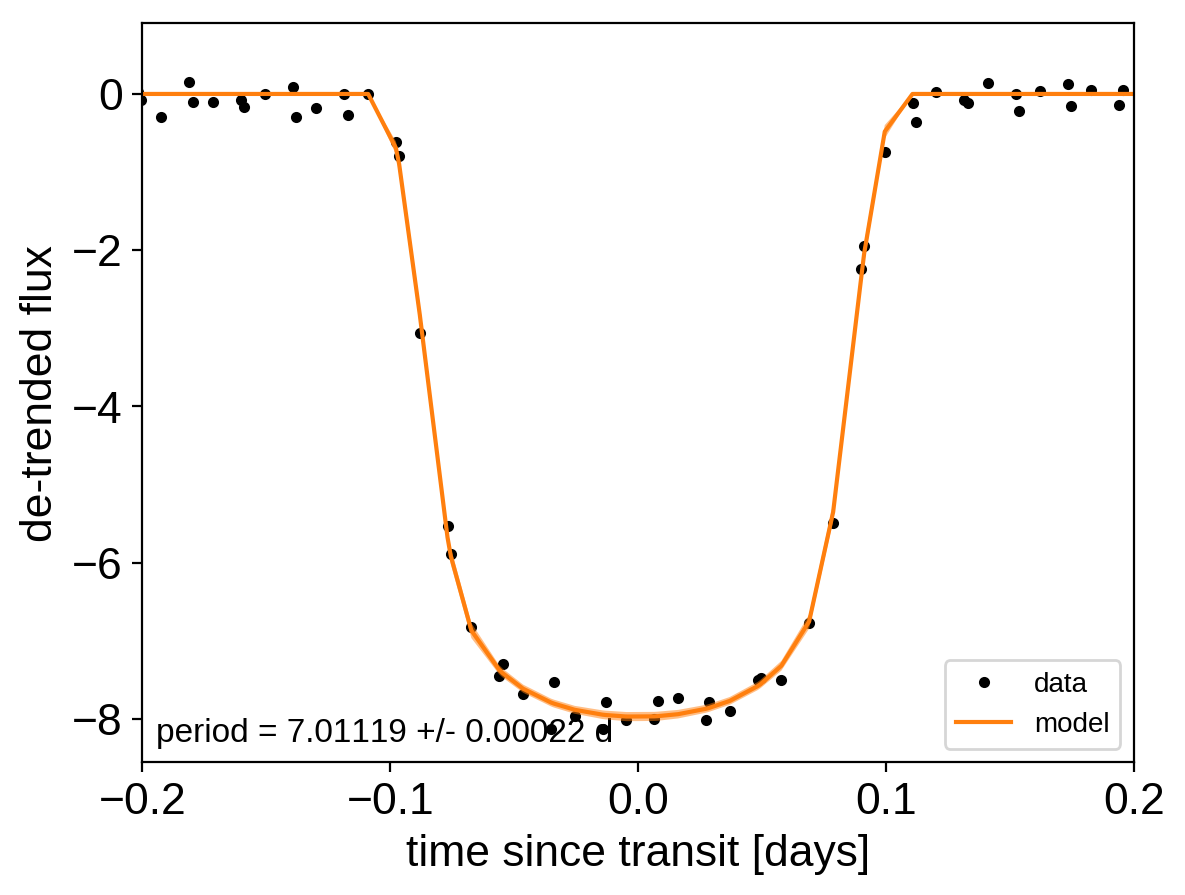

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

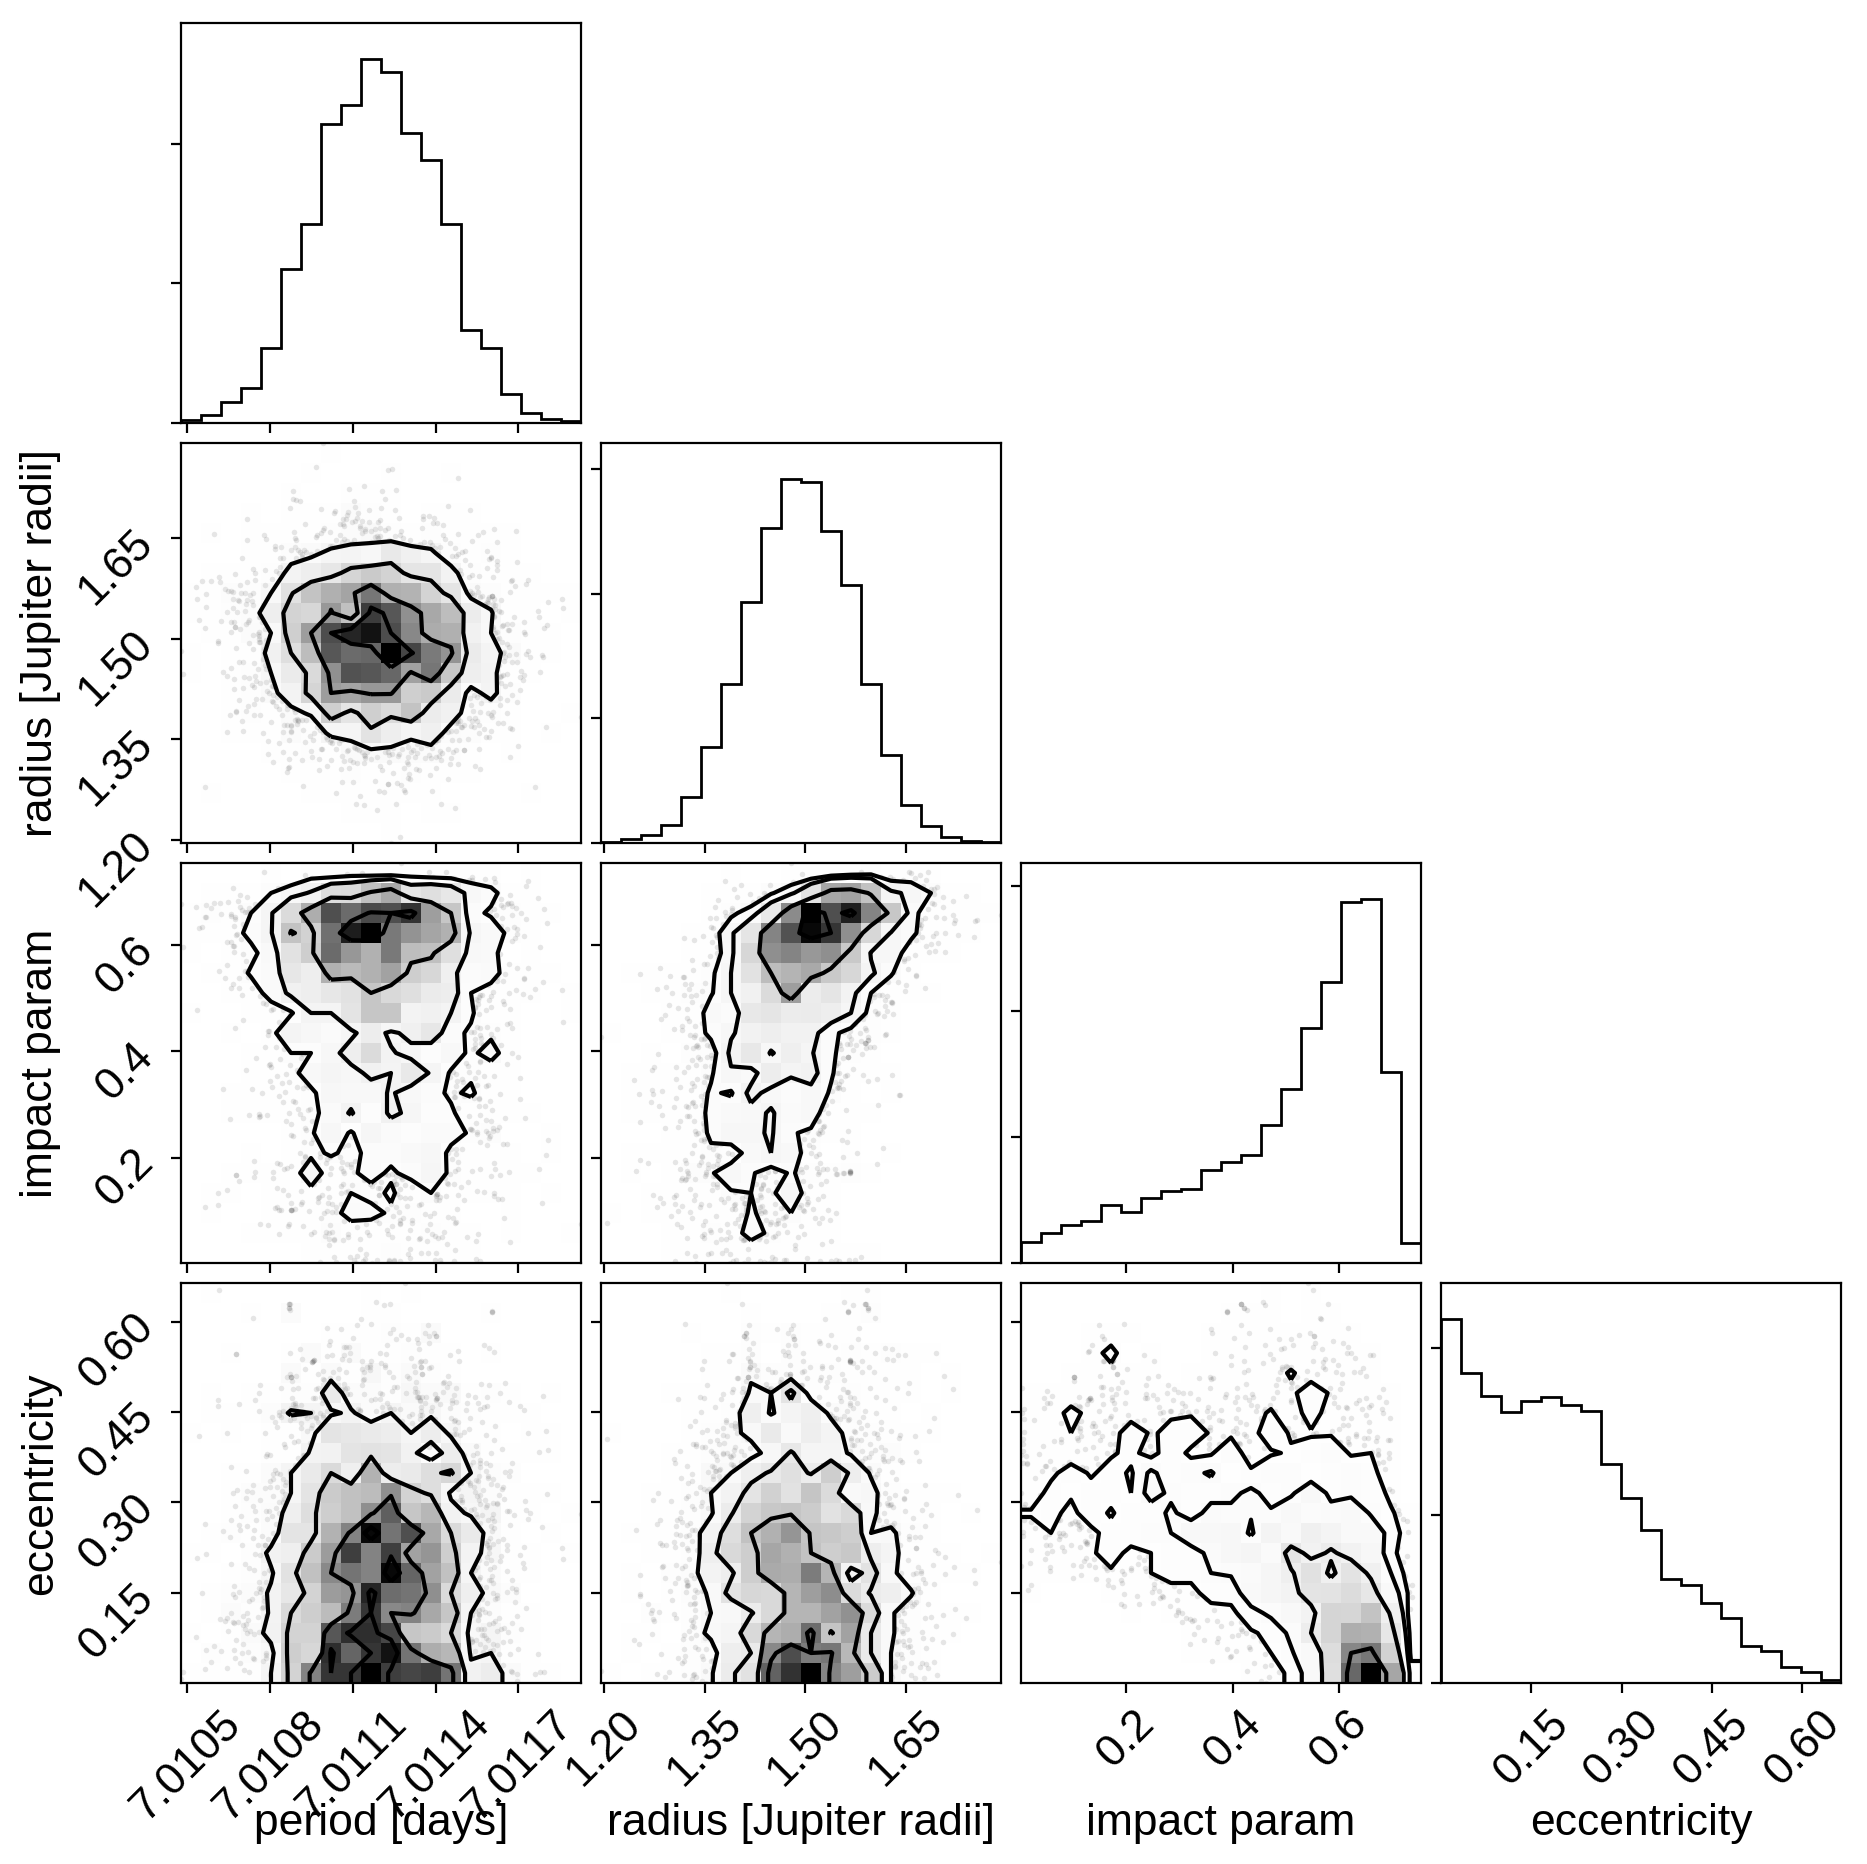

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

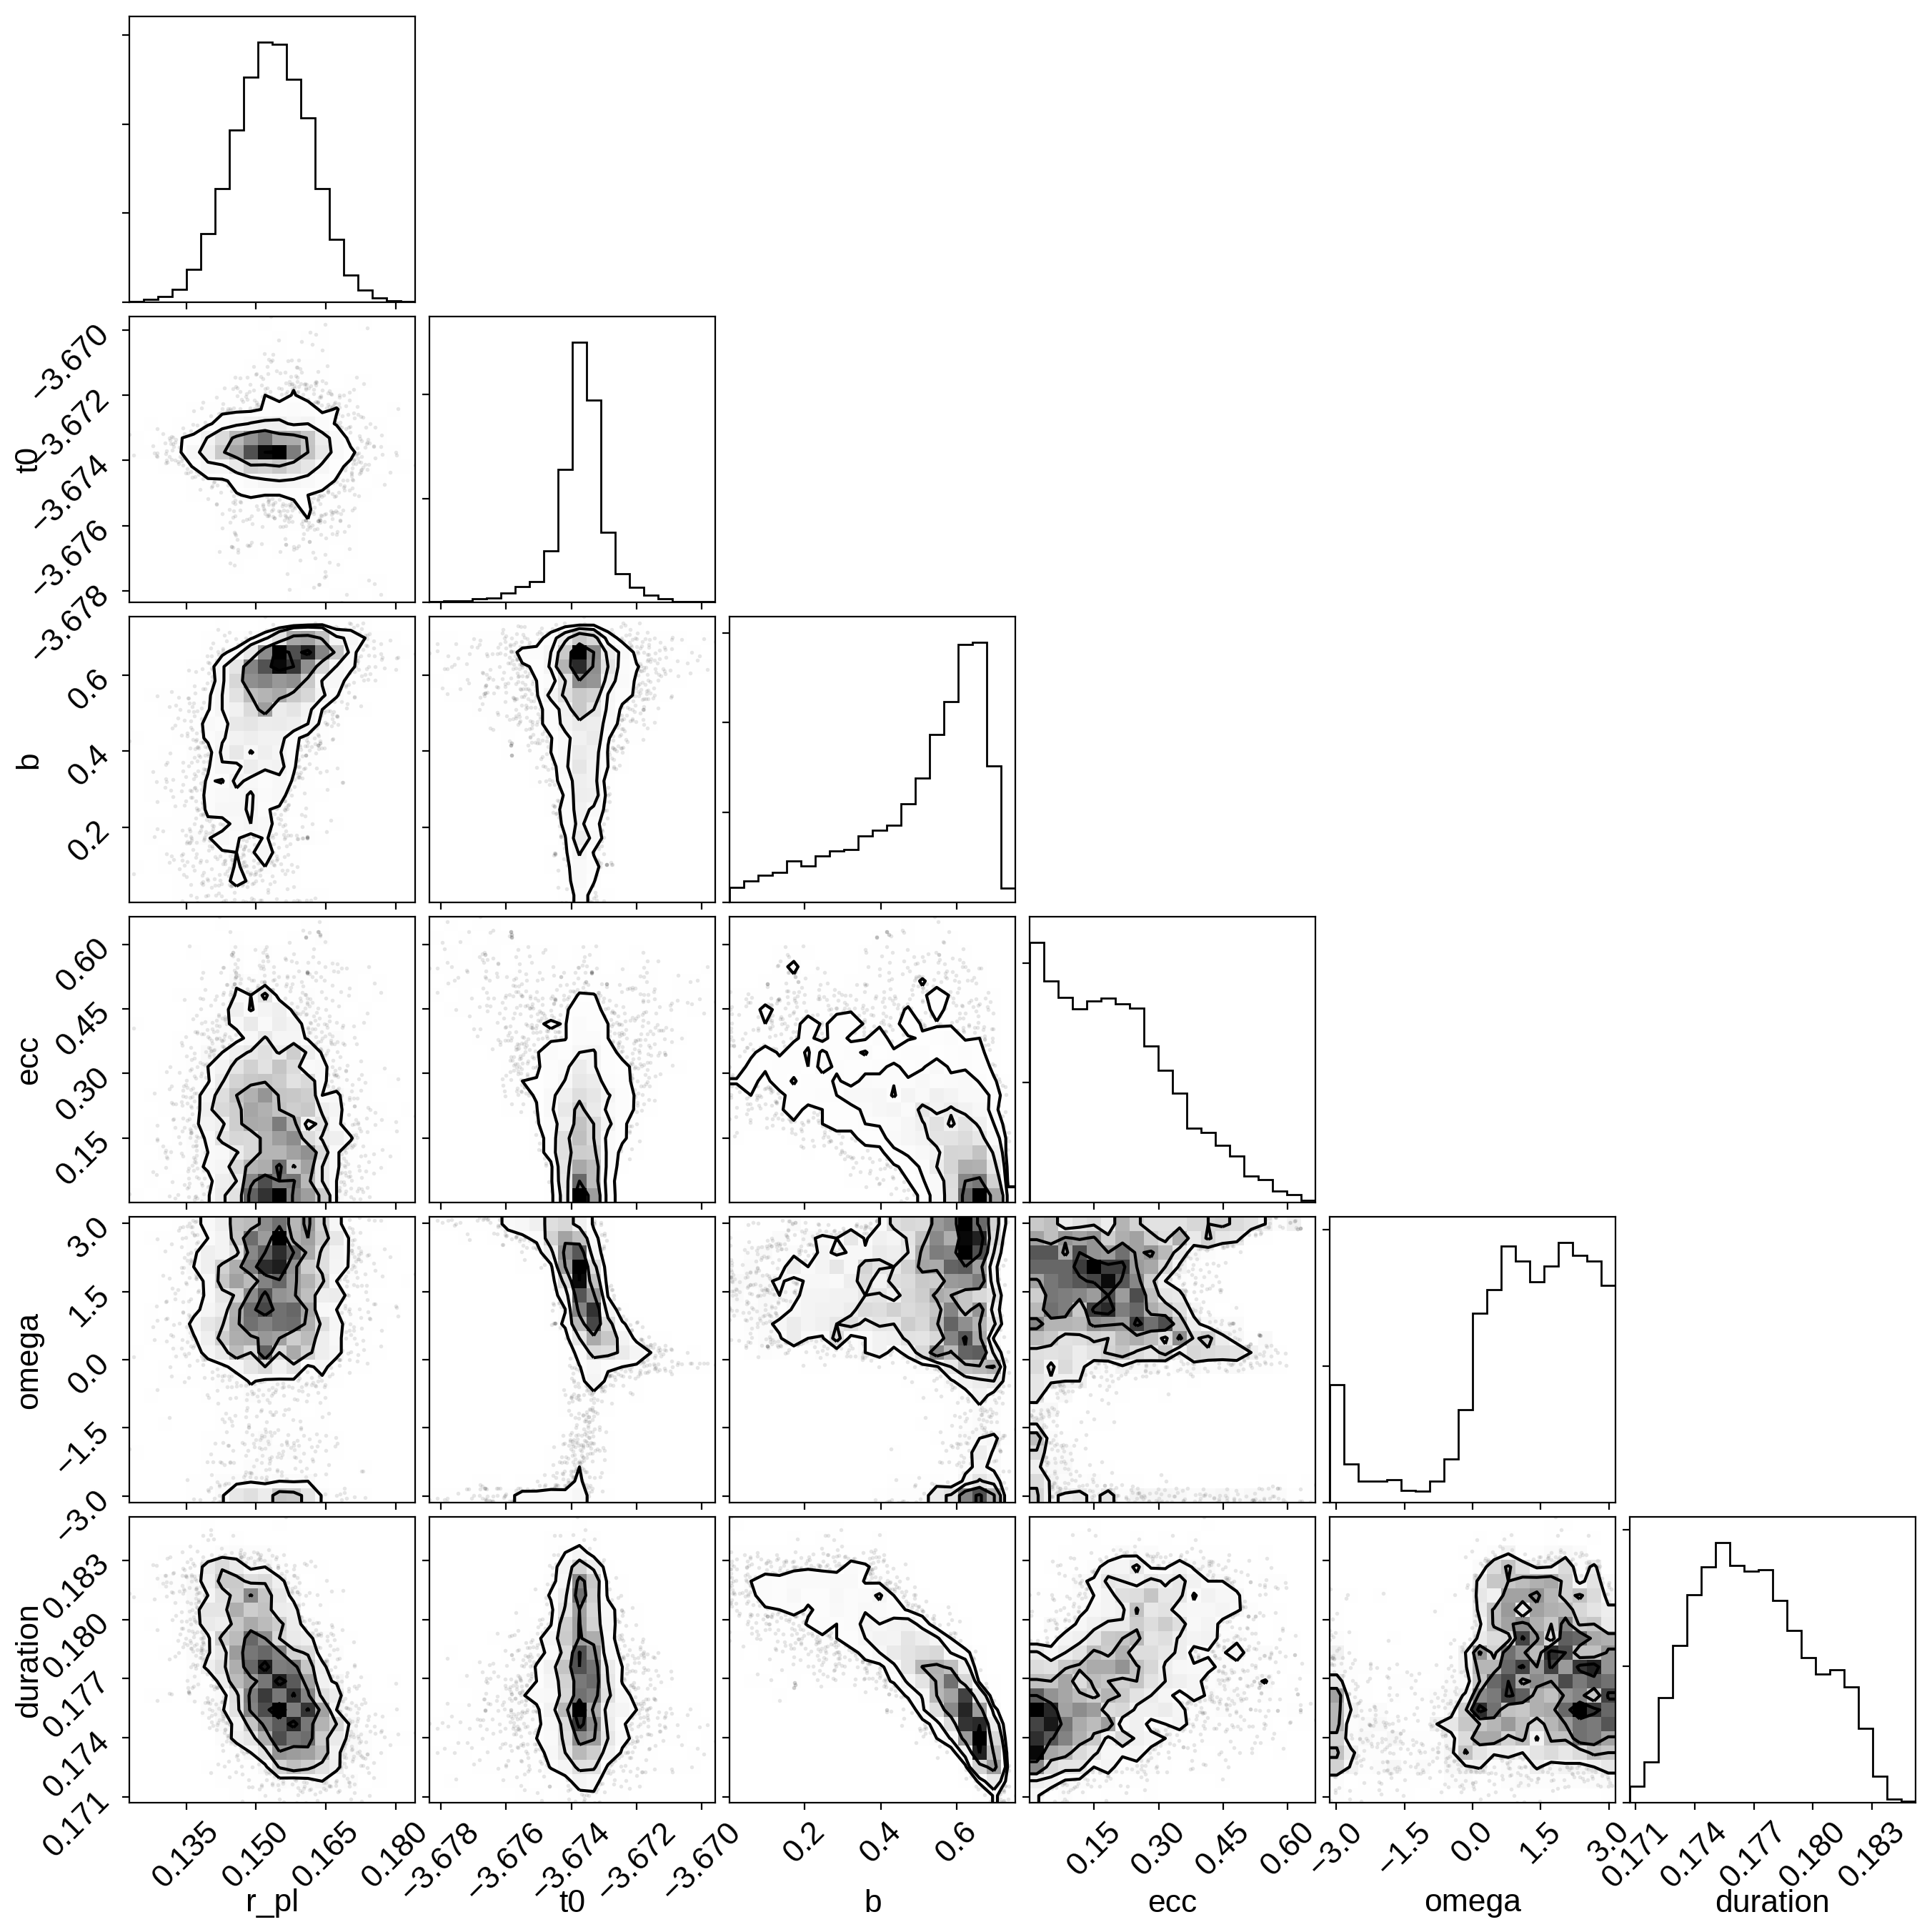

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);